# COMS 4995_002 Deep Learning Assignment 1
Due on Monday, Oct 9, 11:59pm

This assignment can be done in groups of at most 3 students. Everyone must submit on Courseworks individually.

Write down the UNIs of your group (if applicable)

Member 1: Pulkit Jain, pj2313

Member 2: Greg Kocher, gk2500

Member 3: Ratheet Pandya, rp2707

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
import glob
import sys
# you shouldn't need to make any more imports

In [38]:
DEBUG = True#False#True
class NeuralNetwork(object):
    """
    Abstraction of neural network.
    Stores parameters, activations, cached values. 
    Provides necessary functions for training and prediction. 
    """
    def __init__(self, layer_dimensions, weight_init='glorot', drop_prob=0.0, reg_lambda_L2=.0, \
                 reg_lambda_L1=.0, K_iters_alpha_drop=500, gamma=.90, \
                 do_reflection=False, standard_scaling=False):
        """
        Initializes the weights and biases for each layer
        :param layer_dimensions: (list) number of nodes in each layer
        :param drop_prob: drop probability for dropout layers. Only required in part 2 of the assignment
        :param reg_lambda_L2: regularization parameter. Only required in part 2 of the assignment
        """
        #np.random.seed(1)
        
        self.parameters = {
            'layerDimensions' : layer_dimensions
        }
        self.num_layers = len(layer_dimensions)
        self.drop_prob = drop_prob
        self.reg_lambda_L2 = reg_lambda_L2
        self.reg_lambda_L1 = reg_lambda_L1
        
        #Weight initialization strategy:
        #'glorot' - Xavier-Glorot strategy
        #'msra' - Microsoft Research Asia strategy
        #else if put in number, uses that
        self.weight_init = weight_init
        
        #Stepwise exponentially decaying learning rate:
        #every K iterations, learning rate alpha is multiplied
        #by 0<gamma<=1
        #To NOT do this and just use constant alpha,
        #just set gamma = 1 [or K bigger than you would ever reach]
        self.K_iters_alpha_drop = K_iters_alpha_drop#500
        self.gamma = gamma#.90
        
        #Counter used for debugging and updating alpha
        self.iterations_finished = 0
        
        #The weights and biaseswe are optimizing
        self.weights = []
        self.biases = []
        
        #FOr debugging
        self.training_accuracies = []
        self.validation_accuracies = []
        self.data_loss = []
        self.regularization_lossL2 = []
        self.regularization_lossL1 = []
        self.weights_means = []
        self.dW_means = []
        self.weights_sds = []
        self.dW_sds = []        
        
        #Whether to do left/right reflection
        self.do_reflection = do_reflection
        
        #Preprocessing input
        self.standard_scaling = standard_scaling
        self.mu = None        
        self.sigma = None
            
            
        """
        other ideas for increased performance:
        - TA's suggested batchnorm layers
        """
        
        
        
    def LeftRightReflection(self, X_batch, y_batch, prob_reflect=.5):
        """
        As basic form of data augmentation,
        reflect images left-right with some probability.
        
        Only left-right since in many of the cifar images,
        there is a clear up-down direction because of real
        world gravity. So also doing up-down reflection 
        would be artificial. SO only do left-right.
        
        Technically it would be better to only have
        either image or image' in a given batch (to
        not have both the image and its reflection, 
        because both in the same batch way introduce
        bad symmetries). But just try this for now, and
        use a probability so that not every image has
        its reflection.
        
        --> Actually, at first, just relfect all images 
        and se what happens...
        """
        
        S = X_batch.shape[1]
        
        """t=X_batch[:,:5]
        print(t.shape)
        g=[i.reshape(32,32,3) for i in t.T]
        plt.figure()
        plt.imshow(g[0])
        plt.show()
        h=[np.fliplr(i) for i in g]
        plt.figure()
        plt.imshow(h[0])
        plt.show()
        #w=wwwwwwww
        #j=np.vstack(([i.flatten() for i in h])).T
        #print(j.shape)
        #print(t[:,0])
        #print(j[:,0])
        #_,u1 = np.unique(t[:,0],return_counts=True)
        #_,u2 = np.unique(j[:,0],return_counts=True)
        #print(u1==u2)"""
        
        
        #prob_reflect = .5 #Equal probability to use original vs. reflected
        _ = np.random.binomial(1, 1.-prob_reflect, size=S).astype(int)
        #Technically there could be an error here if you get all 0's or all 1's in binomial...
        #THen one of these indices lists could be empty... but as long as batch size large probability is tiny.
        original_inds = np.where(_==1)[0]
        reflected_inds = np.where(_==0)[0]
        #print(original_inds,reflected_inds)
        
        
        #Reshape data, reflect left right, reshape back
        X_batch_reflected = np.vstack(([np.fliplr(i.reshape(32,32,3)).flatten() for i in X_batch.T])).T
        
        
        
        #Append reflected data/labels to originals
        X_batch = np.hstack((X_batch[:,original_inds],X_batch_reflected[:,reflected_inds]))
        y_batch = np.append(y_batch[original_inds],y_batch[reflected_inds])
        
        
        #Verify everything correct reflection and label:
        """plt.figure()
        plt.imshow(X_batch_reflected.T[0].reshape(32,32,3))
        plt.show()
        print(y_batch[0])
        plt.figure()
        plt.imshow(X_batch.T[1].reshape(32,32,3))
        plt.show()
        print(y_batch[1])"""
        
        
        #Update the batch_size since now is potentilly larger
        batch_size = X_batch.shape[1]
        #print(batch_size)
        #Actually not that implemented this way, batch_size unchanged

        return X_batch, y_batch, batch_size

    
    
    def Get_PreprocessInput(self, X_train):
        """
        Do standard scaling;
        --or do whitening or PCA on the data.
        
        Assumes X is (Nfeatures x Nexamples) numpy array
        """
        mu = X_train.mean(axis=1)
        sigma = X_train.std(axis=1)#mu*0.+1.#X_train.std(axis=1)#X_train.var(axis=1)
        return mu, sigma

    
    def Do_PreprocessInput(self, X, mu, sigma):
        """
        Do the preprocessing on the given data, 
        given some already calculated mu + sigma
        which come from the training data.
        """
        X -= mu.reshape(X.shape[0],1).repeat(X.shape[1],axis=1)
        epsilon = 10e-9
        X /= (sigma.reshape(X.shape[0],1).repeat(X.shape[1],axis=1)+epsilon)
        return X
        
        
        
    def visualizeActivations(self,activations):
        """
        Visualize activations for debugging
        """
        N = len(activations)
        r = int(np.ceil(np.sqrt(N)))
        
        fig=plt.figure()
        plt.title('Activations')
        for i in range(N):
            fig.add_subplot(r,r,i+1)
            plt.hist(activations[i].flatten(),bins=100)
            print('Activations', i, 'Mean', activations[i].flatten().mean(), 'SD', activations[i].flatten().std(), \
                  'Min', activations[i].flatten().min(), 'Max', activations[i].flatten().max())
        plt.show()
        
        
    
    def visualizeWeightsAndGradients(self,gradients):
        """
        Visualization tool for debugging
        """
        
        N = len(self.weights)
        r = int(np.ceil(np.sqrt(N)))
        
        fig=plt.figure()
        plt.title('Weights')
        for i in range(N):
            fig.add_subplot(r,r,i+1)
            plt.hist(self.weights[i].flatten(),bins=100)
            print('Weights', i, 'Mean', self.weights[i].flatten().mean(), 'SD', self.weights[i].flatten().std())
        plt.show()
        
        fig=plt.figure()
        plt.title('dW')
        for i in range(N):
            fig.add_subplot(r,r,i+1)
            plt.hist(gradients['dW'][i].flatten(),bins=100)
            print('dW', i, 'Mean', gradients['dW'][i].flatten().mean(), 'SD', gradients['dW'][i].flatten().std())
        plt.show()        
        
        fig=plt.figure()
        plt.title('Biases')
        for i in range(len(self.biases)):
            fig.add_subplot(r,r,i+1)
            plt.hist(self.biases[i].flatten(),bins=100)
            print('Biases', i, 'Mean', self.biases[i].flatten().mean(), 'SD', self.biases[i].flatten().std())
        plt.show()
        
        
        #Just make plots of means / sds since easier to see than these histograms
        """
        fig=plt.figure()
        plt.title('Weights')
        clist = ['r','g','b','k','c','m']
        for i in range(N):
            fig.plot(self.weights_means[i],,marker='o',color=clist[i],label='Loss')
            print('Weights', i, 'Mean', self.weights[i].flatten().mean(), 'SD', self.weights[i].flatten().std())
        plt.show()
        
        fig=plt.figure()
        plt.title('dW')
        for i in range(N):
            fig.add_subplot(r,r,i+1)
            plt.hist(gradients['dW'][i].flatten())
            print('dW', i, 'Mean', gradients['dW'][i].flatten().mean(), 'SD', gradients['dW'][i].flatten().std())
        plt.show()      
        """
        
        
        if False:
            plt.figure()
            plt.title('Loss vs Iteration')
            plt.plot(self.data_loss,marker='o',color='b',label='Data Loss')
            if self.reg_lambda_L2 > 0.:
                plt.plot(self.regularization_lossL2,marker='o',color='r',label='Regularization Loss L2')
            if self.reg_lambda_L1 > 0.:
                plt.plot(self.regularization_lossL1,marker='o',color='g',label='Regularization Loss L1')            
            plt.legend(numpoints=1)
            #self.iterations_finished
            plt.show()    
        
        plt.figure()
        plt.title('Accuracy vs Iteration (x10)')
        plt.plot(self.training_accuracies,marker='o',color='g',label='Train')
        plt.plot(self.validation_accuracies,marker='o',color='r',label='Validation')
        plt.legend(numpoints=1)
        #self.iterations_finished
        plt.show()    
        
        
        
        
    def affineForward(self, A, W, b):
        """
        Forward pass for the affine layer.
        :param A: input matrix, shape (L, S), where L is the number of hidden units in the previous layer and S is
        the number of samples
        :returns: the affine product WA + b, along with the cache required for the backward pass
        """
        Z = np.matmul(W, A) + b
        return Z
        

    def activationForward(self, A, activation="relu"):
        """
        Common interface to access all activation functions.
        :param A: input to the activation function
        :param prob: activation funciton to apply to A. Just "relu" for this assignment.
        :returns: activation(A)
        """ 
        return self.relu(A)


    def relu(self, X):
        A = np.maximum(0, X)
        return A

            
    def dropout(self, A, prob):
        """
        :param A: 
        :param prob: drop prob
        :returns: tuple (A, M) 
            WHERE
            A is matrix after applying dropout
            M is dropout mask, used in the backward pass
        """
        rng = np.random.RandomState()
        M = rng.binomial(size=A.shape,
                            n=1,
                            p=1-prob)
        #M = np.random.binomial(1, 1.-prob, size=A.shape)
        #print(M.sum())
        A *= M
        return A, M

    
    def forwardPropagation(self, X, mode):
        """
        Runs an input X through the neural network to compute activations
        for all layers. Returns the output computed at the last layer along
        with the cache required for backpropagation.
        :returns: (tuple) AL, cache
            WHERE 
            AL is activation of last layer
            cache is cached values for each layer that
                     are needed in further steps
        """
        A = X
        

        cache = {
            'biases' : [],
            'weights' : [],
            'dropoutMasks' : [],
            'affines' : [],
            'activations' : [A]
        }
        
        #After already done 1 iteration, reuse the weights and biases we learned:
        if self.iterations_finished > 0:
            cache['biases'] = self.biases
            cache['weights'] = self.weights
        
        #same for below random initialization of W and b, are they being overwritten?
        
        for layer in range(1,self.num_layers):
            #On 1st training iteration only, randomly initialize weights and biases:
            if self.iterations_finished==0:
                
                #Try Xavier-Glorot initialization [http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf]:
                if self.weight_init == 'glorot':
                    SD = np.sqrt(2. / (self.parameters['layerDimensions'][layer]+self.parameters['layerDimensions'][layer - 1]))
                
                #Try MSRA initialization [https://arxiv.org/pdf/1502.01852.pdf]:
                if self.weight_init == 'msra':
                    SD = np.sqrt(2. / self.parameters['layerDimensions'][layer - 1])
                
                #Or use fixed constant from manual tuning:
                elif (type(self.weight_init) == int) or (type(self.weight_init) == float):
                    SD = float(self.weight_init)
                
                #print(SD)
                    
                W = np.random.normal(0., SD, size=(self.parameters['layerDimensions'][layer], self.parameters['layerDimensions'][layer - 1]))
                #b = np.zeros(shape=(self.parameters['layerDimensions'][layer], 1))
                #Set to small positive to give more activations>0 at beginning, so neurons will fire even with ReLu:
                #b = np.ones(shape=(self.parameters['layerDimensions'][layer], 1))
                b = .1*np.ones(shape=(self.parameters['layerDimensions'][layer], 1))
            
            else:
                W = cache['weights'][layer-1]
                b = cache['biases'][layer-1]
            Z= self.affineForward(A, W, b)
            
            #So relu not applied to last layer (index self.num_layers-1):
            #(Also we don't do ReLU onqt layer, but that's already taken 
            #care of because we do range(1,...) )
            A = self.activationForward(Z) if layer!=self.num_layers-1 else Z
            
            
            if self.drop_prob > 0.:
                if mode=='train':
                    A, M = self.dropout(A,self.drop_prob)
                    A /= self.drop_prob
                    cache['dropoutMasks'].append(M)
                if mode=='predict':
                    A = A
            cache['affines'].append(Z)
            cache['activations'].append(A)
            
            if self.iterations_finished==0:
                cache['weights'].append(W)
                cache['biases'].append(b)    

        AL = A
        return AL, cache
    
    def costFunction(self, AL, y, cache):
        """
        :param AL: Activation of last layer, shape (num_classes, S)
        :param y: labels, shape (S)
        :param self.reg_lambda_L2: regularization parameter
        :returns cost, dAL: A scalar denoting cost and the gradient of cost
        """

        epsilon = 10e-9 #10e-5 #10e-9 #Since taking logs of very small numbers is giving infs
        S = y.size
        
        #Get softmax cost per sample:
        #(both numerators and denominators are length S vectors)
        #denominators = np.exp(AL).sum(axis=0)
        #numerators = np.array([np.exp(AL[y[i]-1,i]) for i in range(S)])#-1 is assuming class labels start at 1. If they start at 0, get rid of -1.
        #Actually will end up needing for gradients so just do as below...
        
        #print(AL)
        #print(AL.min())
        #print(AL.max())
        
        #print(np.exp(AL))
        #print(np.exp(AL).min())
        #print(np.exp(AL).max())
        
        
        #Original, no clipping
        #softmax_out = np.exp(AL)/(np.exp(AL).sum(axis=0)+epsilon)
        
        #Nan to num cliping:
        #softmax_out = np.nan_to_num(np.exp(AL))/(np.nan_to_num(np.exp(AL).sum(axis=0))+epsilon)
        #Using numerically stability trick:
        softmax_out = np.exp(AL-np.max(AL))/np.exp(AL-np.max(AL)).sum(axis=0)
        
        #if 0's in softmax out, will get infs in cost, so clip to epsilon
        softmax_out = softmax_out.clip(min=10e-20)
        
        #Need to know if there are nans/infs:
        if DEBUG:
            #nans_present = np.isnan(np.exp(AL)).any()
            #infs_present = np.isinf(np.exp(AL)).any()
            #if nans_present:
            #    raise ValueError('nans in exp(AL)')
            #if infs_present:
            #    raise ValueError('infs in exp(AL)')
            if np.isnan(softmax_out).any():
                raise ValueError('nans in softmax function')
            if np.isinf(softmax_out).any():
                raise ValueError('infs in softmax function')
            if (softmax_out==0.).any():
                raise ValueError('zeros in softmax function')
                

                
        #Manual clipping
        #max_val = 10e3
        #softmax_out = np.exp(AL).clip(0.,max_val)/(np.exp(AL).clip(0.,max_val).sum(axis=0)+epsilon)
        
        #print(softmax_out)
        #print(softmax_out.min())
        #print(softmax_out.max())

        #Now get the cross-entropy / log-loss of this softmax:
        #cost is the average over all samples
        #cost = (-1./S)*np.nansum(np.log(softmax_out))#+epsilon)) #Should deal with nans, but for now just use nansum...
        cost = (-1./S)*np.sum(np.log(softmax_out))
        self.data_loss += [cost]
        
        #Need to know if there are nans/infs:
        #With the nan/inf/0 handling above, there should never be any problems with cost function
        #unless there is overflow in log function:
        if DEBUG:
            nans_present = np.isnan(np.log(softmax_out)).any()
            infs_present = np.isinf(np.log(softmax_out)).any()
            if nans_present:
                raise ValueError('nans in cost function')
            if infs_present:
                raise ValueError('infs in cost function')
                
                
        
        #Also get the regularization cost:
        if self.reg_lambda_L2 > 0.:
            # add regularization
            #If want to do other Lp norms as easy bonus:
            #in init: self.reg_p_norm = 2#int p for p-norm regularization
            #FOr now just using L2 norm:
            #||W||^2
            reg_cost = self.reg_lambda_L2*np.array([np.sum(i.flatten()**2) for i in cache['weights']]).sum()
            #print(reg_cost)
            #print(cost)
            cost += reg_cost
            self.regularization_lossL2 += [reg_cost]
            
        #Also get the regularization cost:
        if self.reg_lambda_L1 > 0.:
            reg_cost = self.reg_lambda_L1*np.array([np.sum(np.abs(i.flatten())) for i in cache['weights']]).sum()
            #print(reg_cost)
            #print(cost)
            cost += reg_cost
            self.regularization_lossL1 += [reg_cost]            
        
        
        
        # gradient of cost
        #gradient through cross entropy, then sigmoid, turns out to be:
        #for a single trainign example:
        #dAL_i = sigmoid(z_i) - I(class==i);
        #when go over all training batch examples, 
        #take average over axis 1. Is just sigmoid out array, with certain elements -1.
        #Those elements are the ones corresponding to correct class label, for a given
        #training example:
        softmax_out[y,np.arange(S)] -= 1.
        #Sum over axis 1 and then scale by S, i.e. take mean over samples:
        #dAL = softmax_out.mean(axis=1)#actually since using 2D dropout mask,
        #don't do the averaging now. Leave as 2D matrix with axis1 size = S, the number of samples
        dAL = softmax_out
        
        #Since we don't use ReLU on last layer and treat it 
        #manually in this function by feeding it through softmax layer,
        #get rid of last layer activation here since we basically bypass 
        #the gradient calculation for this last layer and do it separately.
        #THen in the layers before this last one, can treat as usual.
        _ = cache['activations'].pop()
        #Same thing for dropout mask, if doing dropout:
        if self.drop_prob > 0.:
            _ = cache['dropoutMasks'].pop()
        
        return cost, dAL

    
    def affineBackward(self, dA_prev, cache, layer):
        """
        Backward pass for the affine layer.
        :param dA_prev: gradient from the next layer.
        :param cache: cache returned in affineForward
        :layer : since you need to multiply by weights/biases
        :returns dA: gradient on the input to this layer
                 dW: gradient on the weights
                 db: gradient on the bias
        """
        
        #print('layer',layer)
        
        S = cache['activations'][0].shape[1]
        
        #Use the derivative from the later layer
        #["previous" since goign in reverse]:
        #dA_prev
        
        W = cache['weights'][layer-1]
        dA = np.dot(W.T,dA_prev)
        #print(dA.shape)

        dA = self.activationBackward(dA, cache, None, activation="relu")
        #If doing dropout:
        if self.drop_prob > 0.:
            #Sropout not used directly on input layer, even if mask is generated for it.
            if layer > 1:
                dA = self.dropout_backward(dA, cache)
        #dA = self.activationBackward(dA, cache, None, activation="relu")
        
        #Repeat dA_prev since have S samples:
        #dW = np.dot(np.repeat(dA_prev.reshape((dA_prev.size,1)),S,axis=1),cache['activations'][-1].T)
        #Since dropout mask, just keep dA_prev in 2D [don't average over samples]
        dW = np.dot(dA_prev,cache['activations'][-1].T)
        #print(dW)
        #print(dW.min(),dW.max())
        #print(dW.shape)#(10,100)

        
        #If regularized, also add in gradients from reg cost:
        if self.reg_lambda_L2 > 0.:
            dW += self.reg_lambda_L2*W #For now assuming only L2 reg.
        #If also doing L1 regularization:
        if self.reg_lambda_L1 > 0.:
            dW += self.reg_lambda_L1*(W>=0).astype(int)

        #Gradient of biases
        #d_output / db = I(if i)
        #db = sum dA_prev dot repeated [np.ones(cache['biases'][layer-1].shape) ], or simpler:
        db = dA_prev.sum(axis=1)#Sum over all examples
        db = db.reshape(db.size,1)
        
        #Now that done using the activations, get rid of them 
        #so indexing correct for next iterations:
        cache['activations'].pop()
        #print(len(cache['activations']))
        #print(cache['activations'][0].shape)

        return dA, dW, db

    
    
    def activationBackward(self, dA, cache, layer, activation="relu"):
        """
        Interface to call backward on activation functions.
        In this case, it's just relu. 
        """
        cached_x = cache['activations'][-1]
        return self.relu_derivative(dA, cached_x)

        
    def relu_derivative(self, dx, cached_x):

        #S = cached_x.shape[1]
        #Repeat dx since have S samples:
        #dx = np.repeat(dx.reshape((dx.size,1)),S,axis=1)
        
        #In positive region, dx=1; in negative region = 0:
        dx = np.ones(cached_x.shape)*dx
        #Mask the negative region to 0.
        dx[cached_x <= 0.] = 0.
        #Could treat the exact ==0. case differently but to precision will never get ==0.
        
        #Average over axis 1 [averaged over samples]
        #dx = dx.mean(axis=1)#No longer do this since dropout mask
        return dx

    
    def dropout_backward(self, dA, cache):
        dA *= cache['dropoutMasks'].pop()
        return dA

    def backPropagation(self, dAL, Y, cache):
        """
        Run backpropagation to compute gradients on all paramters in the model
        :param dAL: gradient on the last layer of the network. Returned by the cost function.
        :param Y: labels
        :param cache: cached values during forwardprop
        :returns gradients: dW and db for each weight/bias
        """
        gradients = {
            'dW' : [],
            'db' : []
         }
        
        
        dA = dAL
        for layer in range(self.num_layers-1):
            dA, dW, db = self.affineBackward(dA,cache,self.num_layers-layer-1)
            gradients['dW'].append(dW) 
            gradients['db'].append(db) 
            
            #Was easier to just put inside affineBackward...
            #if self.drop_prob > 0:
            #    #If not working on the input layer (don't use dropout on it):
            #    if layer < self.num_layers-2 #-2 since: 
            #        self.dropout_backward(dA,cache)
           
        #if self.reg_lambda_L2 > 0:
            # add gradients from L2 regularization to each dW
            #GK: I'm just adding them to dAL in the costfunction so should be ok w/o this here
        gradients['dW'].reverse()
        gradients['db'].reverse() 
        return gradients


    def updateParameters(self, gradients, alpha, cache):
        """
        :param gradients: gradients for each weight/bias
        :param alpha: step size for gradient descent 
        
        cache: to update the parameters we are learning [weights and biases],
        those values also need to be passed in.
        """
        
        #Weights
        #print(cache['weights'][0])
        #print(gradients['dW'][0].min())
        #print(gradients['dW'][0].max())
        cache['weights'] = [cache['weights'][i]  - alpha*gradients['dW'][i] for i in range(len(cache['weights']))] 
        #print(cache['weights'][0])
        #print(cache['weights'][0].max())
        #print(cache['weights'][0].min())

        #biases
        #print(cache['biases'][0])
        #...[Or could try keeping biases fixed by commenting out below]:
        cache['biases'] = [cache['biases'][i]  - alpha*gradients['db'][i] for i in range(len(cache['biases']))] 
        #print(cache['biases'][0])
    
                
    def predict(self, X):
        """
        Make predictions for each sample
        """
        
        if self.standard_scaling:
            #Transform the test set exactly as the training set:
            X = self.Do_PreprocessInput(X,self.mu,self.sigma)

        AL, _ = self.forwardPropagation(X,mode='predict')
        
        #Get probability per class per sample, then take argmax:
        #Technically don't need to go through softmax calculations, etc. since max here is max after too.
        #SO just get argmax for each sample:
        y_pred = np.argmax(AL,axis=0)

        if DEBUG:
            print(y_pred)
            print(np.bincount(y_pred))
        #y_pred = [100, 200, 300]
        
        return y_pred

    
    def get_batch(self, X, y, batch_size):
        """
        Return minibatch of samples and labels
        
        :param X, y: samples and corresponding labels
        :parma batch_size: minibatch size
        :returns: (tuple) X_batch, y_batch
        """
        selector = np.random.choice(np.arange(np.size(y)), batch_size, replace=False)
        return X[:, selector], y[selector]

    def train(self, X, y, iters=1000, alpha=0.0001, batch_size=100, print_every=100):
        """
        :param X: input samples, each column is a sample
        :param y: labels for input samples, y.shape[0] must equal X.shape[1]
        :param iters: number of training iterations
        :param alpha: step size for gradient descent
        :param batch_size: number of samples in a minibatch
        :param print_every: no. of iterations to print debug info after
        """
        
        #Split training data into training and validation set (90/10 split):
        train_inds = np.random.choice(X.shape[1],int(X.shape[1]*.90),replace=False)
        validation_inds = np.setdiff1d(np.arange(X.shape[1]),train_inds)
        X_training = X[:,train_inds]
        y_training = y[train_inds]
        X_validation = X[:,validation_inds]
        y_validation = y[validation_inds]
        #print(X_training.shape, y_training.shape, X_validation.shape, y_validation.shape)
        
        
        if self.standard_scaling:
            #Calculate mean, variance over features
            self.mu, self.sigma = self.Get_PreprocessInput(X_training)
            #Transform X_training to be 0 mean, unit SD
            X_training = self.Do_PreprocessInput(X,self.mu,self.sigma)
            #And also process the validation data exactly the same way
            X_validation = self.Do_PreprocessInput(X_validation,self.mu,self.sigma)
            #The exact same transformation will be done on the test set in the predict function
            
            
            
        
        
        
        #Do training iterations
        for i in range(0, iters):
            # get minibatch
            X_batch, y_batch = self.get_batch(X_training, y_training, batch_size)
            
            #Left right reflection as form of data augmentation
            if self.do_reflection:
                X_batch, y_batch, batch_size = self.LeftRightReflection(X_batch, y_batch, prob_reflect=.5)
                #print(X_batch.shape, y_batch.shape, batch_size)
            
            
            # forward prop
            AL, cache = self.forwardPropagation(X_batch,mode='train')
            
            #For debugging, look at activations [do here before popped off in backprop]
            if DEBUG and i % 100 == 0:
                self.visualizeActivations(cache['activations'])

            # compute loss
            cost, dAL = self.costFunction(AL, y_batch, cache)
            #print('cost',cost)
            
            # compute gradients
            gradients = self.backPropagation(dAL, y_batch, cache)
            #print('gradients',gradients,len(gradients['dW']),gradients['dW'][0].shape)

            # update weights and biases based on gradient
            #print(self.iterations_finished)
            #print('alpha',alpha)
            #This learning rate alpha will decay step exponentially [every K iters, multiply by 0<gamma<=1]
            self.updateParameters(gradients, alpha, cache) #will update weights + biases in place

            
            #Store the weights and biases that were just updated: 
            self.weights = cache['weights']
            self.biases = cache['biases']
            #print(len(self.weights))
            #print(len(self.biases))
            #print(self.weights[0].shape)
            #print(self.biases[0].shape)
            
            
            #Iteration counter
            self.iterations_finished += 1
            
            #Lower the learning rate every K iterations.
            #Just use an exponential decay here: alpha' = alpha*gamma^(floor(i/K))
            if self.iterations_finished % self.K_iters_alpha_drop == 0:
                alpha *= self.gamma #decaying stepwise exponentially
            
            
            if i % print_every == 0:
                #Training set accruacy:
                y_batch_predicted = self.predict(X_batch)
                train_accuracy = (y_batch_predicted==y_batch).sum()/np.float(batch_size)
                #Validation set accuracy:
                y_validation_predicted = self.predict(X_validation)
                validation_accuracy = (y_validation_predicted==y_validation).sum()/np.float(y_validation.size)
                print('cost: {0}, train accuracy: {1}, validation accuracy: {2}'.format(
                    cost, train_accuracy, validation_accuracy))
                
                self.training_accuracies += [train_accuracy]
                self.validation_accuracies += [validation_accuracy]
                
                
                print('iterations finished:', self.iterations_finished, 'alpha:', alpha, 'reg. lambda:', self.reg_lambda_L2)
                print('\n')
                
                
            
            #For debugging, look at weights and gradients on weights
            if DEBUG and i % 100 == 0:
                self.visualizeWeightsAndGradients(gradients)


In [31]:
# Helper functions, DO NOT modify this

def get_img_array(path):
    """
    Given path of image, returns it's numpy array
    """
    return scipy.misc.imread(path)

def get_files(folder):
    """
    Given path to folder, returns list of files in it
    """
    filenames = [file for file in glob.glob(folder+'*/*')]
    filenames.sort()
    return filenames

def get_label(filepath, label2id):
    """
    Files are assumed to be labeled as: /path/to/file/999_frog.png
    Returns label for a filepath
    """
    tokens = filepath.split('/')
    label = tokens[-1].split('_')[1][:-4]
    if label in label2id:
        return label2id[label]
    else:
        sys.exit("Invalid label: " + label)

In [32]:
# Functions to load data, DO NOT change these

def get_labels(folder, label2id):
    """
    Returns vector of labels extracted from filenames of all files in folder
    :param folder: path to data folder
    :param label2id: mapping of text labels to numeric ids. (Eg: automobile -> 0)
    """
    files = get_files(folder)
    y = []
    for f in files:
        y.append(get_label(f,label2id))
    return np.array(y)

def one_hot(y, num_classes=10):
    """
    Converts each label index in y to vector with one_hot encoding
    """
    y_one_hot = np.zeros((y.shape[0], num_classes))
    y_one_hot[y] = 1
    return y_one_hot.T

def get_label_mapping(label_file):
    """
    Returns mappings of label to index and index to label
    The input file has list of labels, each on a separate line.
    """
    with open(label_file, 'r') as f:
        id2label = f.readlines()
        id2label = [l.strip() for l in id2label]
    label2id = {}
    count = 0
    for label in id2label:
        label2id[label] = count
        count += 1
    return id2label, label2id

def get_images(folder):
    """
    returns numpy array of all samples in folder
    each column is a sample resized to 30x30 and flattened
    """
    files = get_files(folder)
    images = []
    count = 0
    
    for f in files:
        count += 1
        if count % 10000 == 0:
            print("Loaded {}/{}".format(count,len(files)))
        img_arr = get_img_array(f)
        img_arr = img_arr.flatten() / 255.0
        images.append(img_arr)
    X = np.column_stack(images)

    return X

def get_train_data(data_root_path):
    """
    Return X and y
    """
    train_data_path = data_root_path + 'train'
    id2label, label2id = get_label_mapping(data_root_path+'labels.txt')
    print(label2id)
    X = get_images(train_data_path)
    y = get_labels(train_data_path, label2id)
    return X, y

def save_predictions(filename, y):
    """
    Dumps y into .npy file
    """
    np.save(filename, y)

In [5]:
# Load the data
data_root_path = 'cifar10-hw1/'
X_train, y_train = get_train_data(data_root_path) # this may take a few minutes
X_test = get_images(data_root_path + 'test')
print('Data loading done')

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
Loaded 10000/50000
Loaded 20000/50000
Loaded 30000/50000
Loaded 40000/50000
Loaded 50000/50000
Loaded 10000/10000
Data loading done


## Part 1

#### Simple fully-connected deep neural network

Activations 0 Mean 0.447466681985 SD 0.247665377336 Min 0.0 Max 1.0
Activations 1 Mean 0.314483276701 SD 0.418582241815 Min 0.0 Max 3.3406017711
Activations 2 Mean 0.323737326876 SD 0.435577673827 Min 0.0 Max 2.90471525075
Activations 3 Mean 0.209962896106 SD 0.732291981728 Min -1.57708762772 Max 2.19317580136


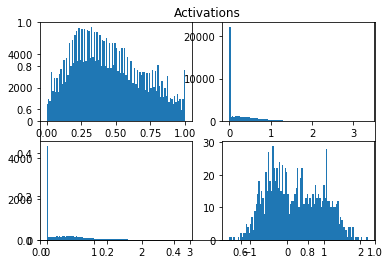

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[  0   0 100]
[2 2 2 ..., 2 2 2]
[   0   12 4987    0    0    0    0    0    1]
cost: 25.64557959318043, train accuracy: 0.14, validation accuracy: 0.0964
iterations finished: 1 alpha: 0.001 reg. lambda: 0.0


Weights 0 Mean -5.672549333e-05 SD 0.023659253961
Weights 1 Mean -0.000336866266242 SD 0.0577665297878
Weights 2 Mean 0.000786497118276 SD 0.130726390056


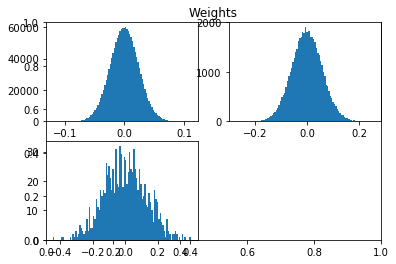

dW 0 Mean 0.068359638702 SD 0.552214139798
dW 1 Mean 0.209907612593 SD 1.45253994276
dW 2 Mean 0.0 SD 4.61841118886


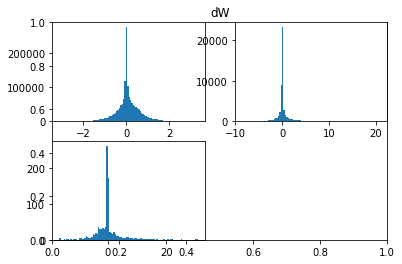

Biases 0 Mean 0.099848775915 SD 0.00110664680965
Biases 1 Mean 0.0993436342367 SD 0.00279777443683
Biases 2 Mean 0.1 SD 0.00864681646175


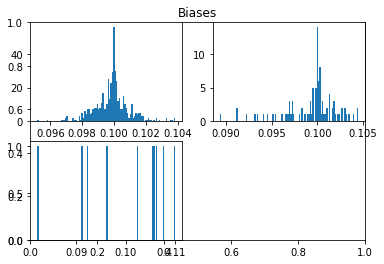

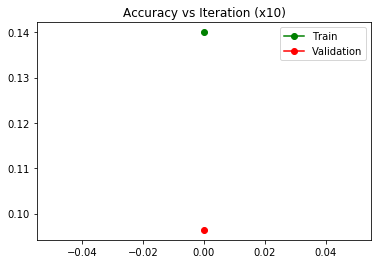

[9 6 6 6 9 9 9 9 6 9 6 9 9 6 9 6 9 9 6 8 9 9 6 9 6 9 6 9 9 9 9 9 9 9 9 9 6
 9 9 6 9 9 6 9 9 9 9 9 9 9 9 9 9 6 9 6 9 8 8 9 9 9 9 9 9 6 9 9 9 9 6 9 6 9
 9 9 9 6 8 6 9 8 6 9 9 9 9 6 8 9 6 6 9 9 8 9 6 9 9 9]
[ 0  0  0  0  0  0 26  0  7 67]
[6 9 8 ..., 6 6 6]
[   0    0    0    1    3    0 1430   45  229 3292]
cost: 23.23100324392817, train accuracy: 0.16, validation accuracy: 0.1484
iterations finished: 11 alpha: 0.001 reg. lambda: 0.0


[4 0 8 8 0 8 0 8 0 8 0 4 0 6 0 8 0 3 8 0 0 8 0 0 0 0 0 8 8 8 8 0 0 0 0 6 0
 8 8 0 6 8 4 0 8 8 0 8 0 9 9 4 0 0 8 9 0 0 0 0 8 8 8 4 0 0 0 0 0 0 0 8 0 8
 8 8 0 0 9 0 8 0 6 8 8 8 0 6 8 0 8 8 8 8 0 8 0 8 0 0]
[48  0  0  1  5  0  5  0 37  4]
[4 0 8 ..., 8 0 0]
[2385    2    0   54  162    7  164    0 2090  136]
cost: 23.572399013667, train accuracy: 0.15, validation accuracy: 0.1496
iterations finished: 21 alpha: 0.001 reg. lambda: 0.0


[5 8 6 9 5 8 8 5 9 6 8 8 6 5 6 5 8 5 8 5 9 8 5 9 5 5 9 8 5 5 8 6 5 5 4 5 6
 8 5 5 5 8 4 6 8 2 8 9 5 9 9 5 9 2 9 6 6 5 5 5 5 6 

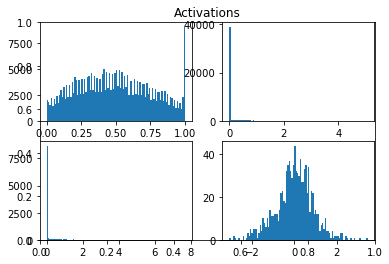

[3 6 8 1 3 3 0 3 9 9 5 8 5 8 9 5 9 8 1 5 9 8 8 0 3 1 3 6 9 4 0 9 1 5 3 9 8
 3 3 0 5 8 3 3 8 8 5 8 8 1 1 9 3 8 8 3 3 3 5 3 6 6 3 5 3 9 8 4 6 6 3 6 9 9
 8 9 3 9 9 3 6 1 1 6 1 9 8 9 9 0 3 6 8 3 3 1 1 1 4 9]
[ 5 12  0 24  3  9 10  0 18 19]
[3 1 1 ..., 5 3 3]
[ 242  613    3 1096  273  188  825   71  596 1093]
cost: 26.473886692541864, train accuracy: 0.35, validation accuracy: 0.2716
iterations finished: 101 alpha: 0.001 reg. lambda: 0.0


Weights 0 Mean -0.00044721028842 SD 0.0236909010997
Weights 1 Mean -0.00156136452954 SD 0.0578950846044
Weights 2 Mean 0.000786497118276 SD 0.130520556091


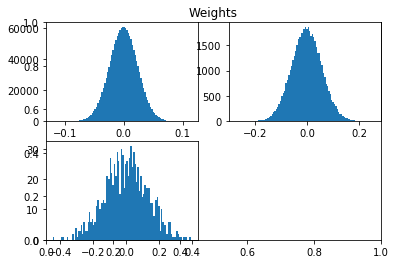

dW 0 Mean -0.0105861857819 SD 0.101075985436
dW 1 Mean -0.00582805172894 SD 0.253350515856
dW 2 Mean -1.42108547152e-17 SD 1.58289476329


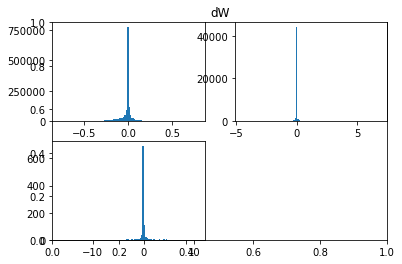

Biases 0 Mean 0.0991525745436 SD 0.00254121807481
Biases 1 Mean 0.0962010732074 SD 0.00680058177501
Biases 2 Mean 0.1 SD 0.0477875443997


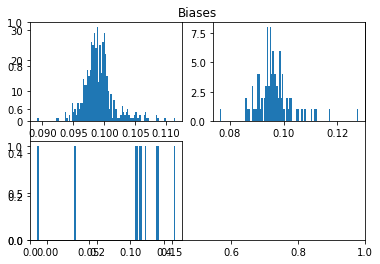

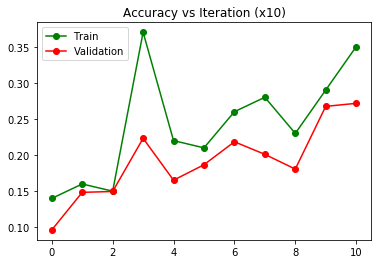

[3 5 8 9 8 7 9 3 5 5 0 1 1 0 0 9 9 9 0 5 3 8 5 5 5 9 5 8 8 9 3 5 5 8 5 9 9
 1 3 8 5 3 5 1 9 3 0 9 1 9 9 7 9 3 5 3 7 3 9 3 0 5 9 3 5 6 7 7 9 5 5 9 9 5
 1 9 5 9 5 5 5 9 3 9 5 6 9 0 0 9 3 7 0 5 9 9 5 5 8 3]
[ 9  6  0 15  0 27  2  6  8 27]
[5 1 5 ..., 5 5 5]
[ 442  277   12  466    7 1449  170  324  471 1382]
cost: 26.40976131569916, train accuracy: 0.23, validation accuracy: 0.2526
iterations finished: 111 alpha: 0.001 reg. lambda: 0.0


[0 9 4 6 7 2 9 5 0 9 8 4 0 8 4 5 8 8 0 4 2 9 2 5 8 2 6 8 5 8 0 5 5 8 9 4 8
 9 9 9 0 8 9 6 9 9 4 6 4 0 0 6 9 6 0 9 1 0 6 4 0 5 1 0 6 6 6 9 9 8 6 0 4 9
 9 0 0 9 9 6 9 5 2 4 9 5 8 5 8 4 8 8 9 9 9 5 5 6 6 0]
[16  2  5  0 11 12 14  1 15 24]
[5 8 8 ..., 8 5 6]
[801 306  98   7 484 755 756  30 965 798]
cost: 25.191713092745385, train accuracy: 0.33, validation accuracy: 0.2886
iterations finished: 121 alpha: 0.001 reg. lambda: 0.0


[9 5 5 5 5 9 0 5 5 5 9 5 6 5 8 9 9 5 7 0 0 8 1 8 7 5 5 5 5 5 5 5 5 5 5 9 0
 5 8 5 5 9 9 9 1 7 9 9 5 5 5 5 1 8 5 9 5 5 1 5 9 5 5 1 0

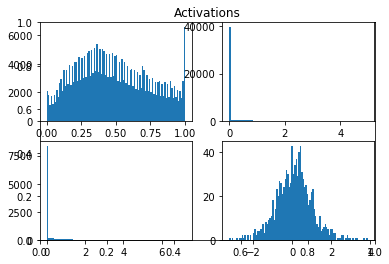

[1 6 1 1 4 7 1 7 6 0 3 0 9 7 3 7 6 0 1 5 1 1 7 1 0 7 7 0 9 5 3 4 0 7 4 8 8
 8 9 0 1 7 8 4 5 1 5 9 4 6 9 0 0 9 0 8 4 7 5 9 9 1 5 4 4 7 1 4 6 5 5 9 5 7
 8 7 4 0 1 0 8 4 9 0 4 7 7 6 8 8 7 3 0 5 4 5 0 7 1 7]
[15 14  0  4 13 11  6 18  9 10]
[5 1 6 ..., 5 3 6]
[552 585  28 297 421 588 647 915 648 319]
cost: 27.03555558663668, train accuracy: 0.32, validation accuracy: 0.3354
iterations finished: 201 alpha: 0.001 reg. lambda: 0.0


Weights 0 Mean -0.000503348144356 SD 0.0237320698122
Weights 1 Mean -0.00167661239083 SD 0.0579855542283
Weights 2 Mean 0.000786497118276 SD 0.131634046251


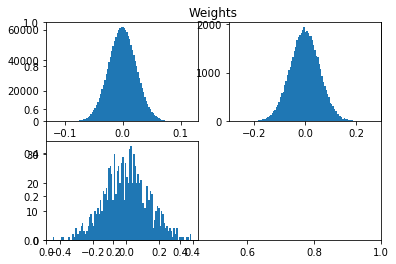

dW 0 Mean -0.002648641449 SD 0.0692511391268
dW 1 Mean -0.010681519899 SD 0.193931556491
dW 2 Mean 0.0 SD 1.05433334631


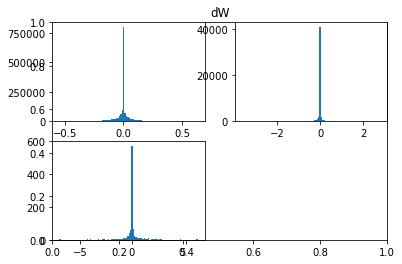

Biases 0 Mean 0.0991905636122 SD 0.00428266748178
Biases 1 Mean 0.0962414305452 SD 0.011166678599
Biases 2 Mean 0.1 SD 0.0740234000402


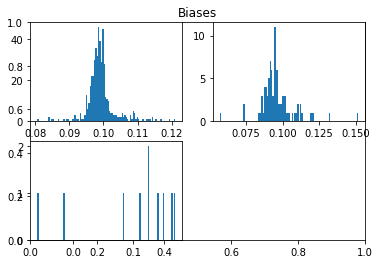

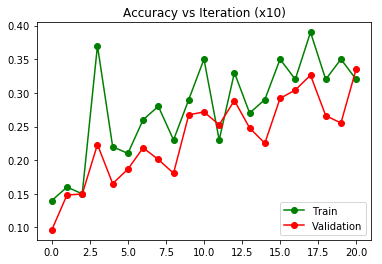

[0 2 5 7 2 0 0 1 7 1 0 0 7 0 6 0 0 2 7 2 4 2 7 1 0 7 1 7 0 5 0 7 7 5 7 2 7
 6 9 1 7 5 2 0 7 8 0 2 7 9 7 9 9 7 4 1 8 7 0 0 0 9 7 5 9 7 9 0 0 9 9 8 7 2
 0 0 7 0 8 4 1 8 7 0 0 0 9 2 0 2 7 1 0 9 2 0 2 1 6 2]
[27  9 14  0  3  5  3 23  5 11]
[2 8 2 ..., 1 2 2]
[1079  304  670    1  131  142  203 1471  159  840]
cost: 27.24637166151759, train accuracy: 0.41, validation accuracy: 0.28
iterations finished: 211 alpha: 0.001 reg. lambda: 0.0


[3 6 8 0 6 7 1 0 7 1 7 6 0 8 6 6 1 9 8 7 6 8 7 4 7 1 5 9 6 0 4 6 7 1 7 7 6
 8 9 7 9 9 0 7 7 7 1 2 7 4 8 0 6 0 1 7 5 0 7 7 6 1 7 7 1 7 4 7 7 1 9 8 5 9
 4 7 0 7 0 6 7 0 9 7 9 8 0 9 6 5 4 3 9 1 8 0 8 1 5 7]
[13 12  1  2  6  5 13 27 10 11]
[6 1 2 ..., 1 4 6]
[ 530  568   53   10  208  308  728 1410  521  664]
cost: 27.215968159566497, train accuracy: 0.33, validation accuracy: 0.3216
iterations finished: 221 alpha: 0.001 reg. lambda: 0.0


[5 6 9 5 7 8 6 8 9 3 7 9 1 0 8 1 6 8 8 7 6 5 9 7 3 8 9 0 1 8 6 5 8 9 1 5 5
 6 1 8 9 9 5 1 6 7 8 5 9 6 4 5 5 0 6 5 8 7 8 9 6

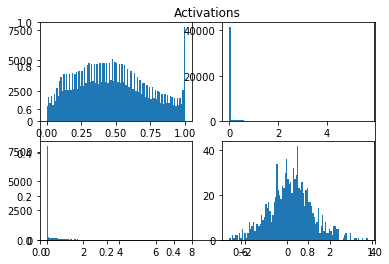

[7 1 7 6 1 9 8 8 8 8 8 5 7 7 8 1 0 7 7 6 6 9 8 8 9 7 8 4 8 8 9 1 8 7 1 1 7
 8 7 9 3 7 6 1 0 7 8 9 9 8 8 9 9 0 9 6 8 2 9 0 7 7 8 7 7 7 6 0 9 3 1 6 4 8
 6 9 6 8 4 7 7 7 7 7 4 7 4 7 0 1 1 7 3 8 7 0 9 7 9 6]
[ 7 10  1  3  5  1 10 27 21 15]
[6 1 6 ..., 7 7 6]
[ 361  666   54   46  538  175  577 1224  821  538]
cost: 27.70438678349302, train accuracy: 0.35, validation accuracy: 0.3378
iterations finished: 301 alpha: 0.001 reg. lambda: 0.0


Weights 0 Mean -0.000551505152394 SD 0.0237742614593
Weights 1 Mean -0.00174896025651 SD 0.0580798886115
Weights 2 Mean 0.000786497118276 SD 0.133078670563


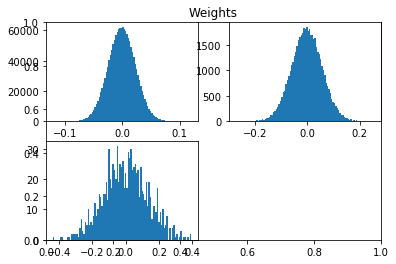

dW 0 Mean -0.00283441072853 SD 0.124524721439
dW 1 Mean -0.0165386028175 SD 0.291609016779
dW 2 Mean -7.1054273576e-18 SD 1.63523690042


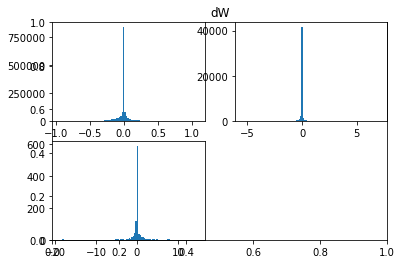

Biases 0 Mean 0.0992355589665 SD 0.00613918037902
Biases 1 Mean 0.0967449433202 SD 0.0155592720098
Biases 2 Mean 0.1 SD 0.0913761373777


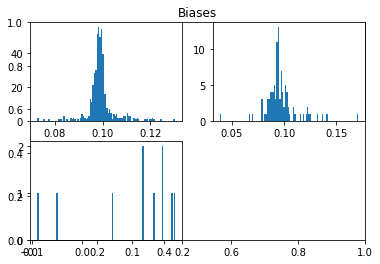

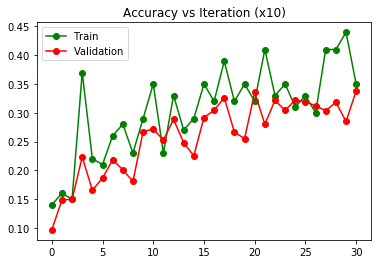

[8 7 7 9 4 7 4 4 9 9 9 9 6 4 7 7 4 9 5 4 4 0 7 7 7 7 6 7 9 7 7 7 4 7 9 9 7
 7 6 8 7 9 4 4 4 9 6 9 4 6 4 1 4 6 7 6 7 4 9 9 9 9 4 1 9 0 4 9 7 6 4 8 9 8
 7 7 6 6 4 8 0 9 8 4 7 7 8 1 9 5 7 1 8 2 7 9 4 9 1 5]
[ 3  5  1  0 21  3 10 26  8 23]
[6 8 6 ..., 5 4 4]
[ 166   54   39   61  937  340  847  896  504 1156]
cost: 27.61660016707187, train accuracy: 0.4, validation accuracy: 0.3038
iterations finished: 311 alpha: 0.001 reg. lambda: 0.0


[5 5 9 9 8 9 3 1 9 3 3 9 3 8 9 8 8 8 8 9 0 9 7 9 1 9 8 7 5 0 3 7 5 9 7 5 8
 3 5 8 0 8 2 2 9 1 7 1 8 8 7 3 9 5 8 3 5 6 7 7 0 9 0 9 0 3 9 0 6 9 9 2 5 6
 1 9 8 3 7 8 5 8 9 8 9 5 7 8 8 9 5 3 9 9 0 8 1 3 9 7]
[ 8  6  3 12  0 12  3 11 20 25]
[5 8 9 ..., 5 5 5]
[ 262  400  118  451    9  668  404  398 1188 1102]
cost: 28.030135144361, train accuracy: 0.38, validation accuracy: 0.3038
iterations finished: 321 alpha: 0.001 reg. lambda: 0.0


[0 6 5 2 5 2 6 8 2 1 6 0 2 3 0 5 1 0 1 7 3 4 1 5 2 7 6 8 1 1 2 6 6 5 0 9 6
 1 8 2 3 8 6 5 5 0 2 0 2 8 5 6 5 1 2 8 2 5 7 2 4 1

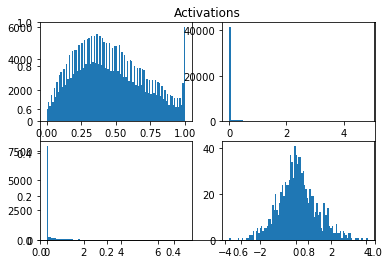

[2 7 7 4 7 8 7 8 5 3 7 1 6 1 9 0 4 8 8 0 7 8 6 6 4 0 4 8 7 9 6 7 8 9 8 2 4
 1 6 3 6 8 1 9 6 0 1 1 8 7 7 9 7 4 7 9 4 6 7 5 7 8 7 9 7 6 4 6 8 7 5 1 9 4
 6 6 8 7 8 7 7 7 7 6 4 8 8 1 9 6 5 7 7 6 8 8 8 4 6 6]
[ 4  8  2  2 11  4 17 24 19  9]
[6 1 6 ..., 5 5 6]
[293 446 278  45 308 347 682 992 985 624]
cost: 28.79083707934381, train accuracy: 0.42, validation accuracy: 0.364
iterations finished: 401 alpha: 0.001 reg. lambda: 0.0


Weights 0 Mean -0.000565042973137 SD 0.0238180159358
Weights 1 Mean -0.00178672797594 SD 0.0581737744908
Weights 2 Mean 0.000786497118276 SD 0.134464248136


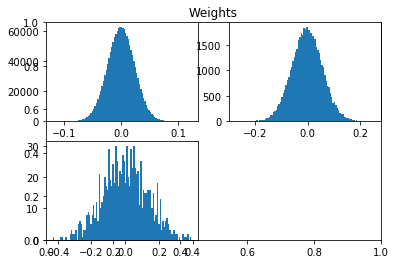

dW 0 Mean -0.000206838627489 SD 0.0987744596394
dW 1 Mean 0.00595653544468 SD 0.24327496104
dW 2 Mean -7.1054273576e-18 SD 1.54027880267


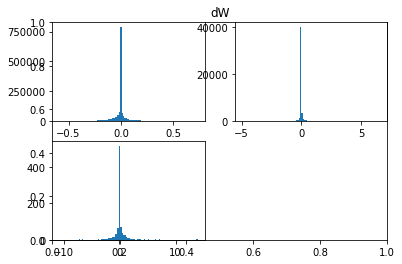

Biases 0 Mean 0.0992892229919 SD 0.00806380664783
Biases 1 Mean 0.0974458572261 SD 0.0205679320408
Biases 2 Mean 0.1 SD 0.10909863282


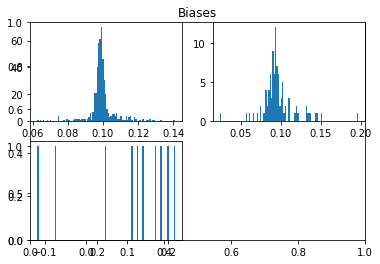

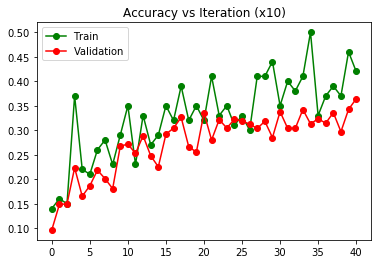

[4 3 6 3 0 1 3 1 4 9 9 2 2 6 0 8 1 2 3 9 3 5 6 6 6 9 1 1 0 6 9 3 6 8 7 3 9
 9 9 9 4 3 9 5 3 6 2 1 2 6 3 7 0 9 1 8 6 1 8 6 2 4 7 9 9 4 2 1 5 6 7 6 3 3
 5 9 3 9 2 3 8 0 2 8 6 9 3 6 1 9 9 3 3 6 3 6 3 3 4 6]
[ 5 10  9 20  6  4 18  4  6 18]
[6 1 6 ..., 5 3 6]
[ 150  538  442  634  344  419 1038  210  362  863]
cost: 30.02027281796203, train accuracy: 0.39, validation accuracy: 0.3418
iterations finished: 411 alpha: 0.001 reg. lambda: 0.0


[3 3 6 6 5 8 9 6 5 9 7 6 6 7 1 6 9 7 8 5 7 1 1 6 9 1 5 6 9 6 7 1 6 9 9 6 7
 6 6 6 5 7 5 1 6 1 5 7 1 5 6 1 1 6 1 6 5 5 5 6 1 6 0 6 6 6 4 6 7 7 9 1 7 6
 9 7 9 9 9 7 7 4 6 7 7 5 9 6 7 9 7 7 5 7 1 7 5 5 7 6]
[ 1 14  0  2  2 15 28 22  2 14]
[6 1 6 ..., 5 5 6]
[ 209  637    6  104   61  624 1413 1048  149  749]
cost: 29.184454527963208, train accuracy: 0.38, validation accuracy: 0.3166
iterations finished: 421 alpha: 0.001 reg. lambda: 0.0


[3 3 4 0 2 9 2 3 2 9 0 0 0 4 8 1 0 2 8 8 8 4 7 0 1 0 1 2 8 3 9 3 1 8 1 8 6
 7 7 2 8 3 1 4 6 8 9 2 5 4 8 1 4 3 4 8 3 4 3 4

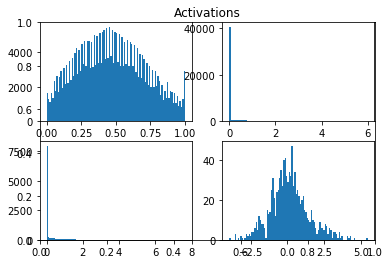

[6 6 5 6 6 3 3 9 6 2 6 9 1 9 6 6 9 6 9 6 1 3 3 6 8 6 9 1 6 6 1 5 6 8 3 1 5
 6 0 5 6 9 6 1 6 9 6 9 5 3 3 6 1 8 6 4 9 5 0 3 1 6 9 9 8 6 3 9 5 0 3 3 9 6
 5 9 1 9 5 9 3 8 6 5 5 6 6 9 1 4 0 5 9 3 6 0 8 6 6 9]
[ 5 10  1 13  2 12 31  0  6 20]
[6 1 6 ..., 5 3 6]
[ 205  615   33  641  177  340 1632  136  303  918]
cost: 30.66335356586552, train accuracy: 0.34, validation accuracy: 0.319
iterations finished: 501 alpha: 0.0009000000000000001 reg. lambda: 0.0


Weights 0 Mean -0.00055672255684 SD 0.0238612565486
Weights 1 Mean -0.00181475128122 SD 0.0582527849906
Weights 2 Mean 0.000786497118276 SD 0.135434367251


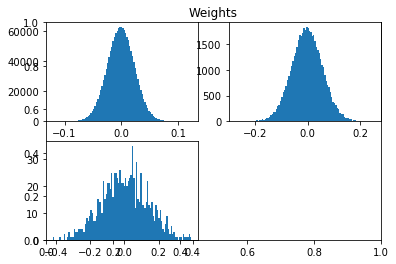

dW 0 Mean 0.0118092850473 SD 0.174277614672
dW 1 Mean 0.00994454952878 SD 0.462620240561
dW 2 Mean 5.68434188608e-17 SD 2.54348053634


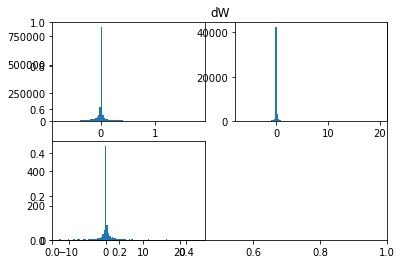

Biases 0 Mean 0.0993524452719 SD 0.00992685584899
Biases 1 Mean 0.098060458793 SD 0.0252645011561
Biases 2 Mean 0.1 SD 0.124922899085


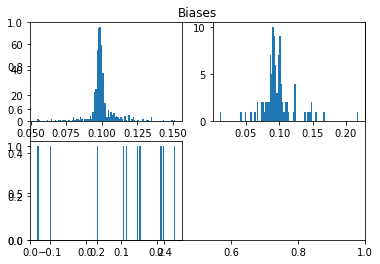

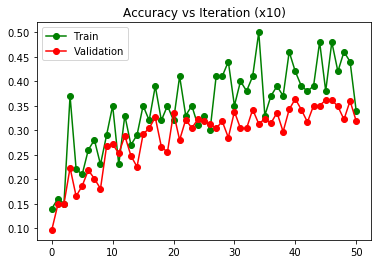

[6 0 3 3 4 0 1 7 6 6 6 4 9 4 8 8 2 6 8 0 0 1 6 0 6 6 4 5 3 1 3 6 8 6 0 1 0
 7 0 3 9 8 3 6 8 8 3 0 1 9 3 7 6 8 7 7 2 8 1 3 4 7 1 4 2 5 9 6 4 3 3 2 4 8
 6 9 8 7 9 4 8 1 6 1 6 5 5 3 2 0 0 3 5 4 7 6 7 7 5 3]
[11  9  5 14 10  6 17 10 12  6]
[6 1 6 ..., 5 3 6]
[ 317  382  116  609  333  225 1352  514  785  367]
cost: 28.816188353120474, train accuracy: 0.33, validation accuracy: 0.3684
iterations finished: 511 alpha: 0.0009000000000000001 reg. lambda: 0.0


[2 3 6 1 1 2 8 1 6 7 2 1 7 8 8 1 8 6 7 1 5 1 6 8 2 8 7 3 8 1 8 7 4 1 2 3 5
 1 1 7 0 2 9 4 1 1 5 6 6 4 7 5 7 8 3 1 8 1 2 1 5 5 2 8 8 3 1 4 6 3 2 1 1 3
 7 1 0 3 1 3 1 1 0 7 8 1 7 6 9 2 1 1 3 2 8 3 7 8 1 1]
[ 3 28 11 11  4  6  8 12 15  2]
[6 1 7 ..., 5 1 6]
[ 262 1183  387  387  273  289  576  450 1024  169]
cost: 29.89799149913678, train accuracy: 0.42, validation accuracy: 0.3636
iterations finished: 521 alpha: 0.0009000000000000001 reg. lambda: 0.0


[0 2 4 5 5 6 5 3 3 0 6 3 0 5 5 5 5 5 9 1 5 5 5 5 0 6 0 1 9 4 5 7 5 0 5 5 5
 4 6 7 0 7 5 5

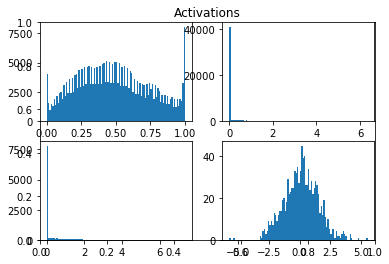

[5 7 9 6 8 4 5 6 0 7 1 1 7 6 0 2 2 0 8 8 1 6 9 7 0 0 1 1 5 1 0 4 7 7 8 9 6
 1 6 1 1 1 0 1 6 6 2 8 2 1 7 7 8 0 2 5 1 8 1 7 6 4 6 1 2 6 0 4 1 8 7 2 8 0
 0 7 8 7 4 1 0 1 1 8 1 0 0 6 8 2 8 9 7 7 6 7 1 3 1 8]
[14 22  8  1  5  4 13 15 14  4]
[6 1 6 ..., 6 4 6]
[570 842 719  92 443  96 599 665 573 401]
cost: 31.276550579142178, train accuracy: 0.52, validation accuracy: 0.3758
iterations finished: 601 alpha: 0.0009000000000000001 reg. lambda: 0.0


Weights 0 Mean -0.000552375687567 SD 0.0238988705144
Weights 1 Mean -0.00181469899185 SD 0.0583574293124
Weights 2 Mean 0.000786497118276 SD 0.137046495033


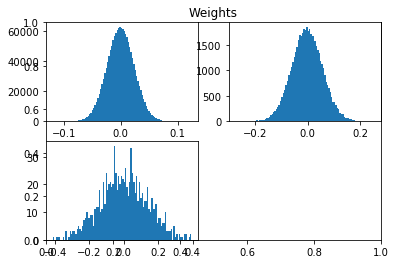

dW 0 Mean -0.00317688145039 SD 0.149828998235
dW 1 Mean -0.00221222775001 SD 0.44991564343
dW 2 Mean 0.0 SD 2.62611329117


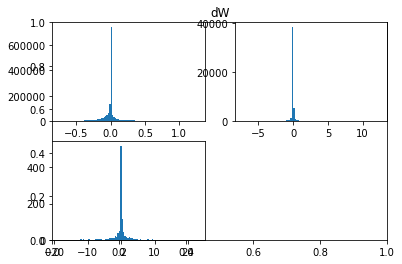

Biases 0 Mean 0.0993751954109 SD 0.0114525992415
Biases 1 Mean 0.0990019440746 SD 0.0292940033615
Biases 2 Mean 0.1 SD 0.138788119558


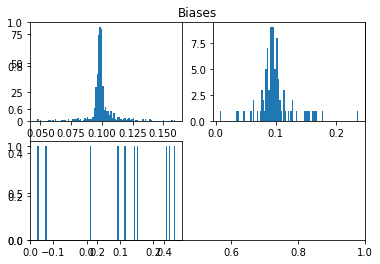

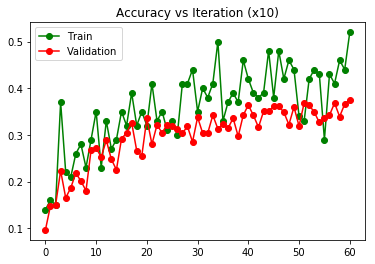

[3 7 6 5 2 6 2 7 6 2 6 6 6 9 7 8 8 6 1 9 6 9 8 1 0 9 2 8 9 9 8 3 2 2 9 8 9
 2 2 2 9 5 9 6 8 6 8 6 8 5 6 6 1 6 0 8 2 8 9 9 6 8 6 6 6 9 6 7 1 9 8 6 0 2
 8 2 2 6 6 6 6 9 8 5 6 1 6 6 6 6 6 8 6 6 1 5 9 9 6 6]
[ 3  6 13  2  0  5 34  4 16 17]
[6 1 6 ..., 6 2 6]
[ 191  364  594  209  129  227 1587  282  714  703]
cost: 28.75329903784297, train accuracy: 0.45, validation accuracy: 0.3598
iterations finished: 611 alpha: 0.0009000000000000001 reg. lambda: 0.0


[7 4 8 0 0 6 7 6 0 2 6 6 5 8 8 0 5 8 5 8 9 0 3 2 5 7 5 8 5 2 9 6 0 5 0 5 0
 5 9 5 7 6 4 0 0 3 0 0 8 5 0 8 9 0 9 2 2 5 0 5 0 3 0 0 4 3 5 1 5 9 9 5 5 5
 0 9 2 9 2 8 5 7 5 7 4 2 5 0 0 5 0 5 3 6 3 0 9 6 1 8]
[23  2  8  6  4 23  8  6 10 10]
[5 1 2 ..., 5 5 2]
[ 814  223  601  304  190 1032  388  309  548  591]
cost: 31.164474070173657, train accuracy: 0.45, validation accuracy: 0.372
iterations finished: 621 alpha: 0.0009000000000000001 reg. lambda: 0.0


[0 1 0 5 1 6 0 8 5 4 8 9 6 3 6 0 0 8 2 0 8 6 9 0 4 0 8 8 8 6 8 8 0 0 1 6 8
 2 4 7 9 9 2 1 

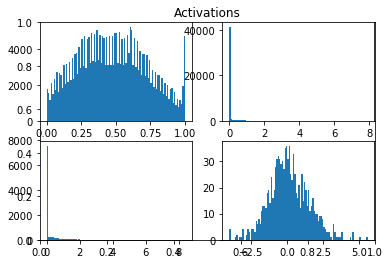

[1 6 5 7 2 1 9 2 2 0 2 9 7 1 1 1 5 9 1 2 5 2 7 7 6 5 7 1 7 4 7 6 1 1 5 2 5
 5 1 8 2 6 2 6 8 4 6 1 3 6 8 1 4 1 6 7 2 5 4 6 1 1 1 7 6 1 7 4 7 8 8 2 5 1
 2 5 8 6 1 5 1 8 5 9 1 8 1 2 2 2 2 6 5 0 1 2 2 3 5 1]
[ 2 24 18  2  5 14 12 11  8  4]
[6 1 6 ..., 5 5 6]
[ 136  942 1183   93  270  772  554  578  259  213]
cost: 30.97253171691566, train accuracy: 0.47, validation accuracy: 0.3568
iterations finished: 701 alpha: 0.0009000000000000001 reg. lambda: 0.0


Weights 0 Mean -0.000571946303387 SD 0.0239359151689
Weights 1 Mean -0.00184809025844 SD 0.0584544009762
Weights 2 Mean 0.000786497118276 SD 0.138386654222


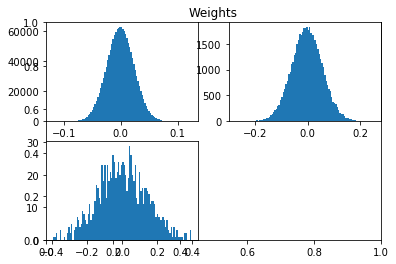

dW 0 Mean 0.00641726002804 SD 0.164487106772
dW 1 Mean 0.0208644449043 SD 0.450915935228
dW 2 Mean 1.42108547152e-17 SD 2.46531586065


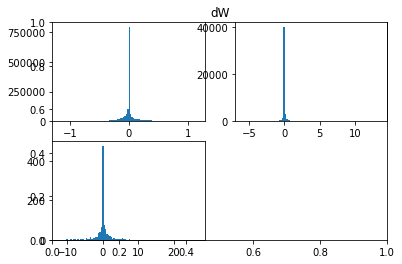

Biases 0 Mean 0.0993554682056 SD 0.0130458017971
Biases 1 Mean 0.0996989858919 SD 0.0337038542214
Biases 2 Mean 0.1 SD 0.152813848489


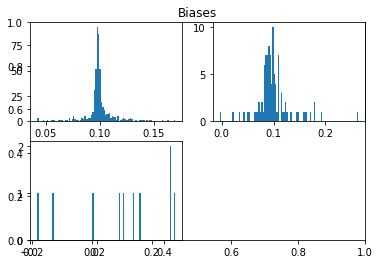

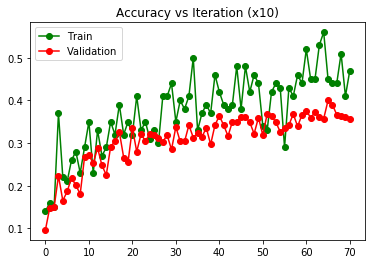

[0 1 8 8 0 2 5 3 0 5 2 8 7 2 4 4 3 5 9 6 7 1 3 8 8 3 2 8 7 0 5 8 3 2 7 9 0
 3 0 3 4 8 8 0 3 3 8 3 1 3 8 5 7 4 6 7 0 0 6 8 3 0 3 3 1 0 0 8 3 8 3 0 8 9
 9 0 9 2 8 3 0 3 9 3 8 8 3 9 1 0 1 0 0 3 0 0 6 3 7 8]
[20  6  6 22  4  5  4  7 19  7]
[3 1 2 ..., 3 0 6]
[1031  597  279  780  254  200  280  532  741  306]
cost: 32.48743719342223, train accuracy: 0.41, validation accuracy: 0.3686
iterations finished: 711 alpha: 0.0009000000000000001 reg. lambda: 0.0


[3 4 6 9 6 9 6 9 7 3 4 7 7 6 9 7 8 6 7 0 9 4 7 7 9 4 6 2 6 4 9 7 4 7 4 1 4
 4 4 2 3 2 6 1 5 9 4 4 6 9 0 7 2 9 4 3 7 9 9 7 7 9 9 1 9 4 6 6 7 4 9 9 7 0
 6 4 9 9 8 4 2 9 4 7 4 9 4 7 1 7 5 9 3 9 8 0 3 4 0 9]
[ 5  4  5  6 21  2 12 18  3 24]
[6 1 7 ..., 2 4 6]
[ 376  441  160  211  834   81  402 1150  329 1016]
cost: 31.6584715729035, train accuracy: 0.44, validation accuracy: 0.3622
iterations finished: 721 alpha: 0.0009000000000000001 reg. lambda: 0.0


[2 7 1 7 2 7 7 1 1 7 7 8 5 1 9 1 3 7 9 4 7 6 8 6 6 9 7 6 3 7 6 6 5 0 8 0 3
 8 1 1 5 0 9 5 8

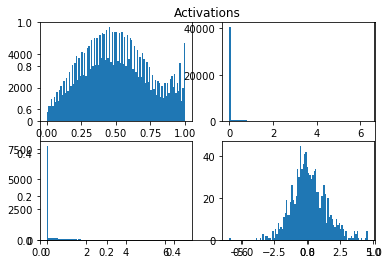

[5 2 2 2 7 7 5 0 2 7 4 5 0 2 7 2 2 4 2 0 4 2 3 2 2 2 7 7 6 0 7 8 2 4 4 7 2
 2 2 7 4 5 0 4 7 2 9 8 0 2 2 2 8 7 7 2 4 2 2 0 2 4 2 7 0 0 3 2 2 2 6 2 2 2
 4 7 7 8 7 6 2 7 2 7 1 7 2 0 2 2 2 2 0 4 0 7 0 0 4 5]
[14  1 38  2 12  5  3 20  4  1]
[5 7 6 ..., 5 4 2]
[ 561   62 1802  156  525  483  234  871  108  198]
cost: 30.867078769898164, train accuracy: 0.43, validation accuracy: 0.283
iterations finished: 801 alpha: 0.0009000000000000001 reg. lambda: 0.0


Weights 0 Mean -0.00058232603525 SD 0.0239769690908
Weights 1 Mean -0.00193933156187 SD 0.0585468855679
Weights 2 Mean 0.000786497118276 SD 0.139519630691


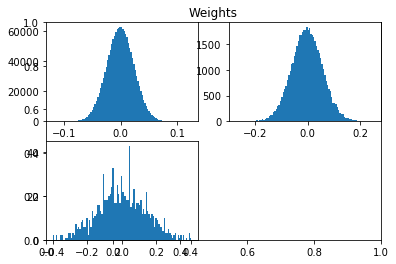

dW 0 Mean 0.0229618828778 SD 0.293933808783
dW 1 Mean 0.0259138593589 SD 0.57977357101
dW 2 Mean -4.26325641456e-17 SD 2.27117952095


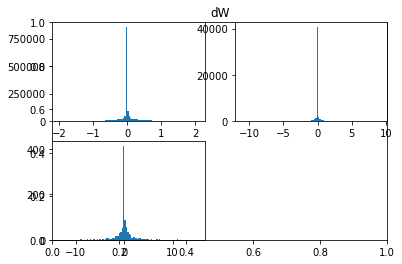

Biases 0 Mean 0.0993536104791 SD 0.014270651361
Biases 1 Mean 0.100153139931 SD 0.0372418074316
Biases 2 Mean 0.1 SD 0.159582876053


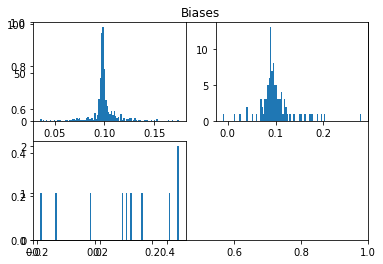

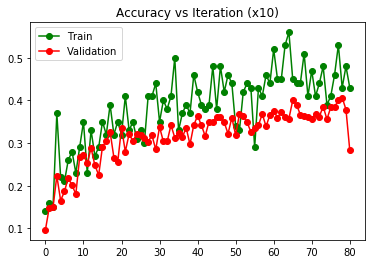

[8 6 6 1 6 8 6 9 5 4 1 6 9 2 1 1 4 8 0 9 7 0 9 9 6 6 6 1 6 9 6 6 3 6 6 6 0
 6 6 6 6 6 6 4 6 6 9 6 6 8 8 6 1 6 3 7 9 0 7 6 6 2 6 8 3 6 8 6 6 9 1 4 6 6
 1 0 3 3 8 6 6 9 1 6 6 9 9 1 6 2 6 8 6 3 6 6 8 0 9 1]
[ 6 11  3  6  4  1 43  3 10 13]
[6 1 6 ..., 6 6 6]
[ 310  481  293  294  121  100 1709  393  658  641]
cost: 29.134271211883647, train accuracy: 0.52, validation accuracy: 0.3706
iterations finished: 811 alpha: 0.0009000000000000001 reg. lambda: 0.0


[3 9 3 6 5 8 0 1 1 9 8 6 9 9 6 3 1 8 0 8 1 8 9 1 3 3 3 8 6 1 8 1 4 5 1 9 7
 1 9 8 3 3 3 8 9 0 3 1 0 9 1 1 2 1 0 3 3 9 6 1 5 0 1 4 9 5 3 3 0 3 3 8 9 8
 1 3 8 9 3 8 2 6 0 6 9 1 9 9 8 6 9 1 8 8 6 1 3 9 9 0]
[ 9 19  2 19  2  4  9  1 16 19]
[6 1 6 ..., 5 3 6]
[ 438  738  126 1112   82  222  704  226  681  671]
cost: 29.539094188389818, train accuracy: 0.54, validation accuracy: 0.3632
iterations finished: 821 alpha: 0.0009000000000000001 reg. lambda: 0.0


[7 0 8 8 4 0 8 3 8 0 9 9 0 1 6 0 0 7 3 6 9 0 8 4 6 5 9 4 6 6 5 6 9 6 6 5 3
 0 1 6 6 2 3 

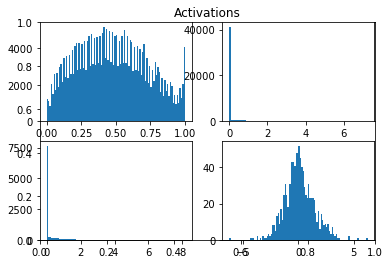

[6 3 3 6 7 0 8 3 5 5 5 0 4 9 0 6 6 6 0 0 1 6 3 9 9 6 4 3 0 2 9 6 6 2 3 1 9
 5 6 6 8 0 3 7 2 5 0 4 7 2 8 6 3 2 3 8 8 7 2 6 8 3 0 4 6 2 4 1 5 2 5 5 3 9
 4 9 8 9 4 6 4 7 4 0 2 6 0 9 7 0 0 1 0 7 2 0 0 6 6 4]
[16  4 10 11 10  8 18  7  7  9]
[6 1 6 ..., 5 3 6]
[614 163 507 518 422 344 852 460 617 503]
cost: 30.9371191814267, train accuracy: 0.5, validation accuracy: 0.4014
iterations finished: 901 alpha: 0.0009000000000000001 reg. lambda: 0.0


Weights 0 Mean -0.000592271201872 SD 0.0240146208577
Weights 1 Mean -0.00194840078525 SD 0.0586460549204
Weights 2 Mean 0.000786497118276 SD 0.140800076175


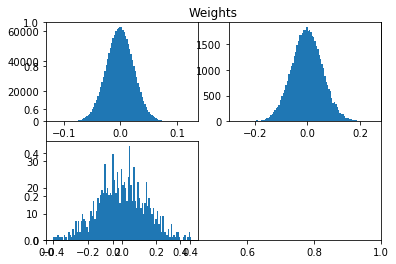

dW 0 Mean 0.00824268981973 SD 0.199890014036
dW 1 Mean 0.00695010286407 SD 0.434325708382
dW 2 Mean -2.84217094304e-17 SD 2.38603206046


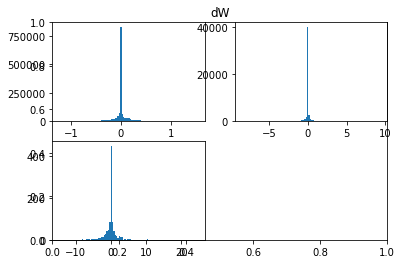

Biases 0 Mean 0.0992728642366 SD 0.0156474219856
Biases 1 Mean 0.101126362748 SD 0.0412440084298
Biases 2 Mean 0.1 SD 0.169196505481


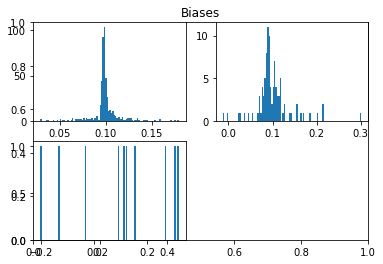

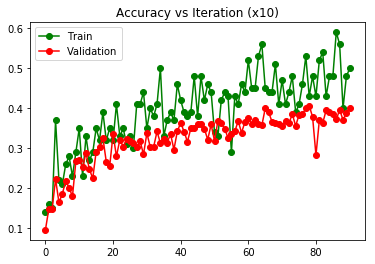

[8 4 3 7 2 7 9 9 9 6 2 4 0 6 4 6 7 9 8 8 0 7 0 6 7 9 8 4 9 9 3 0 3 8 3 3 2
 6 9 3 3 7 3 2 6 3 0 1 0 9 4 4 0 2 9 7 2 0 5 7 4 7 9 9 7 3 3 7 7 8 0 7 6 2
 0 7 1 9 3 9 6 5 9 3 3 9 9 4 8 8 7 2 1 2 3 3 7 2 3 9]
[10  3 10 17  8  2  8 16  8 18]
[6 1 7 ..., 5 3 6]
[400 274 471 592 184 262 541 944 533 799]
cost: 29.188876185076847, train accuracy: 0.44, validation accuracy: 0.3958
iterations finished: 911 alpha: 0.0009000000000000001 reg. lambda: 0.0


[5 3 5 8 7 5 6 0 7 7 8 2 7 7 5 7 5 8 7 7 6 0 3 6 7 8 2 5 5 1 9 8 5 7 0 8 3
 8 7 0 7 5 3 3 7 8 7 1 3 8 7 5 3 5 8 0 3 0 3 8 5 9 9 6 9 0 9 2 7 3 7 8 5 6
 5 5 7 6 5 8 7 9 7 5 2 2 7 8 7 8 3 8 9 9 8 8 2 2 3 9]
[ 7  2  7 12  0 17  6 22 18  9]
[6 1 7 ..., 5 8 6]
[ 532  190  295  436  159  466  356 1161  889  516]
cost: 32.72515892718443, train accuracy: 0.38, validation accuracy: 0.3838
iterations finished: 921 alpha: 0.0009000000000000001 reg. lambda: 0.0


[3 9 8 9 0 3 4 1 9 2 6 4 7 5 8 5 9 4 5 2 5 8 8 4 7 9 9 5 6 5 8 8 4 8 4 4 6
 9 7 6 4 9 9 8 9 8 9 7 5

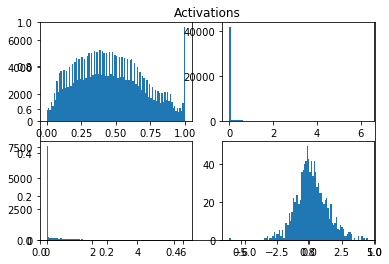

[6 8 7 9 6 0 6 9 9 8 6 6 7 9 7 4 0 7 6 6 6 2 6 1 3 3 8 7 6 6 7 8 8 6 6 6 9
 0 2 8 2 9 6 6 7 6 7 3 3 5 6 2 0 6 3 0 2 6 5 9 6 8 7 6 5 6 8 8 4 4 9 3 9 0
 1 0 6 6 6 6 6 9 4 3 6 3 9 3 6 6 9 1 3 9 6 9 6 6 2 7]
[ 7  3  6 10  4  3 34 10  9 14]
[6 8 6 ..., 5 3 6]
[ 480  175  182  443  376  143 1437  433  710  621]
cost: 29.890657134662707, train accuracy: 0.49, validation accuracy: 0.3906
iterations finished: 1001 alpha: 0.0008100000000000001 reg. lambda: 0.0


Weights 0 Mean -0.000609895598952 SD 0.0240522153326
Weights 1 Mean -0.00194650511658 SD 0.0587330445004
Weights 2 Mean 0.000786497118276 SD 0.141702706081


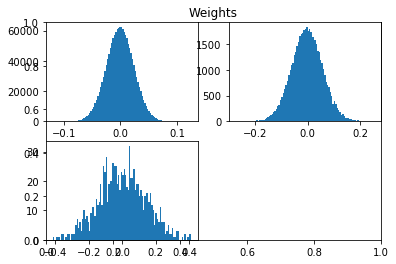

dW 0 Mean -0.0105136730755 SD 0.146712495805
dW 1 Mean -0.00950051778027 SD 0.343907733231
dW 2 Mean -2.84217094304e-17 SD 1.94357676689


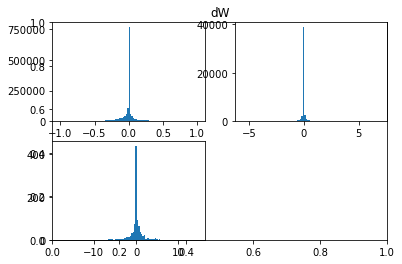

Biases 0 Mean 0.0992749051759 SD 0.0170218198523
Biases 1 Mean 0.102210850293 SD 0.0451425934595
Biases 2 Mean 0.1 SD 0.180901866754


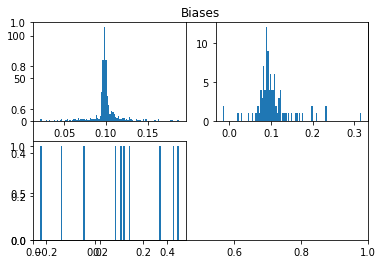

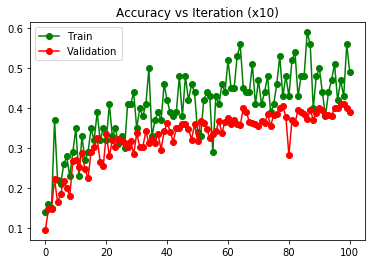

[8 5 8 8 0 0 1 7 6 2 8 8 0 9 4 6 1 4 8 3 4 4 9 6 0 8 7 8 8 0 8 6 1 1 2 1 1
 6 8 5 5 5 6 8 1 4 7 2 5 3 8 7 6 2 8 7 8 8 3 9 6 6 8 8 1 8 8 4 6 5 0 0 8 5
 1 8 6 2 8 0 1 6 1 4 2 4 4 3 6 0 9 1 7 5 2 8 6 8 6 8]
[ 9 12  7  4  9  8 15  6 26  4]
[6 1 6 ..., 5 3 6]
[ 307  614  425  190  405  310 1084  277 1147  241]
cost: 32.76578121526677, train accuracy: 0.46, validation accuracy: 0.388
iterations finished: 1011 alpha: 0.0008100000000000001 reg. lambda: 0.0


[5 6 8 9 6 6 8 4 8 7 7 5 6 6 2 8 7 1 8 6 9 7 0 8 6 0 5 1 8 0 8 3 1 0 1 7 1
 8 6 4 1 6 6 6 0 2 6 8 0 8 9 8 1 0 8 8 4 3 9 8 8 5 9 6 4 1 2 8 1 6 9 4 1 0
 2 5 4 9 1 7 0 1 6 8 2 0 8 2 3 6 4 8 3 8 6 6 6 1 6 3]
[10 13  6  5  7  5 20  6 21  7]
[6 1 0 ..., 5 2 6]
[555 743 473 235 392 153 948 297 800 404]
cost: 31.079441847608393, train accuracy: 0.38, validation accuracy: 0.3924
iterations finished: 1021 alpha: 0.0008100000000000001 reg. lambda: 0.0


[9 7 4 7 8 6 0 8 1 3 0 8 8 3 0 6 4 1 7 8 8 9 4 9 9 5 4 3 8 8 5 3 8 4 1 8 9
 6 8 8 1 0 0 8 8 1 8 6 

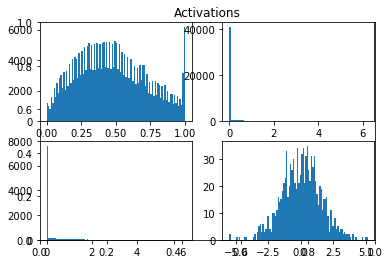

[8 3 8 5 0 8 7 9 2 8 2 1 0 2 3 4 3 6 1 0 7 4 2 2 8 3 1 6 7 0 8 5 1 2 5 0 1
 9 8 3 6 1 1 2 1 8 2 8 2 2 1 1 5 0 2 3 8 5 6 5 8 4 7 2 0 2 5 3 2 5 3 7 1 3
 2 8 1 4 8 2 1 5 0 8 8 3 1 8 7 5 4 2 8 8 2 5 2 2 3 9]
[ 8 14 20 11  5 11  4  6 18  3]
[6 1 6 ..., 5 3 6]
[444 555 755 334 393 563 395 529 704 328]
cost: 32.22608777878674, train accuracy: 0.46, validation accuracy: 0.4194
iterations finished: 1101 alpha: 0.0008100000000000001 reg. lambda: 0.0


Weights 0 Mean -0.000565396584075 SD 0.0240830448717
Weights 1 Mean -0.00197693155059 SD 0.0588333995856
Weights 2 Mean 0.000786497118276 SD 0.143149557308


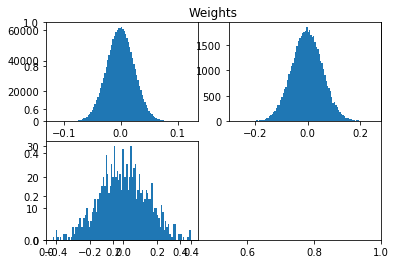

dW 0 Mean -0.00298197514108 SD 0.121509879797
dW 1 Mean -0.01595682595 SD 0.322462617656
dW 2 Mean -4.97379915032e-17 SD 1.50264136502


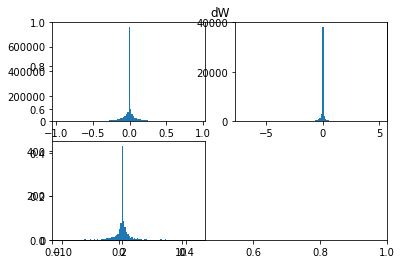

Biases 0 Mean 0.0993503302981 SD 0.018132326886
Biases 1 Mean 0.102926622136 SD 0.0492264302287
Biases 2 Mean 0.1 SD 0.1950486409


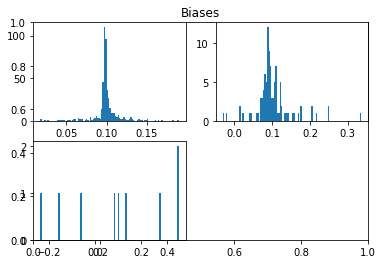

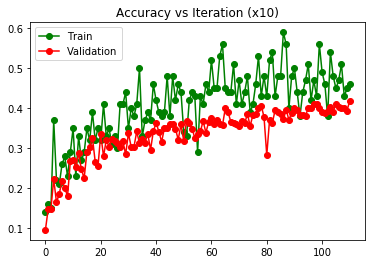

[5 8 1 9 1 6 1 7 9 3 5 0 6 6 7 9 3 5 1 7 7 6 3 3 6 8 6 1 2 0 7 5 6 6 7 6 2
 8 7 1 6 1 6 6 2 8 9 7 6 3 6 7 3 6 1 0 9 7 8 8 9 5 9 0 9 1 7 7 1 8 1 7 4 8
 8 7 7 1 6 4 8 6 8 8 8 7 0 1 6 9 7 6 5 2 7 9 0 2 3 6]
[ 6 13  5  7  2  6 20 18 13 10]
[6 1 7 ..., 5 2 6]
[ 280  886  225  197  164  379 1026  623  791  429]
cost: 33.61291262032472, train accuracy: 0.45, validation accuracy: 0.4044
iterations finished: 1111 alpha: 0.0008100000000000001 reg. lambda: 0.0


[6 8 9 7 2 6 9 2 3 4 8 4 5 8 6 8 7 2 6 8 3 6 6 8 2 6 4 6 8 6 1 6 6 6 6 6 7
 6 6 3 6 3 8 6 2 9 9 6 7 8 6 6 5 8 0 6 8 3 7 5 3 9 6 1 7 8 7 9 8 8 9 6 3 8
 6 6 1 6 2 5 8 6 6 5 6 6 8 9 6 6 8 8 3 8 6 3 7 8 0 1]
[ 2  4  6  9  3  5 34  8 21  8]
[6 8 6 ..., 5 6 6]
[ 259  173  370  326  219  304 1601  259  961  528]
cost: 33.16404808352845, train accuracy: 0.39, validation accuracy: 0.384
iterations finished: 1121 alpha: 0.0008100000000000001 reg. lambda: 0.0


[3 3 8 1 7 5 3 0 5 7 8 6 4 6 0 9 2 3 6 6 2 8 2 1 1 3 6 6 8 8 3 9 1 6 2 7 0
 2 2 4 8 7 4 6

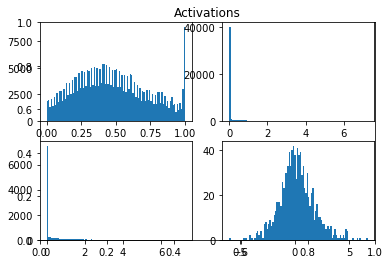

[7 5 5 7 6 9 2 6 2 2 6 6 0 8 8 6 6 5 3 8 6 6 2 7 4 7 7 7 9 6 2 3 9 2 6 6 1
 7 6 6 8 6 6 5 9 0 2 4 5 6 2 5 6 2 8 8 8 6 5 6 7 8 6 0 0 3 6 7 6 5 0 4 8 9
 7 2 2 5 3 6 6 2 6 4 9 5 6 9 2 7 3 0 6 9 8 3 6 6 7 4]
[ 6  1 13  6  5 10 29 12 10  8]
[6 7 6 ..., 5 6 6]
[ 302   87  514  239  267  415 1406  679  731  360]
cost: 33.73347308795034, train accuracy: 0.47, validation accuracy: 0.384
iterations finished: 1201 alpha: 0.0008100000000000001 reg. lambda: 0.0


Weights 0 Mean -0.000587942266953 SD 0.0241144137071
Weights 1 Mean -0.00201145880786 SD 0.0589214148747
Weights 2 Mean 0.000786497118276 SD 0.144177787598


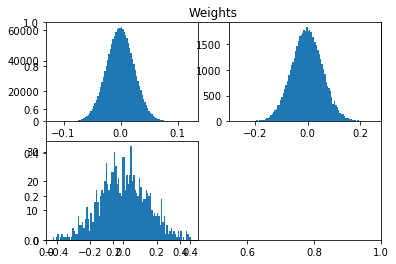

dW 0 Mean 0.0374286637947 SD 0.246110329692
dW 1 Mean 0.0110210306278 SD 0.531399801649
dW 2 Mean 2.84217094304e-17 SD 2.57928786972


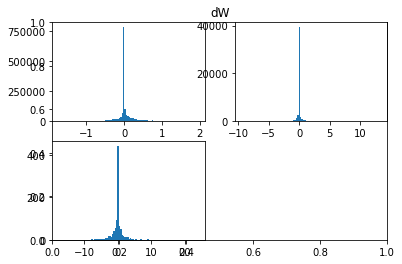

Biases 0 Mean 0.0993635689499 SD 0.0194554005908
Biases 1 Mean 0.103533894314 SD 0.0528749112448
Biases 2 Mean 0.1 SD 0.204612760995


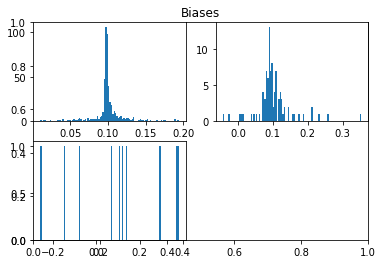

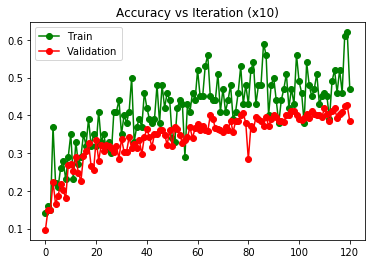

[8 8 8 3 2 2 5 3 8 4 3 2 3 8 2 9 6 5 0 8 2 7 7 8 8 6 7 7 8 2 2 4 8 9 3 8 0
 0 7 8 9 9 4 2 0 4 7 9 8 9 4 4 2 1 8 3 9 8 4 4 2 6 2 8 7 8 6 0 9 8 7 1 7 9
 0 4 8 6 3 6 7 8 9 3 0 7 8 9 5 3 0 3 3 9 8 8 8 6 4 9]
[ 8  2 11 11 10  3  7 11 24 13]
[6 8 7 ..., 5 3 6]
[ 319  293  416  506  679  294  528  456 1010  499]
cost: 34.328332059619484, train accuracy: 0.53, validation accuracy: 0.4194
iterations finished: 1211 alpha: 0.0008100000000000001 reg. lambda: 0.0


[7 1 8 7 1 9 7 6 2 7 2 7 6 6 3 2 5 8 5 8 1 6 9 9 7 3 7 5 3 5 7 2 5 2 2 7 2
 1 6 9 7 6 5 2 6 7 2 4 3 2 6 8 6 5 7 7 7 7 4 6 3 8 6 3 7 6 7 2 0 8 2 6 5 3
 8 1 9 0 7 7 8 8 1 7 2 9 4 9 6 5 2 5 8 6 9 0 2 0 2 7]
[ 4  6 16  7  3 10 15 21 10  8]
[6 1 7 ..., 5 3 6]
[394 287 564 366 341 428 712 801 573 534]
cost: 32.75072779207987, train accuracy: 0.51, validation accuracy: 0.4256
iterations finished: 1221 alpha: 0.0008100000000000001 reg. lambda: 0.0


[9 6 3 9 7 4 6 3 7 6 4 7 6 3 7 3 7 1 0 7 7 6 7 8 3 8 7 7 9 7 7 3 7 7 9 1 7
 9 7 1 6 6 9 0 6 9 4 0

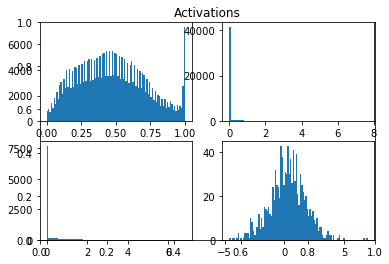

[9 4 3 9 4 3 3 9 8 1 4 9 2 4 7 0 5 9 5 8 4 2 7 6 4 4 9 5 1 3 9 8 7 5 0 4 7
 2 5 9 4 9 8 1 3 9 1 7 0 9 9 9 0 5 2 4 7 5 4 8 9 3 0 7 3 4 8 3 9 4 2 2 2 4
 5 5 4 4 4 2 9 8 8 9 4 9 9 7 2 5 4 9 5 2 4 1 5 7 9 4]
[ 5  5 10  8 21 12  1  9  8 21]
[6 1 7 ..., 5 4 6]
[377 431 545 207 930 577 240 394 474 825]
cost: 32.16792214845995, train accuracy: 0.44, validation accuracy: 0.4104
iterations finished: 1301 alpha: 0.0008100000000000001 reg. lambda: 0.0


Weights 0 Mean -0.000585720357079 SD 0.0241487005219
Weights 1 Mean -0.00201215453382 SD 0.0590203204289
Weights 2 Mean 0.000786497118276 SD 0.145357061802


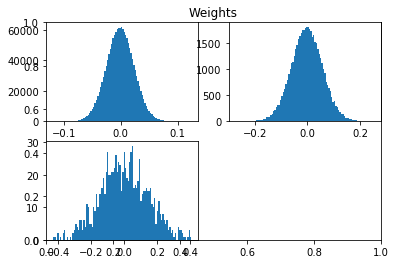

dW 0 Mean -0.00321572223249 SD 0.140575165445
dW 1 Mean -0.00830889333932 SD 0.378890792621
dW 2 Mean 4.26325641456e-17 SD 1.85029570312


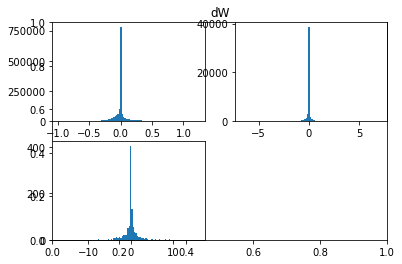

Biases 0 Mean 0.0993736740982 SD 0.0206030403411
Biases 1 Mean 0.104521014598 SD 0.0563269966484
Biases 2 Mean 0.1 SD 0.211263963273


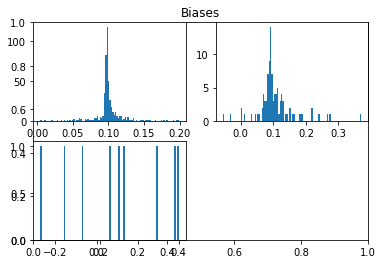

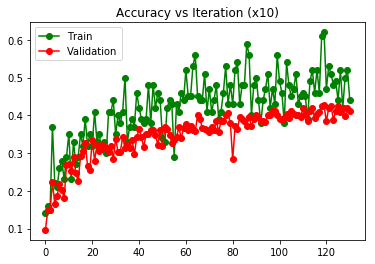

[3 5 5 1 5 5 5 8 8 8 1 1 8 5 6 0 8 3 4 8 8 5 1 5 7 9 1 6 1 7 0 2 0 7 9 5 1
 8 0 0 5 1 5 5 0 5 8 8 4 6 3 5 0 1 1 6 6 8 5 5 1 5 5 1 9 8 5 6 5 7 0 9 1 1
 1 7 3 7 5 4 1 1 7 8 7 7 5 8 5 1 5 5 5 7 5 5 8 0 7 5]
[ 9 18  1  4  3 29  6 11 15  4]
[5 1 7 ..., 5 5 6]
[ 497  918  153  202  144 1141  305  564  618  458]
cost: 31.736735166024427, train accuracy: 0.54, validation accuracy: 0.3988
iterations finished: 1311 alpha: 0.0008100000000000001 reg. lambda: 0.0


[4 3 2 2 6 5 9 8 8 3 7 2 9 8 8 9 0 5 5 2 3 8 6 1 9 8 1 1 6 2 0 7 6 3 0 4 5
 2 5 3 8 8 8 3 6 0 8 7 1 4 3 7 6 6 3 1 3 6 3 7 8 0 3 3 0 3 0 5 0 6 7 6 1 1
 1 3 6 1 1 8 4 6 6 2 6 6 8 8 3 2 8 9 8 3 6 7 0 3 5 6]
[ 9 10  8 17  4  7 17  7 16  5]
[6 1 6 ..., 5 5 6]
[ 474  397  488  360  227  542 1004  471  655  382]
cost: 32.538882315868875, train accuracy: 0.45, validation accuracy: 0.425
iterations finished: 1321 alpha: 0.0008100000000000001 reg. lambda: 0.0


[5 2 9 7 3 0 0 6 5 7 4 4 5 6 5 6 8 9 6 6 7 4 8 7 9 7 9 0 5 6 2 6 0 6 4 1 6
 6 4 8 6 6 5

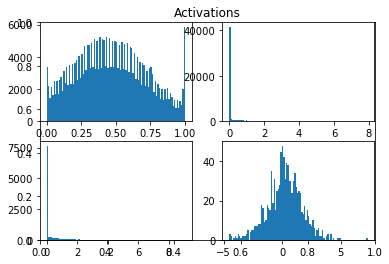

[6 3 8 0 1 2 0 8 4 3 9 1 3 5 4 2 8 8 8 2 2 9 3 8 8 5 9 1 0 6 1 2 2 9 9 8 8
 6 9 2 8 2 7 6 7 8 2 6 9 8 8 7 3 7 6 2 6 9 2 9 8 1 3 9 2 3 1 2 1 9 2 8 2 8
 9 6 7 9 4 9 2 8 2 1 2 1 9 6 3 2 5 2 4 2 3 1 9 0 6 9]
[ 4 10 21  9  4  3 10  5 17 17]
[6 1 7 ..., 5 3 6]
[291 527 754 533 314 242 506 285 858 690]
cost: 31.95411481660908, train accuracy: 0.52, validation accuracy: 0.427
iterations finished: 1401 alpha: 0.0008100000000000001 reg. lambda: 0.0


Weights 0 Mean -0.000601974501575 SD 0.0241813947949
Weights 1 Mean -0.0020682391424 SD 0.059108927393
Weights 2 Mean 0.000786497118276 SD 0.146293725303


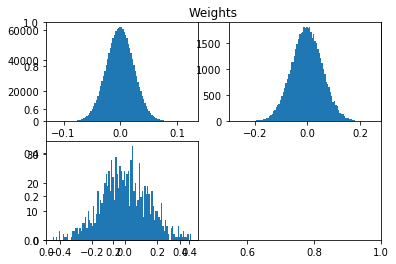

dW 0 Mean -0.0021729926926 SD 0.130838404764
dW 1 Mean -0.0147576426495 SD 0.360264038019
dW 2 Mean 4.26325641456e-17 SD 1.69375260549


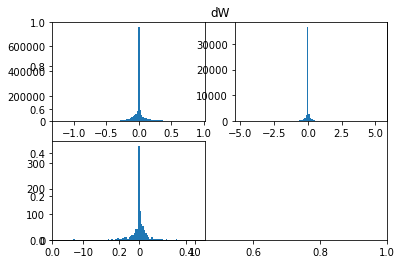

Biases 0 Mean 0.0993420483446 SD 0.0216058441635
Biases 1 Mean 0.105146333773 SD 0.0593960619977
Biases 2 Mean 0.1 SD 0.216895859887


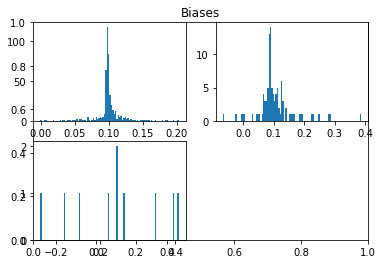

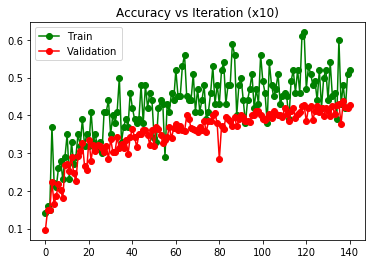

[8 3 6 1 5 5 4 1 9 2 5 9 4 5 0 2 8 6 3 4 4 4 7 3 4 4 2 8 8 9 3 7 4 5 8 0 5
 1 4 5 4 7 4 4 2 2 2 7 7 3 4 0 1 7 8 5 6 4 7 1 9 8 2 1 3 9 2 4 7 4 5 8 4 9
 9 7 5 3 0 4 1 1 5 3 7 6 1 2 7 8 4 9 9 3 8 5 5 2 3 4]
[ 4  9 10 10 20 13  4 11 10  9]
[6 1 7 ..., 5 5 6]
[427 685 309 282 701 644 409 352 677 514]
cost: 33.48260701303758, train accuracy: 0.51, validation accuracy: 0.4268
iterations finished: 1411 alpha: 0.0008100000000000001 reg. lambda: 0.0


[9 8 5 7 1 0 2 2 7 0 9 7 5 5 6 1 0 0 6 2 0 7 0 5 9 2 2 6 7 1 4 2 2 9 5 7 1
 1 6 3 5 7 7 6 1 7 0 8 8 5 7 9 8 1 0 9 7 2 5 2 2 4 5 7 9 8 7 2 4 0 4 3 0 0
 2 0 1 2 9 7 7 6 8 8 8 3 7 0 9 6 2 7 0 1 5 7 7 8 1 9]
[14 10 14  3  4 10  7 19  9 10]
[5 1 7 ..., 5 5 6]
[642 509 470 218 313 578 434 991 395 450]
cost: 34.94620003287618, train accuracy: 0.47, validation accuracy: 0.4274
iterations finished: 1421 alpha: 0.0008100000000000001 reg. lambda: 0.0


[7 3 3 9 8 7 7 7 5 9 0 5 2 5 5 4 9 7 7 5 5 6 0 5 4 5 6 2 8 8 5 7 7 8 3 1 7
 6 7 7 0 7 5 8 9 3 0 5 1 5 7 9 4 

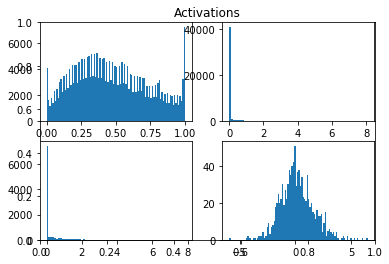

[6 8 8 7 5 1 5 8 2 0 8 7 0 8 1 8 5 4 0 5 7 7 8 1 5 0 9 7 4 5 9 0 0 6 5 0 5
 6 0 7 8 8 0 7 0 7 5 5 1 0 1 5 4 4 7 4 7 4 5 8 8 5 4 0 7 7 8 2 5 0 5 1 7 8
 9 7 1 1 0 5 1 8 3 0 5 5 8 9 4 0 8 8 7 7 7 7 0 6 8 7]
[17  9  2  1  8 18  4 19 18  4]
[5 1 0 ..., 5 5 6]
[ 780  472  211  243  431 1032  377  455  703  296]
cost: 32.984699690124614, train accuracy: 0.54, validation accuracy: 0.4208
iterations finished: 1501 alpha: 0.000729 reg. lambda: 0.0


Weights 0 Mean -0.000589273823195 SD 0.0242139333147
Weights 1 Mean -0.0020628399091 SD 0.0592129567908
Weights 2 Mean 0.000786497118276 SD 0.147577412464


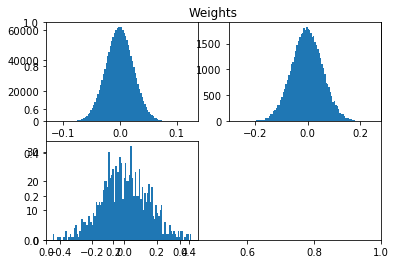

dW 0 Mean -0.00828137845466 SD 0.110302766123
dW 1 Mean -0.0168280504076 SD 0.323805961853
dW 2 Mean 1.42108547152e-17 SD 1.51532517368


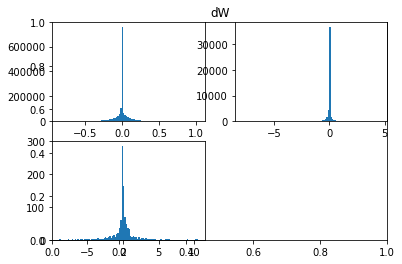

Biases 0 Mean 0.0993506606972 SD 0.0226151980328
Biases 1 Mean 0.105874433488 SD 0.062454275624
Biases 2 Mean 0.1 SD 0.223830799163


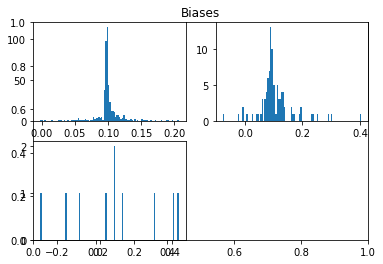

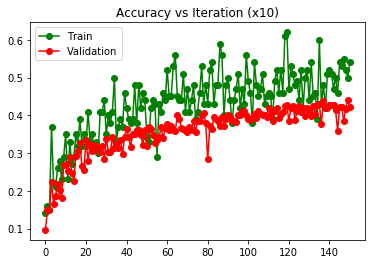

[2 2 6 6 8 3 6 6 3 3 0 6 8 3 6 2 6 9 6 6 8 6 4 8 9 1 8 8 0 8 6 6 2 8 3 8 6
 6 6 8 8 3 1 1 9 0 8 9 8 3 6 4 4 8 8 6 6 8 2 1 1 8 8 8 2 8 0 8 6 3 3 8 6 8
 8 6 2 6 6 8 9 8 1 1 6 8 8 3 2 6 8 8 8 8 8 5 6 8 3 6]
[ 4  7  8 11  3  1 27  0 34  5]
[6 8 6 ..., 5 3 6]
[ 299  495  349  675  225  117 1187   26 1337  290]
cost: 35.366825768746956, train accuracy: 0.4, validation accuracy: 0.3598
iterations finished: 1511 alpha: 0.000729 reg. lambda: 0.0


[6 7 4 9 9 4 7 2 0 9 6 9 8 9 4 6 6 9 9 2 2 9 4 9 5 2 1 4 1 4 4 7 4 7 1 4 4
 2 4 2 3 6 3 5 4 7 7 8 1 0 9 3 6 9 8 9 3 6 9 9 9 9 7 0 9 2 6 0 9 9 9 1 9 7
 4 8 7 6 7 8 4 4 9 3 6 7 9 2 5 3 2 9 3 4 2 4 6 7 9 9]
[ 4  5 10  7 17  3 11 12  5 26]
[6 1 7 ..., 5 4 6]
[445 397 427 378 752 179 693 510 276 943]
cost: 31.86168280817562, train accuracy: 0.51, validation accuracy: 0.4222
iterations finished: 1521 alpha: 0.000729 reg. lambda: 0.0


[7 9 6 7 9 6 9 5 2 6 3 7 9 1 3 8 6 3 1 9 6 1 8 1 7 2 2 8 4 5 8 6 4 1 7 9 8
 5 7 2 9 1 1 5 6 2 4 6 8 5 6 9 8 7 6 3 6 7 5 9 3 

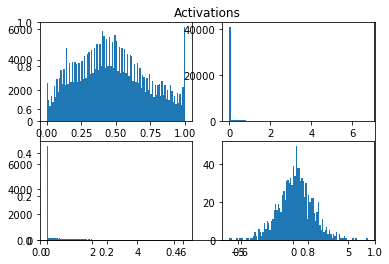

[8 4 9 2 4 8 1 1 6 6 6 5 8 4 2 9 7 6 0 8 4 7 1 6 7 8 9 9 3 6 0 1 0 1 0 0 6
 3 1 6 6 7 3 1 1 4 3 7 7 1 7 3 9 3 0 8 9 8 3 1 1 6 0 4 1 1 7 6 0 4 3 1 1 4
 9 3 6 5 4 3 8 3 4 8 9 1 7 1 7 3 3 4 1 1 0 0 0 6 5 9]
[11 19  2 13 11  3 13 10  9  9]
[6 1 7 ..., 5 4 6]
[555 579 162 370 579 306 663 637 557 592]
cost: 33.16740349682819, train accuracy: 0.58, validation accuracy: 0.444
iterations finished: 1601 alpha: 0.000729 reg. lambda: 0.0


Weights 0 Mean -0.000594061980497 SD 0.0242445918248
Weights 1 Mean -0.00205849671599 SD 0.0593057015152
Weights 2 Mean 0.000786497118276 SD 0.148664501925


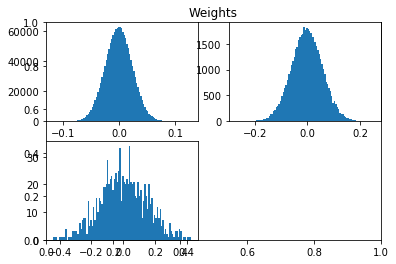

dW 0 Mean -0.00603053845742 SD 0.123934319688
dW 1 Mean -9.03444815564e-06 SD 0.333073409318
dW 2 Mean 0.0 SD 1.59377009776


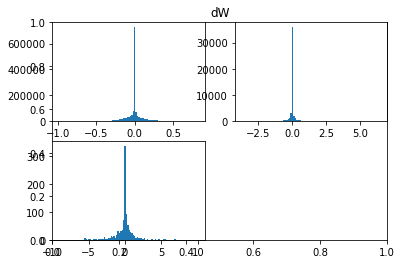

Biases 0 Mean 0.0993945020263 SD 0.0235797747636
Biases 1 Mean 0.106864011577 SD 0.0660726046187
Biases 2 Mean 0.1 SD 0.228513116987


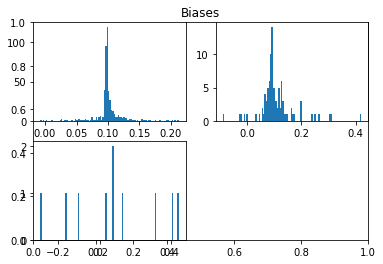

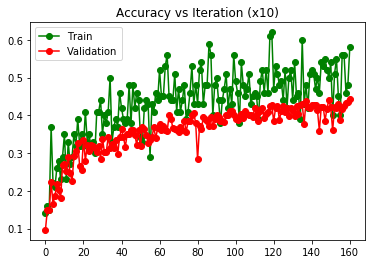

[4 3 8 2 4 7 1 7 6 1 4 3 7 4 6 4 6 0 6 9 1 0 3 0 9 6 0 7 9 6 5 6 3 3 4 1 8
 8 9 8 0 7 3 0 5 4 9 3 0 6 1 4 4 6 9 6 6 2 7 9 0 7 9 6 6 3 3 1 3 3 4 5 1 7
 5 6 3 6 2 0 5 6 4 3 3 6 0 0 1 6 6 8 3 4 0 0 3 4 7 1]
[13  9  3 16 13  5 19  9  5  8]
[6 1 7 ..., 5 6 6]
[575 583 365 546 436 276 914 407 493 405]
cost: 33.93852732856185, train accuracy: 0.48, validation accuracy: 0.4486
iterations finished: 1611 alpha: 0.000729 reg. lambda: 0.0


[5 4 5 6 2 0 1 2 5 1 6 8 6 2 1 8 0 5 8 1 1 5 8 2 3 8 1 5 2 8 5 1 5 3 2 5 8
 7 7 5 1 7 2 1 0 7 6 2 0 5 4 6 5 2 2 4 0 9 6 6 9 2 1 2 8 5 0 0 0 2 0 1 6 1
 3 5 1 2 9 4 0 6 0 5 2 2 4 2 3 5 0 4 2 5 9 7 8 8 2 4]
[12 13 19  4  7 17  9  5 10  4]
[6 1 0 ..., 5 5 6]
[530 504 641 201 540 646 537 276 566 559]
cost: 33.27543349615197, train accuracy: 0.45, validation accuracy: 0.4332
iterations finished: 1621 alpha: 0.000729 reg. lambda: 0.0


[2 9 6 6 4 7 2 3 5 5 4 7 1 0 1 0 2 3 2 5 1 3 2 1 0 1 2 1 1 0 7 7 7 7 1 9 4
 5 2 3 0 4 4 6 9 9 4 4 2 4 4 7 4 6 4 8 7 0 2 7 4 4 1 0 8 5 

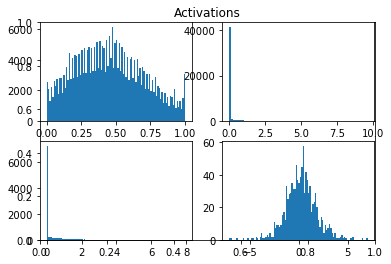

[8 3 1 7 8 2 6 7 4 1 4 1 7 1 1 2 7 4 4 1 8 1 0 8 0 8 2 3 0 6 8 1 3 0 7 1 8
 9 2 7 1 3 9 8 1 8 1 1 1 4 4 1 9 9 4 1 6 4 2 8 0 8 1 7 2 0 4 8 2 5 1 0 6 1
 7 3 8 9 7 0 3 2 8 1 4 7 6 2 4 0 0 9 0 1 1 6 8 6 0 3]
[12 22  9  7 11  1  7 10 15  6]
[6 1 7 ..., 5 3 6]
[491 585 571 552 315 208 685 645 511 437]
cost: 33.74005167988823, train accuracy: 0.51, validation accuracy: 0.463
iterations finished: 1701 alpha: 0.000729 reg. lambda: 0.0


Weights 0 Mean -0.000605525138873 SD 0.0242719613859
Weights 1 Mean -0.00209590680725 SD 0.0593757360778
Weights 2 Mean 0.000786497118276 SD 0.149390454716


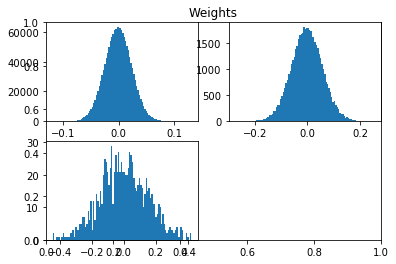

dW 0 Mean 0.00512955620688 SD 0.133484908278
dW 1 Mean 0.0171530158088 SD 0.374223437557
dW 2 Mean -4.26325641456e-17 SD 1.74604162994


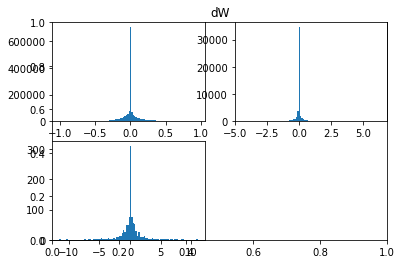

Biases 0 Mean 0.0993122798064 SD 0.0244347937191
Biases 1 Mean 0.107333525485 SD 0.0698219019876
Biases 2 Mean 0.1 SD 0.238441849261


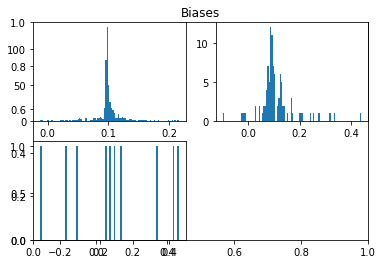

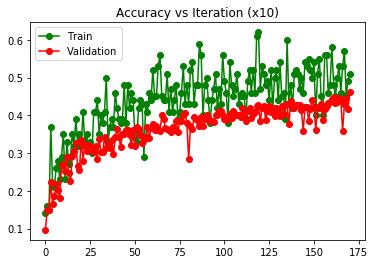

[8 6 6 0 7 3 1 3 0 3 3 5 0 8 0 0 1 8 8 3 2 3 1 6 2 5 6 3 2 7 5 9 9 1 0 7 7
 0 4 0 3 9 9 2 5 1 9 5 0 1 4 6 6 8 0 0 5 9 9 2 1 5 9 2 3 2 1 7 9 8 5 2 3 5
 0 0 9 1 1 6 2 7 0 0 3 1 0 7 4 9 6 5 8 1 5 3 5 5 2 4]
[16 12 10 12  4 13  8  7  7 11]
[5 1 7 ..., 5 3 6]
[698 527 666 386 196 753 405 378 409 582]
cost: 33.24506184418794, train accuracy: 0.44, validation accuracy: 0.4416
iterations finished: 1711 alpha: 0.000729 reg. lambda: 0.0


[9 1 1 9 6 9 7 5 0 1 4 6 1 1 3 8 2 2 4 8 7 1 9 0 1 9 0 5 1 6 0 1 1 1 1 9 0
 4 2 6 9 7 6 5 4 1 5 1 1 5 9 7 5 6 1 7 5 9 0 5 1 3 5 8 5 5 9 1 7 7 9 4 5 9
 9 6 5 5 5 9 5 5 6 1 0 8 8 6 0 9 1 9 8 5 1 8 6 9 1 5]
[ 8 22  3  2  5 19 10  7  7 17]
[5 1 7 ..., 5 5 6]
[307 688 192 224 444 844 518 454 482 847]
cost: 33.90327378541416, train accuracy: 0.5, validation accuracy: 0.4214
iterations finished: 1721 alpha: 0.000729 reg. lambda: 0.0


[8 8 4 9 3 7 3 5 6 0 0 2 8 9 9 8 9 6 0 3 7 0 8 6 1 8 0 9 8 9 8 9 5 7 3 1 8
 0 5 0 7 7 4 6 9 1 9 1 5 2 9 4 7 3 4 6 3 6 6 2 4 9 9 0 8 7 7

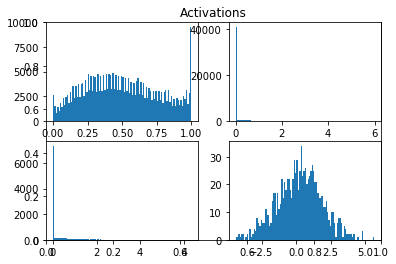

[1 5 7 9 8 2 0 0 2 9 8 4 8 2 1 0 6 0 0 1 3 2 7 4 6 8 5 3 9 7 7 0 5 1 8 8 4
 8 8 8 6 6 8 2 6 6 9 3 6 5 9 8 8 1 5 0 4 1 2 9 2 2 3 0 9 8 8 8 9 8 6 1 2 9
 0 3 9 3 2 6 5 5 1 4 4 3 1 0 1 8 0 8 9 9 5 9 5 4 1 3]
[11 11 10  8  7  9  9  4 18 13]
[6 8 6 ..., 5 3 6]
[378 571 421 678 343 396 718 215 840 440]
cost: 33.47927517184636, train accuracy: 0.43, validation accuracy: 0.436
iterations finished: 1801 alpha: 0.000729 reg. lambda: 0.0


Weights 0 Mean -0.000596858421867 SD 0.0242995594113
Weights 1 Mean -0.00206775056837 SD 0.0594610621241
Weights 2 Mean 0.000786497118276 SD 0.150358222011


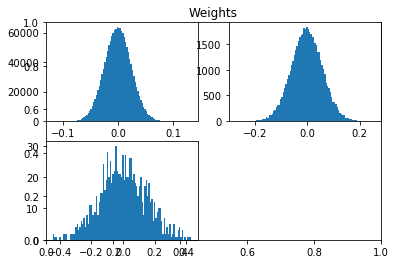

dW 0 Mean 0.00799604895876 SD 0.176950214957
dW 1 Mean 0.022622460812 SD 0.460872645182
dW 2 Mean -1.7763568394e-17 SD 2.21807073852


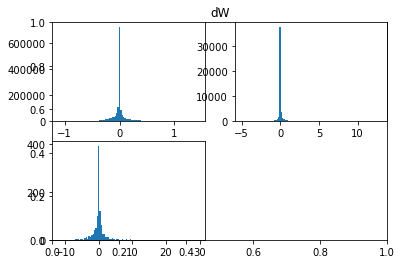

Biases 0 Mean 0.0993288597724 SD 0.0253577409172
Biases 1 Mean 0.10834322719 SD 0.0733559856543
Biases 2 Mean 0.1 SD 0.248341623404


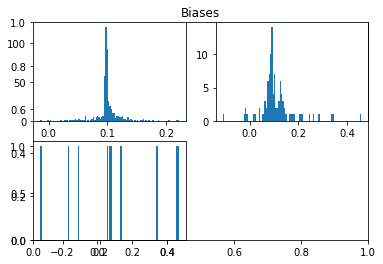

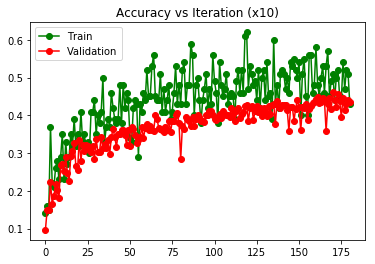

[6 1 7 6 6 7 5 5 9 7 8 6 8 1 7 9 8 4 8 8 8 6 9 1 7 8 3 7 6 6 8 0 8 9 5 2 9
 6 0 7 4 7 9 6 2 3 9 7 9 3 6 7 2 7 6 0 2 8 7 2 2 8 7 0 3 2 7 0 1 3 7 9 0 8
 7 2 1 5 7 7 9 4 9 3 9 9 7 0 2 8 5 1 8 2 7 9 6 7 7 6]
[ 7  6 10  6  3  5 13 22 14 14]
[6 1 7 ..., 5 6 6]
[333 239 477 231 120 297 976 943 598 786]
cost: 32.49041573065662, train accuracy: 0.57, validation accuracy: 0.4316
iterations finished: 1811 alpha: 0.000729 reg. lambda: 0.0


[4 6 9 2 1 8 2 4 2 2 2 9 5 7 6 2 1 6 1 8 8 4 6 9 0 0 2 9 4 8 7 8 9 7 4 7 6
 2 6 4 2 7 2 6 9 9 2 5 2 2 3 6 4 9 0 2 8 1 6 2 6 4 6 3 3 2 4 5 1 2 1 5 2 2
 9 7 0 2 0 2 0 5 1 9 2 1 1 7 6 7 9 8 2 2 5 7 3 2 2 4]
[ 6  9 26  4 10  6 12  9  7 11]
[6 1 4 ..., 5 3 6]
[276 589 878 434 376 388 461 483 349 766]
cost: 31.985864748889917, train accuracy: 0.52, validation accuracy: 0.4302
iterations finished: 1821 alpha: 0.000729 reg. lambda: 0.0


[1 2 6 1 7 9 2 1 0 6 7 3 5 2 7 4 8 2 9 2 6 4 1 3 9 7 8 2 4 0 0 1 3 9 0 0 6
 5 6 1 9 2 6 4 4 3 0 9 7 3 2 7 6 2 2 2 4 6 5 0 2 5 0 3 7 1

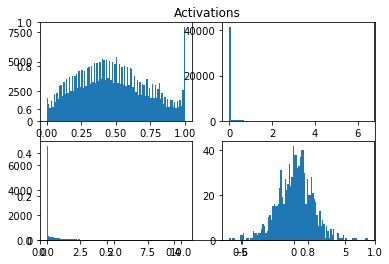

[3 4 6 4 9 9 3 0 8 7 3 6 4 0 8 4 6 7 0 4 8 3 8 8 7 6 1 3 8 7 8 9 5 0 7 8 3
 9 1 7 9 6 4 3 0 6 6 7 3 8 0 8 9 8 5 9 1 9 3 6 5 7 9 3 9 4 0 8 4 9 5 9 4 7
 4 9 8 2 9 6 8 1 8 8 6 2 4 1 9 6 8 9 9 7 6 1 9 6 3 3]
[ 7  6  2 12 11  4 13 10 17 18]
[6 1 7 ..., 5 5 6]
[ 254  465  205  493  502  250  501  577  714 1039]
cost: 34.01391256147719, train accuracy: 0.4, validation accuracy: 0.4304
iterations finished: 1901 alpha: 0.000729 reg. lambda: 0.0


Weights 0 Mean -0.00059445611113 SD 0.0243272052962
Weights 1 Mean -0.00206803460651 SD 0.0595418110069
Weights 2 Mean 0.000786497118276 SD 0.151211145064


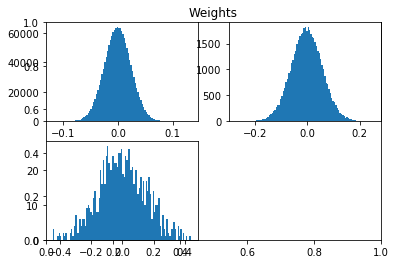

dW 0 Mean -0.00679211305066 SD 0.143710423197
dW 1 Mean 0.00236401800713 SD 0.430324605741
dW 2 Mean 1.13686837722e-16 SD 1.87911891243


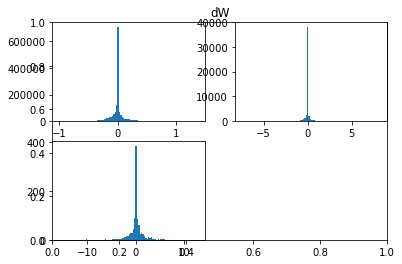

Biases 0 Mean 0.0992907988131 SD 0.0263842341725
Biases 1 Mean 0.108969868382 SD 0.0767604756625
Biases 2 Mean 0.1 SD 0.25522230349


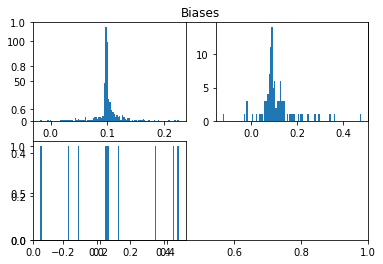

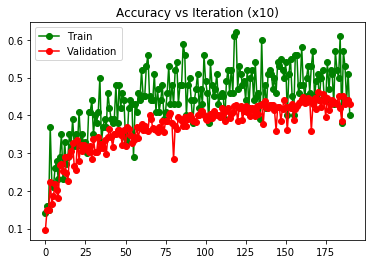

[3 6 0 7 3 8 6 6 8 9 3 4 5 2 5 9 1 8 7 8 5 3 1 1 0 0 5 7 7 8 4 0 7 5 6 5 9
 2 6 9 8 1 6 5 1 6 0 3 6 7 2 8 6 2 4 2 8 7 6 6 7 8 2 9 3 8 7 1 3 5 3 6 8 5
 5 3 2 9 1 7 7 7 8 5 5 6 6 8 8 6 3 5 7 7 8 5 5 0 3 0]
[ 7  7  7 11  3 15 15 14 15  6]
[6 1 6 ..., 5 5 6]
[374 315 391 645 170 696 612 525 787 485]
cost: 33.311703475075966, train accuracy: 0.58, validation accuracy: 0.4362
iterations finished: 1911 alpha: 0.000729 reg. lambda: 0.0


[7 7 1 7 8 5 4 7 7 4 8 4 8 7 9 1 1 7 0 4 3 7 8 8 0 6 0 7 7 4 3 4 9 0 0 7 7
 0 3 3 6 0 1 0 7 0 6 5 8 7 4 0 7 4 7 7 1 7 0 4 7 8 8 2 9 9 8 8 0 7 0 7 2 0
 7 7 8 0 7 3 0 1 5 7 3 8 8 6 8 7 2 7 8 6 7 9 8 8 7 3]
[16  6  3  7  9  3  5 29 17  5]
[6 7 7 ..., 5 2 6]
[679 350 311 368 682 209 414 981 698 308]
cost: 32.35728339055456, train accuracy: 0.51, validation accuracy: 0.434
iterations finished: 1921 alpha: 0.000729 reg. lambda: 0.0


[6 0 7 0 6 4 2 6 6 5 7 5 3 8 5 0 4 3 0 6 3 8 0 8 2 5 2 6 5 6 0 4 5 1 3 6 2
 0 0 6 7 4 8 5 7 0 8 6 0 0 7 6 8 4 0 7 8 7 6 2 0 8 0 0 8 8 

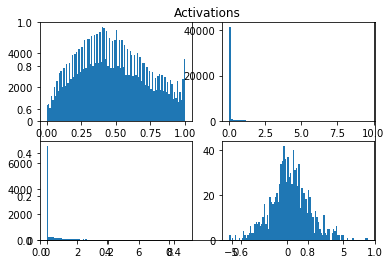

[6 4 1 0 5 1 4 7 6 5 4 1 5 9 7 0 2 9 6 7 8 7 9 7 9 6 6 4 1 1 6 8 9 5 4 1 6
 5 1 6 5 5 8 4 0 9 7 9 0 7 5 1 7 4 6 7 1 6 6 7 9 7 1 4 7 6 1 0 8 8 9 8 8 6
 5 9 4 9 4 6 9 6 3 2 5 1 0 9 9 5 0 8 5 9 7 4 5 6 6 2]
[ 7 12  3  1 11 13 17 13  8 15]
[6 1 7 ..., 5 4 6]
[367 770 202 233 604 571 665 558 517 513]
cost: 34.823506796623725, train accuracy: 0.52, validation accuracy: 0.4528
iterations finished: 2001 alpha: 0.0006561000000000001 reg. lambda: 0.0


Weights 0 Mean -0.000599260380967 SD 0.0243568819728
Weights 1 Mean -0.00210322966061 SD 0.0596253954208
Weights 2 Mean 0.000786497118276 SD 0.152005718101


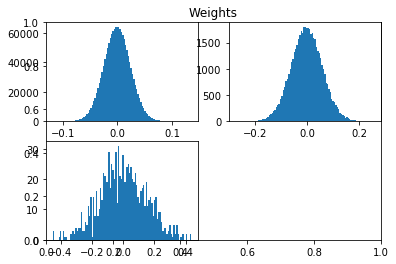

dW 0 Mean 0.00484193729239 SD 0.157198559776
dW 1 Mean 0.00495260815268 SD 0.402379387312
dW 2 Mean -2.13162820728e-17 SD 1.55132544061


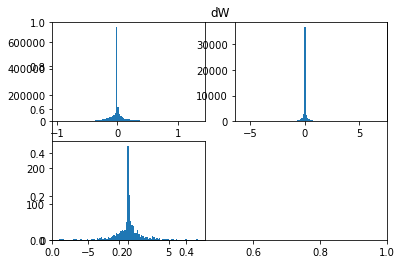

Biases 0 Mean 0.0992631669091 SD 0.027177042426
Biases 1 Mean 0.109570628399 SD 0.0792291531029
Biases 2 Mean 0.1 SD 0.259150519961


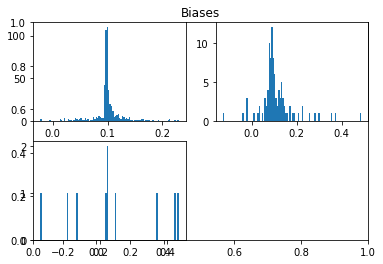

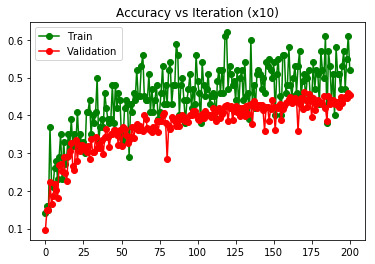

[6 1 0 1 3 6 3 9 8 0 1 0 4 9 1 3 4 4 1 0 0 2 1 0 0 8 5 8 8 8 8 1 8 1 5 7 1
 5 3 1 0 5 8 8 5 8 3 0 9 2 8 8 1 4 1 6 9 1 0 5 8 6 8 2 1 1 1 0 9 6 3 7 1 4
 0 8 1 6 2 1 3 6 3 7 3 3 1 0 0 6 5 1 0 9 6 8 5 4 1 8]
[15 22  4 10  6  8  9  3 17  6]
[6 1 0 ..., 5 3 6]
[ 564 1030  364  500  351  425  497  320  696  253]
cost: 34.306700898260516, train accuracy: 0.54, validation accuracy: 0.4378
iterations finished: 2011 alpha: 0.0006561000000000001 reg. lambda: 0.0


[9 3 3 9 3 5 3 7 5 4 0 9 0 4 7 9 9 5 7 2 2 9 9 1 2 9 9 1 4 3 9 2 7 9 6 5 9
 6 8 7 6 8 7 9 5 5 0 1 4 1 6 1 0 9 3 3 5 5 2 2 9 1 4 9 9 5 6 4 3 5 5 6 9 2
 9 5 2 2 5 0 2 2 3 4 5 0 7 8 3 4 5 2 0 4 2 6 7 4 0 1]
[ 8  7 13 10 10 15  7  8  3 19]
[6 1 7 ..., 5 5 6]
[400 361 798 420 273 844 369 444 274 817]
cost: 33.82435494040078, train accuracy: 0.48, validation accuracy: 0.4252
iterations finished: 2021 alpha: 0.0006561000000000001 reg. lambda: 0.0


[8 5 5 6 1 0 6 1 5 0 9 6 4 9 2 0 5 1 2 2 0 4 9 7 9 7 5 2 5 7 0 1 3 1 3 6 2
 2 6 1 3 3 7 0 7 1 1 3

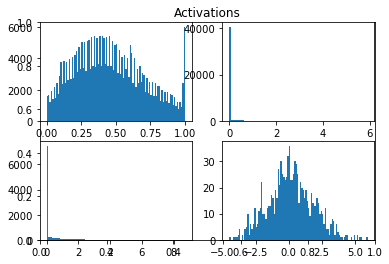

[1 6 9 8 4 8 7 6 0 1 9 1 6 6 3 1 5 5 6 1 5 5 1 6 9 6 6 1 0 1 5 8 6 1 9 3 6
 1 6 8 8 6 1 6 7 6 1 5 1 1 4 1 6 6 5 8 6 1 1 7 9 2 7 1 4 5 2 5 9 3 5 1 6 5
 6 5 3 6 0 0 6 5 5 1 0 0 3 1 0 1 0 5 4 6 0 6 9 6 1 1]
[ 9 24  2  5  4 15 24  4  6  7]
[6 1 6 ..., 5 6 6]
[ 331  701  353  129  172  693 1334  440  418  429]
cost: 34.85319251766077, train accuracy: 0.55, validation accuracy: 0.4288
iterations finished: 2101 alpha: 0.0006561000000000001 reg. lambda: 0.0


Weights 0 Mean -0.000568116347918 SD 0.0243810376521
Weights 1 Mean -0.00214174402043 SD 0.0597271059146
Weights 2 Mean 0.000786497118276 SD 0.153447153014


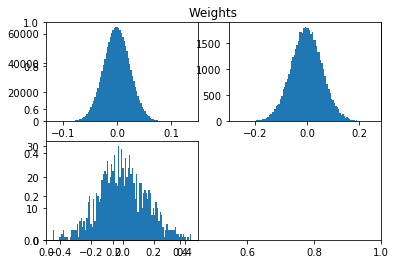

dW 0 Mean -0.0177694544946 SD 0.16862273509
dW 1 Mean -0.00797130259829 SD 0.530640027364
dW 2 Mean 2.84217094304e-17 SD 2.47939791759


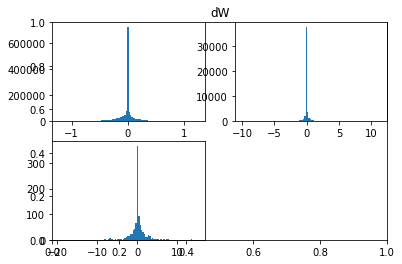

Biases 0 Mean 0.0993361395578 SD 0.028052541683
Biases 1 Mean 0.110165966174 SD 0.0820800542654
Biases 2 Mean 0.1 SD 0.263480600442


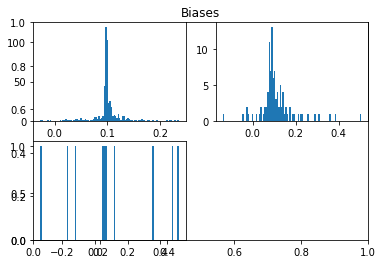

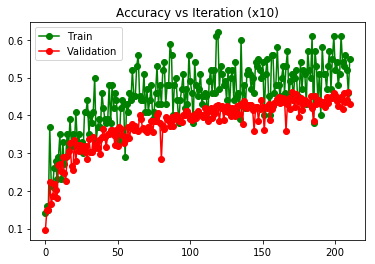

[5 5 9 0 6 8 4 3 1 8 2 3 9 1 6 1 6 4 6 1 3 2 9 8 0 0 0 9 4 7 2 0 4 4 9 2 1
 1 7 2 1 8 2 4 8 6 8 9 7 2 8 3 0 7 7 4 1 1 7 5 2 4 0 8 8 8 5 2 6 6 1 6 6 2
 3 3 6 5 0 0 0 6 0 4 4 3 8 9 9 7 5 7 7 9 5 0 9 9 0 6]
[13 10 10  7 10  7 12  9 11 11]
[6 1 0 ..., 5 3 4]
[487 594 545 391 440 345 417 664 644 473]
cost: 34.38035068269436, train accuracy: 0.51, validation accuracy: 0.469
iterations finished: 2111 alpha: 0.0006561000000000001 reg. lambda: 0.0


[9 4 7 0 4 5 8 3 8 1 6 2 2 7 2 6 3 2 9 8 7 2 1 3 6 4 1 9 9 7 9 8 0 5 1 8 0
 6 8 3 2 0 3 7 8 5 0 4 2 2 0 1 2 1 1 6 6 2 2 2 2 8 2 7 1 6 5 2 3 4 4 8 8 6
 2 8 0 7 1 2 2 4 8 4 2 3 7 2 8 1 0 3 8 9 6 9 6 2 1 9]
[ 8 11 21  8  8  4 10  8 14  8]
[6 8 0 ..., 5 3 4]
[586 408 772 385 294 417 414 453 787 484]
cost: 34.588207366066065, train accuracy: 0.57, validation accuracy: 0.4568
iterations finished: 2121 alpha: 0.0006561000000000001 reg. lambda: 0.0


[6 1 8 8 7 1 7 1 0 6 0 7 4 8 4 3 3 8 5 8 9 6 6 4 6 6 0 6 6 8 6 9 8 9 9 0 6
 7 6 8 7 9 6 0 3 0 0 8 3 2 6 0 6 

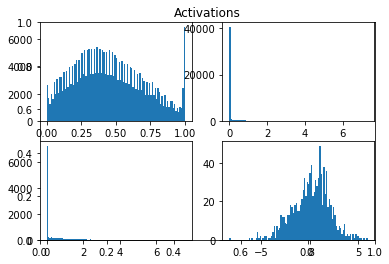

[1 2 3 6 7 8 8 1 3 3 4 2 8 9 8 3 6 9 6 8 9 4 4 2 3 9 0 4 4 2 1 1 6 5 1 1 0
 5 4 4 6 2 2 4 8 8 0 4 1 3 8 2 2 3 9 3 7 2 8 3 2 2 4 5 4 0 9 2 1 0 6 4 8 3
 0 2 2 0 4 0 1 1 8 9 9 3 5 6 4 2 8 4 3 3 9 1 6 0 6 2]
[ 9 11 16 13 15  4  9  2 12  9]
[6 8 0 ..., 5 4 4]
[489 434 616 338 719 187 685 185 779 568]
cost: 35.30085734711108, train accuracy: 0.43, validation accuracy: 0.4386
iterations finished: 2201 alpha: 0.0006561000000000001 reg. lambda: 0.0


Weights 0 Mean -0.000582207781007 SD 0.0244041968374
Weights 1 Mean -0.00209052710667 SD 0.0598237616575
Weights 2 Mean 0.000786497118276 SD 0.154735631807


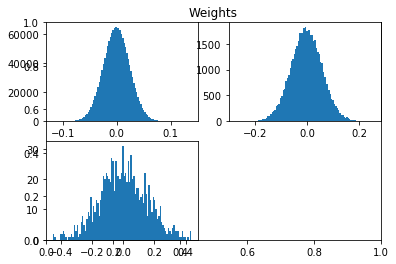

dW 0 Mean 0.00853822434146 SD 0.200346609784
dW 1 Mean 0.00265416055452 SD 0.587248124662
dW 2 Mean 0.0 SD 2.42635977103


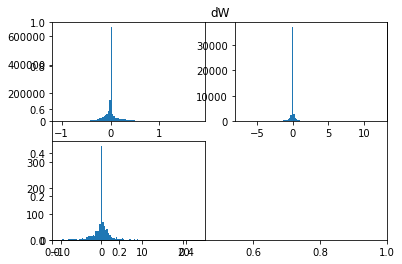

Biases 0 Mean 0.0992584372399 SD 0.0288088932775
Biases 1 Mean 0.111018814901 SD 0.0854623283985
Biases 2 Mean 0.1 SD 0.271675317854


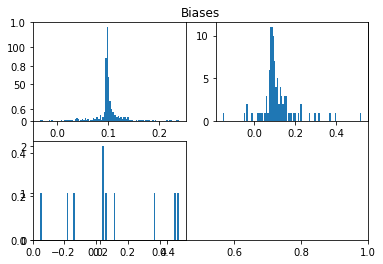

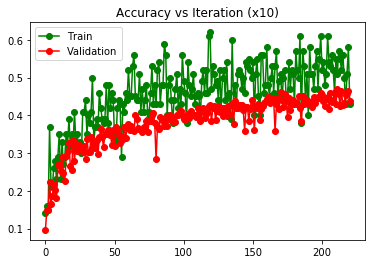

[0 5 6 3 2 3 0 1 1 1 1 7 9 0 6 1 7 3 3 6 8 8 0 3 0 4 1 3 0 5 1 6 1 9 4 6 2
 7 6 1 2 3 7 0 9 9 4 7 5 3 0 6 1 6 2 0 7 6 9 2 8 6 2 5 6 9 5 3 0 5 6 3 5 5
 9 1 1 2 5 0 1 7 1 4 9 0 4 1 1 5 3 1 3 2 3 3 3 7 0 7]
[13 17  8 15  5 10 12  9  3  8]
[6 1 7 ..., 5 3 6]
[518 777 459 541 184 439 424 670 419 569]
cost: 35.73036882281486, train accuracy: 0.54, validation accuracy: 0.4548
iterations finished: 2211 alpha: 0.0006561000000000001 reg. lambda: 0.0


[9 4 4 7 8 0 9 6 9 7 6 5 0 5 7 6 0 2 6 6 2 0 3 8 3 2 9 6 1 8 7 0 2 2 0 7 2
 0 4 8 4 9 5 8 1 3 6 2 4 1 2 6 8 2 2 2 4 7 9 3 3 0 8 2 7 9 4 5 4 2 0 9 1 2
 8 9 1 0 7 2 5 2 8 3 6 2 6 6 4 2 6 1 2 1 8 6 3 6 4 2]
[10  7 20  7 10  5 14  8 10  9]
[6 1 0 ..., 5 3 6]
[377 365 898 450 556 206 726 400 503 519]
cost: 34.657340016700076, train accuracy: 0.4, validation accuracy: 0.448
iterations finished: 2221 alpha: 0.0006561000000000001 reg. lambda: 0.0


[0 4 4 7 9 9 8 4 9 0 5 8 3 4 3 9 7 4 4 4 4 9 9 4 9 1 4 1 1 0 8 1 4 8 9 9 1
 0 7 4 4 9 7 7 3 9 4 4 1 3 4 7 8 3

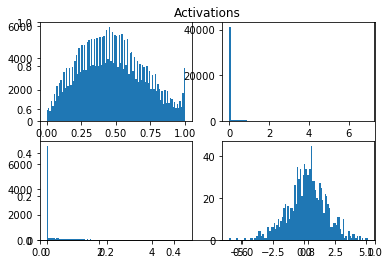

[4 9 9 2 2 2 4 7 6 6 1 6 8 2 9 4 2 8 3 0 1 7 2 8 2 2 2 1 5 9 6 7 7 0 8 0 2
 1 8 6 8 2 7 6 8 3 2 1 8 2 4 9 2 8 9 7 3 3 7 3 9 5 0 9 4 3 6 0 4 0 6 8 0 9
 8 7 1 8 5 6 6 7 8 3 6 7 9 4 9 8 2 9 1 0 6 3 7 1 5 5]
[ 8  8 15  8  7  5 12 11 14 12]
[6 1 7 ..., 5 6 6]
[303 414 668 479 328 433 770 547 402 656]
cost: 32.58130906713216, train accuracy: 0.53, validation accuracy: 0.4538
iterations finished: 2301 alpha: 0.0006561000000000001 reg. lambda: 0.0


Weights 0 Mean -0.000584668071178 SD 0.0244283682271
Weights 1 Mean -0.00214553618405 SD 0.0598915279305
Weights 2 Mean 0.000786497118276 SD 0.155345572978


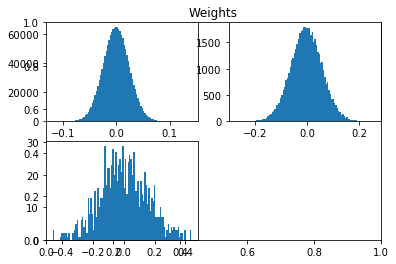

dW 0 Mean -0.0110111389712 SD 0.118483576208
dW 1 Mean -0.0193664422937 SD 0.326450769982
dW 2 Mean 3.19744231092e-17 SD 1.35492399233


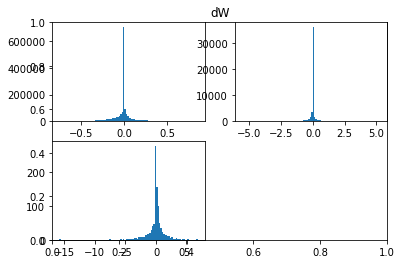

Biases 0 Mean 0.0992402028339 SD 0.0295366222469
Biases 1 Mean 0.111383667824 SD 0.0871674840181
Biases 2 Mean 0.1 SD 0.276986957199


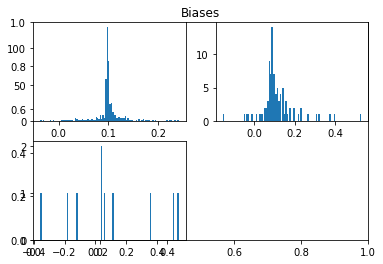

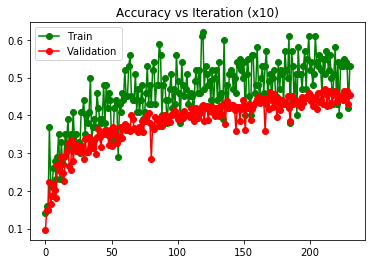

[1 8 6 6 4 4 5 1 1 2 6 0 9 8 7 0 7 4 0 8 6 6 7 8 0 4 6 8 7 8 2 9 6 0 8 0 0
 4 1 0 3 6 0 9 1 2 9 8 1 5 6 0 2 5 4 3 4 0 0 1 2 8 1 4 0 0 3 0 0 0 1 8 8 4
 2 1 5 1 7 6 4 0 2 1 0 4 9 4 0 9 9 1 0 2 2 7 4 0 7 2]
[22 13 10  3 13  4 10  7 11  7]
[6 1 0 ..., 5 0 6]
[973 642 411 222 511 209 552 423 713 344]
cost: 34.560402626652845, train accuracy: 0.55, validation accuracy: 0.4472
iterations finished: 2311 alpha: 0.0006561000000000001 reg. lambda: 0.0


[1 4 9 3 4 1 6 6 4 3 8 6 4 7 3 4 7 2 1 4 1 4 3 3 6 1 2 0 0 3 6 8 1 0 8 2 5
 9 8 6 0 6 2 2 8 7 8 0 9 9 1 7 1 3 4 8 1 3 0 3 2 9 8 7 4 8 0 3 4 5 6 2 3 6
 4 6 2 3 6 2 1 3 6 6 2 9 2 7 2 2 0 2 6 1 3 9 8 4 3 2]
[ 8 11 15 15 12  2 14  6 10  7]
[6 1 4 ..., 5 3 4]
[395 532 716 568 714 226 587 482 368 412]
cost: 36.36462445782062, train accuracy: 0.5, validation accuracy: 0.4576
iterations finished: 2321 alpha: 0.0006561000000000001 reg. lambda: 0.0


[6 9 9 7 0 9 5 0 1 8 3 2 9 8 8 1 0 8 0 6 8 8 9 9 0 0 8 9 8 6 1 8 6 8 5 8 6
 8 8 6 6 8 0 4 7 5 6 1 9 6 1 2 0 

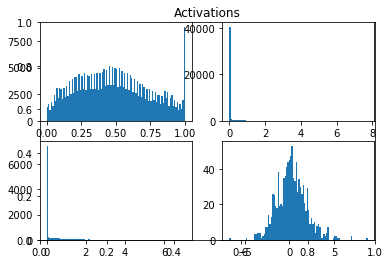

[4 7 4 9 5 3 9 9 1 7 0 1 0 7 7 9 6 6 4 4 5 5 9 4 7 1 3 0 6 6 8 7 4 8 0 0 1
 2 0 5 3 2 0 4 5 9 4 4 8 0 8 7 5 6 3 7 9 1 8 0 5 4 8 0 4 6 8 0 4 0 2 6 3 6
 9 9 0 4 6 9 4 4 4 9 8 1 6 2 0 3 9 0 1 8 8 9 4 1 0 4]
[16  8  4  6 18  7 10  8 10 13]
[6 8 7 ..., 5 6 6]
[508 387 310 295 509 264 907 521 699 600]
cost: 34.67707819005853, train accuracy: 0.56, validation accuracy: 0.46
iterations finished: 2401 alpha: 0.0006561000000000001 reg. lambda: 0.0


Weights 0 Mean -0.000569237585097 SD 0.0244532595395
Weights 1 Mean -0.0021914452095 SD 0.0599770004708
Weights 2 Mean 0.000786497118276 SD 0.156332300968


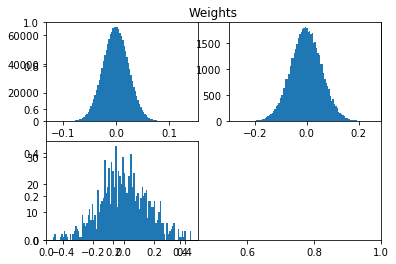

dW 0 Mean -0.00503358359819 SD 0.123454141182
dW 1 Mean -0.0132089511677 SD 0.376823704359
dW 2 Mean 5.68434188608e-17 SD 1.57394320665


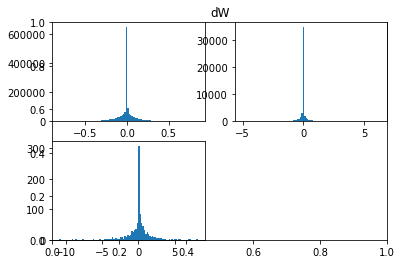

Biases 0 Mean 0.0992005011904 SD 0.0302482968739
Biases 1 Mean 0.111792458612 SD 0.08975949702
Biases 2 Mean 0.1 SD 0.283087060058


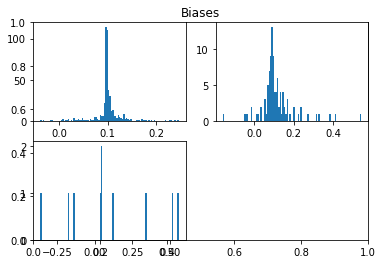

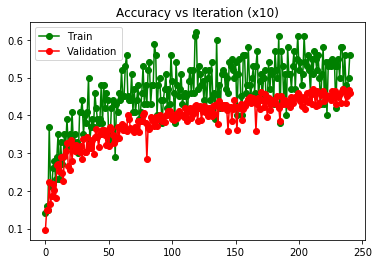

[0 0 8 5 3 7 2 3 6 4 3 3 4 5 0 1 8 0 9 7 4 5 1 3 8 8 1 6 6 9 6 2 6 9 6 3 2
 6 8 9 4 1 3 9 3 7 3 6 6 2 7 9 2 1 3 6 9 9 3 9 9 6 9 8 2 3 3 3 7 6 3 2 6 6
 6 2 1 3 1 0 6 9 2 2 6 1 5 8 9 2 1 6 8 6 0 6 9 7 2 4]
[ 6  9 12 16  5  4 20  6  8 14]
[6 1 6 ..., 5 3 6]
[212 614 303 771 320 245 963 311 817 444]
cost: 34.80331115313332, train accuracy: 0.51, validation accuracy: 0.4458
iterations finished: 2411 alpha: 0.0006561000000000001 reg. lambda: 0.0


[7 7 1 2 8 6 3 0 2 9 2 6 9 8 7 0 9 2 4 2 9 1 2 9 6 7 0 3 6 6 3 6 5 4 8 1 8
 9 4 3 6 0 0 8 6 6 2 2 4 8 1 8 0 0 6 3 6 6 6 6 6 8 1 6 1 7 1 3 7 9 4 0 6 2
 6 4 1 9 2 6 3 6 3 6 4 6 1 6 9 7 7 2 2 6 2 0 3 2 2 9]
[ 9  9 15  9  7  1 24  8  8 10]
[6 1 0 ..., 5 6 6]
[502 583 695 498 356 255 855 248 560 448]
cost: 37.53554995663733, train accuracy: 0.53, validation accuracy: 0.4656
iterations finished: 2421 alpha: 0.0006561000000000001 reg. lambda: 0.0


[2 1 9 8 3 3 3 8 2 6 8 8 4 9 4 9 7 5 7 9 6 1 1 1 8 3 0 4 9 2 7 2 0 6 4 1 5
 4 0 6 4 7 7 0 3 5 0 6 3 8 1 5 6 

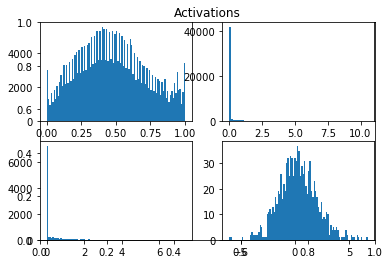

[7 5 2 0 0 7 3 9 7 5 3 7 2 6 3 3 1 6 8 3 3 8 6 5 8 0 4 9 9 6 7 3 3 3 1 4 8
 0 7 4 2 3 7 7 7 9 0 6 1 3 9 1 1 8 3 2 5 6 1 7 7 8 9 6 9 9 3 9 3 7 1 3 6 0
 9 9 6 7 6 8 8 7 2 1 2 8 9 3 8 8 6 3 6 3 6 6 7 4 9 1]
[ 6  9  6 18  4  4 14 15 11 13]
[6 8 7 ..., 5 6 6]
[300 412 279 754 414 191 931 440 501 778]
cost: 35.287387684915196, train accuracy: 0.58, validation accuracy: 0.449
iterations finished: 2501 alpha: 0.00059049 reg. lambda: 0.0


Weights 0 Mean -0.000599308565285 SD 0.0244767855266
Weights 1 Mean -0.00218684142909 SD 0.0600520377564
Weights 2 Mean 0.000786497118276 SD 0.157113464406


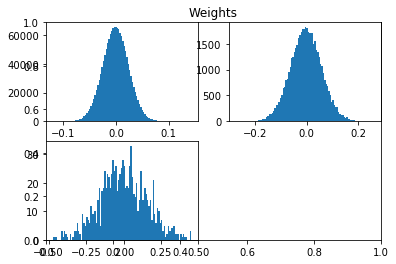

dW 0 Mean -0.00794874896101 SD 0.159497826789
dW 1 Mean -0.0109988348533 SD 0.467141835713
dW 2 Mean 2.84217094304e-17 SD 2.18338158905


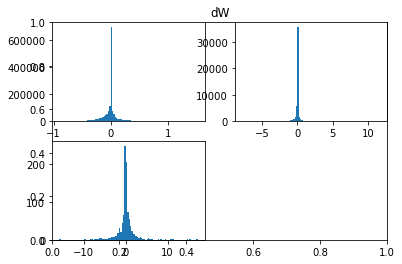

Biases 0 Mean 0.099142395464 SD 0.0309737863433
Biases 1 Mean 0.112661716092 SD 0.0925370848927
Biases 2 Mean 0.1 SD 0.290497099772


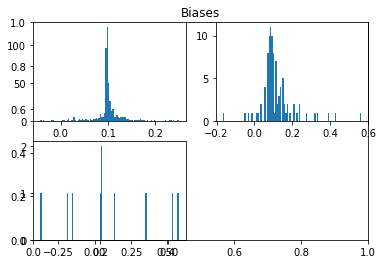

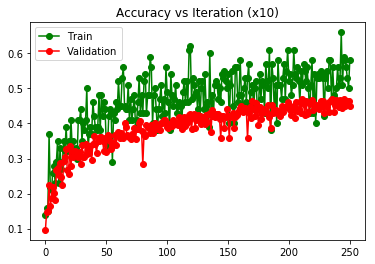

[5 0 8 0 7 8 9 1 4 1 7 2 4 2 3 5 8 6 0 1 7 9 2 2 6 9 3 3 0 4 7 0 4 6 6 3 1
 6 7 1 2 1 0 6 9 7 6 7 3 6 9 7 3 1 1 5 4 3 7 4 6 3 6 4 1 9 3 1 3 8 4 2 2 3
 1 3 3 0 3 1 3 1 0 8 1 9 1 4 0 6 1 4 1 0 0 6 6 2 3 1]
[11 18  8 16 10  3 13  9  5  7]
[6 1 7 ..., 5 3 6]
[602 553 316 542 516 230 694 513 571 463]
cost: 36.03692954278061, train accuracy: 0.52, validation accuracy: 0.4724
iterations finished: 2511 alpha: 0.00059049 reg. lambda: 0.0


[3 0 9 6 7 0 4 9 9 0 0 7 8 6 1 4 5 7 2 7 1 4 6 6 5 9 5 6 4 3 7 4 8 7 0 1 4
 8 8 6 7 4 4 6 2 4 3 5 1 3 6 2 4 5 6 7 8 5 9 5 6 7 0 6 2 2 5 2 0 3 9 1 8 3
 5 8 9 0 8 2 5 5 8 2 6 2 1 7 7 0 8 3 2 3 9 6 5 4 2 2]
[ 9  6 12  8 11 12 13 11 10  8]
[6 1 7 ..., 5 3 4]
[423 531 538 407 609 545 481 612 443 411]
cost: 34.60191361121903, train accuracy: 0.51, validation accuracy: 0.4648
iterations finished: 2521 alpha: 0.00059049 reg. lambda: 0.0


[4 4 5 7 5 5 5 6 7 1 6 9 1 1 6 4 3 2 0 6 3 9 5 6 2 9 4 8 4 9 4 8 4 1 2 8 1
 5 8 4 1 2 2 4 9 4 6 3 3 9 9 4 5 0 4 1 4 5 1 6 2 1 0 6 

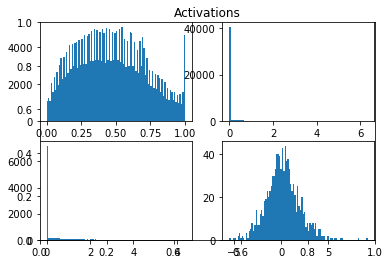

[3 7 5 2 3 5 9 2 7 1 7 7 9 3 3 2 7 2 0 9 7 5 2 8 0 4 5 7 5 7 7 1 9 7 8 4 4
 1 5 4 5 0 7 9 7 0 0 2 1 9 6 0 7 0 7 2 7 2 5 8 8 9 7 9 7 2 9 7 9 1 7 5 1 0
 7 7 1 1 9 5 7 5 7 5 9 7 9 7 9 3 9 2 8 9 4 3 2 2 7 4]
[ 8  8 12  6  6 12  1 26  5 16]
[6 9 7 ..., 5 5 6]
[428 381 472 431 362 585 483 925 221 712]
cost: 35.56813491355918, train accuracy: 0.54, validation accuracy: 0.4364
iterations finished: 2601 alpha: 0.00059049 reg. lambda: 0.0


Weights 0 Mean -0.000579938968504 SD 0.0244990712
Weights 1 Mean -0.00220155492572 SD 0.0601446676681
Weights 2 Mean 0.000786497118276 SD 0.158388806883


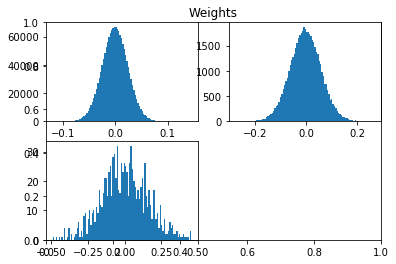

dW 0 Mean -0.00712176148749 SD 0.204538970301
dW 1 Mean 0.000831175483724 SD 0.587352719289
dW 2 Mean 0.0 SD 2.32537722459


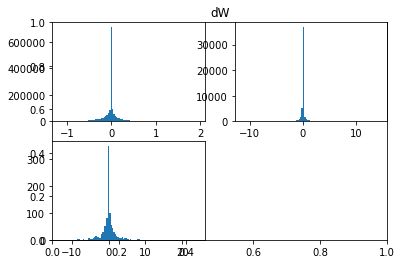

Biases 0 Mean 0.0991495348264 SD 0.03163998479
Biases 1 Mean 0.113113522766 SD 0.094939527481
Biases 2 Mean 0.1 SD 0.293500022742


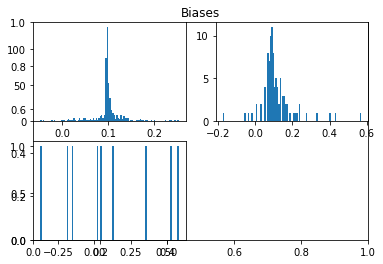

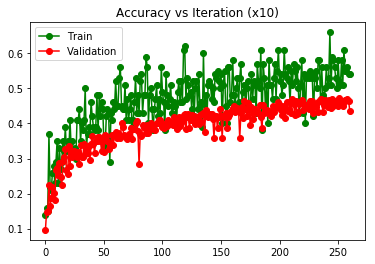

[3 4 5 2 7 1 1 7 8 9 8 7 8 2 7 9 1 0 9 9 2 1 0 5 6 7 2 9 6 5 6 8 8 1 0 9 9
 2 4 2 3 1 0 3 1 1 4 2 0 5 1 8 2 1 0 3 9 0 0 2 7 1 1 7 1 5 6 7 2 0 9 1 9 7
 8 5 5 4 2 3 9 6 7 5 0 1 1 7 7 7 7 7 5 1 6 5 8 7 0 1]
[11 18 11  5  4 10  6 16  8 11]
[6 1 7 ..., 5 5 6]
[340 745 627 275 314 574 529 638 521 437]
cost: 34.080779941621095, train accuracy: 0.65, validation accuracy: 0.4644
iterations finished: 2611 alpha: 0.00059049 reg. lambda: 0.0


[0 6 1 1 1 6 9 1 1 3 4 8 8 1 3 5 0 5 6 7 4 6 2 9 7 6 1 8 0 2 6 8 0 5 2 4 5
 6 2 6 1 1 9 1 2 0 6 2 9 7 7 2 7 8 9 6 8 4 1 0 6 1 8 3 9 8 0 0 6 6 4 9 4 3
 4 9 2 7 6 4 4 8 3 4 0 3 6 3 8 6 6 9 6 2 9 7 9 0 3 9]
[10 12  9  8 10  4 18  7 10 12]
[6 8 0 ..., 5 6 6]
[543 493 424 392 503 249 831 393 710 462]
cost: 34.92090567652309, train accuracy: 0.48, validation accuracy: 0.477
iterations finished: 2621 alpha: 0.00059049 reg. lambda: 0.0


[7 1 9 5 2 1 0 8 1 7 4 5 5 6 7 2 8 8 4 4 8 8 1 9 1 5 5 4 0 3 4 4 0 6 4 7 3
 2 0 3 0 3 6 4 3 0 3 3 4 8 8 7 1 2 0 8 7 7 1 8 7 3 4 3 

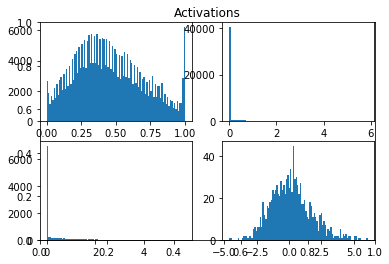

[7 1 7 6 9 8 9 5 7 6 8 8 7 8 8 9 4 4 8 8 8 6 2 8 4 3 1 8 6 7 9 9 1 0 8 0 9
 9 7 8 0 8 1 5 6 3 9 1 6 9 6 4 4 1 4 6 9 8 8 5 8 4 7 7 5 6 9 8 6 1 4 3 4 6
 4 4 8 8 5 9 9 6 8 4 7 3 4 8 6 8 7 7 5 5 6 4 3 9 9 9]
[ 3  7  1  5 14  7 14 11 22 16]
[6 8 7 ..., 5 6 6]
[313 256 184 285 502 626 673 637 890 634]
cost: 34.29472835027412, train accuracy: 0.48, validation accuracy: 0.4598
iterations finished: 2701 alpha: 0.00059049 reg. lambda: 0.0


Weights 0 Mean -0.000598514695027 SD 0.0245186990318
Weights 1 Mean -0.00219671746618 SD 0.0602178213352
Weights 2 Mean 0.000786497118276 SD 0.159318884821


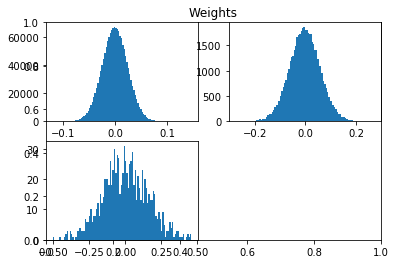

dW 0 Mean 0.0160044741567 SD 0.15354634962
dW 1 Mean 0.0159893264706 SD 0.416340014514
dW 2 Mean 2.84217094304e-17 SD 1.86400781033


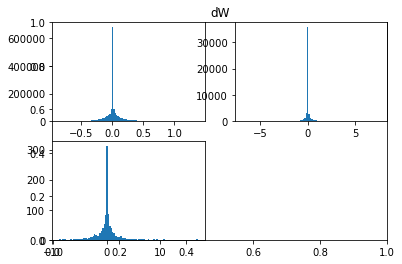

Biases 0 Mean 0.0991122543996 SD 0.0322176716607
Biases 1 Mean 0.113673925713 SD 0.0971979158568
Biases 2 Mean 0.1 SD 0.297696006227


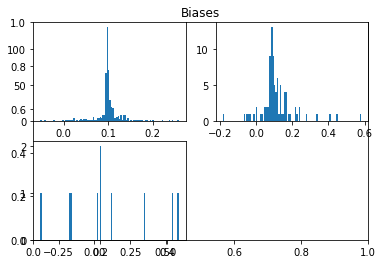

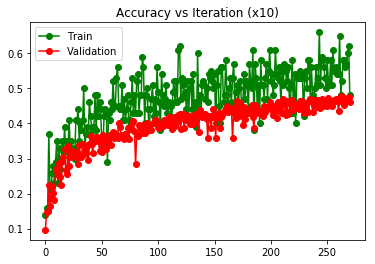

[5 7 9 7 1 6 8 0 1 0 1 0 7 0 5 0 9 6 2 2 6 6 9 7 9 0 4 2 6 1 1 0 3 6 6 1 5
 2 3 2 4 4 3 3 4 6 7 4 2 1 6 7 0 1 8 7 6 9 2 1 6 4 3 9 1 6 6 1 1 7 7 5 8 0
 5 9 6 0 1 0 2 7 0 2 8 6 0 2 3 2 8 0 1 6 1 4 8 0 7 1]
[15 16 11  6  7  5 16 11  6  7]
[6 1 7 ..., 5 6 4]
[574 559 420 226 307 435 726 764 482 507]
cost: 37.90714862425282, train accuracy: 0.61, validation accuracy: 0.4752
iterations finished: 2711 alpha: 0.00059049 reg. lambda: 0.0


[2 8 6 5 4 6 3 2 3 1 4 7 2 6 7 5 0 0 2 5 2 8 8 8 6 8 0 3 6 1 1 4 7 7 0 1 4
 7 3 8 0 2 5 1 6 1 8 5 4 6 0 6 2 3 2 9 9 5 2 6 6 6 0 1 0 3 7 0 4 6 0 9 3 8
 3 6 7 7 0 9 1 8 8 4 6 5 9 6 1 3 1 5 3 6 6 5 7 6 7 5]
[11 10  9 10  7 10 18 10 10  5]
[6 8 7 ..., 5 6 6]
[612 557 497 400 415 389 805 446 383 496]
cost: 37.01662870430401, train accuracy: 0.5, validation accuracy: 0.4698
iterations finished: 2721 alpha: 0.00059049 reg. lambda: 0.0


[7 1 0 8 4 2 8 2 1 6 9 1 3 6 4 3 7 3 5 1 2 1 1 6 4 0 3 6 5 8 5 6 4 5 3 5 6
 3 1 6 1 8 6 2 1 6 8 4 3 9 3 4 8 8 8 2 3 6 1 0 3 4 9 1 6

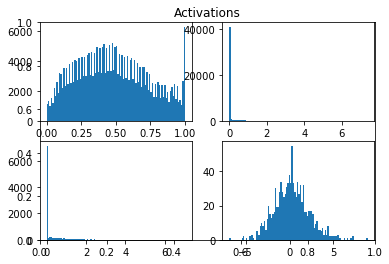

[4 4 1 3 2 9 5 9 6 4 5 7 1 8 2 1 9 9 5 4 6 3 9 6 5 7 7 2 4 6 4 7 1 5 1 0 7
 0 1 9 6 3 3 7 6 3 6 6 0 6 6 3 4 0 1 1 4 1 7 5 1 9 5 0 5 5 9 7 7 7 6 8 1 4
 0 0 1 7 7 1 3 1 8 4 5 5 6 6 5 6 3 5 5 1 6 1 9 5 0 6]
[ 8 16  3  8 10 15 16 12  3  9]
[6 1 7 ..., 5 5 6]
[244 645 230 351 406 553 790 850 352 579]
cost: 38.7672715473901, train accuracy: 0.61, validation accuracy: 0.4542
iterations finished: 2801 alpha: 0.00059049 reg. lambda: 0.0


Weights 0 Mean -0.000587286087921 SD 0.0245406165431
Weights 1 Mean -0.0022165016423 SD 0.0602925376064
Weights 2 Mean 0.000786497118276 SD 0.160207158329


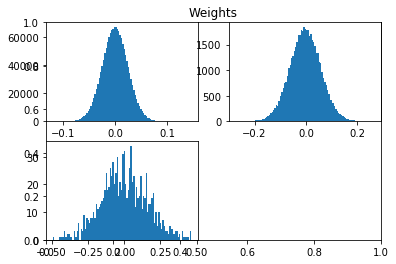

dW 0 Mean -0.00898274023559 SD 0.183915361235
dW 1 Mean -0.00149623745902 SD 0.497511635093
dW 2 Mean -2.84217094304e-17 SD 2.43023494857


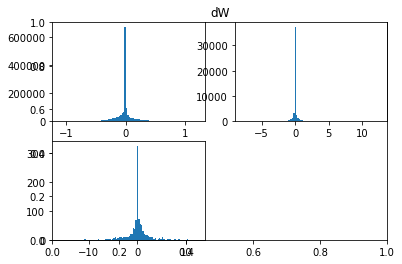

Biases 0 Mean 0.0991210993649 SD 0.033046041027
Biases 1 Mean 0.114064935884 SD 0.0994722469007
Biases 2 Mean 0.1 SD 0.303970305883


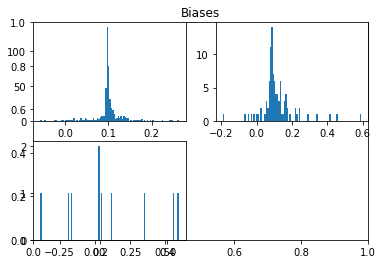

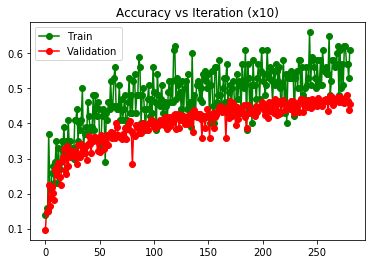

[3 7 9 3 0 7 3 6 3 1 5 9 9 8 5 2 9 0 9 9 9 9 6 8 1 7 9 9 6 9 3 1 1 9 0 8 7
 1 9 4 6 8 1 7 7 0 8 7 3 8 0 0 8 5 9 4 6 6 9 8 9 0 0 7 2 1 9 0 1 9 0 0 9 7
 4 7 9 8 4 0 8 7 1 8 6 4 9 5 0 7 0 9 9 7 3 7 5 4 5 4]
[14  9  2  7  7  6  7 14 11 23]
[6 8 0 ..., 5 0 6]
[539 355 244 390 385 277 578 599 836 797]
cost: 35.30514185129872, train accuracy: 0.59, validation accuracy: 0.4606
iterations finished: 2811 alpha: 0.00059049 reg. lambda: 0.0


[0 6 3 3 0 9 1 9 6 7 6 1 3 8 6 1 7 3 8 7 8 1 9 6 0 4 9 0 9 9 7 4 9 6 1 1 3
 0 0 1 6 0 1 2 6 1 3 5 6 2 0 1 6 1 9 1 3 6 4 6 6 6 9 1 4 8 1 3 8 0 6 3 3 6
 0 9 2 2 7 9 6 9 1 3 8 1 6 9 2 0 3 3 1 6 5 6 1 5 4 1]
[11 19  5 13  5  3 20  5  6 13]
[6 1 7 ..., 5 6 6]
[ 534  548  483  491  321  148 1072  432  490  481]
cost: 35.53878522587548, train accuracy: 0.54, validation accuracy: 0.4688
iterations finished: 2821 alpha: 0.00059049 reg. lambda: 0.0


[4 5 0 4 7 9 4 5 1 8 5 1 0 9 0 6 1 2 1 3 6 5 4 0 5 9 7 0 8 4 5 0 8 9 7 6 5
 7 6 1 0 2 4 5 9 9 5 3 7 5 7 2 5 1 9 5 3 4 0 

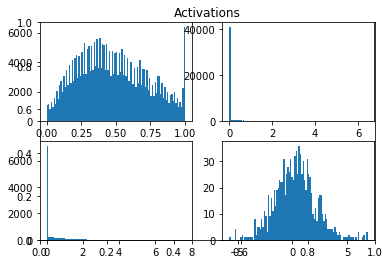

[0 5 9 9 3 1 3 8 3 4 5 0 3 6 0 6 0 0 3 9 4 5 3 6 6 7 7 7 9 6 6 8 1 5 6 1 0
 4 4 1 5 6 0 1 9 3 6 4 4 6 4 8 4 6 8 8 9 3 6 1 9 1 6 3 1 3 3 7 5 3 5 5 0 0
 7 6 5 8 9 4 0 6 9 0 6 4 9 5 1 7 6 1 6 9 8 1 8 9 2 1]
[11 12  1 12 10 10 18  6  8 12]
[6 1 7 ..., 5 6 6]
[444 581 215 413 484 329 821 488 474 751]
cost: 36.6214916364677, train accuracy: 0.63, validation accuracy: 0.4616
iterations finished: 2901 alpha: 0.00059049 reg. lambda: 0.0


Weights 0 Mean -0.000597134137269 SD 0.0245621758452
Weights 1 Mean -0.00222866787445 SD 0.0603583708111
Weights 2 Mean 0.000786497118276 SD 0.160931130977


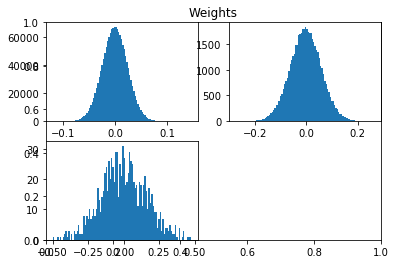

dW 0 Mean -0.0187078015632 SD 0.162688597351
dW 1 Mean -0.0129596785572 SD 0.412540982465
dW 2 Mean 0.0 SD 2.14553128065


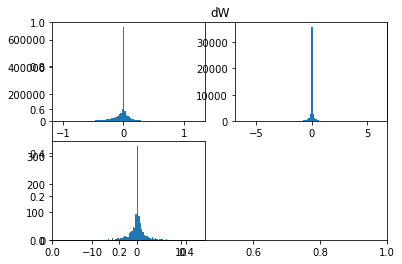

Biases 0 Mean 0.0991043293252 SD 0.0336184022581
Biases 1 Mean 0.114505384705 SD 0.101932476444
Biases 2 Mean 0.1 SD 0.310909830082


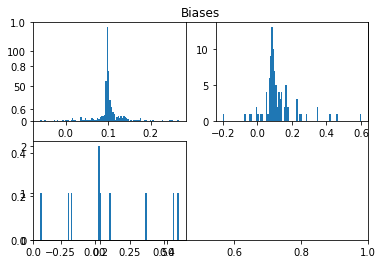

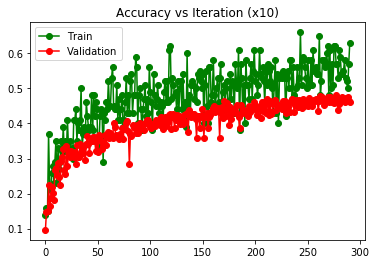

[4 9 9 5 8 7 4 3 8 7 8 1 3 8 8 9 5 7 4 8 8 5 1 5 9 4 9 7 3 7 6 3 0 1 1 2 5
 6 7 6 2 7 3 8 1 1 2 4 3 6 3 1 6 6 8 6 7 8 5 2 6 5 7 9 9 8 8 8 7 8 7 5 9 7
 9 1 4 4 2 7 2 9 8 8 3 1 8 8 8 2 2 5 3 0 5 5 6 5 2 9]
[ 2  9  9  9  7 12  9 13 19 11]
[6 8 7 ..., 5 5 6]
[186 356 593 442 246 794 314 814 722 533]
cost: 39.12404597169392, train accuracy: 0.52, validation accuracy: 0.4632
iterations finished: 2911 alpha: 0.00059049 reg. lambda: 0.0


[1 6 3 6 8 6 2 1 8 2 1 3 7 6 1 5 8 2 7 4 6 1 3 6 3 9 1 0 8 6 3 1 7 0 5 5 6
 6 3 1 9 1 3 2 2 3 5 5 5 6 2 2 2 0 8 7 8 8 4 3 1 8 4 8 7 2 6 6 1 7 3 8 7 3
 6 2 5 7 1 0 1 7 0 4 0 8 9 8 3 6 5 5 8 2 6 0 4 2 6 2]
[ 7 13 13 12  5  9 16  9 13  3]
[6 1 0 ..., 5 3 6]
[459 518 510 555 134 385 724 659 611 445]
cost: 38.94100469935734, train accuracy: 0.65, validation accuracy: 0.4766
iterations finished: 2921 alpha: 0.00059049 reg. lambda: 0.0


[1 9 0 7 5 9 1 0 5 5 3 1 1 5 6 8 9 7 7 7 4 2 3 1 5 9 9 8 9 2 1 4 0 2 8 1 0
 6 1 6 0 4 3 1 0 4 7 6 8 8 0 8 3 8 2 1 8 7 6 6 5 6 1 8 

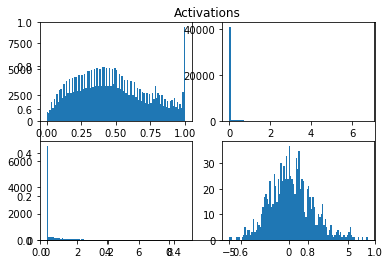

[2 9 4 4 0 8 3 5 6 4 7 0 3 1 5 7 0 1 5 0 8 0 3 1 9 4 2 6 1 8 1 6 1 1 7 6 1
 1 0 4 3 8 3 1 7 1 4 0 9 0 5 1 1 1 6 8 3 8 0 8 2 7 1 0 9 8 9 8 6 1 4 6 9 6
 8 8 5 0 0 5 1 6 8 0 3 3 4 9 9 1 6 6 0 8 0 2 8 7 4 7]
[15 18  4  8  9  6 11  7 14  8]
[6 1 7 ..., 5 3 6]
[551 711 232 523 462 283 700 513 622 403]
cost: 36.56883212208026, train accuracy: 0.59, validation accuracy: 0.48
iterations finished: 3001 alpha: 0.000531441 reg. lambda: 0.0


Weights 0 Mean -0.000605597272924 SD 0.0245839658601
Weights 1 Mean -0.00225797200579 SD 0.0604431891446
Weights 2 Mean 0.000786497118276 SD 0.16204824523


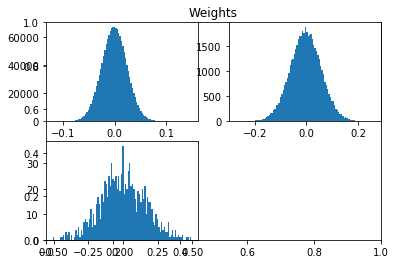

dW 0 Mean 0.00214349693076 SD 0.145601636434
dW 1 Mean -0.00282326719145 SD 0.391374249725
dW 2 Mean -7.46069872548e-17 SD 1.62494612499


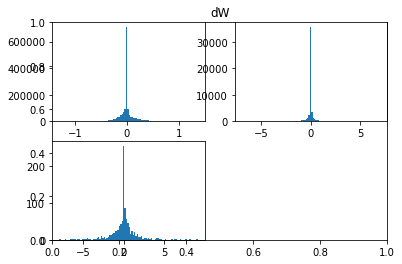

Biases 0 Mean 0.099074710745 SD 0.0341279050176
Biases 1 Mean 0.115003615312 SD 0.104548365474
Biases 2 Mean 0.1 SD 0.316168687696


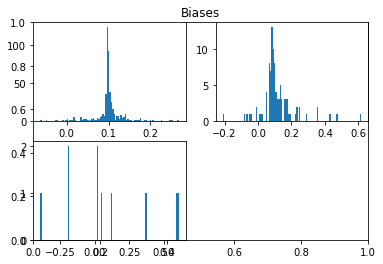

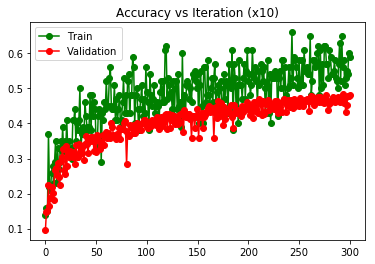

[0 3 3 2 1 3 6 8 3 7 4 2 0 9 1 2 9 9 7 8 6 6 8 3 4 1 3 9 0 6 7 7 4 0 9 5 2
 8 3 9 9 6 3 1 6 6 9 3 9 0 6 2 4 9 6 7 6 9 8 5 8 0 8 6 2 4 7 7 8 9 5 3 2 4
 6 3 9 9 3 8 7 8 1 6 6 2 3 7 6 4 7 4 1 2 7 3 4 9 4 3]
[ 6  6  9 15 10  3 15 11 10 15]
[6 8 7 ..., 5 3 6]
[352 367 384 729 449 343 626 522 588 640]
cost: 37.32747281790202, train accuracy: 0.56, validation accuracy: 0.4804
iterations finished: 3011 alpha: 0.000531441 reg. lambda: 0.0


[7 0 6 1 7 1 0 6 5 4 0 9 6 7 6 4 7 6 6 1 4 3 6 9 1 3 9 0 9 6 7 1 7 8 4 8 1
 0 1 1 4 6 8 6 4 2 6 6 9 8 5 0 4 6 6 6 1 3 2 1 2 0 0 8 1 7 8 9 6 0 6 4 4 8
 2 6 4 4 4 9 8 6 8 8 6 4 6 4 4 0 6 6 1 8 7 6 4 9 8 4]
[10 12  4  3 17  2 24  8 12  8]
[6 8 7 ..., 5 6 6]
[ 522  410  249  389  608  236 1100  440  535  511]
cost: 34.05292555890705, train accuracy: 0.56, validation accuracy: 0.467
iterations finished: 3021 alpha: 0.000531441 reg. lambda: 0.0


[9 3 8 7 8 2 5 2 1 1 7 1 1 2 2 6 3 2 2 3 5 7 1 4 0 1 3 8 7 7 4 1 5 8 2 4 9
 1 5 7 7 2 0 5 6 1 1 7 5 3 7 9 8 9 1 8 6 5 7

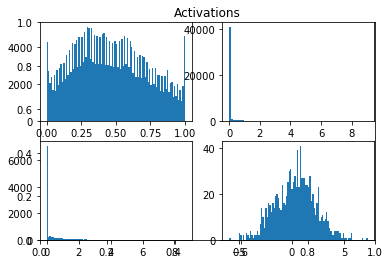

[2 1 1 8 3 7 9 9 7 9 5 9 7 5 3 1 7 1 2 8 5 8 1 3 4 3 1 1 8 3 7 1 2 7 5 9 1
 8 4 1 7 5 9 7 6 3 5 1 6 9 1 3 1 6 8 9 6 2 5 3 8 3 3 3 5 4 7 4 0 2 2 7 6 8
 2 8 1 4 3 6 6 4 4 2 8 9 6 0 9 5 6 7 1 9 1 6 0 5 6 1]
[ 3 17  8 12  7 10 11 11 10 11]
[6 1 7 ..., 5 3 6]
[357 872 522 402 340 416 598 317 516 660]
cost: 36.873509275828866, train accuracy: 0.57, validation accuracy: 0.4646
iterations finished: 3101 alpha: 0.000531441 reg. lambda: 0.0


Weights 0 Mean -0.000604354679873 SD 0.0246031449947
Weights 1 Mean -0.00226480173461 SD 0.0605122730834
Weights 2 Mean 0.000786497118276 SD 0.162903929917


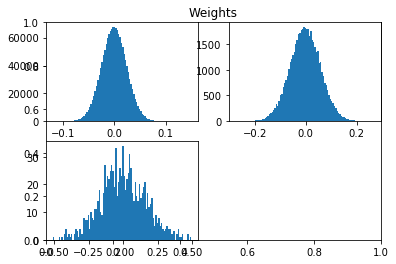

dW 0 Mean -0.0125894916926 SD 0.207009336868
dW 1 Mean 0.0190682441665 SD 0.577713278999
dW 2 Mean 4.97379915032e-17 SD 2.35523756468


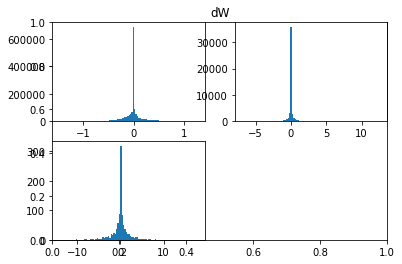

Biases 0 Mean 0.0990876397108 SD 0.0346845691474
Biases 1 Mean 0.115537667914 SD 0.106703664218
Biases 2 Mean 0.1 SD 0.320507662541


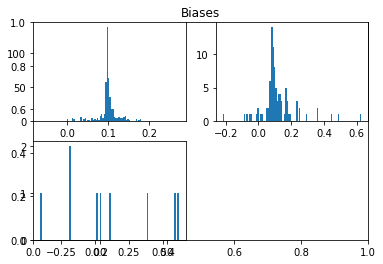

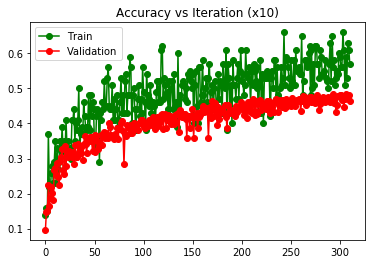

[4 4 9 7 7 2 5 0 7 0 4 4 4 9 7 1 9 4 6 2 7 1 6 7 0 9 4 1 4 4 1 5 5 2 4 0 7
 4 4 9 4 7 9 2 0 6 7 4 1 9 0 1 5 7 5 0 9 6 5 9 0 1 0 3 6 9 4 5 0 6 7 0 9 8
 7 2 4 4 7 3 0 3 0 9 8 9 4 6 4 8 6 2 9 0 7 7 4 4 9 0]
[15  7  6  3 21  7  8 15  3 15]
[6 1 7 ..., 5 6 4]
[376 582 309 271 852 271 514 764 269 792]
cost: 35.42530477190117, train accuracy: 0.55, validation accuracy: 0.4512
iterations finished: 3111 alpha: 0.000531441 reg. lambda: 0.0


[2 9 6 4 7 2 4 9 2 6 9 4 7 6 0 4 3 4 1 0 3 2 4 3 9 6 2 3 2 9 9 3 8 9 9 6 9
 8 2 8 0 7 8 1 3 3 9 2 2 3 8 8 6 3 2 3 7 9 0 7 9 8 3 2 5 3 8 2 2 3 9 9 8 2
 6 9 0 1 9 5 4 2 1 0 2 0 1 8 4 4 7 8 7 7 3 8 9 3 0 2]
[ 8  5 17 15  9  2  7  8 12 17]
[6 8 7 ..., 5 6 6]
[329 397 785 787 350 210 501 383 453 805]
cost: 33.57676679840398, train accuracy: 0.56, validation accuracy: 0.4676
iterations finished: 3121 alpha: 0.000531441 reg. lambda: 0.0


[1 3 9 9 4 4 6 4 0 7 2 1 0 8 3 5 5 4 7 0 4 6 8 6 6 3 0 4 6 1 3 3 7 4 6 6 9
 6 7 9 3 1 7 1 1 1 8 3 6 5 3 7 7 1 8 4 4 3 8 3 0 4 0 

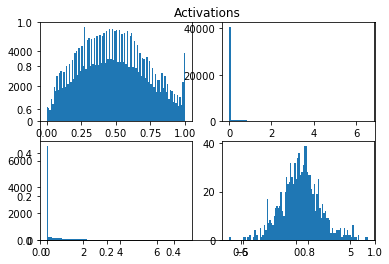

[3 3 5 6 8 4 7 8 8 3 7 6 4 2 6 8 0 5 1 3 2 0 6 6 6 7 3 8 3 6 8 5 3 8 6 7 5
 6 7 5 8 8 6 0 1 3 6 5 6 8 3 6 1 7 8 8 3 7 5 6 3 6 2 7 3 3 7 6 6 6 6 5 6 9
 6 0 5 3 3 9 8 3 6 2 6 0 0 9 0 3 1 5 5 6 3 3 0 7 8 7]
[ 8  4  4 19  2 11 24 11 14  3]
[6 8 6 ..., 5 5 6]
[ 301  531  330  670  193  470 1136  254  672  443]
cost: 36.29635409415223, train accuracy: 0.58, validation accuracy: 0.446
iterations finished: 3201 alpha: 0.000531441 reg. lambda: 0.0


Weights 0 Mean -0.000592913347822 SD 0.0246218602482
Weights 1 Mean -0.00229781957173 SD 0.0605807145237
Weights 2 Mean 0.000786497118276 SD 0.16379588926


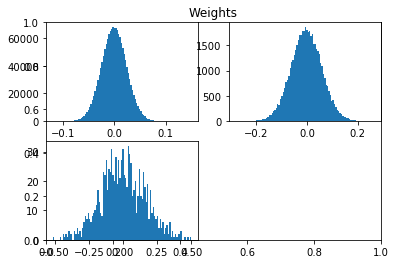

dW 0 Mean 0.0212728027023 SD 0.269233109738
dW 1 Mean 0.0313459052007 SD 0.606067106235
dW 2 Mean 5.68434188608e-17 SD 2.32559015807


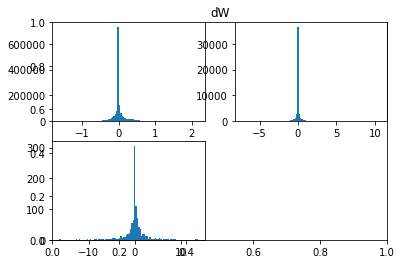

Biases 0 Mean 0.0991082421541 SD 0.0351403825317
Biases 1 Mean 0.11587422325 SD 0.109130397529
Biases 2 Mean 0.1 SD 0.324631159346


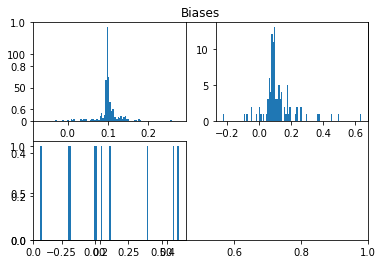

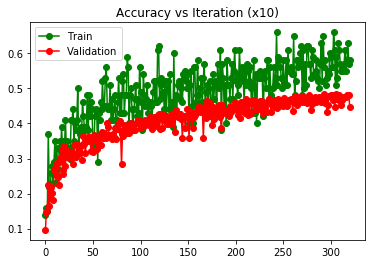

[0 9 9 6 4 2 1 4 2 7 0 0 0 3 2 1 0 7 7 5 1 9 7 1 3 1 4 1 7 5 3 1 7 3 5 7 9
 1 7 7 1 5 6 0 6 0 1 8 1 9 1 7 0 6 3 4 5 6 1 8 1 7 5 1 1 1 7 3 5 0 9 3 1 0
 0 1 4 5 6 4 4 1 7 5 1 7 7 1 4 1 7 0 1 5 7 9 3 1 3 5]
[12 25  3  9  8 11  6 17  2  7]
[6 1 7 ..., 5 3 4]
[541 946 235 466 430 461 375 870 277 399]
cost: 35.60483793998378, train accuracy: 0.61, validation accuracy: 0.4506
iterations finished: 3211 alpha: 0.000531441 reg. lambda: 0.0


[6 6 8 2 4 8 7 8 2 8 9 6 3 1 4 6 1 6 4 0 8 3 4 6 8 4 4 5 7 4 6 8 4 6 1 2 5
 7 8 9 8 8 3 4 2 6 2 5 8 7 6 0 4 9 4 4 1 5 4 6 3 6 3 4 8 3 0 9 6 9 6 8 9 1
 8 8 4 9 4 0 4 6 8 6 6 9 4 7 9 5 6 5 1 0 8 6 4 1 3 9]
[ 5  7  5  7 19  6 19  5 17 10]
[6 8 7 ..., 5 6 6]
[ 268  461  209  502  665  297 1080  338  765  415]
cost: 36.33804662829506, train accuracy: 0.56, validation accuracy: 0.458
iterations finished: 3221 alpha: 0.000531441 reg. lambda: 0.0


[8 3 5 8 6 8 9 1 7 5 4 9 7 3 3 4 8 0 4 8 1 6 0 0 4 0 8 3 1 8 1 9 7 8 0 9 6
 9 3 5 5 1 4 8 8 8 5 6 5 3 7 8 6 0 2 7 6 4 8

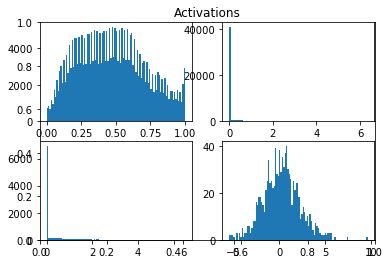

[9 5 8 4 8 4 8 1 9 2 1 3 9 2 0 3 1 8 0 5 5 4 7 8 5 4 8 2 3 9 9 9 3 2 2 3 2
 5 7 6 2 8 1 8 2 1 0 9 6 1 7 9 0 5 9 9 1 5 5 5 5 5 9 1 7 2 5 6 6 0 5 9 6 9
 7 1 2 3 9 4 2 7 6 4 2 5 1 8 9 6 7 9 1 9 3 1 6 1 6 4]
[ 5 13 12  7  7 14  9  7  9 17]
[6 1 7 ..., 5 5 6]
[457 545 498 360 372 688 505 491 412 672]
cost: 38.32283847138987, train accuracy: 0.57, validation accuracy: 0.481
iterations finished: 3301 alpha: 0.000531441 reg. lambda: 0.0


Weights 0 Mean -0.000605676047789 SD 0.0246408890079
Weights 1 Mean -0.00224773837532 SD 0.0606643643192
Weights 2 Mean 0.000786497118276 SD 0.164913955084


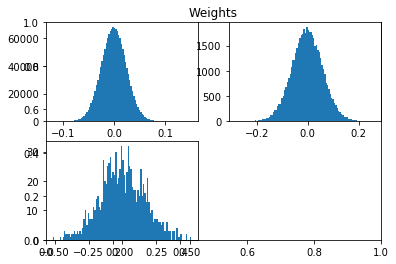

dW 0 Mean -0.00123027780173 SD 0.162098428266
dW 1 Mean -0.00169252545999 SD 0.411024287987
dW 2 Mean 3.5527136788e-17 SD 1.6997092154


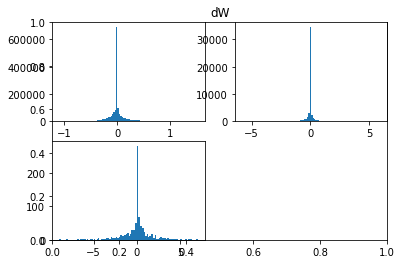

Biases 0 Mean 0.0991043913372 SD 0.0358239246063
Biases 1 Mean 0.116709114699 SD 0.111277202413
Biases 2 Mean 0.1 SD 0.32854593509


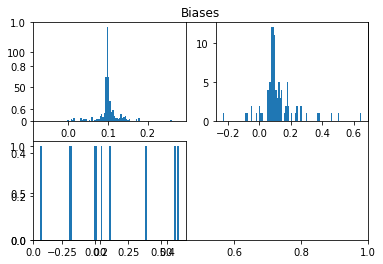

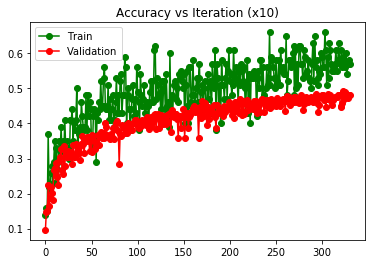

[0 6 4 2 0 5 8 5 3 0 5 5 0 3 7 6 8 3 2 8 8 1 9 8 5 9 7 1 1 1 1 4 3 7 5 0 0
 8 1 8 6 8 0 1 8 6 7 7 7 4 1 9 6 9 6 8 4 0 6 7 6 5 7 5 3 5 6 6 4 7 5 7 3 6
 9 7 6 3 8 6 0 8 9 1 6 7 8 2 4 3 7 7 6 9 0 6 8 5 9 2]
[10  9  4  8  6 11 16 14 14  8]
[6 1 7 ..., 5 6 6]
[432 550 490 363 593 328 773 459 601 411]
cost: 36.98824071566127, train accuracy: 0.57, validation accuracy: 0.4866
iterations finished: 3311 alpha: 0.000531441 reg. lambda: 0.0


[9 4 9 5 8 4 3 3 0 7 4 7 9 3 6 4 7 7 3 8 8 0 8 4 4 9 5 4 7 4 1 7 3 0 3 9 1
 9 7 7 7 5 9 4 7 9 5 3 7 3 4 0 8 7 1 5 9 0 4 8 9 8 7 8 7 7 3 9 4 4 3 1 9 8
 7 7 4 0 7 1 7 1 7 7 0 7 7 6 3 4 8 1 2 6 3 7 7 7 0 4]
[ 8  7  1 12 16  5  3 26 10 12]
[6 8 7 ..., 5 4 4]
[ 462  401  218  352  770  261  418 1035  537  546]
cost: 34.07842824602628, train accuracy: 0.56, validation accuracy: 0.4634
iterations finished: 3321 alpha: 0.000531441 reg. lambda: 0.0


[7 4 3 7 6 7 7 0 0 0 7 5 0 3 3 0 9 2 1 7 4 5 6 0 4 3 0 5 4 1 2 8 6 4 3 0 1
 8 3 8 3 1 8 8 9 2 1 9 5 2 9 0 2 0 1 1 1 2 

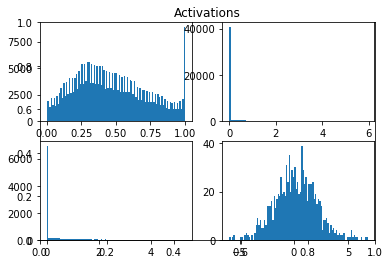

[8 9 1 7 5 9 3 5 6 2 3 5 3 2 6 1 1 5 1 7 3 9 8 3 3 6 7 5 0 3 9 9 8 3 5 6 6
 7 3 1 3 9 6 1 6 9 6 6 3 8 7 7 1 1 5 3 8 3 5 6 9 7 9 7 7 9 9 6 2 5 3 2 8 8
 6 7 6 0 6 6 3 6 0 5 1 9 2 3 7 0 9 5 6 1 9 6 8 3 6 5]
[ 4 10  5 17  0 12 19 11  8 14]
[6 1 7 ..., 5 6 6]
[318 516 560 435 104 560 789 551 521 646]
cost: 36.894714704104516, train accuracy: 0.47, validation accuracy: 0.4714
iterations finished: 3401 alpha: 0.000531441 reg. lambda: 0.0


Weights 0 Mean -0.000604166871424 SD 0.024660763294
Weights 1 Mean -0.00227473093798 SD 0.0607363924782
Weights 2 Mean 0.000786497118276 SD 0.165836740576


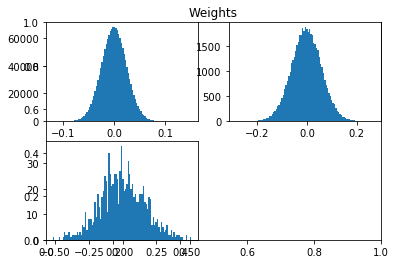

dW 0 Mean 0.00333937271278 SD 0.197096472337
dW 1 Mean 0.0193803506479 SD 0.509650515669
dW 2 Mean -5.68434188608e-17 SD 2.14146161555


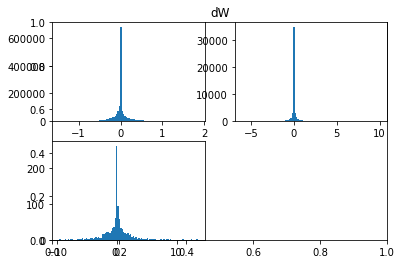

Biases 0 Mean 0.0990632584418 SD 0.0364629551844
Biases 1 Mean 0.117140013529 SD 0.113613187098
Biases 2 Mean 0.1 SD 0.331156515994


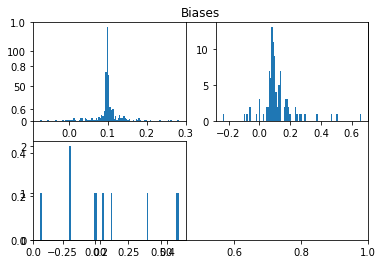

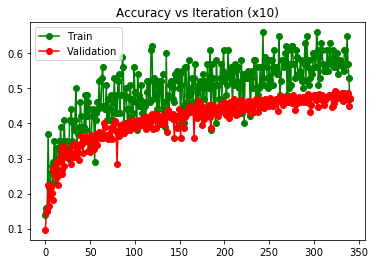

[2 0 4 3 8 3 3 1 7 5 6 2 5 9 2 6 1 1 0 8 1 5 5 4 4 0 0 0 0 1 5 7 0 6 6 3 5
 6 0 3 7 9 1 9 0 7 0 8 3 7 0 7 5 5 3 8 1 6 3 0 9 7 1 2 3 8 2 5 2 5 8 7 1 3
 0 3 2 9 6 0 0 8 5 8 9 3 8 3 3 9 7 3 5 5 1 3 0 0 5 5]
[17 10  7 16  3 15  7  9  9  7]
[6 1 7 ..., 5 5 6]
[479 809 415 542 267 619 432 553 492 392]
cost: 36.2828654360506, train accuracy: 0.5, validation accuracy: 0.4804
iterations finished: 3411 alpha: 0.000531441 reg. lambda: 0.0


[9 8 9 3 1 2 7 1 7 3 0 0 3 2 9 7 0 6 9 7 8 0 7 5 2 7 4 7 1 2 9 2 6 2 4 8 2
 7 9 7 2 7 9 9 9 4 9 0 9 6 6 9 9 2 8 2 1 5 0 5 2 2 5 7 2 2 8 8 7 4 7 4 4 0
 9 9 2 2 4 0 1 8 2 9 3 7 3 3 7 8 5 7 0 4 3 4 9 4 3 1]
[ 9  6 17  8 10  5  4 16  8 17]
[6 8 7 ..., 5 6 2]
[297 280 670 446 347 319 417 835 565 824]
cost: 35.74889874136398, train accuracy: 0.59, validation accuracy: 0.4712
iterations finished: 3421 alpha: 0.000531441 reg. lambda: 0.0


[0 9 2 3 2 8 8 1 1 0 1 9 3 8 6 6 6 9 4 9 4 6 6 2 2 7 2 2 3 6 0 6 1 6 2 3 4
 0 2 7 5 2 2 5 0 6 4 6 4 5 6 5 2 6 6 0 2 7 0 0 5 5 0 2 

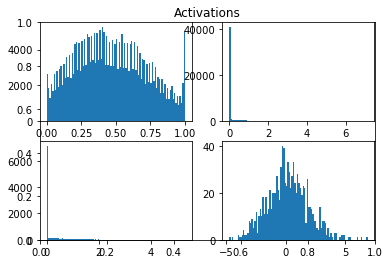

[2 6 2 6 8 3 0 8 0 3 1 8 1 2 9 7 8 1 1 6 7 2 4 2 8 2 3 1 3 4 1 2 7 7 7 9 9
 2 5 6 2 7 8 9 8 3 2 1 1 8 8 1 8 4 8 7 4 1 1 3 4 9 3 9 0 9 5 0 3 8 6 4 7 8
 9 0 0 2 7 5 9 5 3 7 7 6 2 8 2 8 7 1 6 7 1 2 1 3 4 5]
[ 6 14 14 10  7  5  7 13 15  9]
[6 8 7 ..., 5 6 4]
[359 517 493 425 443 418 580 525 711 529]
cost: 35.67236058759374, train accuracy: 0.54, validation accuracy: 0.4914
iterations finished: 3501 alpha: 0.0004782969 reg. lambda: 0.0


Weights 0 Mean -0.00060282375116 SD 0.0246774737297
Weights 1 Mean -0.0023501586004 SD 0.060783843084
Weights 2 Mean 0.000786497118276 SD 0.166359016637


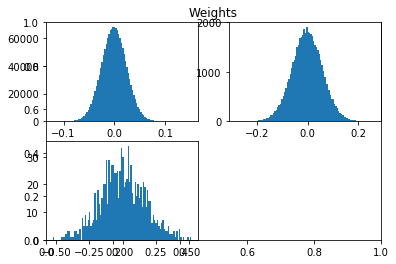

dW 0 Mean -0.0115181266797 SD 0.136095580954
dW 1 Mean -0.00500786197159 SD 0.430817956076
dW 2 Mean 0.0 SD 1.82693525366


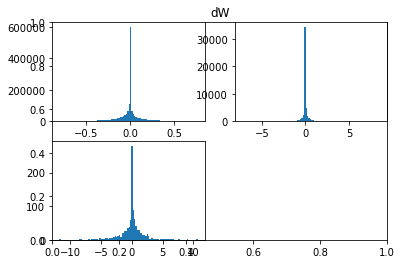

Biases 0 Mean 0.0990359551567 SD 0.0369376898645
Biases 1 Mean 0.117139111649 SD 0.116176013502
Biases 2 Mean 0.1 SD 0.336633030117


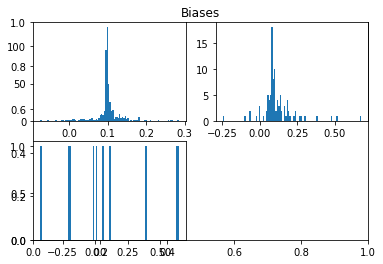

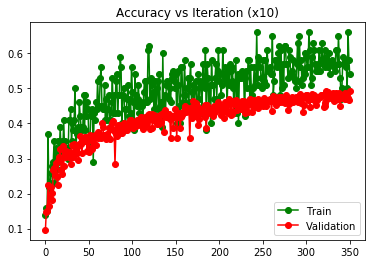

[8 9 7 9 9 8 7 6 4 8 4 7 2 9 5 0 8 1 6 3 2 9 2 1 9 7 8 4 1 7 2 2 8 9 6 7 2
 9 1 9 6 2 8 3 6 7 6 7 2 3 8 6 4 8 4 3 6 6 3 3 6 9 9 8 3 8 6 0 9 6 8 1 7 5
 9 3 8 8 8 0 3 0 7 0 8 9 5 4 7 7 8 0 8 4 0 6 2 6 0 8]
[ 8  5  9  9  7  3 14 12 19 14]
[6 8 7 ..., 5 6 6]
[323 357 307 460 496 290 784 530 797 656]
cost: 35.1154876761677, train accuracy: 0.58, validation accuracy: 0.4818
iterations finished: 3511 alpha: 0.0004782969 reg. lambda: 0.0


[8 1 7 7 3 1 9 1 9 1 0 6 7 8 5 0 0 3 4 1 6 3 8 8 6 6 6 2 7 3 5 5 0 2 6 9 0
 6 9 2 6 8 2 0 5 9 9 5 0 2 6 1 6 5 1 9 6 7 1 5 0 4 6 0 6 8 4 0 7 6 2 7 6 1
 6 5 2 6 6 5 6 6 4 6 9 6 8 9 5 6 1 8 8 5 2 0 5 5 3 5]
[11 10  8  5  4 14 23  7  9  9]
[6 8 7 ..., 5 6 6]
[ 542  445  375  201  454  533 1053  428  579  390]
cost: 37.300923574360404, train accuracy: 0.57, validation accuracy: 0.4782
iterations finished: 3521 alpha: 0.0004782969 reg. lambda: 0.0


[8 1 1 0 8 9 1 1 0 8 2 5 9 2 0 1 2 8 4 7 8 6 3 7 6 8 3 7 0 2 2 1 3 6 9 7 3
 1 6 1 3 7 3 1 0 4 5 0 8 6 9 2 9 9 6 1 9 

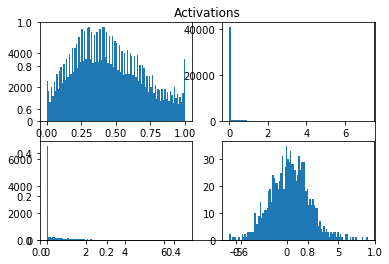

[4 8 4 4 9 8 4 2 3 1 4 4 4 2 1 0 2 8 2 0 0 0 5 0 2 0 1 8 0 2 2 8 6 6 6 0 4
 3 4 3 1 4 7 9 1 0 5 5 2 4 2 4 9 0 6 1 2 4 2 4 9 1 3 6 4 9 0 1 4 7 4 2 1 5
 4 5 0 7 9 6 9 4 1 0 4 4 6 4 5 4 1 1 9 2 6 1 0 1 1 0]
[15 15 13  4 23  6  8  3  5  8]
[6 8 0 ..., 5 6 4]
[760 709 650 409 696 223 524 321 351 357]
cost: 36.79603323085042, train accuracy: 0.52, validation accuracy: 0.472
iterations finished: 3601 alpha: 0.0004782969 reg. lambda: 0.0


Weights 0 Mean -0.000605959045028 SD 0.0246937001684
Weights 1 Mean -0.0023462859831 SD 0.0608502943453
Weights 2 Mean 0.000786497118276 SD 0.167204178469


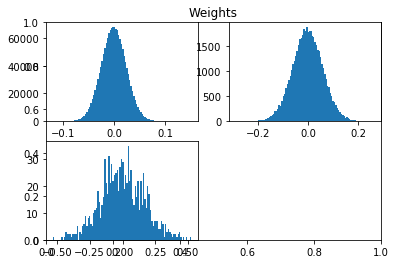

dW 0 Mean -0.00146218806312 SD 0.178836473863
dW 1 Mean 0.00399972158939 SD 0.499184136767
dW 2 Mean -1.13686837722e-16 SD 2.39759931151


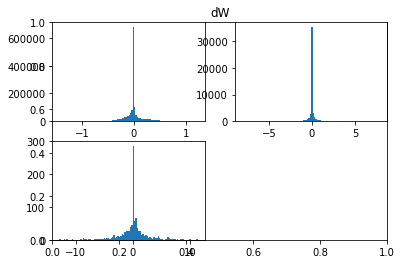

Biases 0 Mean 0.0990101284426 SD 0.0374056952815
Biases 1 Mean 0.117559218076 SD 0.117993403949
Biases 2 Mean 0.1 SD 0.339878187185


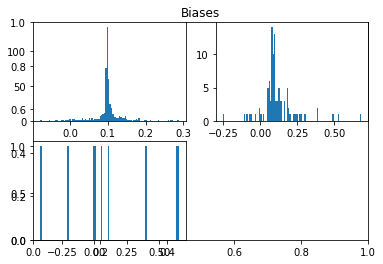

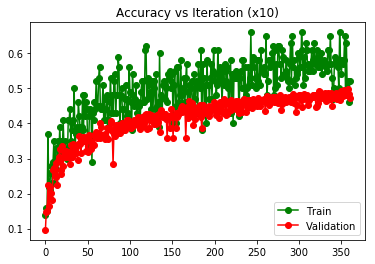

[6 7 1 6 9 0 6 0 2 3 3 0 1 1 9 2 6 8 9 5 2 6 7 6 5 8 9 9 9 8 9 6 0 3 4 3 1
 3 6 1 8 1 4 5 1 7 1 5 1 9 7 4 2 7 2 9 1 9 9 2 9 6 2 2 6 2 0 0 1 6 6 7 0 5
 8 0 9 6 2 1 7 9 6 1 0 0 6 2 7 2 7 0 4 4 1 6 0 9 9 3]
[12 14 12  6  5  5 16  9  5 16]
[6 1 0 ..., 5 0 6]
[654 564 562 366 413 226 636 526 388 665]
cost: 35.94638349417242, train accuracy: 0.56, validation accuracy: 0.4862
iterations finished: 3611 alpha: 0.0004782969 reg. lambda: 0.0


[6 4 4 1 6 8 8 2 2 4 9 5 9 7 3 4 7 0 2 5 2 6 2 8 3 7 3 8 8 1 1 5 0 5 2 9 8
 9 5 8 9 5 9 8 8 1 2 8 1 8 6 6 6 1 5 2 0 9 5 5 5 9 4 3 7 5 8 7 8 8 1 8 2 5
 5 1 8 8 1 2 3 9 1 2 2 1 8 2 8 8 5 3 1 9 6 8 1 9 8 9]
[ 3 13 13  6  5 14  7  5 22 12]
[6 8 7 ..., 5 6 6]
[360 493 718 365 368 539 477 353 707 620]
cost: 36.80742911525625, train accuracy: 0.57, validation accuracy: 0.4824
iterations finished: 3621 alpha: 0.0004782969 reg. lambda: 0.0


[7 0 2 9 1 9 1 6 1 7 8 1 7 3 4 4 1 5 6 6 8 8 3 9 6 3 5 0 9 1 8 6 2 6 7 6 7
 5 6 1 6 3 2 9 9 8 5 8 8 1 2 6 9 1 3 8 9 7 6 4 6 9 

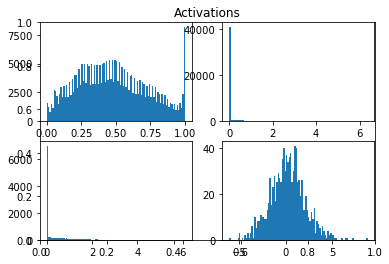

[9 0 7 6 2 7 3 1 5 1 5 7 4 5 4 1 8 1 3 4 8 1 6 1 5 0 8 2 1 7 8 1 6 7 1 2 7
 1 9 4 1 9 1 8 7 1 7 2 4 7 1 3 0 0 6 9 6 4 6 6 0 9 1 1 1 3 1 1 0 7 5 6 0 8
 9 6 0 2 0 1 8 1 4 9 7 0 3 7 4 9 0 8 2 7 8 1 5 7 2 1]
[11 23  7  5  8  6  9 14  9  8]
[6 1 7 ..., 5 6 6]
[613 728 383 467 338 356 652 533 489 441]
cost: 36.84189640208185, train accuracy: 0.58, validation accuracy: 0.4922
iterations finished: 3701 alpha: 0.0004782969 reg. lambda: 0.0


Weights 0 Mean -0.000590389654741 SD 0.024709930928
Weights 1 Mean -0.00234564339983 SD 0.0609136394728
Weights 2 Mean 0.000786497118276 SD 0.168006958347


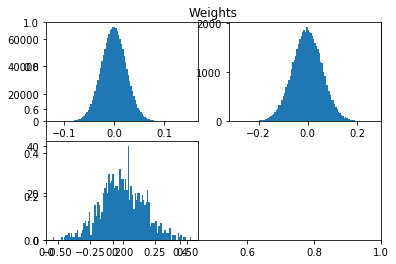

dW 0 Mean -0.0154725789805 SD 0.167635124311
dW 1 Mean -0.00456423661177 SD 0.402613891786
dW 2 Mean 0.0 SD 1.47361334445


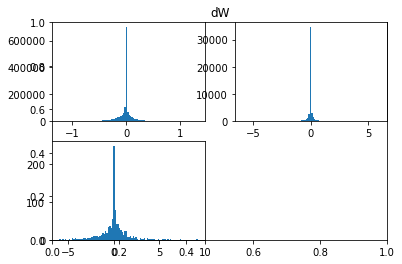

Biases 0 Mean 0.0990061316159 SD 0.0377996957711
Biases 1 Mean 0.117946644354 SD 0.119665793653
Biases 2 Mean 0.1 SD 0.343787696244


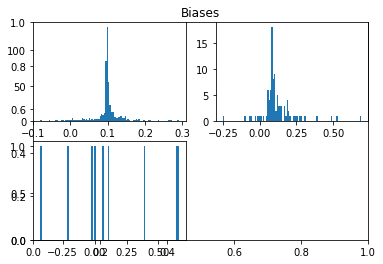

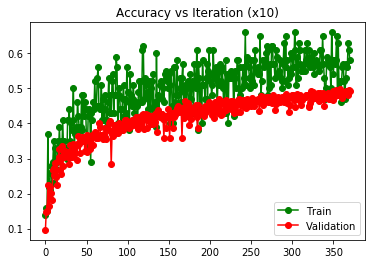

[7 2 2 5 2 8 3 7 9 0 0 0 6 6 7 9 7 6 1 3 6 0 5 4 6 0 6 4 7 2 7 7 0 0 6 6 4
 1 0 1 0 4 5 1 0 0 4 9 0 9 3 0 9 4 9 5 8 5 5 3 9 1 5 6 9 2 6 9 1 2 6 8 5 6
 1 1 3 6 5 0 0 6 4 2 3 1 9 6 4 0 7 0 0 5 6 2 6 6 8 3]
[18  9  8  7  8 10 18  8  4 10]
[6 8 7 ..., 5 6 6]
[723 538 375 343 365 520 743 544 436 413]
cost: 35.74191597092661, train accuracy: 0.57, validation accuracy: 0.495
iterations finished: 3711 alpha: 0.0004782969 reg. lambda: 0.0


[3 0 7 1 5 2 5 1 6 3 5 3 4 1 8 6 1 8 3 8 8 0 9 8 8 3 0 6 2 8 2 1 2 5 4 6 6
 8 3 7 7 7 6 6 3 2 7 6 0 2 0 3 2 6 8 2 4 4 1 8 8 2 7 8 8 8 5 1 2 1 1 1 2 9
 3 9 1 4 4 0 2 5 4 0 2 7 1 3 8 6 4 5 6 3 9 2 8 6 1 8]
[ 7 13 14 11  8  7 12  7 17  4]
[6 1 0 ..., 5 6 6]
[330 709 554 384 353 340 888 422 640 380]
cost: 36.928726715057664, train accuracy: 0.58, validation accuracy: 0.4912
iterations finished: 3721 alpha: 0.0004782969 reg. lambda: 0.0


[0 7 1 6 3 6 2 6 6 2 5 2 5 1 5 7 8 6 4 3 6 9 8 9 6 1 2 3 8 9 8 6 2 2 0 3 8
 8 7 4 9 2 8 3 3 6 9 7 6 5 8 6 5 2 5 5 5 8 6 3 9 7 

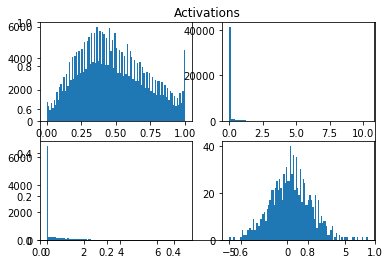

[5 9 0 1 7 4 5 5 5 7 7 7 0 8 3 5 1 7 8 5 9 2 8 9 5 5 7 5 5 8 9 2 2 9 2 7 7
 4 0 8 9 9 6 6 7 4 0 1 7 9 1 1 1 8 4 7 9 3 0 6 0 0 0 9 7 3 7 1 0 0 6 7 0 7
 9 7 8 0 8 3 7 0 7 8 7 9 1 8 5 9 5 5 8 7 9 8 4 2 9 1]
[13  9  5  4  5 13  4 20 12 15]
[6 8 7 ..., 5 5 4]
[471 535 341 265 292 680 407 818 632 559]
cost: 34.954235934988866, train accuracy: 0.58, validation accuracy: 0.4844
iterations finished: 3801 alpha: 0.0004782969 reg. lambda: 0.0


Weights 0 Mean -0.000594583314637 SD 0.0247259429203
Weights 1 Mean -0.00231539523472 SD 0.0609777684441
Weights 2 Mean 0.000786497118276 SD 0.16879517913


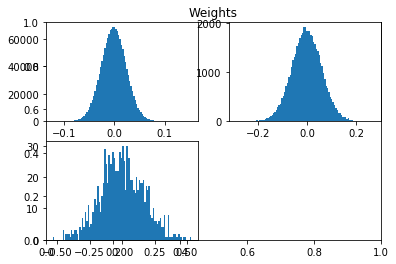

dW 0 Mean -0.00652894281019 SD 0.188992813198
dW 1 Mean -0.0150374434064 SD 0.496416968485
dW 2 Mean 0.0 SD 2.06332983645


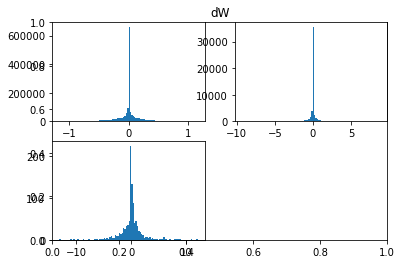

Biases 0 Mean 0.0989565338522 SD 0.0381758669495
Biases 1 Mean 0.118650582072 SD 0.121437965486
Biases 2 Mean 0.1 SD 0.345016696754


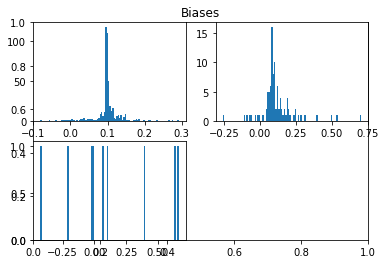

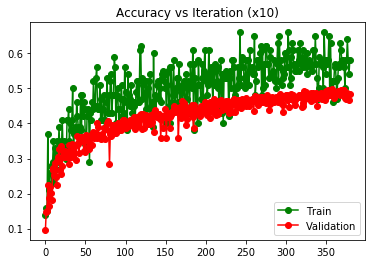

[1 4 0 3 7 2 0 4 5 8 2 0 6 6 9 9 2 2 6 8 4 7 9 1 0 3 7 9 1 8 1 9 0 6 9 2 9
 6 0 3 5 7 7 0 2 3 3 6 0 2 6 2 7 6 8 6 5 7 4 4 7 3 2 1 1 3 9 7 3 0 9 9 4 0
 3 6 7 8 0 9 8 1 5 3 0 2 8 1 4 1 1 5 4 6 7 6 7 3 7 1]
[12 11 10 11  8  5 12 13  7 11]
[6 1 7 ..., 5 3 6]
[444 573 577 738 288 276 562 573 404 565]
cost: 35.38419164929457, train accuracy: 0.55, validation accuracy: 0.4852
iterations finished: 3811 alpha: 0.0004782969 reg. lambda: 0.0


[1 0 4 7 2 3 2 4 0 6 3 7 0 1 1 4 5 4 7 8 4 0 6 0 5 0 8 4 7 7 9 8 8 1 3 0 1
 0 6 2 8 9 9 8 9 4 4 8 9 0 3 1 7 6 0 4 2 4 2 8 7 7 0 4 4 1 0 2 4 4 6 2 6 4
 8 0 2 0 0 4 8 9 3 3 6 4 5 3 0 1 3 8 5 6 0 4 9 0 9 7]
[18  8  8  8 18  4  8  9 11  8]
[6 8 7 ..., 5 6 4]
[544 445 437 377 915 256 739 380 607 300]
cost: 38.118248122595034, train accuracy: 0.5, validation accuracy: 0.4742
iterations finished: 3821 alpha: 0.0004782969 reg. lambda: 0.0


[4 1 6 6 4 7 6 4 9 9 6 0 6 9 4 4 6 5 4 1 1 1 6 8 7 0 4 5 3 9 9 4 3 8 5 1 6
 4 1 8 2 0 6 4 4 6 8 9 6 9 6 7 6 4 3 8 4 7 8 1 1 4 

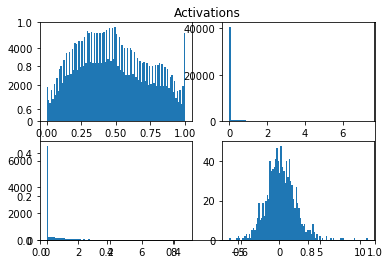

[2 5 8 4 8 3 6 5 4 0 5 1 6 7 8 9 7 1 7 4 2 7 2 4 6 6 5 6 7 6 7 1 9 1 0 8 2
 6 6 7 3 6 5 1 7 9 6 8 6 9 8 0 1 0 7 5 6 7 5 6 9 9 0 9 9 1 1 3 3 8 0 7 9 8
 8 8 8 6 8 9 6 9 8 1 9 3 1 6 9 2 6 6 9 2 1 1 0 7 4 1]
[ 7 13  6  5  5  7 18 12 13 14]
[6 8 7 ..., 5 6 6]
[465 514 511 359 448 299 865 445 490 604]
cost: 36.34950996929292, train accuracy: 0.51, validation accuracy: 0.4936
iterations finished: 3901 alpha: 0.0004782969 reg. lambda: 0.0


Weights 0 Mean -0.000605814106961 SD 0.024741133747
Weights 1 Mean -0.00235924574864 SD 0.0610285705892
Weights 2 Mean 0.000786497118276 SD 0.169412206202


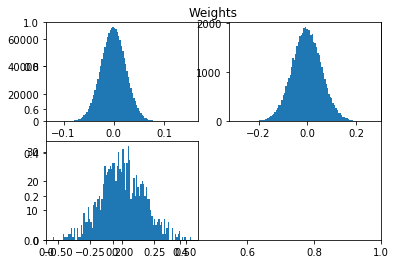

dW 0 Mean 0.0102263383536 SD 0.154944517773
dW 1 Mean -0.00394187538616 SD 0.419649035858
dW 2 Mean 0.0 SD 1.77851975445


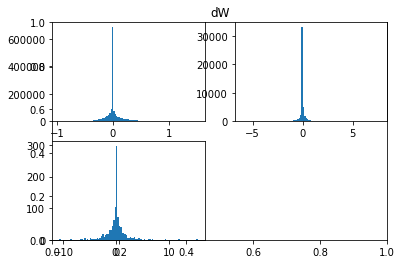

Biases 0 Mean 0.0989321140493 SD 0.0386908092808
Biases 1 Mean 0.118764720491 SD 0.12372530309
Biases 2 Mean 0.1 SD 0.350499541556


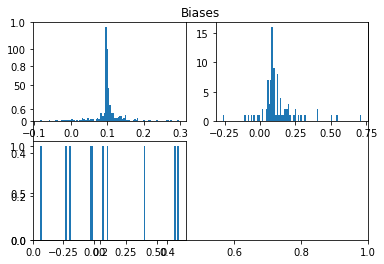

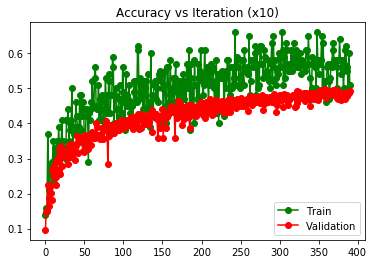

[5 6 8 0 5 6 3 8 6 2 3 6 4 2 0 6 5 1 9 7 0 0 3 0 0 9 9 0 7 2 2 4 2 7 5 6 9
 1 5 7 6 2 9 3 5 4 9 9 6 9 6 3 4 0 9 0 6 9 4 3 3 9 8 9 0 5 4 1 6 2 5 0 6 0
 6 2 9 9 4 9 2 0 1 8 6 5 4 2 1 7 9 0 0 9 2 3 9 7 5 8]
[15  5 11  8  8 10 14  6  5 18]
[6 8 7 ..., 5 6 4]
[483 347 548 304 599 390 779 479 470 601]
cost: 37.54485550674347, train accuracy: 0.56, validation accuracy: 0.4806
iterations finished: 3911 alpha: 0.0004782969 reg. lambda: 0.0


[6 5 8 5 5 7 0 3 1 2 8 7 9 0 3 6 6 9 0 7 3 4 6 4 9 4 0 3 8 6 8 9 6 8 9 3 3
 1 7 9 8 6 3 2 5 7 9 3 7 5 7 1 1 3 1 1 6 7 7 9 6 6 7 1 1 6 2 6 2 2 7 6 6 5
 5 7 2 8 2 5 4 1 7 0 5 5 9 6 3 6 2 5 3 7 1 9 8 6 9 8]
[ 5 10  8 11  4 11 17 14  9 11]
[6 1 7 ..., 5 6 6]
[ 288  572  434  400  357  380 1028  590  489  462]
cost: 35.867187936927046, train accuracy: 0.53, validation accuracy: 0.4764
iterations finished: 3921 alpha: 0.0004782969 reg. lambda: 0.0


[1 0 6 1 6 0 6 3 6 9 6 1 2 6 1 6 0 8 7 3 1 1 6 6 0 3 6 1 7 7 8 0 9 6 7 4 5
 5 7 0 9 1 0 5 6 5 3 7 6 0 1 7 7 7 1 4 0

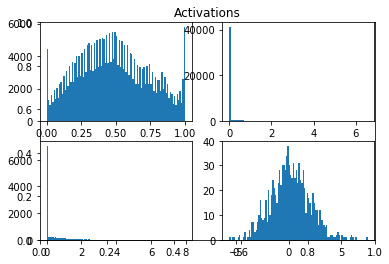

[3 9 0 0 1 5 4 4 4 1 1 7 9 8 0 7 4 4 8 2 8 7 3 4 7 4 9 1 7 8 7 0 9 7 8 1 0
 0 9 0 4 7 4 8 5 4 8 7 1 1 5 0 7 9 0 8 2 7 1 7 5 9 4 9 9 5 6 4 1 1 4 6 4 4
 1 8 0 4 0 8 7 5 9 7 7 7 7 4 1 5 1 1 1 5 5 4 9 8 6 6]
[11 15  2  2 18  9  4 17 11 11]
[6 1 7 ..., 5 3 4]
[589 682 168 320 646 426 377 808 544 440]
cost: 36.808300863359044, train accuracy: 0.54, validation accuracy: 0.4816
iterations finished: 4001 alpha: 0.00043046721 reg. lambda: 0.0


Weights 0 Mean -0.000600646691658 SD 0.0247584003503
Weights 1 Mean -0.00236740731985 SD 0.0610995013435
Weights 2 Mean 0.000786497118276 SD 0.170351458294


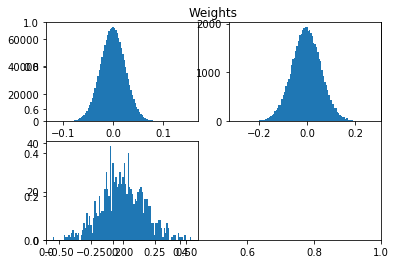

dW 0 Mean -0.0222340074508 SD 0.24515785103
dW 1 Mean -0.00480886337263 SD 0.66458400395
dW 2 Mean 0.0 SD 2.6755932248


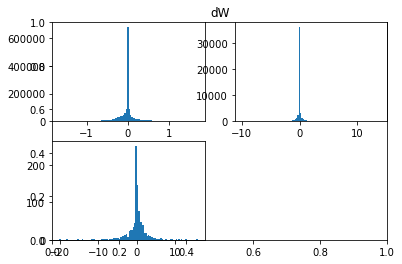

Biases 0 Mean 0.0989110631969 SD 0.0391742204932
Biases 1 Mean 0.119205230371 SD 0.125398620517
Biases 2 Mean 0.1 SD 0.35431123424


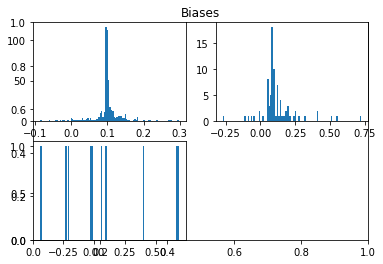

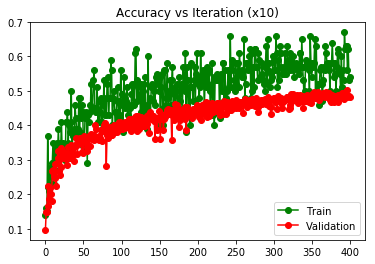

[4 0 9 3 0 1 8 6 5 1 6 6 5 8 6 5 3 3 3 7 6 6 4 1 5 4 0 7 0 1 8 4 7 4 2 1 7
 1 9 1 1 6 1 8 3 9 1 8 1 6 4 4 3 0 6 6 2 9 9 4 3 7 6 8 8 3 4 1 1 1 5 9 1 0
 4 9 0 5 8 5 9 0 3 4 9 5 1 3 2 7 1 8 6 3 9 6 8 0 4 7]
[ 9 17  3 11 12  8 13  7 10 10]
[6 1 7 ..., 5 3 6]
[591 744 291 348 524 411 851 546 474 220]
cost: 37.381440189434926, train accuracy: 0.45, validation accuracy: 0.4932
iterations finished: 4011 alpha: 0.00043046721 reg. lambda: 0.0


[7 6 2 6 8 7 8 3 2 1 6 7 2 3 9 2 3 6 2 6 2 6 6 2 3 2 0 2 2 2 4 8 6 2 2 1 2
 6 6 5 2 4 5 2 8 3 2 0 2 8 3 0 6 5 5 7 6 6 6 2 2 4 6 8 3 2 7 9 0 6 8 3 1 2
 9 3 7 2 3 2 0 5 9 5 2 2 2 7 6 5 4 9 5 8 0 5 0 2 6 9]
[ 7  3 28 10  4  9 18  7  8  6]
[6 5 7 ..., 5 6 6]
[ 494  268 1068  338  219  479  956  341  462  375]
cost: 35.1944921109436, train accuracy: 0.58, validation accuracy: 0.4532
iterations finished: 4021 alpha: 0.00043046721 reg. lambda: 0.0


[7 0 5 3 3 9 3 3 0 6 1 3 9 7 9 1 9 9 0 2 0 5 7 1 0 5 4 9 3 7 5 0 7 1 6 4 3
 6 7 3 2 0 4 7 2 9 4 2 9 7 6 9 1 0 9 7 

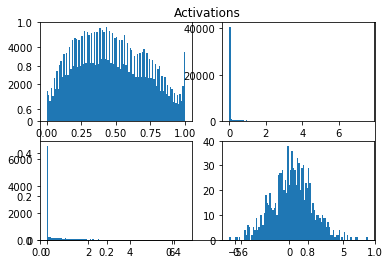

[1 0 8 7 7 5 6 6 7 8 6 7 5 7 0 4 7 6 7 3 1 8 6 8 0 6 1 6 9 1 6 9 2 8 2 3 5
 0 8 9 2 5 6 7 2 9 4 0 6 1 9 6 5 6 1 2 9 4 8 8 7 6 1 6 8 8 0 7 0 4 1 7 1 7
 6 4 1 3 0 5 4 6 6 6 1 8 1 8 7 2 7 8 3 8 4 3 8 8 3 8]
[ 8 12  6  6  7  6 18 14 17  6]
[6 8 7 ..., 5 6 6]
[495 515 355 222 527 299 981 631 570 405]
cost: 36.64387988263602, train accuracy: 0.53, validation accuracy: 0.494
iterations finished: 4101 alpha: 0.00043046721 reg. lambda: 0.0


Weights 0 Mean -0.000592104279255 SD 0.0247728474857
Weights 1 Mean -0.00234416902702 SD 0.0611667906522
Weights 2 Mean 0.000786497118276 SD 0.171321438711


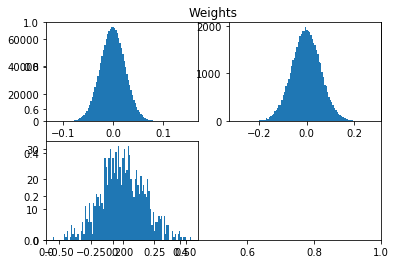

dW 0 Mean -0.00813555814347 SD 0.144047739584
dW 1 Mean -0.00544039493107 SD 0.459601622714
dW 2 Mean -1.42108547152e-17 SD 1.84465516177


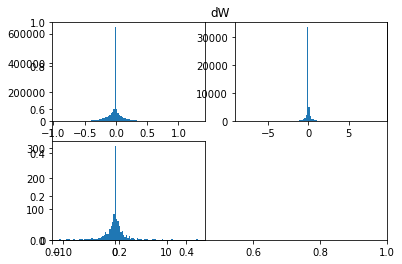

Biases 0 Mean 0.0989037916267 SD 0.0396687853328
Biases 1 Mean 0.119661770189 SD 0.1274192529
Biases 2 Mean 0.1 SD 0.356444278503


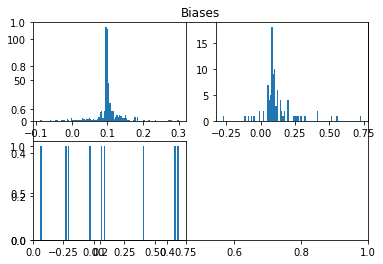

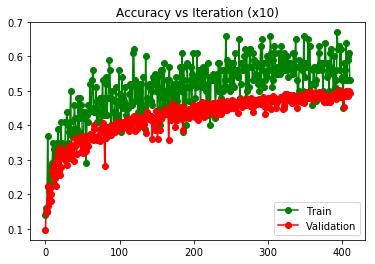

[6 8 7 5 2 4 5 3 7 4 9 9 8 3 3 9 6 1 8 6 0 8 4 1 1 6 8 7 8 5 4 6 0 7 8 3 1
 2 4 8 8 0 1 9 8 7 8 7 1 3 7 3 1 9 8 6 2 6 3 7 6 0 6 2 6 8 8 6 1 4 7 5 8 8
 8 8 8 4 6 6 1 6 5 1 0 1 7 3 9 8 9 5 9 3 6 0 5 7 1 6]
[ 6 12  4  9  7  7 16 11 20  8]
[6 8 7 ..., 5 3 4]
[422 359 383 565 432 278 738 516 683 624]
cost: 38.864952738312965, train accuracy: 0.64, validation accuracy: 0.4986
iterations finished: 4111 alpha: 0.00043046721 reg. lambda: 0.0


[8 3 3 6 3 5 8 8 6 3 3 3 8 3 1 1 2 2 8 9 8 6 8 1 8 8 8 4 7 4 7 8 1 2 7 8 7
 9 8 9 6 2 6 2 7 3 6 2 6 9 5 1 1 1 7 0 3 0 7 4 7 0 3 8 1 1 9 0 1 8 6 9 2 7
 6 6 2 3 3 8 8 9 9 1 1 8 8 1 6 3 9 0 1 8 2 8 7 2 1 3]
[ 5 15 10 14  3  2 11 10 21  9]
[6 8 7 ..., 5 6 6]
[243 457 575 395 310 302 744 510 973 491]
cost: 37.364008008809776, train accuracy: 0.65, validation accuracy: 0.4776
iterations finished: 4121 alpha: 0.00043046721 reg. lambda: 0.0


[9 6 0 6 4 6 0 7 6 3 8 0 1 0 4 2 3 9 8 8 5 4 7 4 4 2 7 9 7 0 8 6 5 8 4 8 6
 8 2 9 4 8 9 6 1 7 1 8 3 9 7 4 6 3 4 9 4 4 6 8 

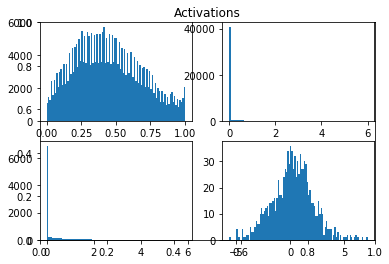

[8 1 4 6 8 1 7 1 8 6 6 7 0 7 7 7 2 2 3 5 4 2 2 1 9 6 3 4 4 4 4 3 6 5 6 2 4
 9 4 8 6 0 8 6 0 8 2 4 5 9 9 6 3 6 1 7 6 8 8 6 8 1 0 0 2 2 4 4 4 8 2 2 6 0
 6 7 6 6 6 6 0 9 2 0 0 5 7 6 4 9 2 8 4 7 4 4 1 2 4 7]
[ 9  7 13  4 17  4 19 10 11  6]
[6 8 7 ..., 5 6 6]
[361 564 620 344 422 347 732 482 653 475]
cost: 36.41003706194945, train accuracy: 0.65, validation accuracy: 0.5004
iterations finished: 4201 alpha: 0.00043046721 reg. lambda: 0.0


Weights 0 Mean -0.000600760477895 SD 0.0247864021194
Weights 1 Mean -0.00236580697561 SD 0.0612186385813
Weights 2 Mean 0.000786497118276 SD 0.171951408905


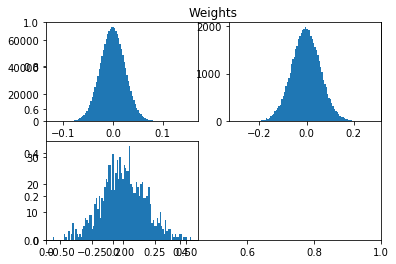

dW 0 Mean -0.00581121638977 SD 0.140413703303
dW 1 Mean -0.00656953244133 SD 0.402351750194
dW 2 Mean -2.84217094304e-17 SD 1.5646748823


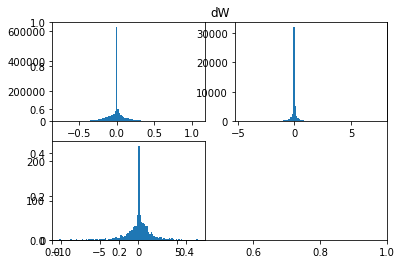

Biases 0 Mean 0.0988782137832 SD 0.0399519025105
Biases 1 Mean 0.119988644458 SD 0.128714905537
Biases 2 Mean 0.1 SD 0.357915181109


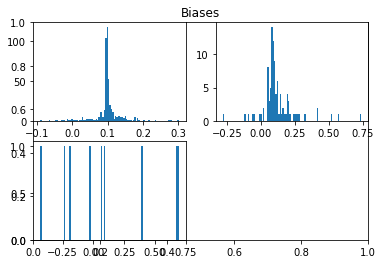

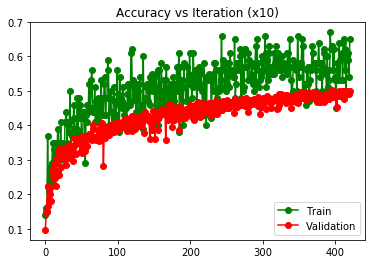

[0 6 0 6 0 3 5 4 8 1 8 3 5 1 7 1 1 6 4 8 1 1 4 6 3 3 3 3 8 6 6 3 8 9 8 3 3
 6 0 1 3 5 6 0 6 3 4 1 1 6 8 3 3 4 0 0 9 3 6 6 1 7 3 1 3 9 6 1 0 3 6 1 3 1
 6 2 1 0 2 5 6 5 0 2 2 6 9 1 2 8 5 6 4 1 3 5 3 2 6 3]
[10 17  6 21  6  7 19  2  8  4]
[6 8 0 ..., 5 3 6]
[544 633 308 708 267 349 834 344 639 374]
cost: 37.37224444806074, train accuracy: 0.53, validation accuracy: 0.492
iterations finished: 4211 alpha: 0.00043046721 reg. lambda: 0.0


[3 9 0 6 6 5 8 9 5 8 9 0 2 8 5 9 1 7 2 6 0 2 9 4 4 0 8 3 8 7 0 6 9 2 1 5 7
 3 8 8 6 7 8 2 3 4 6 2 6 3 9 9 6 3 5 4 7 7 5 6 1 5 6 6 7 3 7 5 7 9 7 3 8 7
 5 7 5 3 4 7 9 1 9 7 5 9 4 8 9 9 7 9 3 8 2 2 2 9 5 9]
[ 5  4  9 10  6 12 11 15 11 17]
[6 7 7 ..., 5 3 6]
[435 348 424 493 282 437 570 792 450 769]
cost: 37.902421731600384, train accuracy: 0.56, validation accuracy: 0.4946
iterations finished: 4221 alpha: 0.00043046721 reg. lambda: 0.0


[8 9 7 7 7 9 4 0 8 6 7 7 2 8 9 4 0 4 1 8 4 1 9 1 9 0 7 6 1 8 3 9 2 4 2 1 6
 7 9 3 0 9 8 8 8 9 4 7 9 4 6 4 3 5 3 3 7 7 2 9 0 

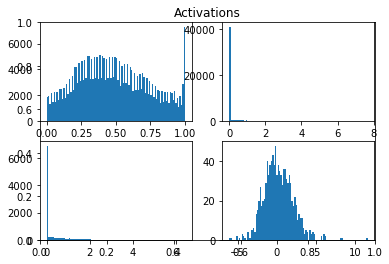

[1 6 4 6 6 2 0 8 9 7 1 4 4 8 3 1 9 3 9 7 7 1 8 8 0 6 0 3 8 9 9 8 0 5 7 9 0
 3 9 5 8 9 5 5 7 4 6 8 1 6 4 8 5 1 1 9 6 6 1 8 1 8 6 4 0 7 9 1 1 5 8 6 6 4
 9 3 3 9 7 6 0 3 0 8 0 6 8 5 7 1 8 2 4 3 0 8 3 7 4 8]
[10 12  2  9  9  7 13  9 17 12]
[6 8 7 ..., 5 3 4]
[558 546 174 407 574 389 695 475 691 491]
cost: 37.11763106157297, train accuracy: 0.56, validation accuracy: 0.4944
iterations finished: 4301 alpha: 0.00043046721 reg. lambda: 0.0


Weights 0 Mean -0.000591152160072 SD 0.0248013631484
Weights 1 Mean -0.0023575671938 SD 0.061279926063
Weights 2 Mean 0.000786497118276 SD 0.172720254079


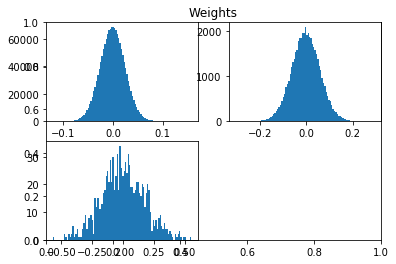

dW 0 Mean -0.00114543236984 SD 0.157302931625
dW 1 Mean 0.00576090924303 SD 0.404664263089
dW 2 Mean -5.68434188608e-17 SD 1.5957866278


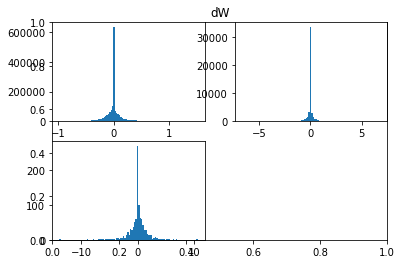

Biases 0 Mean 0.0988965784907 SD 0.0402807826869
Biases 1 Mean 0.120446951464 SD 0.130218509339
Biases 2 Mean 0.1 SD 0.361266209807


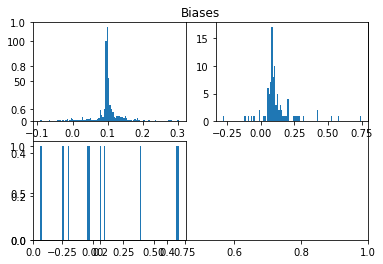

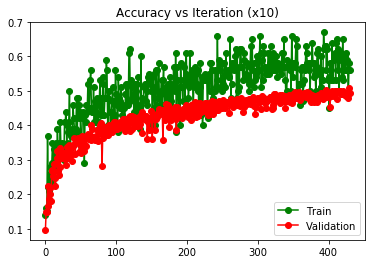

[2 6 6 0 9 9 3 1 0 1 8 6 9 9 3 6 0 9 9 4 3 4 2 2 5 2 9 5 3 3 4 9 9 3 2 3 2
 4 1 8 1 1 1 6 4 1 0 9 0 8 7 0 1 0 3 4 7 1 1 9 8 9 6 6 1 4 8 1 1 0 1 4 1 7
 2 7 5 0 0 9 5 9 8 1 7 2 9 1 4 3 7 9 6 1 8 5 0 7 5 8]
[11 18  8  9  9  6  8  7  8 16]
[6 1 0 ..., 5 3 4]
[427 695 335 628 361 379 593 438 457 687]
cost: 35.87987815404822, train accuracy: 0.53, validation accuracy: 0.4928
iterations finished: 4311 alpha: 0.00043046721 reg. lambda: 0.0


[7 4 6 9 7 0 0 6 0 3 0 9 6 6 2 8 6 6 4 1 9 7 8 6 2 4 7 8 8 7 7 7 1 3 9 2 8
 1 8 5 0 6 5 8 4 5 2 1 4 0 9 9 4 8 8 4 8 4 9 0 2 2 3 4 8 9 4 0 3 4 1 9 4 0
 7 9 4 2 6 4 7 4 3 1 0 4 5 6 7 4 4 0 4 6 8 9 7 9 0 1]
[12  7  7  5 19  4 11 11 12 12]
[6 8 0 ..., 5 3 4]
[559 484 255 367 929 302 466 313 741 584]
cost: 38.21948140286501, train accuracy: 0.57, validation accuracy: 0.4816
iterations finished: 4321 alpha: 0.00043046721 reg. lambda: 0.0


[7 7 8 2 7 1 9 1 4 9 1 9 0 9 3 2 1 2 9 7 5 1 9 3 0 8 1 7 8 5 0 6 5 7 3 2 5
 6 3 9 4 0 8 2 9 0 4 5 4 4 1 9 8 3 9 1 6 1 6 0 6 

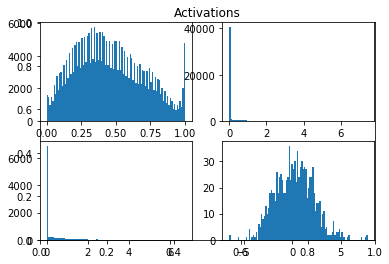

[5 9 7 8 4 6 6 7 3 4 2 1 3 6 4 6 9 3 7 8 6 9 5 9 8 9 5 3 8 4 4 6 6 9 6 1 9
 3 0 6 1 5 1 3 2 3 6 4 4 1 8 4 6 3 5 7 5 8 4 6 8 8 5 9 9 4 0 1 6 5 1 8 0 4
 4 6 9 9 9 6 1 4 8 6 5 6 1 8 8 9 0 9 6 1 4 2 7 4 8 7]
[ 4 10  3  8 15  9 18  6 13 14]
[6 1 7 ..., 5 6 6]
[418 513 279 438 493 319 842 584 581 533]
cost: 38.034871255791145, train accuracy: 0.59, validation accuracy: 0.5036
iterations finished: 4401 alpha: 0.00043046721 reg. lambda: 0.0


Weights 0 Mean -0.000583111623908 SD 0.0248164549856
Weights 1 Mean -0.00237663653542 SD 0.0613449660622
Weights 2 Mean 0.000786497118276 SD 0.17353959708


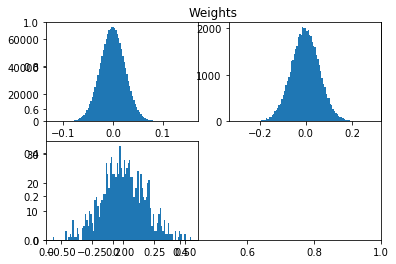

dW 0 Mean -0.00814695999412 SD 0.185608608137
dW 1 Mean 0.00975274709936 SD 0.529800566929
dW 2 Mean 0.0 SD 2.21522550493


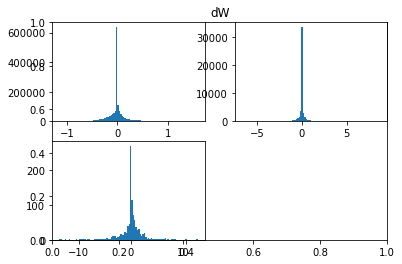

Biases 0 Mean 0.0989268376433 SD 0.0406766368654
Biases 1 Mean 0.12068725645 SD 0.131374249276
Biases 2 Mean 0.1 SD 0.363042264568


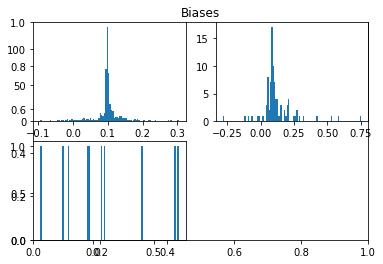

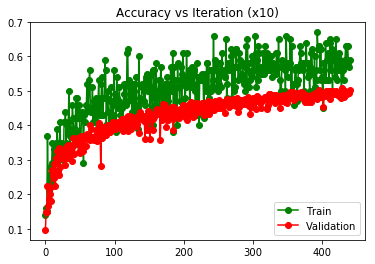

[0 2 4 9 8 5 9 7 1 8 7 8 5 1 1 0 8 5 7 9 0 6 6 4 9 4 7 7 8 7 6 2 6 1 4 9 0
 2 6 9 2 0 7 1 3 0 7 7 1 7 9 5 7 8 6 9 3 1 9 1 3 0 5 5 3 0 1 4 6 7 8 0 4 8
 7 2 2 2 4 1 5 7 6 7 4 9 5 3 0 6 1 0 5 4 3 8 1 7 5 1]
[11 13  7  6  9 10  9 16  9 10]
[6 8 7 ..., 5 3 4]
[531 596 392 515 479 319 503 648 523 494]
cost: 36.41735380636156, train accuracy: 0.63, validation accuracy: 0.5024
iterations finished: 4411 alpha: 0.00043046721 reg. lambda: 0.0


[8 8 4 3 2 8 3 0 9 4 7 8 6 7 0 1 8 3 7 0 0 1 0 8 3 4 8 0 6 2 6 2 1 6 8 8 2
 1 9 7 3 8 8 5 8 3 2 2 7 1 6 8 2 8 5 2 8 6 3 0 0 2 8 4 2 0 2 4 1 7 5 2 1 5
 4 4 5 2 0 6 9 8 6 1 5 6 9 3 7 3 2 4 8 0 4 4 6 0 8 0]
[13  8 14  9 10  6 10  7 19  4]
[6 8 0 ..., 5 6 4]
[459 406 418 473 663 296 776 326 798 385]
cost: 37.56254466275992, train accuracy: 0.64, validation accuracy: 0.491
iterations finished: 4421 alpha: 0.00043046721 reg. lambda: 0.0


[2 7 1 7 1 4 4 4 6 2 5 5 0 1 9 5 1 0 3 6 8 2 7 1 2 2 7 9 4 4 1 0 8 3 7 9 0
 3 1 1 3 3 7 4 9 8 1 5 9 7 6 1 1 5 1 9 4 2 9 0 6 0

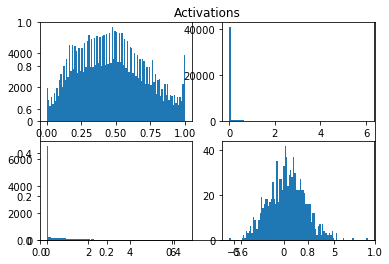

[4 9 8 0 9 3 3 3 5 0 0 9 9 6 0 3 3 4 9 0 0 9 9 4 1 8 5 0 9 4 0 3 0 7 3 0 2
 5 1 4 5 4 4 6 0 1 6 6 7 8 8 2 9 4 9 1 1 4 5 6 8 9 5 3 5 8 4 4 9 1 9 0 2 5
 0 0 3 9 5 4 8 9 1 1 5 7 8 3 7 9 4 9 0 0 6 3 2 5 7 0]
[17  8  4 11 13 11  6  5  8 17]
[6 8 0 ..., 5 3 6]
[572 631 235 473 472 535 533 258 539 752]
cost: 36.38315399167679, train accuracy: 0.57, validation accuracy: 0.4754
iterations finished: 4501 alpha: 0.000387420489 reg. lambda: 0.0


Weights 0 Mean -0.000586370134924 SD 0.024830502383
Weights 1 Mean -0.00233394282184 SD 0.0614017772974
Weights 2 Mean 0.000786497118276 SD 0.174221431527


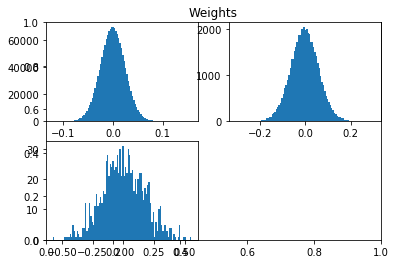

dW 0 Mean -0.0182833508819 SD 0.195271897722
dW 1 Mean -0.0171807667898 SD 0.465750860685
dW 2 Mean 9.94759830064e-17 SD 1.70397536273


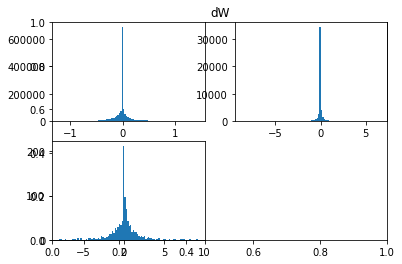

Biases 0 Mean 0.0988859325354 SD 0.0410007052941
Biases 1 Mean 0.121305670794 SD 0.132661357636
Biases 2 Mean 0.1 SD 0.364454053103


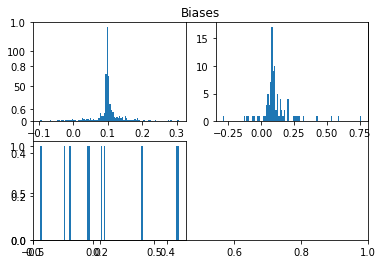

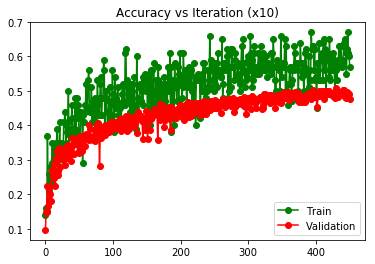

[6 1 1 8 8 6 6 6 8 4 9 0 7 2 8 9 0 2 7 7 5 8 0 8 8 6 3 6 1 6 2 7 2 6 0 4 7
 1 1 3 5 1 0 3 6 7 9 0 5 0 1 0 8 7 9 3 3 4 6 8 7 4 4 5 7 0 2 3 0 0 0 6 2 2
 2 1 1 8 8 5 0 4 6 0 2 9 6 9 6 5 9 8 9 6 8 3 0 9 1 7]
[15 10  9  7  6  6 15 10 13  9]
[6 8 7 ..., 5 0 6]
[561 591 443 404 419 355 648 429 620 530]
cost: 36.267815954213845, train accuracy: 0.56, validation accuracy: 0.4994
iterations finished: 4511 alpha: 0.000387420489 reg. lambda: 0.0


[1 6 6 0 6 4 6 6 1 1 0 2 0 6 4 3 6 2 9 4 6 5 4 5 1 3 8 3 6 2 3 0 9 7 7 3 2
 6 6 1 9 1 1 5 3 9 8 9 7 3 2 1 6 2 3 4 9 2 6 8 1 1 1 8 4 0 3 8 8 8 3 6 1 9
 0 8 3 1 6 4 7 2 0 3 1 4 8 2 8 2 4 7 8 4 7 6 9 9 4 4]
[ 7 14 10 12 12  3 16  6 11  9]
[6 8 7 ..., 5 6 6]
[536 531 473 456 531 394 750 449 538 342]
cost: 38.47418528211859, train accuracy: 0.62, validation accuracy: 0.4982
iterations finished: 4521 alpha: 0.000387420489 reg. lambda: 0.0


[9 3 3 6 0 9 0 5 9 8 2 1 2 9 6 3 3 2 9 2 3 1 9 3 2 7 2 9 7 6 2 2 1 3 7 9 6
 0 3 9 8 4 1 9 8 2 5 3 6 1 3 7 6 8 2 0 8 4 8 8

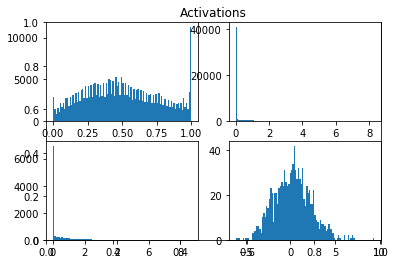

[5 2 6 9 9 9 5 7 1 6 0 6 0 4 7 8 1 7 5 5 1 3 7 8 7 4 8 7 5 4 9 5 9 1 2 4 9
 1 0 9 2 8 5 5 0 5 1 4 9 4 6 0 5 8 6 9 6 0 5 4 9 7 2 8 5 5 8 9 6 7 4 5 9 4
 8 9 9 3 7 1 5 9 7 0 5 7 7 8 4 1 6 9 7 0 9 9 5 1 3 6]
[ 8  9  4  3 10 17  9 13  9 18]
[6 8 7 ..., 5 6 6]
[394 360 176 187 607 615 747 562 552 800]
cost: 39.00415258185732, train accuracy: 0.55, validation accuracy: 0.4912
iterations finished: 4601 alpha: 0.000387420489 reg. lambda: 0.0


Weights 0 Mean -0.000588287610839 SD 0.0248425306981
Weights 1 Mean -0.00236111601151 SD 0.061459342872
Weights 2 Mean 0.000786497118276 SD 0.175050177035


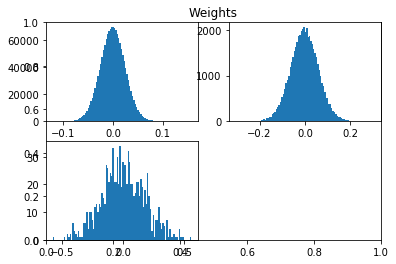

dW 0 Mean -0.00549144124432 SD 0.190600022848
dW 1 Mean 0.0117644004505 SD 0.521333812337
dW 2 Mean 0.0 SD 2.3716295066


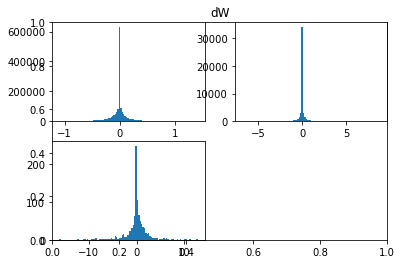

Biases 0 Mean 0.0988826032912 SD 0.0413749699816
Biases 1 Mean 0.121526459904 SD 0.134240944092
Biases 2 Mean 0.1 SD 0.367965021796


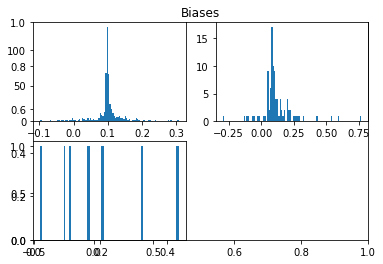

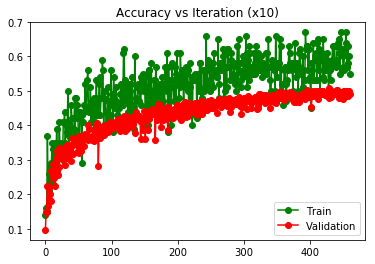

[6 8 3 4 1 2 2 4 6 1 4 6 1 6 4 4 9 8 0 8 5 3 6 9 8 7 3 6 7 4 6 7 4 5 7 5 7
 5 6 5 5 5 5 8 1 8 3 0 6 0 4 5 1 7 7 8 2 3 8 3 6 5 7 0 9 6 7 6 2 0 7 5 8 5
 9 8 4 4 8 7 4 3 6 6 4 1 3 7 8 1 8 1 7 4 3 6 4 6 5 7]
[ 5  8  4  9 14 13 16 14 13  4]
[6 8 7 ..., 5 5 4]
[426 435 389 417 503 467 698 588 615 462]
cost: 38.18846822263338, train accuracy: 0.56, validation accuracy: 0.51
iterations finished: 4611 alpha: 0.000387420489 reg. lambda: 0.0


[1 9 6 2 5 4 5 6 7 0 0 5 3 9 2 7 3 3 4 7 8 5 1 7 4 1 3 9 2 0 5 5 6 5 8 2 5
 2 9 6 0 6 0 2 2 3 3 6 4 3 5 6 1 9 8 0 6 5 4 8 6 6 5 8 7 7 3 3 2 7 4 9 7 1
 3 7 2 6 7 6 8 7 5 1 7 1 9 5 8 6 0 7 7 3 5 6 0 5 9 9]
[ 8  7  9 11  6 15 14 14  7  9]
[6 8 7 ..., 5 5 4]
[318 473 487 609 345 482 411 717 547 611]
cost: 37.53645085919401, train accuracy: 0.61, validation accuracy: 0.5006
iterations finished: 4621 alpha: 0.000387420489 reg. lambda: 0.0


[4 4 0 8 8 9 9 3 6 7 4 4 5 4 6 6 6 5 0 9 1 4 4 9 2 1 4 6 4 5 8 4 8 7 8 4 4
 7 4 9 9 6 8 0 6 0 1 5 8 8 4 9 8 0 7 0 8 4 0 6 1 

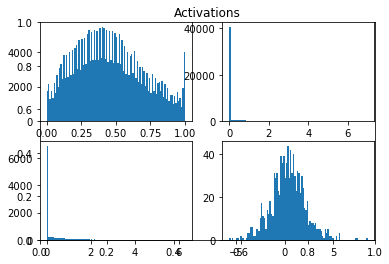

[6 6 2 1 7 0 5 0 4 6 4 0 6 1 5 2 7 4 2 8 7 6 8 1 7 7 6 6 2 2 8 2 3 7 0 5 2
 5 5 5 7 7 5 4 3 4 0 1 7 8 5 5 0 4 8 0 1 7 0 5 7 6 6 4 6 0 7 7 6 2 6 5 9 0
 5 6 0 6 7 5 6 3 9 7 6 8 1 1 3 0 6 5 1 7 7 7 6 5 1 9]
[12  9  8  4  7 15 18 18  6  3]
[6 8 7 ..., 5 6 4]
[548 524 520 280 586 569 630 540 539 264]
cost: 35.2688918314613, train accuracy: 0.53, validation accuracy: 0.4994
iterations finished: 4701 alpha: 0.000387420489 reg. lambda: 0.0


Weights 0 Mean -0.000605009112719 SD 0.0248537823088
Weights 1 Mean -0.00240433940496 SD 0.0615006429108
Weights 2 Mean 0.000786497118276 SD 0.175567094903


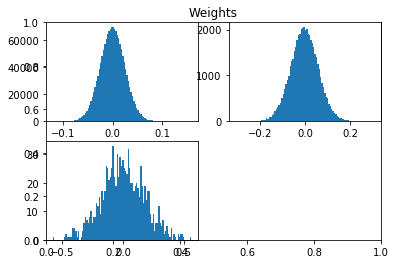

dW 0 Mean 0.0335844399017 SD 0.225145040163
dW 1 Mean -0.0023469981444 SD 0.575844106457
dW 2 Mean -1.42108547152e-17 SD 2.05800773253


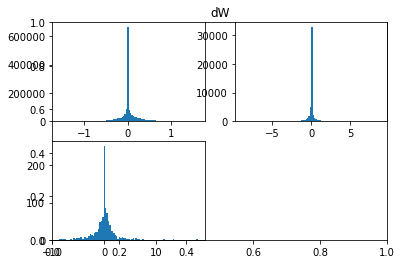

Biases 0 Mean 0.0988092681907 SD 0.0417054370727
Biases 1 Mean 0.121679298854 SD 0.135832855033
Biases 2 Mean 0.1 SD 0.370627621542


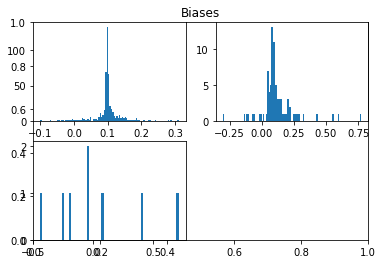

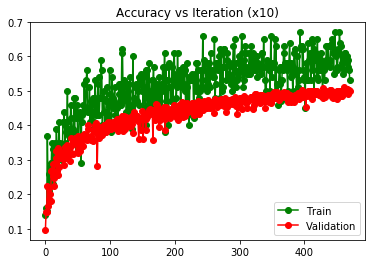

[1 5 8 7 7 5 2 5 3 4 4 4 7 3 8 2 8 1 7 4 5 9 3 4 3 9 1 4 0 1 7 0 8 3 6 3 9
 7 0 7 8 0 0 9 7 5 2 3 8 9 6 7 3 5 2 7 1 9 0 4 7 2 7 7 8 9 1 9 8 2 3 2 7 6
 7 9 1 7 6 3 4 7 8 3 7 1 7 6 9 3 7 4 6 9 7 3 8 4 6 7]
[ 6  8  7 13 10  6  7 22 10 11]
[6 8 7 ..., 5 6 4]
[226 554 611 472 528 377 458 620 558 596]
cost: 37.92821613585542, train accuracy: 0.49, validation accuracy: 0.5024
iterations finished: 4711 alpha: 0.000387420489 reg. lambda: 0.0


[9 3 3 9 7 3 8 3 6 0 6 5 1 6 5 0 8 1 1 3 6 9 7 2 2 5 8 4 2 6 6 8 8 3 6 9 3
 5 6 2 1 3 3 3 2 8 9 4 9 1 9 1 9 8 3 5 6 0 8 2 0 0 6 1 4 0 1 8 6 4 1 4 8 4
 0 1 1 8 9 4 0 8 4 6 1 3 7 3 6 6 4 9 6 8 0 1 4 5 9 3]
[ 9 13  6 14 10  6 15  3 13 11]
[6 8 7 ..., 5 3 2]
[406 451 639 561 387 406 511 417 535 687]
cost: 40.58767570702302, train accuracy: 0.64, validation accuracy: 0.5018
iterations finished: 4721 alpha: 0.000387420489 reg. lambda: 0.0


[1 0 0 3 3 0 5 7 7 8 4 5 0 0 6 0 8 3 2 6 6 8 6 9 0 6 2 0 6 0 8 9 2 2 1 2 8
 6 6 6 3 7 1 5 7 3 2 5 0 5 3 9 0 4 3 5 5 7 1 3 

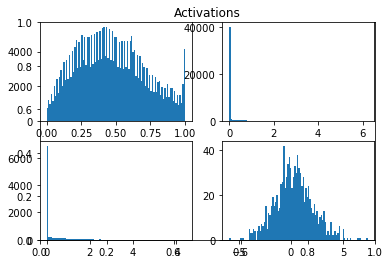

[9 4 0 2 0 6 2 2 2 3 3 3 7 3 6 9 3 5 8 4 6 7 7 8 1 4 3 5 3 7 2 5 7 3 6 2 5
 1 2 7 7 3 1 8 3 7 1 8 2 5 0 6 3 2 9 5 2 7 3 1 9 7 7 3 7 5 3 1 9 9 3 5 3 7
 2 9 0 2 7 9 0 0 2 9 3 7 1 1 8 5 2 2 3 2 3 0 7 6 7 0]
[ 8  8 16 19  3  9  6 17  5  9]
[6 7 7 ..., 5 3 2]
[340 492 769 937 299 301 325 544 545 448]
cost: 36.29692496242885, train accuracy: 0.61, validation accuracy: 0.502
iterations finished: 4801 alpha: 0.000387420489 reg. lambda: 0.0


Weights 0 Mean -0.000579755782686 SD 0.0248672340056
Weights 1 Mean -0.00238772375721 SD 0.0615650927993
Weights 2 Mean 0.000786497118276 SD 0.176453711975


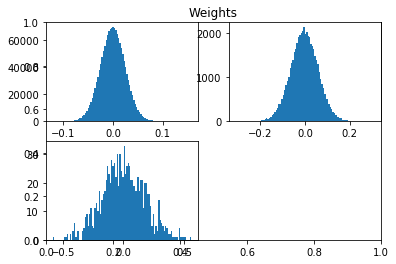

dW 0 Mean 0.00413136273144 SD 0.219600946709
dW 1 Mean -0.0190378738908 SD 0.529496276025
dW 2 Mean 0.0 SD 2.10495344573


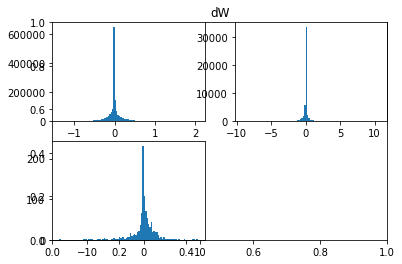

Biases 0 Mean 0.0988721227054 SD 0.0419758172083
Biases 1 Mean 0.122147581408 SD 0.136930984932
Biases 2 Mean 0.1 SD 0.37243647962


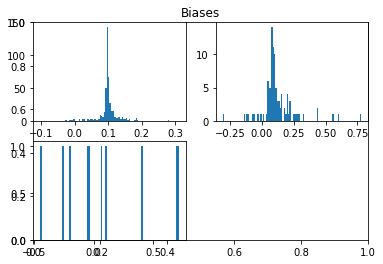

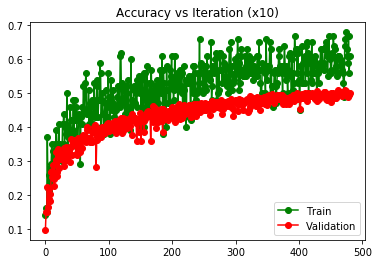

[5 1 1 8 6 6 1 7 6 3 3 4 7 0 1 6 1 3 6 0 7 1 9 4 4 0 3 6 8 4 6 9 7 6 5 5 9
 1 7 0 0 1 6 1 5 4 7 7 4 8 5 4 8 2 7 4 8 5 2 8 7 1 5 1 2 6 1 8 0 1 8 9 1 7
 5 3 4 2 9 3 3 9 3 3 5 8 4 3 9 6 6 2 6 1 1 3 6 4 8 7]
[ 6 16  5 11 11  9 14 11 10  7]
[6 8 7 ..., 5 6 4]
[356 744 523 452 461 363 799 382 531 389]
cost: 36.819403156260904, train accuracy: 0.52, validation accuracy: 0.5014
iterations finished: 4811 alpha: 0.000387420489 reg. lambda: 0.0


[8 6 8 9 3 9 9 5 6 2 5 8 7 6 6 8 8 1 1 0 7 8 9 3 4 2 0 3 7 1 2 9 5 0 8 1 2
 8 3 7 8 7 8 5 6 5 0 4 3 5 6 5 4 5 6 6 6 9 6 9 3 8 6 8 6 9 5 5 0 6 5 1 6 5
 8 7 4 8 9 8 8 6 7 4 6 4 6 9 5 0 6 5 6 4 0 0 5 0 5 9]
[ 9  5  4  6  7 16 19  7 16 11]
[6 8 6 ..., 5 5 6]
[311 285 465 388 323 652 939 375 736 526]
cost: 38.48514726455723, train accuracy: 0.55, validation accuracy: 0.478
iterations finished: 4821 alpha: 0.000387420489 reg. lambda: 0.0


[7 7 5 8 7 0 2 7 7 5 2 5 6 9 7 7 7 0 0 5 7 9 6 1 9 1 3 4 4 7 0 2 3 0 2 2 7
 7 0 5 2 6 2 6 5 6 7 2 5 9 1 8 4 9 2 6 0 3 6 3 

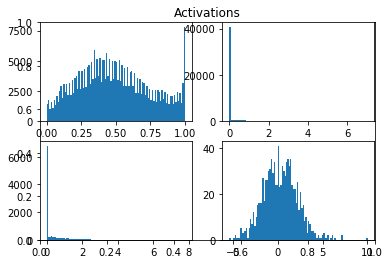

[6 6 9 1 6 6 3 0 9 0 2 3 4 2 7 8 7 0 6 1 6 3 6 7 6 0 3 7 7 0 1 3 1 3 1 6 1
 7 0 3 3 2 6 9 7 5 2 8 2 9 0 0 2 3 5 0 9 8 1 4 3 3 8 8 8 8 1 0 0 7 5 4 3 6
 1 5 0 1 2 6 2 5 1 2 9 3 0 1 9 8 6 0 0 9 4 3 5 6 8 5]
[15 12  9 14  4  7 14  8  9  8]
[6 1 7 ..., 5 6 6]
[403 566 441 563 216 398 739 562 523 589]
cost: 37.57639124213787, train accuracy: 0.67, validation accuracy: 0.5062
iterations finished: 4901 alpha: 0.000387420489 reg. lambda: 0.0


Weights 0 Mean -0.000583184888598 SD 0.0248796473769
Weights 1 Mean -0.0023927059761 SD 0.0616202094679
Weights 2 Mean 0.000786497118276 SD 0.177197282206


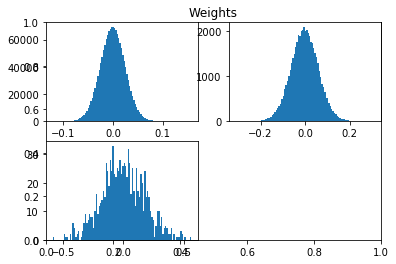

dW 0 Mean -0.021576642735 SD 0.156101735243
dW 1 Mean -0.020448138693 SD 0.409862853219
dW 2 Mean 0.0 SD 1.759154711


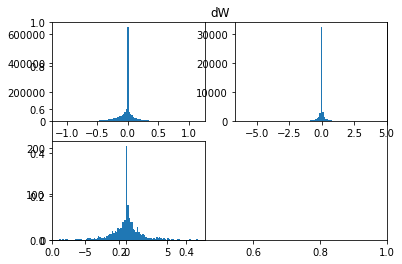

Biases 0 Mean 0.0988403107025 SD 0.0423123997437
Biases 1 Mean 0.122389328079 SD 0.138409106685
Biases 2 Mean 0.1 SD 0.374275650575


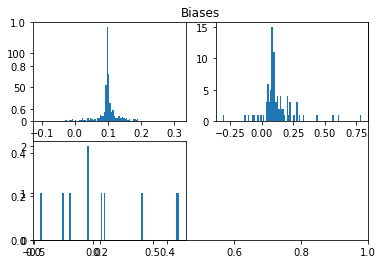

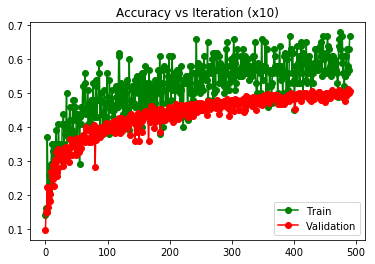

[1 6 2 0 2 0 3 4 0 9 9 7 0 8 5 6 1 0 3 9 8 6 3 2 4 2 3 8 6 2 5 1 6 6 8 5 8
 5 8 9 0 9 0 1 0 1 4 1 2 0 2 6 9 5 8 6 3 7 7 2 8 0 6 0 7 6 6 5 8 0 5 7 8 3
 1 8 8 7 3 5 9 6 9 6 5 0 4 6 1 6 4 1 8 8 3 7 0 1 8 0]
[15 10  8  8  5  9 15  7 15  8]
[6 8 7 ..., 5 3 4]
[809 503 326 471 377 389 585 573 462 505]
cost: 39.93816284089206, train accuracy: 0.62, validation accuracy: 0.5042
iterations finished: 4911 alpha: 0.000387420489 reg. lambda: 0.0


[3 9 7 0 3 9 7 9 9 7 9 7 1 3 9 4 7 0 9 7 7 9 1 4 3 9 4 0 0 2 4 7 0 3 6 6 6
 7 3 9 8 4 2 7 2 7 2 9 9 8 9 4 0 4 7 7 4 7 6 0 7 2 8 3 6 1 0 9 1 9 7 6 7 8
 7 7 6 6 9 3 9 9 7 4 8 3 7 4 0 9 3 6 4 4 6 3 8 0 6 4]
[10  4  5 11 13  0 11 21  6 19]
[6 7 7 ..., 5 5 4]
[533 405 229 402 819 425 460 774 393 560]
cost: 36.357544806706954, train accuracy: 0.6, validation accuracy: 0.4848
iterations finished: 4921 alpha: 0.000387420489 reg. lambda: 0.0


[0 9 2 7 4 1 0 1 7 0 7 4 6 8 2 3 7 5 6 4 6 4 0 7 0 6 8 1 5 1 0 7 5 0 9 7 0
 0 7 2 0 6 8 9 4 7 6 2 7 0 1 1 8 0 3 6 4 0 2 4 

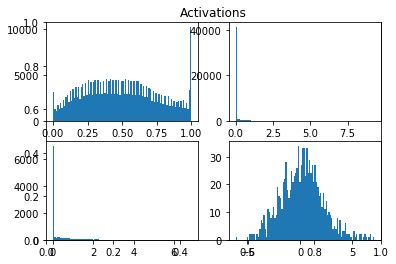

[0 8 6 4 8 7 3 3 3 8 8 8 9 3 6 8 9 8 7 4 6 9 7 5 2 0 7 2 2 3 2 5 0 4 0 2 0
 1 2 2 9 7 2 1 5 7 2 7 2 2 4 6 0 9 8 2 3 2 7 8 1 9 8 4 9 5 8 1 3 9 7 7 2 6
 1 9 9 5 6 2 0 1 2 0 7 5 3 2 2 6 6 3 0 7 4 6 9 3 7 6]
[ 9  6 18 10  6  6 10 13 11 11]
[6 1 7 ..., 5 3 4]
[418 557 899 530 277 365 475 583 394 502]
cost: 38.894196740494365, train accuracy: 0.62, validation accuracy: 0.5058
iterations finished: 5001 alpha: 0.0003486784401 reg. lambda: 0.0


Weights 0 Mean -0.000596634558322 SD 0.0248929904935
Weights 1 Mean -0.00242798063799 SD 0.0616783329366
Weights 2 Mean 0.000786497118276 SD 0.177955502132


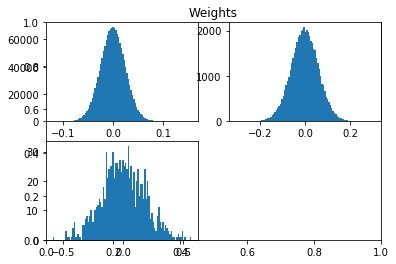

dW 0 Mean 0.00170965115225 SD 0.194992872706
dW 1 Mean 0.0097778372421 SD 0.486569383793
dW 2 Mean -5.68434188608e-17 SD 2.07199121888


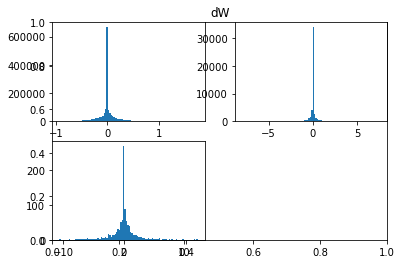

Biases 0 Mean 0.0988061977483 SD 0.0426668829305
Biases 1 Mean 0.122542234331 SD 0.139545141507
Biases 2 Mean 0.1 SD 0.376463653954


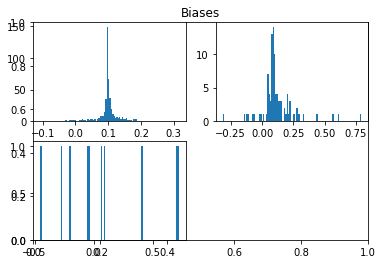

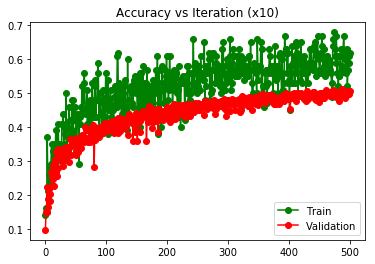

[8 2 4 1 3 1 5 4 2 9 0 9 0 2 5 4 4 7 4 6 3 5 8 8 2 2 8 5 2 2 9 3 2 6 2 2 4
 3 4 3 8 7 9 8 4 3 9 3 4 2 2 5 3 8 5 4 1 3 4 8 2 3 2 5 0 8 3 4 3 0 3 0 9 2
 1 3 9 3 8 7 2 4 2 9 8 3 2 2 8 3 0 2 2 3 9 0 2 5 9 3]
[ 7  4 22 19 13  8  2  3 12 10]
[6 8 7 ..., 5 5 4]
[514 411 778 488 468 356 408 544 507 526]
cost: 37.83236914199556, train accuracy: 0.56, validation accuracy: 0.5052
iterations finished: 5011 alpha: 0.0003486784401 reg. lambda: 0.0


[1 7 1 7 4 0 8 3 6 6 2 8 8 7 5 4 5 6 1 3 6 1 1 2 6 6 3 8 9 2 3 0 8 1 3 0 8
 2 8 9 1 2 1 5 8 6 0 4 1 0 8 4 6 3 7 3 2 0 4 6 6 2 7 8 8 8 6 4 7 7 9 4 2 6
 3 4 5 3 6 4 4 9 7 1 5 4 1 4 0 2 9 2 8 6 8 7 2 8 3 0]
[ 8 11 11 10 12  5 14  9 15  5]
[6 8 7 ..., 5 6 4]
[319 502 526 497 571 240 749 420 615 561]
cost: 39.76095663290705, train accuracy: 0.59, validation accuracy: 0.504
iterations finished: 5021 alpha: 0.0003486784401 reg. lambda: 0.0


[9 6 2 5 1 5 3 6 3 3 3 7 5 8 8 6 1 5 3 7 0 3 1 1 2 5 1 8 4 1 8 5 8 3 0 1 1
 4 9 1 1 3 5 8 3 4 5 8 3 6 2 7 0 4 7 2 6 6 4 7

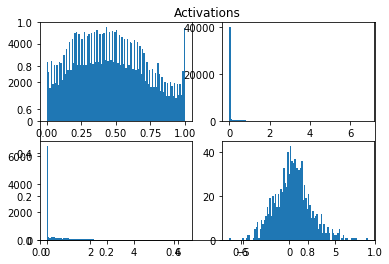

[1 9 0 4 6 7 4 5 1 9 3 6 8 6 4 6 9 1 8 8 4 7 1 9 3 4 1 3 2 4 1 7 8 5 0 7 4
 8 0 4 7 4 1 6 9 2 7 9 1 1 3 2 7 8 1 4 6 9 1 9 6 7 3 0 7 9 1 2 2 6 9 7 6 8
 4 2 0 7 6 9 3 6 7 4 7 1 4 5 5 9 8 4 7 3 0 1 3 3 7 6]
[ 6 14  6  9 14  4 12 15  8 12]
[6 8 7 ..., 5 6 4]
[425 530 307 545 518 278 752 484 674 487]
cost: 38.15019527841519, train accuracy: 0.52, validation accuracy: 0.5136
iterations finished: 5101 alpha: 0.0003486784401 reg. lambda: 0.0


Weights 0 Mean -0.000590604400629 SD 0.0249031917216
Weights 1 Mean -0.00241746152153 SD 0.0617270127934
Weights 2 Mean 0.000786497118276 SD 0.178645902659


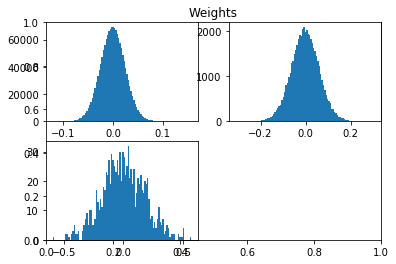

dW 0 Mean 0.0162636235017 SD 0.24023806795
dW 1 Mean 0.0207874991344 SD 0.532451342709
dW 2 Mean -1.42108547152e-17 SD 1.91755165553


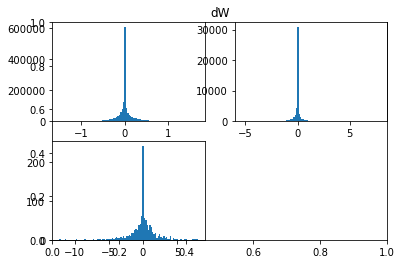

Biases 0 Mean 0.098811461048 SD 0.0429183701473
Biases 1 Mean 0.122933030245 SD 0.140888938023
Biases 2 Mean 0.1 SD 0.379722279144


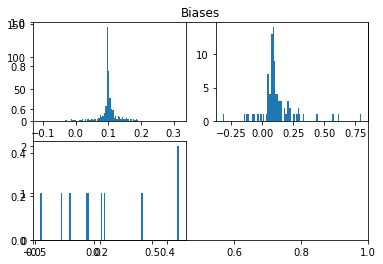

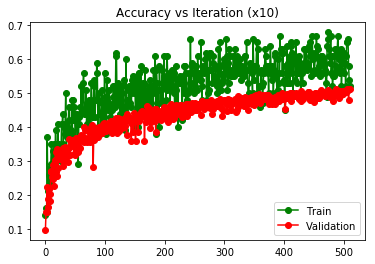

[4 5 8 9 2 1 5 8 9 6 4 9 7 9 3 5 5 5 1 4 6 9 5 9 3 7 7 7 8 7 1 0 3 6 7 8 0
 9 0 1 1 5 8 1 3 5 0 6 8 0 3 3 6 2 1 9 1 3 8 0 1 6 0 9 8 5 7 7 8 6 1 2 6 9
 5 9 2 0 0 2 6 3 6 0 6 1 5 7 0 9 6 3 2 3 3 1 6 0 7 6]
[12 12  6 11  3 11 14 10  9 12]
[6 1 7 ..., 5 3 4]
[457 503 472 570 315 401 546 562 463 711]
cost: 39.510790218608726, train accuracy: 0.58, validation accuracy: 0.5096
iterations finished: 5111 alpha: 0.0003486784401 reg. lambda: 0.0


[8 5 1 3 8 4 3 2 1 4 7 6 2 7 7 8 6 1 1 3 8 8 4 9 7 4 1 7 4 9 7 9 1 2 6 9 3
 8 2 1 9 8 5 2 4 7 6 6 8 7 1 4 3 6 3 4 9 8 1 9 1 8 7 1 1 1 3 4 4 2 4 7 6 6
 8 9 8 3 1 2 8 4 4 9 9 7 7 9 7 4 6 8 4 6 9 8 2 3 3 7]
[ 0 14  8 10 15  2 10 14 15 12]
[6 8 7 ..., 5 3 4]
[326 511 331 495 664 383 442 688 545 615]
cost: 37.31738216429188, train accuracy: 0.64, validation accuracy: 0.5074
iterations finished: 5121 alpha: 0.0003486784401 reg. lambda: 0.0


[0 7 9 5 0 0 3 5 5 9 1 0 6 6 8 3 3 0 7 0 4 0 1 2 3 4 9 3 9 1 9 3 1 1 9 0 4
 5 2 5 6 3 0 3 2 3 6 0 6 5 9 7 3 9 9 7 5 6 6

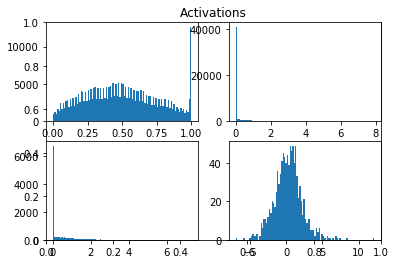

[1 7 8 3 2 9 3 2 7 3 0 2 7 0 7 3 8 2 6 2 7 3 9 1 7 4 8 3 3 1 1 3 9 1 1 7 1
 2 8 2 4 2 0 8 1 6 2 0 1 4 7 3 3 5 0 3 9 0 0 3 7 3 5 6 0 5 9 0 2 2 8 8 9 3
 0 1 1 9 7 7 4 4 0 3 7 3 9 3 7 6 2 9 0 4 6 0 9 0 7 6]
[14 11 12 17  6  3  6 14  7 10]
[6 7 7 ..., 2 6 4]
[428 485 632 553 411 252 560 661 416 602]
cost: 37.501538456588726, train accuracy: 0.52, validation accuracy: 0.5138
iterations finished: 5201 alpha: 0.0003486784401 reg. lambda: 0.0


Weights 0 Mean -0.000594625116297 SD 0.024914722975
Weights 1 Mean -0.00240286620344 SD 0.0617912977225
Weights 2 Mean 0.000786497118276 SD 0.179569288373


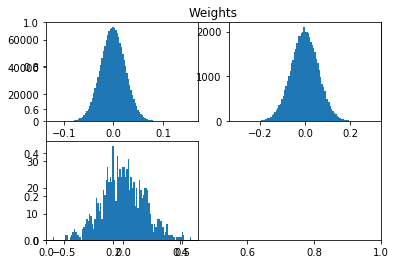

dW 0 Mean -0.00295727574567 SD 0.208869160837
dW 1 Mean 0.0122481971557 SD 0.512221034584
dW 2 Mean 0.0 SD 1.91970710048


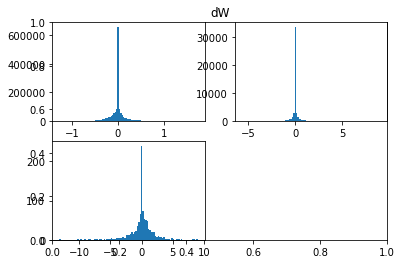

Biases 0 Mean 0.0988077411075 SD 0.0431901147944
Biases 1 Mean 0.12330277921 SD 0.141884631173
Biases 2 Mean 0.1 SD 0.380788937695


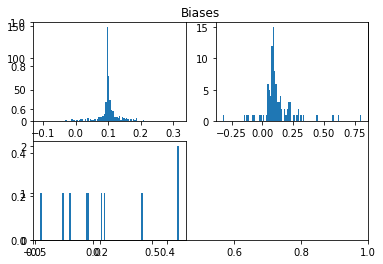

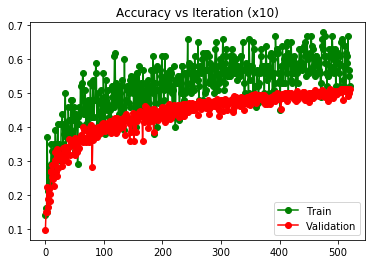

[8 6 7 3 2 0 6 4 5 5 8 1 8 1 0 0 8 9 4 9 2 7 8 9 5 6 0 2 8 6 6 1 0 9 5 0 7
 5 6 3 1 2 5 0 7 6 2 5 8 8 0 6 5 2 7 2 6 9 1 8 5 0 9 9 5 5 0 9 5 7 6 5 3 6
 7 7 7 1 6 0 8 6 3 2 5 8 6 7 6 5 2 2 8 2 6 6 1 2 3 9]
[11  7 12  5  2 15 17 10 12  9]
[6 8 7 ..., 5 6 6]
[453 548 665 274 291 499 711 506 484 569]
cost: 39.440423831970755, train accuracy: 0.56, validation accuracy: 0.5082
iterations finished: 5211 alpha: 0.0003486784401 reg. lambda: 0.0


[1 9 1 4 9 9 3 7 2 9 9 7 3 2 1 2 2 2 6 9 8 2 6 2 7 8 9 9 3 8 5 3 3 7 2 4 7
 0 3 8 0 4 2 8 2 6 4 8 6 9 5 4 5 5 7 7 7 8 3 0 7 0 4 7 9 5 7 6 7 9 9 6 7 2
 1 7 7 8 6 2 2 3 4 4 7 5 9 5 2 8 4 9 6 5 6 2 1 3 3 6]
[ 4  5 15 10  9  8 10 16  9 14]
[6 8 7 ..., 5 6 4]
[359 356 571 295 467 369 573 655 641 714]
cost: 37.61002959787526, train accuracy: 0.55, validation accuracy: 0.5088
iterations finished: 5221 alpha: 0.0003486784401 reg. lambda: 0.0


[2 8 8 6 3 6 2 4 3 2 6 8 9 6 8 6 0 5 6 2 1 8 8 5 0 5 9 5 6 8 7 9 7 5 7 6 4
 5 9 8 2 9 5 7 4 4 3 1 0 6 6 6 5 2 4 1 1 0 6

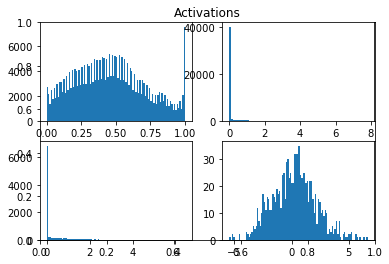

[7 9 6 2 3 0 3 6 3 8 5 9 0 2 7 3 6 4 0 1 5 9 5 3 1 7 0 1 3 9 7 1 4 4 2 0 9
 4 9 2 6 6 2 8 1 0 9 1 0 2 4 8 6 5 3 0 3 9 6 1 9 9 1 8 7 1 7 4 8 7 1 9 9 9
 1 0 8 1 0 3 6 9 0 9 2 2 1 4 1 6 7 4 5 6 3 4 4 0 2 1]
[12 15  9 10 10  5 10  8  6 15]
[6 1 7 ..., 5 3 4]
[471 593 331 492 587 305 552 622 401 646]
cost: 37.543352466976955, train accuracy: 0.58, validation accuracy: 0.5044
iterations finished: 5301 alpha: 0.0003486784401 reg. lambda: 0.0


Weights 0 Mean -0.000578236231392 SD 0.0249264803651
Weights 1 Mean -0.00240614991022 SD 0.0618454193561
Weights 2 Mean 0.000786497118276 SD 0.180323843307


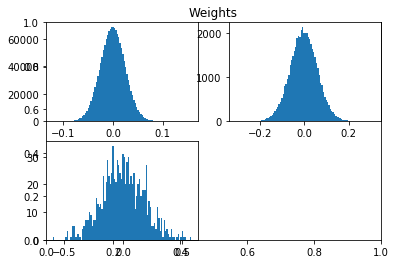

dW 0 Mean -0.00354043231191 SD 0.151970825337
dW 1 Mean -0.0192216207159 SD 0.461342836322
dW 2 Mean -1.42108547152e-17 SD 1.69681859616


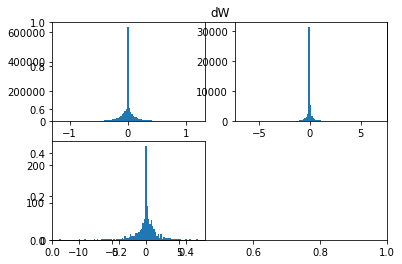

Biases 0 Mean 0.0988008192911 SD 0.0435624962209
Biases 1 Mean 0.123636208004 SD 0.143013492874
Biases 2 Mean 0.1 SD 0.382733883223


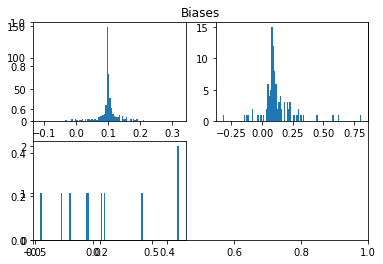

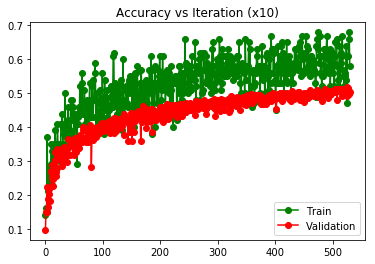

[5 3 9 9 2 9 0 5 3 0 5 0 9 3 7 8 7 7 0 1 1 0 1 5 9 0 9 8 7 4 5 7 7 9 2 7 6
 3 3 3 1 6 5 6 1 1 2 1 0 3 5 4 0 6 5 5 1 5 1 9 3 9 2 1 4 6 6 9 7 9 6 1 9 9
 1 6 9 6 1 1 7 0 3 6 3 4 3 8 1 4 2 6 6 8 5 6 5 5 2 5]
[ 9 15  6 11  5 14 13  9  4 14]
[6 1 7 ..., 5 5 2]
[624 644 534 571 254 517 437 491 382 546]
cost: 36.09441062325032, train accuracy: 0.6, validation accuracy: 0.5088
iterations finished: 5311 alpha: 0.0003486784401 reg. lambda: 0.0


[9 6 3 4 4 3 2 8 2 3 9 8 2 3 4 4 7 4 9 0 8 7 7 1 0 2 8 3 3 8 3 0 4 9 1 4 0
 6 8 3 9 3 0 0 0 3 3 6 0 6 3 9 7 1 3 3 8 3 6 6 7 4 1 3 6 3 4 5 8 7 6 4 2 2
 1 9 3 8 5 2 7 6 9 4 9 3 5 9 9 4 4 9 3 6 9 2 0 3 9 7]
[ 9  5  8 21 13  3 10  8  9 14]
[6 7 7 ..., 5 3 4]
[523 432 462 669 614 312 568 539 379 502]
cost: 38.943999137041494, train accuracy: 0.64, validation accuracy: 0.5062
iterations finished: 5321 alpha: 0.0003486784401 reg. lambda: 0.0


[8 3 6 2 7 3 2 1 8 4 2 6 0 9 6 7 4 6 9 3 7 8 6 6 7 7 8 9 3 6 6 9 1 7 8 3 8
 1 4 5 8 3 1 1 8 8 6 6 8 8 4 7 3 3 8 3 7 6 1 

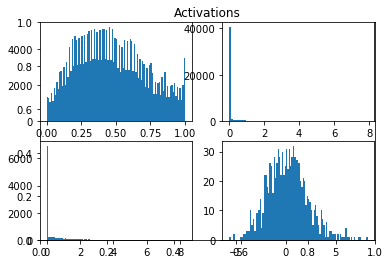

[7 7 7 6 0 8 3 2 1 8 5 2 7 7 1 6 9 6 7 3 2 1 8 1 9 6 0 5 8 2 2 6 4 3 4 7 0
 2 2 5 3 0 7 7 8 8 9 8 1 2 7 3 5 6 6 8 7 5 6 2 2 1 7 6 3 2 8 5 2 4 1 8 3 8
 3 5 3 7 2 2 9 8 6 0 8 0 9 6 4 0 6 7 9 9 5 8 8 8 9 2]
[ 7  7 15  9  4  8 12 14 16  8]
[6 8 7 ..., 5 5 2]
[374 477 655 348 223 449 532 687 637 618]
cost: 38.86094598465138, train accuracy: 0.57, validation accuracy: 0.5086
iterations finished: 5401 alpha: 0.0003486784401 reg. lambda: 0.0


Weights 0 Mean -0.000592065318064 SD 0.0249383106513
Weights 1 Mean -0.00241862995706 SD 0.06190329553
Weights 2 Mean 0.000786497118276 SD 0.181088321366


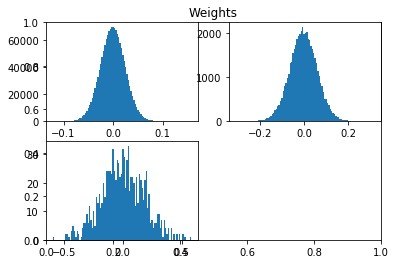

dW 0 Mean 0.013670386982 SD 0.199085530507
dW 1 Mean -0.000263491304705 SD 0.462026130516
dW 2 Mean -1.13686837722e-16 SD 2.02335726561


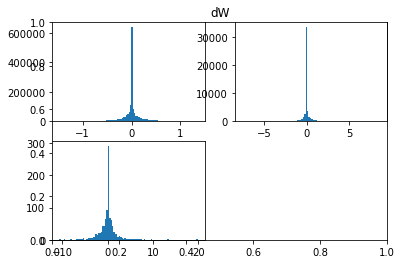

Biases 0 Mean 0.0987959764845 SD 0.0437889628916
Biases 1 Mean 0.123837255914 SD 0.143868847512
Biases 2 Mean 0.1 SD 0.383460541028


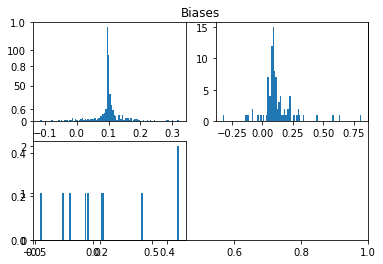

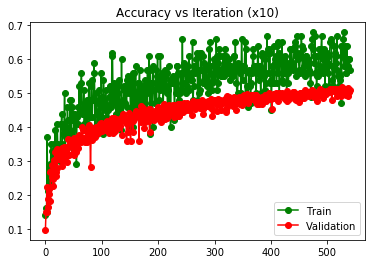

[0 4 6 9 3 4 0 4 0 7 6 4 2 5 7 7 3 0 6 1 9 9 2 3 1 9 5 2 3 0 5 8 4 6 8 5 3
 8 6 6 3 1 5 6 6 5 0 9 8 4 7 4 0 8 0 4 4 4 1 8 6 4 8 6 1 2 1 5 4 0 4 7 4 4
 6 9 7 8 9 4 2 3 2 3 1 6 3 7 1 6 0 6 8 0 1 0 8 3 1 5]
[12 10  6 10 16  8 14  7 10  7]
[6 1 7 ..., 5 6 4]
[604 455 500 294 750 278 801 433 494 391]
cost: 38.73358175966792, train accuracy: 0.6, validation accuracy: 0.5058
iterations finished: 5411 alpha: 0.0003486784401 reg. lambda: 0.0


[1 2 9 8 6 7 8 5 0 5 0 7 0 9 4 7 6 8 1 6 9 6 2 5 8 0 1 0 8 6 8 6 6 7 6 7 6
 1 2 6 7 0 9 5 9 9 8 1 5 8 1 0 5 5 1 5 9 9 5 1 3 1 6 7 9 0 9 8 9 8 7 6 2 4
 4 7 9 7 4 7 5 5 6 2 1 3 1 7 7 3 8 5 1 9 1 5 0 1 6 0]
[10 14  5  3  4 13 14 13 11 13]
[6 1 7 ..., 5 5 6]
[531 439 355 303 294 582 560 905 441 590]
cost: 39.774289768967385, train accuracy: 0.51, validation accuracy: 0.496
iterations finished: 5421 alpha: 0.0003486784401 reg. lambda: 0.0


[3 3 6 2 7 2 2 6 4 6 7 3 2 7 6 5 3 0 4 2 4 1 2 5 8 6 9 0 6 3 0 4 2 8 6 1 2
 0 4 3 9 2 8 9 0 5 2 3 1 6 4 0 7 8 5 8 0 6 6 4

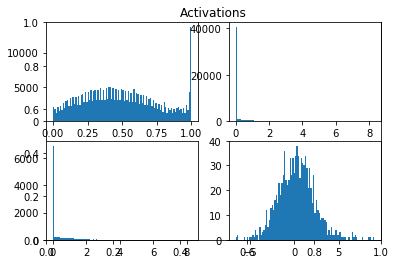

[5 7 9 7 3 9 4 7 9 6 9 0 1 4 1 2 5 1 0 6 9 7 2 9 2 4 6 1 5 7 1 1 0 4 3 2 0
 6 1 0 6 8 8 6 2 2 2 7 2 0 5 5 1 3 8 2 0 3 1 2 6 1 5 8 1 7 2 9 6 9 4 2 6 5
 9 1 3 7 6 3 6 1 7 1 3 0 2 2 2 7 8 7 9 8 3 6 2 6 0 2]
[ 9 14 17  8  5  7 13 11  6 10]
[6 8 7 ..., 5 6 4]
[509 550 627 346 420 290 834 402 598 424]
cost: 39.2068369420134, train accuracy: 0.53, validation accuracy: 0.5158
iterations finished: 5501 alpha: 0.00031381059609000004 reg. lambda: 0.0


Weights 0 Mean -0.000595673787319 SD 0.0249501088656
Weights 1 Mean -0.00240611368839 SD 0.061959673518
Weights 2 Mean 0.000786497118276 SD 0.181839905788


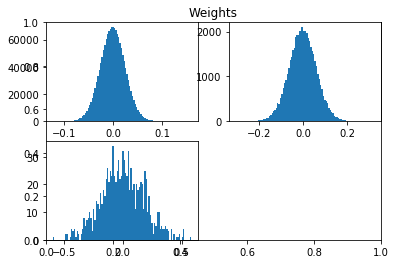

dW 0 Mean 0.0168770807793 SD 0.168521591718
dW 1 Mean 0.0251133008747 SD 0.464982766433
dW 2 Mean -4.26325641456e-17 SD 1.64416849034


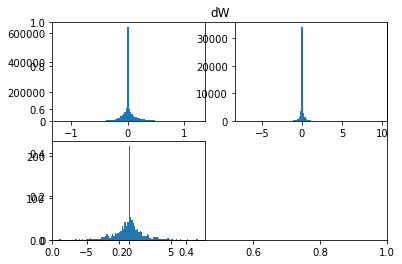

Biases 0 Mean 0.0988052318685 SD 0.0441420659096
Biases 1 Mean 0.124189638228 SD 0.144901478507
Biases 2 Mean 0.1 SD 0.384448982189


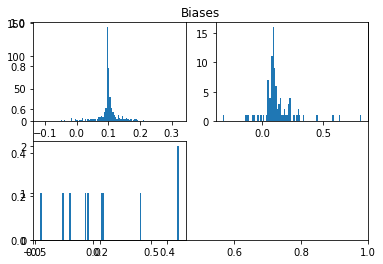

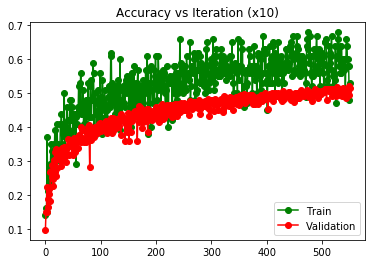

[8 5 3 3 7 4 1 3 4 6 8 7 9 7 6 8 4 1 9 8 8 9 6 1 8 0 9 8 5 3 0 9 6 3 9 6 9
 8 6 6 9 3 7 8 9 6 9 8 8 7 6 6 6 1 8 6 7 4 0 6 4 2 9 1 8 6 9 8 6 6 4 1 3 7
 2 7 6 2 8 8 9 2 4 7 0 6 2 3 1 1 6 9 6 6 6 2 8 6 4 0]
[ 5  8  6  8  8  2 23  9 17 14]
[6 8 7 ..., 5 6 6]
[ 367  427  391  508  389  272 1069  475  562  540]
cost: 37.127273518726625, train accuracy: 0.63, validation accuracy: 0.5012
iterations finished: 5511 alpha: 0.00031381059609000004 reg. lambda: 0.0


[2 9 0 8 0 1 6 9 6 1 0 2 2 8 6 2 9 6 5 0 8 7 2 6 2 1 6 2 0 1 4 3 6 9 2 0 1
 1 6 2 2 3 5 0 5 1 6 8 2 5 5 5 9 5 0 0 8 4 2 7 1 4 1 8 1 0 3 4 6 2 0 6 0 8
 9 1 9 0 8 4 4 0 4 1 3 4 3 2 9 8 3 2 6 8 3 2 1 2 8 0]
[15 13 17  7  8  7 12  2 11  8]
[6 8 7 ..., 5 5 4]
[468 577 696 477 280 552 456 436 575 483]
cost: 37.75681053316802, train accuracy: 0.69, validation accuracy: 0.518
iterations finished: 5521 alpha: 0.00031381059609000004 reg. lambda: 0.0


[3 8 3 0 0 2 9 8 5 5 4 4 9 0 6 0 0 6 6 8 4 2 1 4 8 9 9 0 8 8 6 8 1 8 3 6 0
 5 6 8 8 5 8 7 4 8 7 

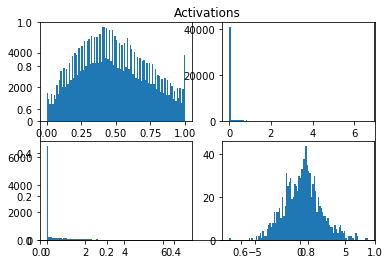

[6 4 9 8 0 4 3 3 8 3 5 5 3 4 3 0 1 8 1 4 7 9 4 4 4 4 5 7 0 1 9 5 3 1 6 9 6
 8 3 9 3 4 5 0 6 6 8 6 4 3 1 6 6 6 6 2 5 3 2 9 5 2 7 4 2 3 8 3 2 0 4 0 8 4
 0 7 7 5 5 1 4 6 4 9 6 6 0 4 5 4 9 7 5 4 3 5 1 1 5 5]
[ 8  8  5 13 18 14 13  6  7  8]
[6 8 7 ..., 5 5 4]
[428 460 353 507 605 645 675 409 505 413]
cost: 38.624117151966054, train accuracy: 0.62, validation accuracy: 0.507
iterations finished: 5601 alpha: 0.00031381059609000004 reg. lambda: 0.0


Weights 0 Mean -0.000590340839842 SD 0.0249597642038
Weights 1 Mean -0.00240966030963 SD 0.062001843123
Weights 2 Mean 0.000786497118276 SD 0.182415523491


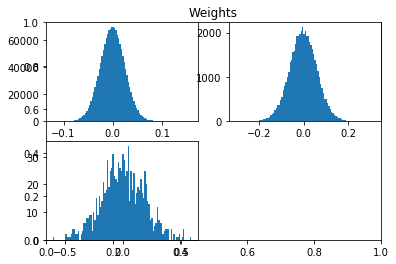

dW 0 Mean 0.00613632271338 SD 0.216731826889
dW 1 Mean 0.0316976836608 SD 0.609564081266
dW 2 Mean -5.68434188608e-17 SD 2.23667831971


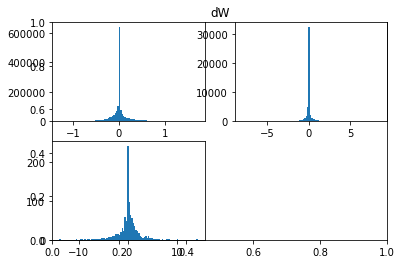

Biases 0 Mean 0.0988076633136 SD 0.0444192595983
Biases 1 Mean 0.124428364506 SD 0.145876958549
Biases 2 Mean 0.1 SD 0.387306270247


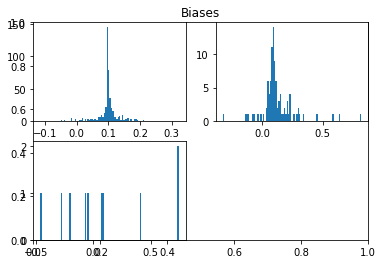

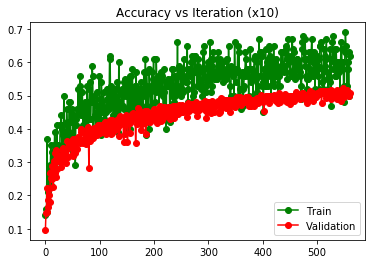

[0 5 3 4 2 0 9 5 8 1 0 6 9 7 3 4 4 5 2 5 9 6 1 8 9 5 4 4 7 4 8 4 9 1 8 2 6
 4 1 0 7 0 9 6 4 9 5 5 4 9 6 7 4 4 6 6 2 7 8 9 4 8 6 3 7 7 4 2 0 6 6 4 9 8
 8 2 1 9 7 1 2 7 3 3 4 9 4 7 8 7 7 5 9 0 8 7 0 9 7 9]
[ 8  6  7  5 17  8 10 14 10 15]
[6 8 7 ..., 5 0 4]
[507 481 407 352 588 419 469 482 612 683]
cost: 38.85665894214629, train accuracy: 0.63, validation accuracy: 0.5146
iterations finished: 5611 alpha: 0.00031381059609000004 reg. lambda: 0.0


[3 0 3 6 3 9 6 7 3 6 8 8 6 5 7 9 5 7 9 8 9 6 5 3 7 3 7 6 3 0 9 9 7 8 6 4 7
 9 3 2 6 7 9 1 9 7 6 4 3 7 0 5 4 6 5 1 9 3 7 8 3 8 9 3 7 5 7 1 7 1 8 8 1 9
 8 6 9 9 3 1 8 9 4 3 5 0 4 0 8 3 8 3 6 6 0 0 3 3 4 2]
[ 7  6  2 18  6  7 13 14 12 15]
[6 8 7 ..., 5 6 4]
[375 396 270 579 419 502 734 577 570 578]
cost: 39.093250194673416, train accuracy: 0.64, validation accuracy: 0.5128
iterations finished: 5621 alpha: 0.00031381059609000004 reg. lambda: 0.0


[8 9 6 9 6 7 5 3 6 2 6 9 0 3 9 9 1 7 0 6 5 9 9 5 3 9 0 8 3 1 9 7 1 2 8 5 5
 0 8 3 9 4 5 9 2 5 4 3 6 1 1 7

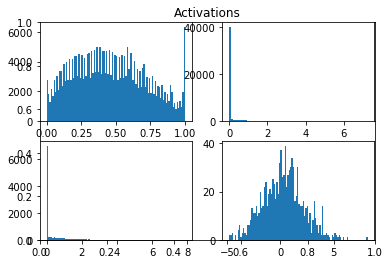

[6 2 8 3 4 8 9 9 5 0 3 6 7 3 8 5 9 8 3 2 4 8 3 2 9 3 7 3 7 8 4 3 7 3 5 8 1
 0 7 0 3 1 5 9 0 2 4 8 1 0 7 4 9 9 6 1 6 3 1 1 9 5 9 8 8 9 2 9 2 9 5 2 8 7
 1 2 9 0 8 9 5 7 2 7 4 5 6 9 8 3 7 5 6 7 3 2 6 5 7 8]
[ 6  7 10 13  6 10  7 12 14 15]
[6 8 7 ..., 5 5 4]
[224 499 459 473 352 546 601 522 654 670]
cost: 37.26415754647547, train accuracy: 0.62, validation accuracy: 0.5094
iterations finished: 5701 alpha: 0.00031381059609000004 reg. lambda: 0.0


Weights 0 Mean -0.000585542223991 SD 0.0249693863714
Weights 1 Mean -0.00241687841401 SD 0.0620515284201
Weights 2 Mean 0.000786497118276 SD 0.183108351766


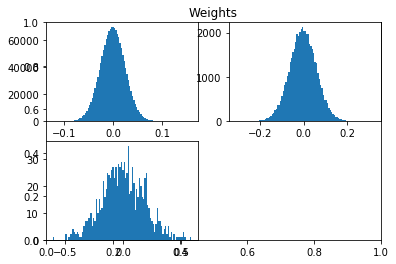

dW 0 Mean 0.000254212217817 SD 0.171048191041
dW 1 Mean 0.0303148701998 SD 0.517268734849
dW 2 Mean 0.0 SD 1.69897108215


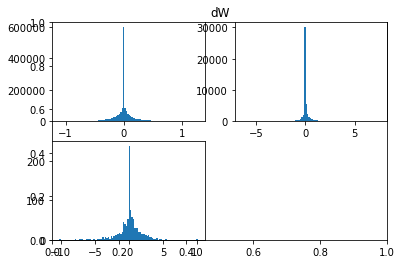

Biases 0 Mean 0.0987994018891 SD 0.0446517355594
Biases 1 Mean 0.124612667271 SD 0.146674247354
Biases 2 Mean 0.1 SD 0.388959983371


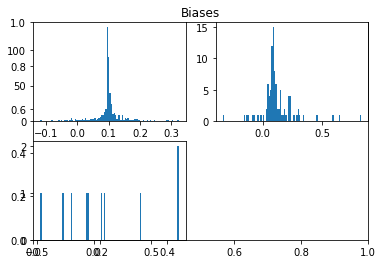

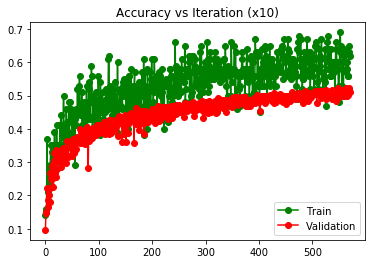

[4 6 3 6 4 9 0 7 6 1 6 4 1 5 1 5 8 2 1 4 4 6 1 0 5 0 5 0 3 5 4 1 1 4 2 1 2
 4 1 0 1 5 2 1 1 2 0 2 1 1 3 9 8 3 0 1 1 1 2 0 3 6 6 4 5 9 2 8 7 1 5 9 8 2
 1 4 1 4 9 5 9 4 7 7 4 6 8 8 7 4 6 2 9 5 9 0 9 5 5 6]
[ 9 20 10  5 14 12 10  5  6  9]
[6 1 7 ..., 5 5 4]
[479 607 506 317 475 574 621 549 395 477]
cost: 39.35591542464589, train accuracy: 0.61, validation accuracy: 0.5148
iterations finished: 5711 alpha: 0.00031381059609000004 reg. lambda: 0.0


[4 8 5 3 1 1 6 9 3 7 6 1 0 9 3 2 9 7 6 1 2 4 5 3 0 1 6 9 1 2 0 4 8 1 8 3 7
 1 3 2 0 7 8 2 9 6 9 6 3 1 1 3 8 7 6 6 7 2 2 0 8 9 7 5 5 3 7 6 9 8 6 7 3 6
 9 8 1 9 4 8 8 2 4 0 2 6 8 8 2 7 9 2 3 4 5 4 3 3 9 6]
[ 6 11 11 13  7  5 13 10 12 12]
[6 1 7 ..., 5 3 4]
[357 588 520 582 316 385 688 499 488 577]
cost: 40.646588013026204, train accuracy: 0.6, validation accuracy: 0.5152
iterations finished: 5721 alpha: 0.00031381059609000004 reg. lambda: 0.0


[8 2 6 7 7 6 9 1 7 6 1 5 7 4 1 1 7 4 3 2 0 6 7 7 2 8 3 4 9 3 3 3 6 6 6 7 3
 7 9 5 1 0 3 9 3 3 1 4 7 4 9 8 

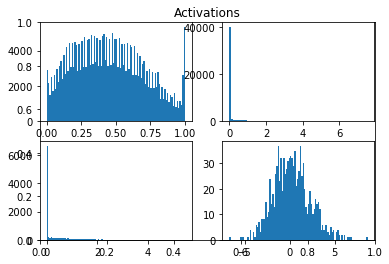

[8 9 0 3 5 7 6 2 1 5 3 4 8 7 7 9 6 4 0 9 6 1 6 7 4 8 4 8 4 5 6 3 5 3 7 5 8
 8 1 5 9 1 1 4 2 8 9 3 6 5 8 9 2 4 2 6 5 8 8 6 5 5 6 9 2 3 1 6 9 5 1 2 9 0
 1 8 9 8 4 2 5 8 3 9 0 4 2 8 7 7 3 6 6 1 7 0 1 2 5 8]
[ 5 10  9  8  9 13 12  8 15 11]
[6 8 7 ..., 5 6 4]
[379 371 422 342 641 528 615 450 682 570]
cost: 40.10330367996984, train accuracy: 0.59, validation accuracy: 0.513
iterations finished: 5801 alpha: 0.00031381059609000004 reg. lambda: 0.0


Weights 0 Mean -0.000584783196235 SD 0.0249794927765
Weights 1 Mean -0.00239769144945 SD 0.0621045830397
Weights 2 Mean 0.000786497118276 SD 0.183838450554


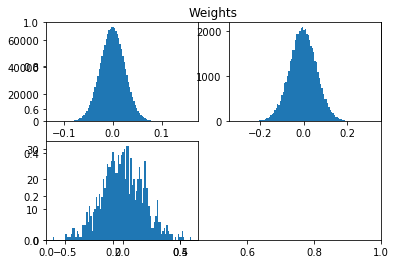

dW 0 Mean 0.00460780164888 SD 0.201884622682
dW 1 Mean 0.0056364169163 SD 0.590049442744
dW 2 Mean -5.68434188608e-17 SD 2.73457985555


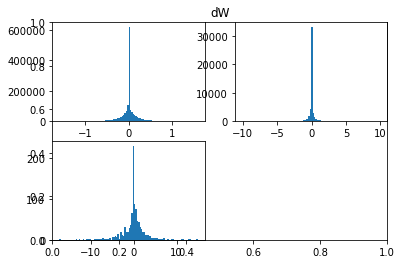

Biases 0 Mean 0.098810075802 SD 0.0448912920934
Biases 1 Mean 0.124939383267 SD 0.147660235168
Biases 2 Mean 0.1 SD 0.390613896607


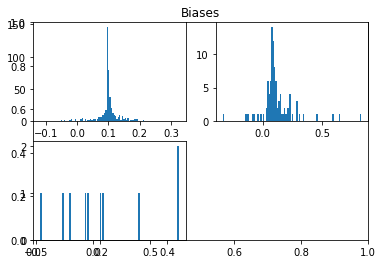

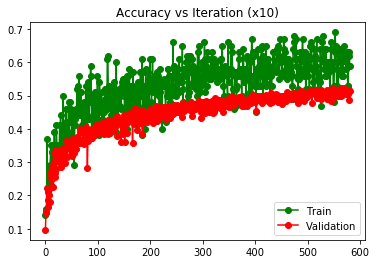

[3 5 6 2 1 0 2 9 6 3 0 5 0 4 8 6 5 3 4 1 0 7 4 1 5 6 2 5 7 1 1 2 9 1 2 1 9
 1 2 2 2 8 2 2 9 0 9 9 2 5 6 3 6 4 1 3 5 5 1 2 8 6 6 8 1 2 0 1 3 8 6 5 2 5
 5 2 1 0 9 9 7 5 0 8 8 1 3 1 6 2 2 8 1 4 9 6 2 3 6 8]
[ 8 16 18  8  5 12 12  3  9  9]
[6 8 7 ..., 2 5 2]
[414 642 640 379 180 615 627 285 479 739]
cost: 40.77085640644747, train accuracy: 0.57, validation accuracy: 0.4904
iterations finished: 5811 alpha: 0.00031381059609000004 reg. lambda: 0.0


[8 1 5 4 8 9 6 0 8 8 1 6 7 7 8 4 8 3 6 1 6 6 6 0 7 7 9 8 9 8 1 8 1 2 6 6 8
 0 9 8 9 2 9 4 6 0 9 1 5 6 9 9 6 5 3 1 8 9 2 9 0 4 0 7 6 8 4 8 9 3 8 6 8 0
 1 6 4 1 8 8 0 3 5 9 8 0 4 9 9 6 5 8 3 7 9 1 1 8 1 7]
[ 9 12  3  5  7  5 15  7 21 16]
[6 1 7 ..., 5 6 4]
[387 638 329 261 548 313 794 389 596 745]
cost: 40.032418152729576, train accuracy: 0.57, validation accuracy: 0.496
iterations finished: 5821 alpha: 0.00031381059609000004 reg. lambda: 0.0


[1 3 7 8 5 6 7 8 7 9 0 7 0 3 0 6 7 7 9 8 4 7 7 5 3 4 2 8 0 9 7 3 9 0 9 4 9
 2 1 0 2 9 9 5 3 2 3 2 0 7 0 6 

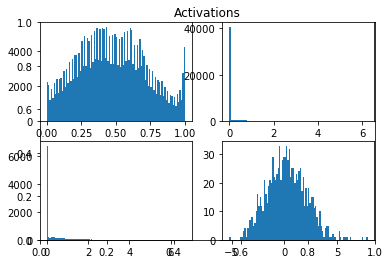

[9 5 7 8 6 5 2 4 2 6 3 9 2 1 5 2 0 0 2 7 1 0 6 5 0 2 2 0 0 3 8 4 6 9 7 1 7
 0 8 7 7 4 2 4 0 5 4 4 8 0 2 9 5 9 5 6 5 0 6 2 7 9 3 1 5 5 7 4 6 0 5 6 5 5
 7 7 5 7 9 8 6 6 2 4 6 1 9 7 6 4 8 6 4 4 0 5 7 4 6 3]
[12  5 11  4 12 15 14 13  6  8]
[6 8 7 ..., 5 5 4]
[358 371 476 429 644 558 651 557 549 407]
cost: 37.01768264198045, train accuracy: 0.58, validation accuracy: 0.5106
iterations finished: 5901 alpha: 0.00031381059609000004 reg. lambda: 0.0


Weights 0 Mean -0.000584027586421 SD 0.0249897988524
Weights 1 Mean -0.00237797373301 SD 0.0621594029509
Weights 2 Mean 0.000786497118276 SD 0.184602916942


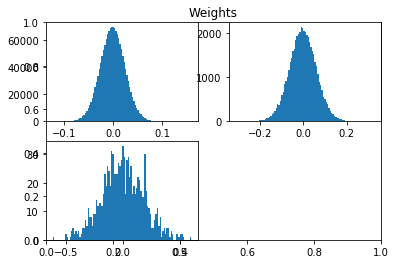

dW 0 Mean -0.00410867509753 SD 0.208624195467
dW 1 Mean -0.00139116291637 SD 0.495548246783
dW 2 Mean -2.84217094304e-17 SD 1.96429964514


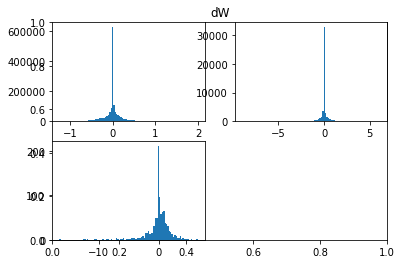

Biases 0 Mean 0.0988087448278 SD 0.0452616468891
Biases 1 Mean 0.125337086245 SD 0.148537593128
Biases 2 Mean 0.1 SD 0.392035988861


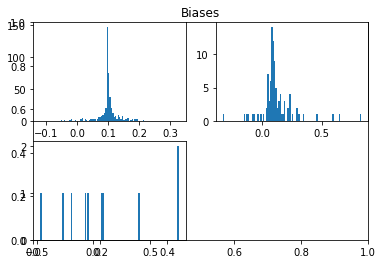

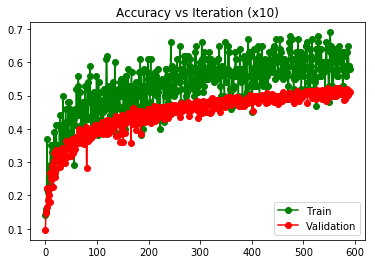

[3 9 6 8 4 7 0 0 8 4 9 6 3 3 3 3 1 3 7 9 7 7 1 6 8 8 7 7 7 6 6 3 9 5 8 4 5
 1 3 1 5 3 6 0 6 6 3 0 1 6 3 7 7 7 8 2 0 1 4 9 3 4 6 5 6 4 0 8 2 4 5 3 7 0
 5 2 8 3 7 8 3 0 0 0 6 6 5 2 9 6 3 6 1 6 5 8 1 0 7 3]
[11  8  4 17  7  8 16 13 10  6]
[6 8 7 ..., 5 6 4]
[468 440 343 368 388 439 722 686 627 519]
cost: 38.90144392257055, train accuracy: 0.62, validation accuracy: 0.5206
iterations finished: 5911 alpha: 0.00031381059609000004 reg. lambda: 0.0


[8 3 3 6 5 2 5 5 2 8 6 8 6 0 3 5 1 1 6 5 3 7 8 7 1 2 5 7 0 7 6 2 6 9 4 7 1
 8 2 4 8 3 9 8 7 7 9 3 7 3 6 1 7 2 4 5 4 2 8 6 8 3 8 8 1 0 0 2 8 7 6 7 0 9
 0 0 3 9 5 2 3 0 5 9 9 0 9 9 8 6 7 2 2 6 0 1 0 5 9 5]
[11  7 11 10  4 11 11 12 13 10]
[6 7 7 ..., 5 6 4]
[519 527 516 399 275 569 630 613 509 443]
cost: 39.360943321288126, train accuracy: 0.55, validation accuracy: 0.5218
iterations finished: 5921 alpha: 0.00031381059609000004 reg. lambda: 0.0


[0 0 0 4 7 5 7 0 1 7 8 7 8 5 1 7 3 1 7 3 5 1 9 8 1 7 1 8 1 5 6 7 8 6 1 1 4
 8 9 6 2 3 0 7 7 0 1 7 2 3 0 3

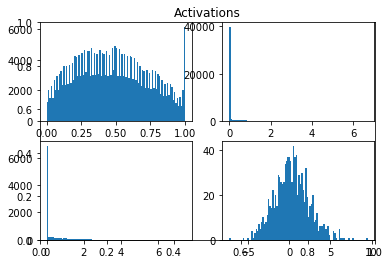

[1 1 2 2 0 4 0 8 9 5 9 5 1 2 5 8 2 7 0 9 5 3 7 2 1 9 1 9 0 2 0 3 0 0 1 5 0
 2 2 7 9 5 8 1 6 7 0 3 1 0 7 1 7 5 2 9 9 0 5 5 2 1 5 9 8 8 2 9 1 0 7 7 0 8
 1 3 5 2 7 3 2 2 6 1 0 5 7 2 1 8 2 2 2 3 0 8 8 5 9 7]
[15 14 18  6  1 13  2 11  9 11]
[6 1 0 ..., 5 6 4]
[693 651 562 385 473 324 466 517 384 545]
cost: 40.814101201119676, train accuracy: 0.65, validation accuracy: 0.5136
iterations finished: 6001 alpha: 0.00028242953648100003 reg. lambda: 0.0


Weights 0 Mean -0.000570304092626 SD 0.0250010646172
Weights 1 Mean -0.00236232602768 SD 0.062219292172
Weights 2 Mean 0.000786497118276 SD 0.185406246233


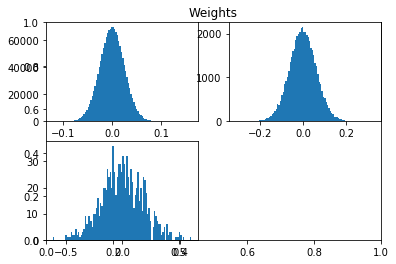

dW 0 Mean -0.00787635576671 SD 0.182298046553
dW 1 Mean -0.0142694717082 SD 0.478893387618
dW 2 Mean -5.68434188608e-17 SD 1.99220683446


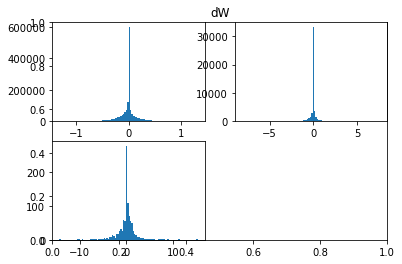

Biases 0 Mean 0.0988603990205 SD 0.0454731229302
Biases 1 Mean 0.125626647438 SD 0.149178112061
Biases 2 Mean 0.1 SD 0.39347135862


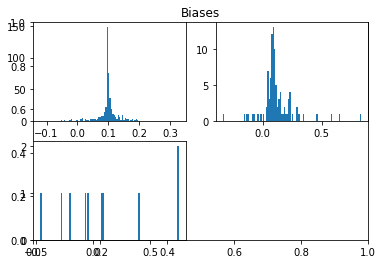

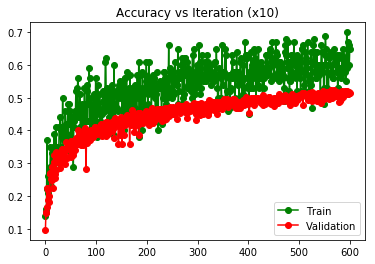

[6 0 8 4 1 7 5 9 0 9 2 4 8 6 8 4 2 3 8 8 7 3 6 1 7 2 1 8 5 5 1 6 0 2 3 2 8
 8 6 8 6 4 2 5 5 6 2 6 5 9 5 9 4 0 0 7 9 9 8 9 8 2 7 4 2 5 0 8 8 6 2 7 4 7
 7 6 3 2 7 3 4 6 8 3 8 7 3 2 2 1 1 4 9 4 8 9 2 9 6 8]
[ 6  6 14  7 10  8 12 10 17 10]
[6 8 7 ..., 5 5 4]
[565 546 473 248 407 735 444 470 560 552]
cost: 38.503852640831944, train accuracy: 0.7, validation accuracy: 0.5198
iterations finished: 6011 alpha: 0.00028242953648100003 reg. lambda: 0.0


[6 0 1 2 6 7 1 4 0 5 4 1 6 3 0 7 1 5 4 8 8 6 4 9 2 5 3 0 3 6 6 5 1 5 6 8 8
 9 2 8 8 1 6 8 9 9 6 8 3 5 6 9 8 5 8 6 5 5 7 9 9 5 1 8 4 1 9 4 0 1 6 6 2 8
 5 0 9 4 1 9 6 2 0 4 9 9 3 9 7 7 9 8 7 5 5 3 0 2 5 6]
[ 8 10  6  6  8 14 15  6 13 14]
[6 8 7 ..., 5 5 4]
[444 394 324 446 399 641 747 453 513 639]
cost: 41.437732572578646, train accuracy: 0.74, validation accuracy: 0.5088
iterations finished: 6021 alpha: 0.00028242953648100003 reg. lambda: 0.0


[3 4 2 0 1 2 2 6 9 8 6 1 0 7 7 4 0 0 8 5 7 6 6 3 9 0 2 6 6 5 9 4 1 1 6 8 3
 3 0 0 5 6 3 6 2 6 1 3 3 1 5 3

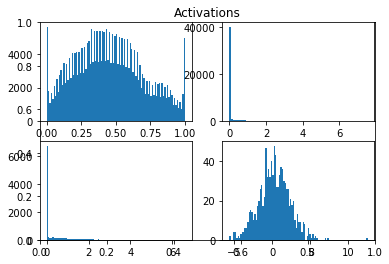

[8 2 6 8 9 6 3 8 0 0 8 8 8 9 8 5 2 3 2 5 8 1 5 6 0 0 7 9 0 6 5 9 8 3 4 4 1
 1 1 8 0 6 6 6 3 8 1 0 0 6 3 9 0 9 4 1 1 4 4 4 8 5 0 3 3 4 8 6 9 6 1 6 2 9
 0 7 0 8 6 7 9 4 5 3 3 4 4 2 6 7 4 5 8 6 4 9 7 7 3 2]
[12  8  6 10 12  7 14  6 15 10]
[6 8 7 ..., 5 6 4]
[759 460 299 486 451 350 708 423 520 544]
cost: 39.038992053836445, train accuracy: 0.63, validation accuracy: 0.519
iterations finished: 6101 alpha: 0.00028242953648100003 reg. lambda: 0.0


Weights 0 Mean -0.000575656082131 SD 0.0250096675568
Weights 1 Mean -0.00239515030363 SD 0.0622591043826
Weights 2 Mean 0.000786497118276 SD 0.185958314944


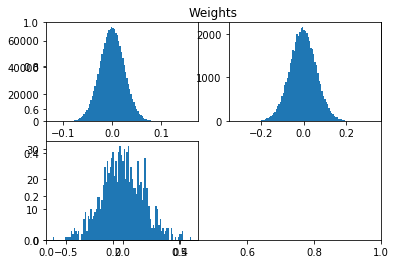

dW 0 Mean -0.00292271229494 SD 0.22274183911
dW 1 Mean 0.00973005315669 SD 0.569112217818
dW 2 Mean 4.26325641456e-17 SD 2.63418202879


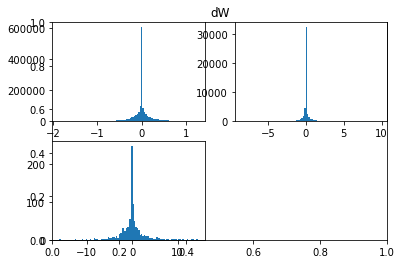

Biases 0 Mean 0.098849075857 SD 0.0456673721638
Biases 1 Mean 0.125740315189 SD 0.150079222566
Biases 2 Mean 0.1 SD 0.393996194959


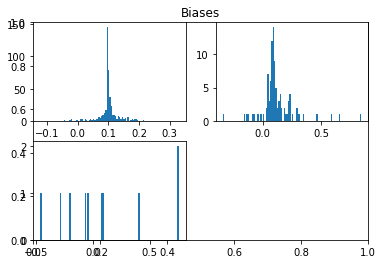

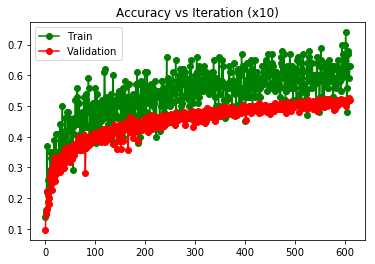

[7 4 6 9 6 8 0 9 0 0 7 3 6 3 0 1 5 4 9 9 9 1 8 4 9 3 7 8 0 9 9 3 0 7 7 6 6
 0 1 2 6 8 7 2 0 8 9 1 2 6 0 2 4 3 3 2 4 0 8 4 0 1 1 1 3 6 3 9 8 7 4 8 1 9
 9 7 2 6 1 6 1 6 6 2 0 2 3 8 9 1 4 7 7 0 4 6 6 9 1 1]
[13 13  8  9  9  1 14 10  9 14]
[6 8 7 ..., 2 6 4]
[475 600 449 481 564 267 597 461 551 555]
cost: 38.693598887067516, train accuracy: 0.65, validation accuracy: 0.5238
iterations finished: 6111 alpha: 0.00028242953648100003 reg. lambda: 0.0


[5 9 5 1 0 0 0 1 6 1 1 5 0 5 3 6 0 0 3 4 9 0 3 2 4 1 8 0 3 7 2 1 5 5 3 7 6
 7 2 5 3 8 1 9 1 5 9 2 4 0 6 0 1 6 4 3 6 0 4 3 4 9 6 8 0 8 0 9 8 3 9 9 8 1
 5 7 6 1 6 3 4 8 2 8 8 4 3 6 3 9 3 6 8 1 0 1 2 4 9 6]
[14 13  6 13  9  9 12  4 10 10]
[6 1 0 ..., 5 6 4]
[729 664 451 407 361 394 627 367 420 580]
cost: 38.02842868590476, train accuracy: 0.59, validation accuracy: 0.5112
iterations finished: 6121 alpha: 0.00028242953648100003 reg. lambda: 0.0


[2 1 4 2 4 7 8 8 7 2 7 6 2 0 1 7 6 8 3 2 2 2 7 8 3 3 9 2 6 5 7 3 3 4 2 1 4
 7 0 1 5 2 4 3 0 1 8 7 7 7 7 8

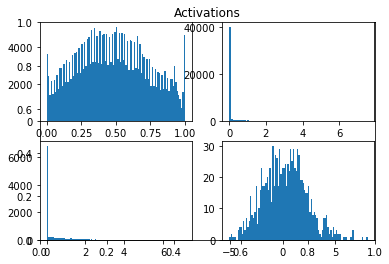

[0 0 8 0 0 7 1 5 0 2 6 5 5 4 6 3 1 8 3 7 5 4 1 4 5 2 4 6 1 0 0 3 3 1 1 3 5
 5 9 8 2 3 5 3 4 6 9 1 8 1 8 2 8 5 1 9 8 7 6 1 0 7 5 7 1 6 5 9 2 2 8 2 3 3
 6 9 6 1 1 9 3 6 7 8 5 4 0 3 4 0 0 5 0 7 9 0 8 6 0 6]
[14 13  7 11  7 13 11  7 10  7]
[6 8 7 ..., 5 5 4]
[524 497 522 341 401 581 661 521 557 395]
cost: 39.89542513499403, train accuracy: 0.6, validation accuracy: 0.5276
iterations finished: 6201 alpha: 0.00028242953648100003 reg. lambda: 0.0


Weights 0 Mean -0.000565009425936 SD 0.0250178570677
Weights 1 Mean -0.00242599926521 SD 0.0622997044494
Weights 2 Mean 0.000786497118276 SD 0.186582461715


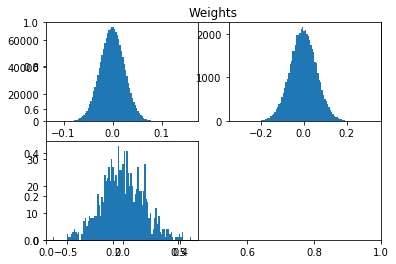

dW 0 Mean 0.0115660884433 SD 0.193817046519
dW 1 Mean -0.00491694105547 SD 0.528677220176
dW 2 Mean 5.68434188608e-17 SD 2.27274242959


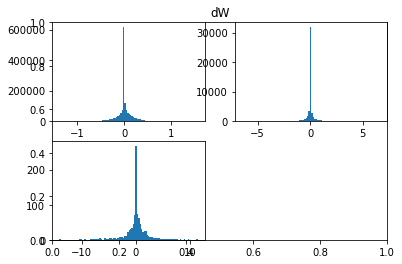

Biases 0 Mean 0.0988720582854 SD 0.0459677577894
Biases 1 Mean 0.125945431214 SD 0.151356198586
Biases 2 Mean 0.1 SD 0.395760597935


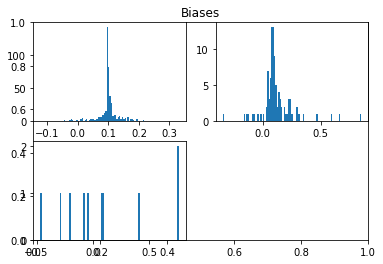

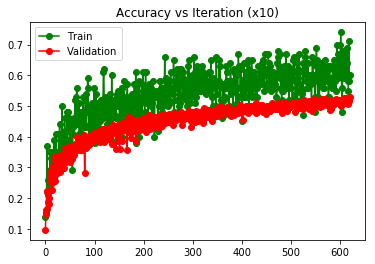

[6 3 0 6 3 1 1 8 9 8 6 7 6 4 4 7 5 6 0 1 6 5 8 6 2 7 2 0 4 3 5 3 2 6 9 9 0
 4 7 4 8 5 3 8 2 2 6 1 3 0 8 0 7 8 1 4 0 6 4 8 7 8 1 8 6 2 6 6 8 1 2 0 0 0
 4 6 6 8 3 1 1 0 5 5 9 7 4 2 2 9 1 7 1 0 7 5 7 4 0 8]
[13 11  9  7 10  7 15 10 13  5]
[6 8 7 ..., 5 6 4]
[535 541 555 331 451 468 739 432 564 384]
cost: 41.089679923484674, train accuracy: 0.6, validation accuracy: 0.5198
iterations finished: 6211 alpha: 0.00028242953648100003 reg. lambda: 0.0


[9 6 7 8 8 9 9 3 3 4 7 0 4 0 6 7 9 6 1 0 0 8 5 1 4 7 8 0 1 9 7 1 0 2 6 8 5
 3 1 2 3 0 0 3 6 0 9 3 7 5 4 3 1 6 6 7 3 3 1 5 6 4 0 6 0 7 6 7 6 3 7 8 0 1
 6 3 6 7 5 6 5 1 9 7 7 9 6 0 7 3 5 5 0 2 5 5 5 8 0 8]
[15  9  3 12  5 11 15 14  8  8]
[6 1 7 ..., 5 5 4]
[510 575 298 501 358 463 600 620 549 526]
cost: 38.1183362062161, train accuracy: 0.6, validation accuracy: 0.5242
iterations finished: 6221 alpha: 0.00028242953648100003 reg. lambda: 0.0


[6 1 7 4 7 6 1 1 6 4 4 1 0 5 5 4 9 9 8 2 9 4 1 7 4 8 9 7 1 3 1 2 6 4 8 4 9
 9 3 5 3 1 3 8 7 4 5 3 0 8 0 8 1 

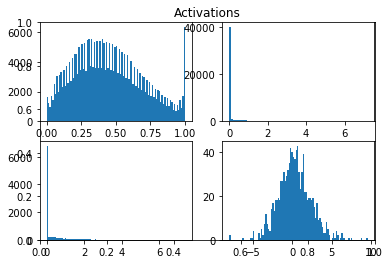

[6 0 7 7 7 9 2 6 3 8 2 0 6 6 6 1 1 4 3 4 6 1 7 2 1 1 6 6 5 5 5 1 4 2 0 9 0
 9 6 0 9 7 4 9 2 4 8 9 4 6 0 9 5 6 7 3 9 8 4 0 4 2 0 4 4 7 8 7 4 7 9 1 9 6
 5 7 6 9 7 6 4 9 7 2 3 8 6 1 6 6 7 2 1 1 0 9 6 5 1 4]
[ 9 11  8  4 13  6 18 13  5 13]
[6 8 7 ..., 5 3 4]
[375 511 261 398 546 407 760 462 596 684]
cost: 39.58249219309114, train accuracy: 0.58, validation accuracy: 0.5188
iterations finished: 6301 alpha: 0.00028242953648100003 reg. lambda: 0.0


Weights 0 Mean -0.000581542572931 SD 0.0250260659324
Weights 1 Mean -0.00242632103891 SD 0.0623414118786
Weights 2 Mean 0.000786497118276 SD 0.187141595674


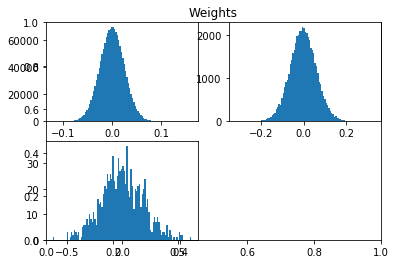

dW 0 Mean 0.0142005588179 SD 0.198586174154
dW 1 Mean 0.00627222999166 SD 0.508187247239
dW 2 Mean -5.68434188608e-17 SD 1.74050051397


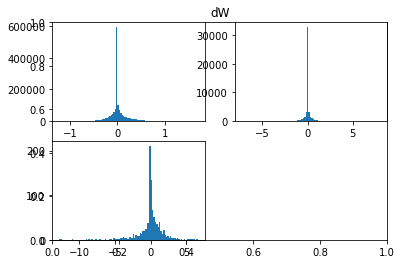

Biases 0 Mean 0.0988305844456 SD 0.0462202092513
Biases 1 Mean 0.126233913137 SD 0.152161106811
Biases 2 Mean 0.1 SD 0.397468476787


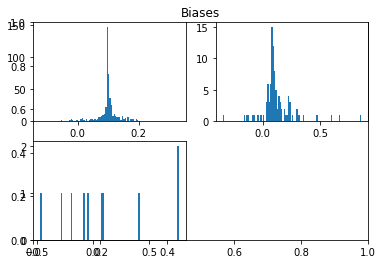

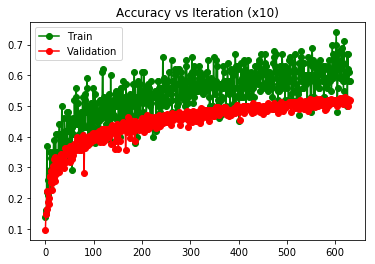

[3 6 9 6 6 7 8 3 0 5 8 6 9 3 8 8 8 8 5 5 2 2 6 8 5 7 1 3 2 3 2 3 1 0 8 0 0
 1 7 9 9 3 9 3 5 5 9 1 7 0 1 3 2 9 6 6 0 5 1 5 6 5 2 1 4 5 4 3 0 3 9 8 8 2
 8 0 2 6 8 1 4 3 1 3 0 3 8 3 3 7 3 1 1 4 9 6 3 9 1 9]
[ 9 12  8 18  4 10 10  5 13 11]
[6 8 7 ..., 5 6 4]
[326 482 411 572 419 328 679 489 645 649]
cost: 41.47974509482042, train accuracy: 0.56, validation accuracy: 0.5198
iterations finished: 6311 alpha: 0.00028242953648100003 reg. lambda: 0.0


[8 6 1 8 4 2 1 4 4 1 7 0 6 9 4 4 1 2 3 8 4 4 1 4 8 3 9 4 6 2 0 9 3 6 3 0 5
 0 4 8 1 9 6 3 2 3 0 4 3 4 4 6 7 9 7 0 6 4 5 1 3 7 0 0 0 3 4 5 9 2 8 2 0 3
 0 8 4 3 9 6 9 5 0 0 5 0 9 7 3 9 3 5 8 4 4 8 6 1 5 0]
[15  8  6 13 18  7  9  5  9 10]
[6 8 7 ..., 5 6 4]
[506 595 302 527 591 287 769 427 542 454]
cost: 38.19799491631241, train accuracy: 0.61, validation accuracy: 0.5202
iterations finished: 6321 alpha: 0.00028242953648100003 reg. lambda: 0.0


[2 6 8 2 3 1 8 6 8 0 9 3 2 2 2 0 1 2 6 1 2 0 3 3 0 8 6 4 9 4 0 4 2 0 8 2 3
 7 4 5 4 1 9 6 9 5 0 6 8 6 8 1 

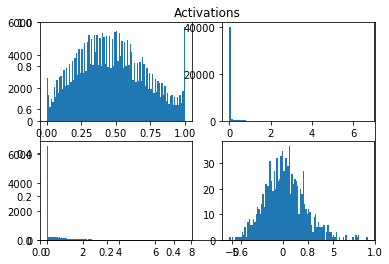

[7 4 3 7 6 5 3 3 0 3 7 2 3 6 2 5 2 2 8 7 7 6 5 7 7 1 0 8 6 4 3 0 8 3 1 7 0
 8 3 9 0 6 6 1 8 4 3 4 1 0 7 6 9 6 6 2 6 8 3 9 9 9 3 4 4 7 6 9 8 5 2 8 6 8
 0 3 1 3 0 8 8 8 7 7 2 6 3 0 1 0 2 3 8 4 5 7 9 2 1 7]
[10  7  9 15  7  5 13 14 13  7]
[6 8 7 ..., 5 3 4]
[513 360 409 529 509 270 454 606 710 640]
cost: 39.513395626872715, train accuracy: 0.52, validation accuracy: 0.5206
iterations finished: 6401 alpha: 0.00028242953648100003 reg. lambda: 0.0


Weights 0 Mean -0.000573777091919 SD 0.0250349957667
Weights 1 Mean -0.00243403225235 SD 0.0623893159002
Weights 2 Mean 0.000786497118276 SD 0.187814966981


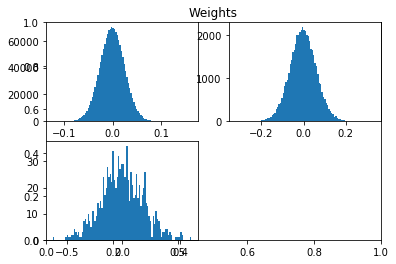

dW 0 Mean 0.00754300463951 SD 0.180538732917
dW 1 Mean 0.00507881615526 SD 0.498390823236
dW 2 Mean 0.0 SD 2.05272145917


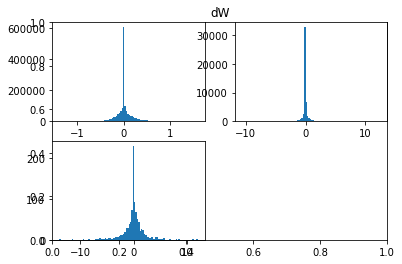

Biases 0 Mean 0.098848035354 SD 0.0463994956531
Biases 1 Mean 0.126405096065 SD 0.152861884655
Biases 2 Mean 0.1 SD 0.398153003125


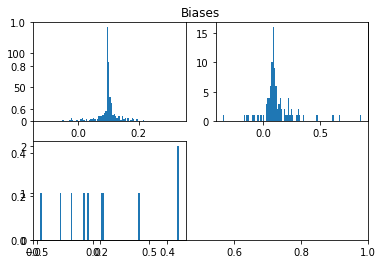

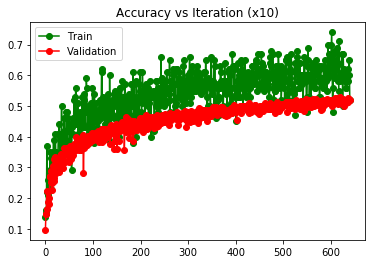

[2 9 1 7 9 0 2 8 8 7 6 1 7 6 0 7 9 9 4 7 9 0 6 8 5 1 8 5 6 9 7 8 9 9 7 1 7
 6 2 9 6 8 3 4 3 9 8 0 0 4 1 3 4 9 9 7 8 4 8 4 6 3 4 8 1 9 1 1 8 5 2 9 4 1
 9 6 5 4 7 4 3 9 9 2 9 4 7 9 0 4 9 1 5 4 6 6 9 0 0 9]
[ 8 10  5  5 13  5 10 11 11 22]
[6 8 7 ..., 5 3 4]
[379 453 283 492 516 404 609 639 523 702]
cost: 39.28236077903504, train accuracy: 0.6, validation accuracy: 0.514
iterations finished: 6411 alpha: 0.00028242953648100003 reg. lambda: 0.0


[7 6 6 0 6 1 4 4 4 8 4 4 8 8 1 8 4 7 2 9 8 9 8 2 3 6 9 8 9 8 2 5 7 4 6 7 4
 0 4 8 5 9 4 0 0 3 9 1 2 8 7 4 0 0 8 6 6 4 7 4 1 8 4 0 5 3 0 6 8 6 4 8 5 2
 7 0 7 5 3 7 3 9 4 3 9 4 2 3 3 5 3 9 6 9 1 8 2 5 9 4]
[ 9  5  7  9 18  7 10  9 15 11]
[6 8 7 ..., 2 3 4]
[411 516 532 414 641 345 622 455 611 453]
cost: 38.038704049112965, train accuracy: 0.52, validation accuracy: 0.5264
iterations finished: 6421 alpha: 0.00028242953648100003 reg. lambda: 0.0


[1 0 5 6 8 4 3 2 8 7 0 0 8 0 2 3 9 0 6 1 2 4 3 7 3 9 0 0 3 2 8 9 3 1 8 9 1
 3 9 7 3 0 1 3 2 1 0 1 1 2 6 1 8

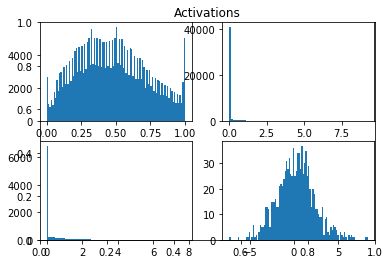

[7 7 7 1 9 3 7 2 7 0 0 7 8 9 0 0 7 9 9 1 6 4 9 2 7 5 2 6 7 0 1 1 8 5 6 6 7
 1 6 7 8 6 8 0 8 8 7 7 8 2 2 7 2 7 9 2 2 1 1 2 1 3 7 2 6 2 4 4 0 8 8 5 4 5
 7 7 5 9 4 2 1 9 5 6 7 8 3 2 7 5 7 5 5 8 1 6 1 4 2 6]
[ 7 11 14  3  6  9 10 21 11  8]
[6 8 7 ..., 5 5 4]
[479 551 503 246 519 433 584 701 512 472]
cost: 40.31355127868304, train accuracy: 0.65, validation accuracy: 0.5216
iterations finished: 6501 alpha: 0.00025418658283290005 reg. lambda: 0.0


Weights 0 Mean -0.00058295981014 SD 0.0250436112492
Weights 1 Mean -0.00242541524069 SD 0.0624335592292
Weights 2 Mean 0.000786497118276 SD 0.188449932175


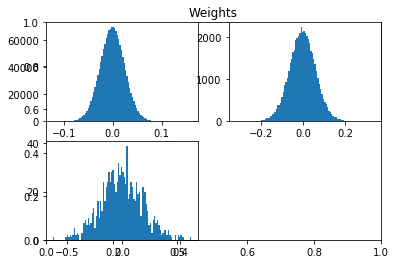

dW 0 Mean -0.00372616876887 SD 0.201686097361
dW 1 Mean 0.0140825492962 SD 0.510016171738
dW 2 Mean 7.1054273576e-17 SD 1.72733948719


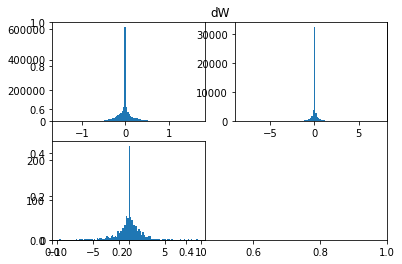

Biases 0 Mean 0.0988343581787 SD 0.0466927990721
Biases 1 Mean 0.126656173392 SD 0.154008068765
Biases 2 Mean 0.1 SD 0.399959854375


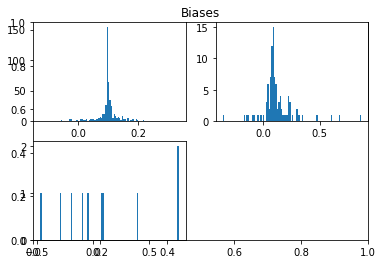

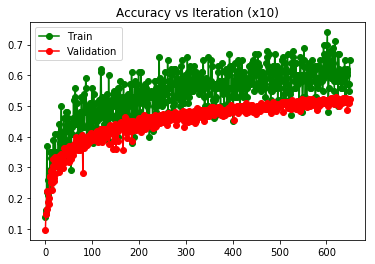

[7 1 1 9 9 2 0 2 0 4 2 1 2 4 4 8 6 3 7 1 3 3 8 8 4 1 3 0 0 4 3 0 4 0 2 1 1
 0 6 4 0 3 6 5 9 1 7 6 9 4 2 0 1 1 6 9 4 3 2 0 3 8 4 3 3 9 8 9 6 0 6 6 1 5
 6 4 7 1 3 2 8 0 9 7 4 8 0 2 0 0 6 8 0 0 0 3 7 1 1 4]
[18 14  9 12 13  2 10  6  8  8]
[6 8 0 ..., 5 3 4]
[625 607 506 540 442 277 583 362 538 520]
cost: 40.08737510780556, train accuracy: 0.65, validation accuracy: 0.5246
iterations finished: 6511 alpha: 0.00025418658283290005 reg. lambda: 0.0


[2 1 5 1 0 4 2 6 0 7 6 5 9 6 7 1 5 2 6 2 7 2 9 8 6 7 2 9 3 5 3 5 0 7 3 2 1
 0 4 2 6 8 7 3 3 1 4 1 9 4 3 5 6 5 7 4 6 5 8 3 1 0 9 0 2 3 9 8 0 6 3 4 3 3
 9 4 5 4 7 3 1 4 8 1 4 6 6 4 1 0 2 9 7 4 8 4 7 4 2 7]
[ 8 10 11 12 14  9 11 11  6  8]
[6 8 7 ..., 5 5 4]
[362 515 484 359 552 546 730 430 496 526]
cost: 40.56590949797151, train accuracy: 0.71, validation accuracy: 0.5226
iterations finished: 6521 alpha: 0.00025418658283290005 reg. lambda: 0.0


[1 4 4 8 4 8 8 9 6 5 3 8 4 5 4 6 4 0 7 2 8 4 5 6 4 9 6 4 6 5 0 8 5 1 1 4 4
 8 9 0 9 9 1 9 8 3 4 4 8 5 2 4 

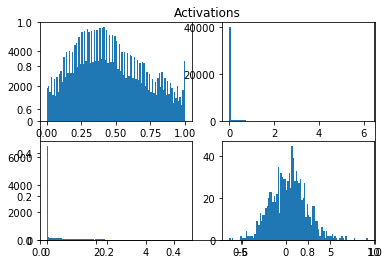

[3 4 9 9 7 0 1 2 3 9 8 4 9 6 4 2 6 8 6 1 9 8 1 0 6 0 8 1 4 5 0 4 9 8 7 2 9
 6 0 0 1 2 7 7 9 6 1 1 6 8 2 1 5 2 7 8 2 7 4 7 2 6 3 5 4 4 1 8 8 5 1 7 1 0
 2 6 4 3 3 7 1 3 5 7 4 7 6 1 1 1 2 6 9 1 7 5 1 1 1 5]
[ 7 19 10  6 10  7 11 12  9  9]
[6 8 7 ..., 5 6 4]
[517 572 564 481 406 330 558 551 551 470]
cost: 39.90096418432495, train accuracy: 0.55, validation accuracy: 0.535
iterations finished: 6601 alpha: 0.00025418658283290005 reg. lambda: 0.0


Weights 0 Mean -0.000576538670822 SD 0.0250513391519
Weights 1 Mean -0.00247064351674 SD 0.0624717583302
Weights 2 Mean 0.000786497118276 SD 0.188999871796


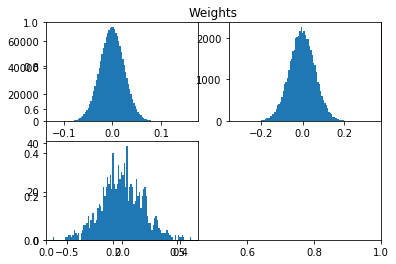

dW 0 Mean 0.00235973161897 SD 0.209433558041
dW 1 Mean 0.0109071138983 SD 0.531865764368
dW 2 Mean 1.42108547152e-17 SD 2.09364618813


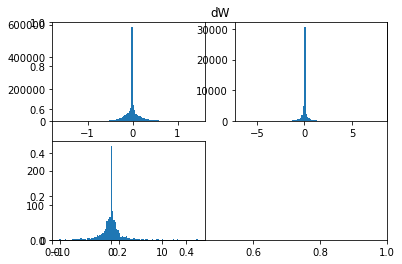

Biases 0 Mean 0.0988614663168 SD 0.0468700236058
Biases 1 Mean 0.126646932682 SD 0.154794848384
Biases 2 Mean 0.1 SD 0.400369430896


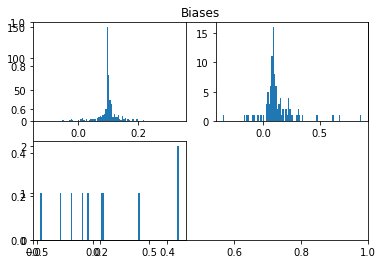

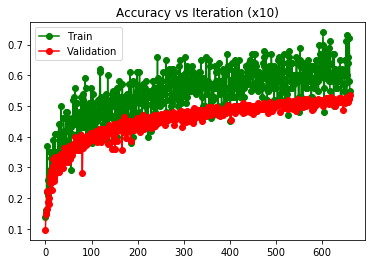

[4 1 4 2 0 6 1 3 6 5 9 6 2 2 5 4 2 9 3 4 0 5 9 9 0 2 8 1 7 9 6 6 7 4 4 2 1
 6 6 6 0 5 1 0 0 9 5 1 5 4 5 9 9 0 8 7 1 2 0 9 9 0 0 9 4 0 4 8 0 8 5 6 5 6
 3 1 0 1 0 5 9 4 9 5 9 7 4 3 2 7 3 0 1 0 3 7 1 9 6 0]
[17 11  8  6 11 11 11  6  4 15]
[6 8 7 ..., 5 3 4]
[618 432 563 289 531 427 469 645 472 554]
cost: 41.30642933196716, train accuracy: 0.64, validation accuracy: 0.5272
iterations finished: 6611 alpha: 0.00025418658283290005 reg. lambda: 0.0


[9 8 7 0 9 5 6 5 6 4 8 2 7 4 9 9 6 2 2 7 2 5 2 9 2 2 7 7 6 4 3 7 7 1 7 4 4
 8 4 1 0 7 4 5 2 7 3 4 9 2 7 7 0 0 5 0 7 6 5 9 4 7 1 0 4 2 1 9 0 2 2 2 6 1
 6 1 7 9 0 3 5 2 4 9 2 8 5 2 4 8 3 8 7 2 8 7 4 9 0 4]
[ 9  6 17  4 14  8  7 17  7 11]
[6 8 7 ..., 5 3 4]
[450 359 636 359 388 485 522 636 577 588]
cost: 39.89646116243062, train accuracy: 0.5, validation accuracy: 0.5224
iterations finished: 6621 alpha: 0.00025418658283290005 reg. lambda: 0.0


[6 9 4 0 7 4 5 3 3 0 8 2 3 2 3 3 3 3 0 1 6 4 6 0 6 3 3 6 4 9 2 3 3 3 8 3 3
 3 3 1 3 4 7 1 4 3 6 2 2 3 4 9 8

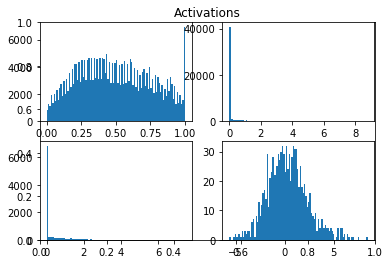

[1 0 8 0 0 5 5 0 5 8 2 7 9 1 5 0 7 7 2 3 9 0 2 4 8 2 9 0 3 0 3 5 3 0 9 3 1
 9 2 3 1 5 0 1 9 7 6 5 3 6 8 0 0 7 7 4 3 6 2 1 0 6 0 6 0 1 9 0 8 2 5 7 9 5
 4 4 6 7 8 9 9 3 7 8 5 7 0 2 6 3 8 6 9 4 1 8 6 5 9 3]
[17  8  8 11  5 11  9 10  9 12]
[6 7 7 ..., 5 5 4]
[538 506 369 409 614 510 509 488 518 539]
cost: 40.90784464368201, train accuracy: 0.61, validation accuracy: 0.5286
iterations finished: 6701 alpha: 0.00025418658283290005 reg. lambda: 0.0


Weights 0 Mean -0.000571933130161 SD 0.0250589079123
Weights 1 Mean -0.00246389461719 SD 0.0625143577668
Weights 2 Mean 0.000786497118276 SD 0.189620428959


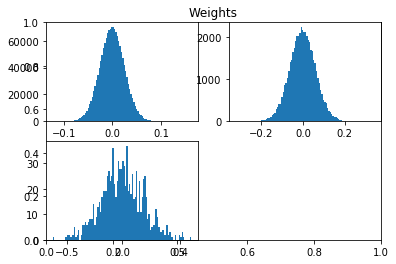

dW 0 Mean -0.0135777135976 SD 0.167115600119
dW 1 Mean -0.00925958524936 SD 0.472624014913
dW 2 Mean 1.42108547152e-17 SD 1.6958403545


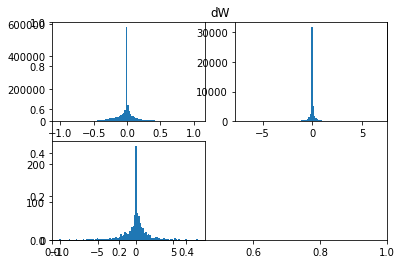

Biases 0 Mean 0.0988532247775 SD 0.04704750865
Biases 1 Mean 0.126853851735 SD 0.155678395796
Biases 2 Mean 0.1 SD 0.402673898347


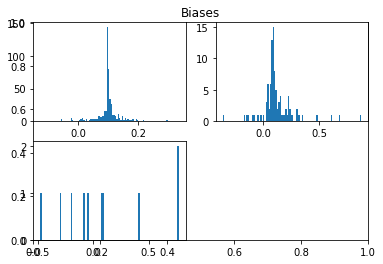

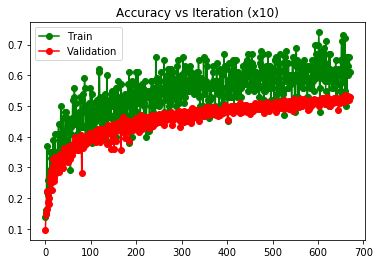

[2 5 5 7 8 6 8 2 5 2 0 1 8 7 9 1 6 2 9 8 2 8 9 2 4 6 8 0 1 9 2 9 9 0 0 1 8
 2 1 4 8 6 6 8 5 2 2 7 9 7 6 2 8 1 2 5 6 2 7 4 8 1 6 6 0 4 0 9 6 0 5 2 8 9
 8 7 6 1 2 5 4 8 2 2 4 5 2 3 7 3 9 2 5 8 8 9 2 0 3 4]
[ 8  8 20  3  7  9 11  7 16 11]
[6 8 7 ..., 5 6 4]
[465 535 668 356 416 389 661 435 617 458]
cost: 39.48929628437852, train accuracy: 0.54, validation accuracy: 0.5304
iterations finished: 6711 alpha: 0.00025418658283290005 reg. lambda: 0.0


[2 6 0 6 0 7 1 7 7 9 7 2 6 6 1 1 8 0 9 1 9 6 8 7 5 8 3 1 7 3 3 1 5 0 1 3 2
 7 9 8 4 7 0 7 2 8 1 5 0 6 8 3 1 5 2 1 5 7 8 7 3 6 7 1 4 1 7 8 9 4 5 7 2 5
 7 3 5 7 9 4 5 2 1 7 0 3 8 8 4 5 6 7 9 5 3 1 2 0 9 8]
[ 8 14  8  9  5 11  8 18 11  8]
[6 8 7 ..., 5 5 4]
[457 624 415 350 280 590 417 897 507 463]
cost: 39.80766422291166, train accuracy: 0.64, validation accuracy: 0.5166
iterations finished: 6721 alpha: 0.00025418658283290005 reg. lambda: 0.0


[4 5 9 9 3 4 6 5 4 6 4 6 5 1 9 5 2 5 7 0 4 8 1 5 5 2 0 2 4 9 5 6 6 5 4 6 5
 1 3 5 3 6 1 3 5 9 3 4 6 6 9 7 

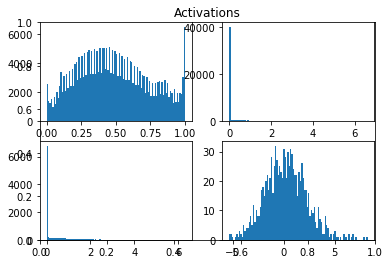

[8 7 6 7 9 3 0 9 7 2 1 6 7 2 2 7 5 7 8 4 3 6 7 5 7 9 1 7 1 6 6 9 6 7 9 6 9
 2 8 4 7 3 5 6 7 6 7 1 2 8 5 7 3 7 1 1 7 6 3 0 8 6 7 1 9 7 9 3 3 8 3 2 3 2
 0 5 2 6 8 5 7 7 7 5 8 4 3 2 6 8 8 7 3 3 0 1 7 0 7 7]
[ 5  8  9 12  3  7 13 25 10  8]
[6 7 7 ..., 5 5 4]
[ 403  417  388  340  351  372  583 1099  561  486]
cost: 39.844805560927156, train accuracy: 0.63, validation accuracy: 0.5094
iterations finished: 6801 alpha: 0.00025418658283290005 reg. lambda: 0.0


Weights 0 Mean -0.00057560548502 SD 0.0250668620131
Weights 1 Mean -0.00245524040931 SD 0.0625631586083
Weights 2 Mean 0.000786497118276 SD 0.1903621404


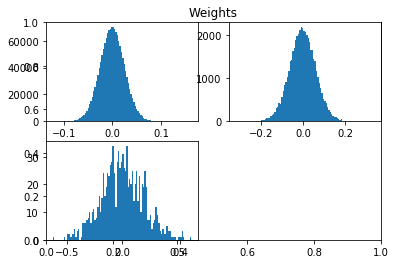

dW 0 Mean -0.00269364369544 SD 0.263303776049
dW 1 Mean 0.000709291427376 SD 0.589236249376
dW 2 Mean 4.26325641456e-17 SD 2.07453583499


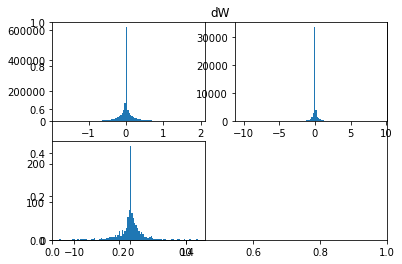

Biases 0 Mean 0.0988402108322 SD 0.0473315379882
Biases 1 Mean 0.127098034323 SD 0.156765620624
Biases 2 Mean 0.1 SD 0.404763939666


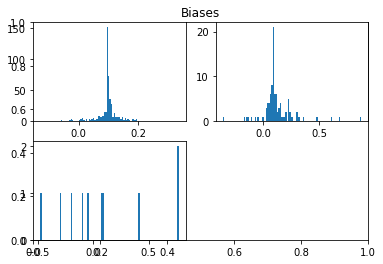

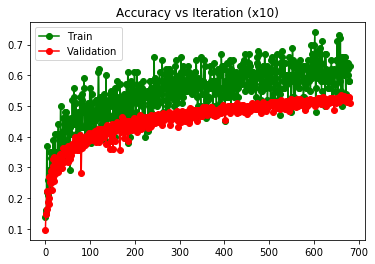

[2 2 8 6 9 1 4 8 2 7 2 2 0 3 0 1 4 0 3 6 6 1 3 6 0 7 5 3 1 8 4 0 2 9 7 8 7
 6 1 7 1 7 3 4 5 0 1 3 1 3 6 5 6 9 0 9 3 2 3 1 0 1 9 9 8 2 9 1 8 0 1 8 4 8
 2 3 1 9 2 6 6 8 3 8 5 0 1 3 4 9 2 7 6 5 6 8 9 8 2 6]
[10 14 12 12  6  5 12  7 12 10]
[6 8 7 ..., 2 3 6]
[481 607 548 533 410 216 700 359 567 579]
cost: 40.04687284578497, train accuracy: 0.63, validation accuracy: 0.52
iterations finished: 6811 alpha: 0.00025418658283290005 reg. lambda: 0.0


[5 1 2 7 6 2 3 9 9 7 7 1 2 7 7 2 1 3 3 6 5 8 1 0 0 2 0 5 4 0 1 0 7 3 8 4 8
 0 6 7 3 3 4 0 8 3 4 0 7 1 5 1 9 4 0 0 6 2 8 9 4 2 3 0 2 7 1 3 0 0 7 5 1 2
 9 7 0 9 5 9 0 7 5 2 9 0 2 7 8 1 5 5 5 7 5 9 9 9 9 5]
[16 10 11  9  6 12  4 14  6 12]
[6 7 7 ..., 5 3 2]
[558 490 549 415 344 542 411 608 431 652]
cost: 39.30242040163544, train accuracy: 0.55, validation accuracy: 0.5198
iterations finished: 6821 alpha: 0.00025418658283290005 reg. lambda: 0.0


[8 5 8 9 7 7 1 2 8 7 1 5 1 1 7 6 0 2 4 1 8 8 6 8 3 2 5 1 8 6 4 2 0 3 9 9 5
 6 8 8 5 5 9 7 5 0 5 8 6 8 2 5 0 

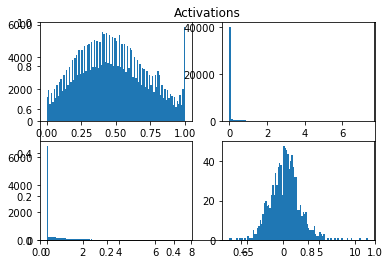

[9 7 4 8 0 8 9 7 0 5 1 5 4 8 0 9 7 1 6 8 8 4 3 4 0 6 0 4 0 1 1 6 0 1 8 2 2
 8 7 7 5 0 8 4 3 7 5 2 0 9 1 6 5 1 5 4 4 6 9 4 0 1 5 5 0 0 4 9 1 6 0 3 7 3
 1 7 4 1 6 4 6 2 8 5 7 2 0 2 0 6 7 1 5 6 0 7 3 8 0 2]
[17 12  7  5 12 10 10 11 10  6]
[6 8 7 ..., 5 6 4]
[454 495 567 276 587 338 514 665 588 516]
cost: 39.98072222954733, train accuracy: 0.62, validation accuracy: 0.5268
iterations finished: 6901 alpha: 0.00025418658283290005 reg. lambda: 0.0


Weights 0 Mean -0.000575374894608 SD 0.0250745748313
Weights 1 Mean -0.00242761769906 SD 0.062607846725
Weights 2 Mean 0.000786497118276 SD 0.190998101381


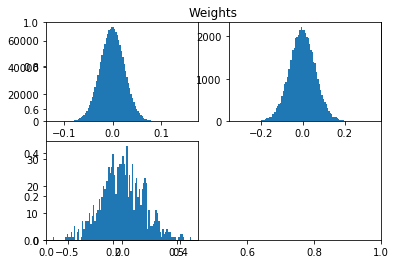

dW 0 Mean 0.00672463935759 SD 0.208156640927
dW 1 Mean 0.0109938428973 SD 0.51781604418
dW 2 Mean -2.84217094304e-17 SD 1.91085784792


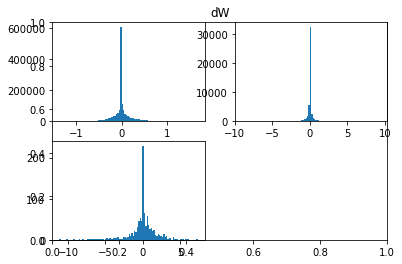

Biases 0 Mean 0.0988480579237 SD 0.0475010970652
Biases 1 Mean 0.127409106706 SD 0.157573722221
Biases 2 Mean 0.1 SD 0.406221275771


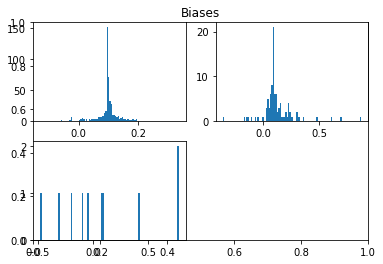

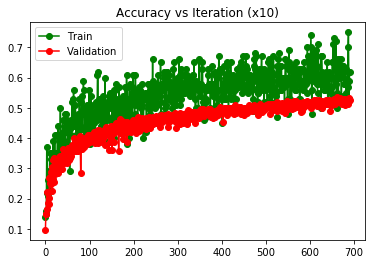

[9 0 3 1 4 3 9 2 0 5 8 9 6 6 7 9 1 9 0 6 1 1 6 2 7 1 9 6 9 5 4 7 2 3 6 7 9
 1 2 8 9 6 8 8 6 6 6 2 9 6 2 4 5 7 2 2 7 1 2 2 9 6 8 7 8 5 3 6 1 4 3 6 9 9
 8 2 4 7 4 4 7 4 9 5 2 8 0 1 4 8 7 3 0 0 6 9 1 4 8 2]
[ 6 10 13  6 10  5 15 10 10 15]
[6 8 7 ..., 5 6 4]
[310 514 507 335 468 382 819 574 485 606]
cost: 39.13895417435927, train accuracy: 0.66, validation accuracy: 0.5158
iterations finished: 6911 alpha: 0.00025418658283290005 reg. lambda: 0.0


[6 6 7 7 1 3 6 1 2 4 4 6 1 7 2 6 6 6 5 2 3 4 9 8 3 6 7 0 9 1 0 1 9 0 0 2 8
 1 2 3 4 7 8 6 3 1 8 0 8 9 5 8 0 1 6 6 8 3 8 8 5 0 9 6 0 5 7 0 2 3 5 9 7 2
 8 0 6 1 6 6 4 2 5 0 1 3 1 8 6 3 6 4 5 7 8 5 8 9 2 7]
[11 11  9  9  6  8 17  9 13  7]
[6 8 7 ..., 5 6 6]
[637 434 350 378 299 452 880 411 620 539]
cost: 39.08716146273923, train accuracy: 0.53, validation accuracy: 0.5168
iterations finished: 6921 alpha: 0.00025418658283290005 reg. lambda: 0.0


[7 5 4 6 0 9 1 8 1 3 4 5 5 6 2 9 1 9 1 2 8 8 7 1 5 3 5 5 7 0 4 1 7 4 1 0 1
 3 5 4 7 8 7 1 1 6 0 9 2 0 3 3 

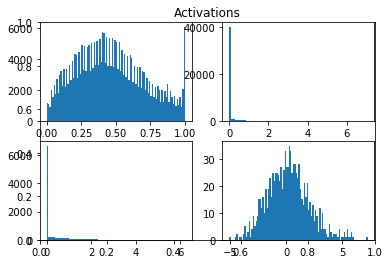

[6 9 0 7 3 8 9 7 2 6 2 3 3 0 9 5 5 4 1 7 0 2 5 0 4 3 9 4 8 7 3 6 0 6 6 0 0
 5 1 6 1 6 1 7 1 9 0 3 6 8 3 4 1 7 1 2 5 0 3 0 6 9 0 7 1 9 1 4 5 8 9 0 2 3
 7 4 2 1 2 7 4 0 3 4 4 9 6 8 7 8 8 2 1 8 6 6 4 6 2 1]
[13 12  9 10 10  6 13 10  8  9]
[6 8 7 ..., 5 5 4]
[453 568 481 537 403 457 637 483 596 385]
cost: 37.934636413063146, train accuracy: 0.61, validation accuracy: 0.5322
iterations finished: 7001 alpha: 0.00022876792454961005 reg. lambda: 0.0


Weights 0 Mean -0.000571343522287 SD 0.0250825321462
Weights 1 Mean -0.00239865904136 SD 0.0626530028582
Weights 2 Mean 0.000786497118276 SD 0.191624770043


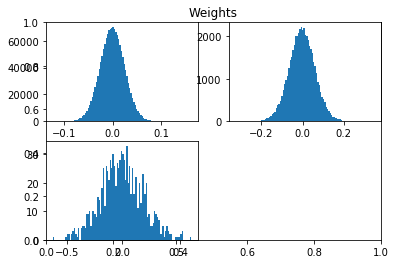

dW 0 Mean -0.000900139153694 SD 0.211189813325
dW 1 Mean -0.01322134811 SD 0.481336365761
dW 2 Mean -2.84217094304e-17 SD 1.68550959328


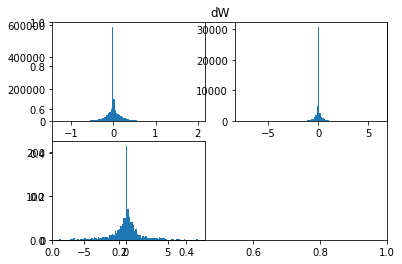

Biases 0 Mean 0.098857755806 SD 0.0477436313138
Biases 1 Mean 0.127733891408 SD 0.158265397997
Biases 2 Mean 0.1 SD 0.407604955976


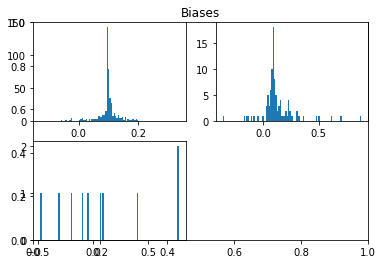

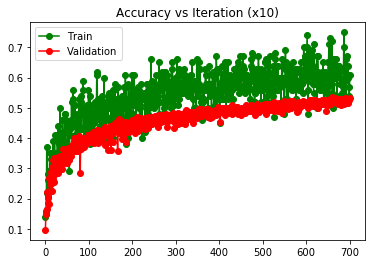

[3 4 7 4 9 7 4 5 7 3 1 1 4 6 3 4 6 9 9 7 1 2 3 2 0 1 7 1 4 0 8 1 6 1 0 4 8
 0 7 2 5 0 1 9 7 3 7 9 9 8 9 1 8 8 4 7 1 7 9 1 8 8 7 5 3 2 4 9 9 5 6 9 2 2
 8 4 2 9 8 9 5 8 4 1 0 5 8 8 7 3 7 9 5 0 6 7 9 7 7 7]
[ 7 12  7  7 11  7  5 17 12 15]
[6 8 7 ..., 5 3 4]
[484 599 380 461 531 446 524 472 567 536]
cost: 41.79559106088757, train accuracy: 0.7, validation accuracy: 0.5298
iterations finished: 7011 alpha: 0.00022876792454961005 reg. lambda: 0.0


[0 9 5 3 8 1 9 3 0 3 7 9 0 0 5 2 8 0 4 0 1 6 9 2 7 4 4 1 1 6 8 6 3 7 6 8 7
 4 0 1 8 0 1 1 6 7 6 8 6 0 9 3 0 6 5 3 6 6 1 7 6 3 0 4 4 3 7 7 4 3 0 2 1 9
 5 1 1 8 3 9 3 1 0 9 8 6 0 8 6 6 1 3 4 1 6 4 0 6 8 0]
[16 14  3 12  9  4 16  8 10  8]
[6 8 7 ..., 5 6 4]
[517 561 413 599 394 267 692 500 580 477]
cost: 41.330333378827156, train accuracy: 0.6, validation accuracy: 0.534
iterations finished: 7021 alpha: 0.00022876792454961005 reg. lambda: 0.0


[1 8 9 9 6 7 4 8 5 0 4 3 9 0 4 9 3 2 5 4 0 9 2 0 5 0 2 1 9 7 6 1 2 7 9 7 3
 5 4 7 5 2 5 8 7 7 5 1 4 0 6 4 4 

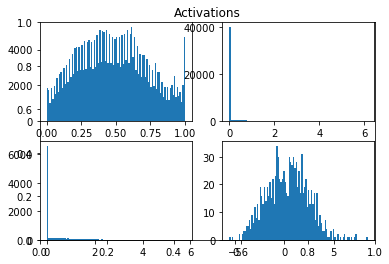

[9 3 0 8 6 6 9 6 9 3 4 1 3 7 6 2 1 9 7 9 3 3 3 8 0 4 1 3 4 1 0 0 4 1 1 2 8
 0 0 4 8 1 7 9 8 3 2 4 6 4 8 3 0 0 9 1 2 2 7 8 7 4 3 1 6 0 0 8 4 2 9 9 0 1
 9 9 7 1 6 3 2 1 0 6 6 4 1 3 6 8 4 0 1 7 3 3 3 3 2 5]
[13 14  8 16 11  1 10  7  9 11]
[6 8 7 ..., 5 6 4]
[536 542 378 461 549 412 684 497 499 442]
cost: 39.80858189752691, train accuracy: 0.55, validation accuracy: 0.5362
iterations finished: 7101 alpha: 0.00022876792454961005 reg. lambda: 0.0


Weights 0 Mean -0.000570459220779 SD 0.02508911283
Weights 1 Mean -0.00238222588603 SD 0.0626915225292
Weights 2 Mean 0.000786497118276 SD 0.192174373875


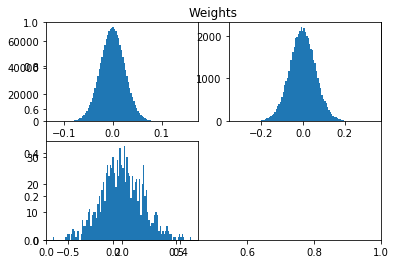

dW 0 Mean 0.0108304093172 SD 0.214951219853
dW 1 Mean -0.00247937216406 SD 0.556201933281
dW 2 Mean 8.52651282912e-17 SD 2.08684106256


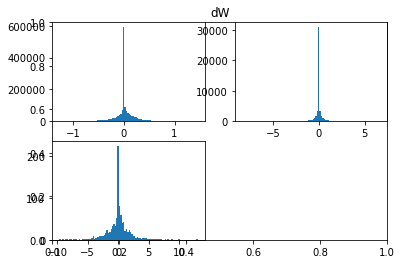

Biases 0 Mean 0.0988618443889 SD 0.0479211328834
Biases 1 Mean 0.127930073453 SD 0.15903991259
Biases 2 Mean 0.1 SD 0.407844492931


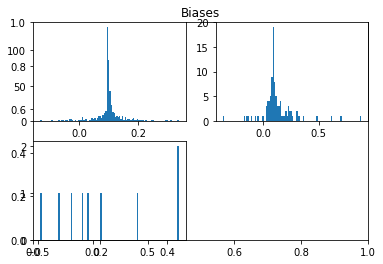

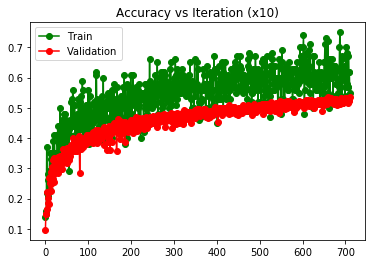

[9 9 5 9 4 7 0 1 8 5 6 8 0 7 9 7 3 0 1 7 0 8 3 2 0 3 1 6 1 7 7 3 3 3 5 2 7
 8 6 3 9 6 1 7 1 5 4 1 7 5 5 8 2 1 8 2 7 7 1 6 5 8 6 6 9 7 2 9 7 7 7 1 4 7
 7 9 7 7 3 3 7 7 4 6 4 4 1 4 8 8 5 9 5 1 7 3 7 1 3 5]
[ 5 13  5 11  7 10  8 23  9  9]
[6 8 7 ..., 5 3 4]
[379 647 499 591 427 454 435 673 419 476]
cost: 41.4226649007533, train accuracy: 0.6, validation accuracy: 0.5264
iterations finished: 7111 alpha: 0.00022876792454961005 reg. lambda: 0.0


[3 8 1 5 4 3 6 6 7 6 2 7 9 7 3 1 4 5 6 4 7 6 7 0 2 6 5 9 7 5 7 9 0 5 3 9 8
 9 7 9 9 8 4 4 5 6 4 7 5 7 1 6 2 4 5 3 2 3 8 5 8 7 9 9 7 6 7 5 7 0 6 9 8 7
 9 0 3 6 0 5 4 9 6 8 7 3 5 4 5 1 4 8 3 0 9 9 1 3 5 7]
[ 6  5  4 10 10 14 12 17  8 14]
[6 8 7 ..., 5 6 4]
[450 452 437 335 369 464 714 686 460 633]
cost: 39.57851047262867, train accuracy: 0.56, validation accuracy: 0.527
iterations finished: 7121 alpha: 0.00022876792454961005 reg. lambda: 0.0


[9 2 6 7 8 7 5 2 3 5 2 4 4 4 3 9 8 1 5 9 8 3 7 8 2 6 6 9 8 8 0 6 6 3 5 1 8
 9 8 8 4 2 6 9 4 4 0 1 0 7 0 7 6 8

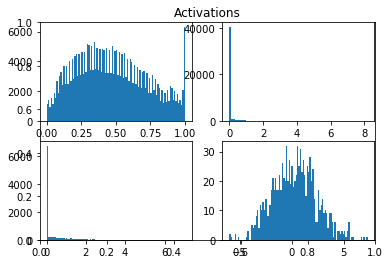

[4 0 0 4 4 9 3 3 9 0 6 3 8 0 5 7 8 7 2 5 3 3 2 1 9 6 9 2 1 7 5 0 3 6 3 8 3
 9 1 3 1 6 7 1 2 6 2 1 2 6 2 0 6 3 8 5 7 4 2 8 1 8 3 9 0 5 1 7 9 8 6 3 0 3
 3 1 8 3 3 3 6 2 2 2 4 3 8 3 2 1 4 7 0 8 0 2 2 1 6 1]
[10 12 14 19  6  5 10  7 10  7]
[6 8 7 ..., 5 6 4]
[468 558 509 541 309 437 593 448 601 536]
cost: 39.33593650878705, train accuracy: 0.66, validation accuracy: 0.5284
iterations finished: 7201 alpha: 0.00022876792454961005 reg. lambda: 0.0


Weights 0 Mean -0.000573525098522 SD 0.0250954719735
Weights 1 Mean -0.00240924862386 SD 0.0627234652428
Weights 2 Mean 0.000786497118276 SD 0.19258147607


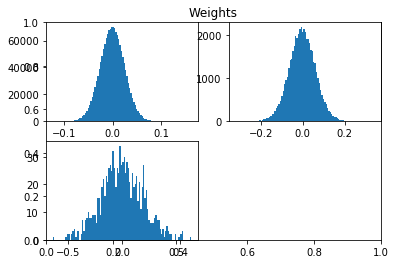

dW 0 Mean -0.014368780861 SD 0.201525995103
dW 1 Mean -0.0146675042356 SD 0.471462748593
dW 2 Mean -1.7763568394e-17 SD 1.70034115008


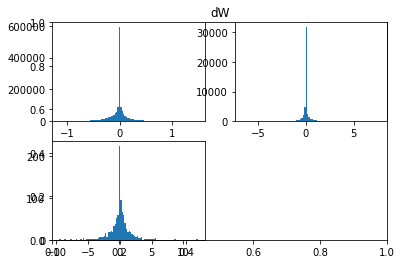

Biases 0 Mean 0.0988589454376 SD 0.0480334652472
Biases 1 Mean 0.127977942515 SD 0.159181086263
Biases 2 Mean 0.1 SD 0.408151786282


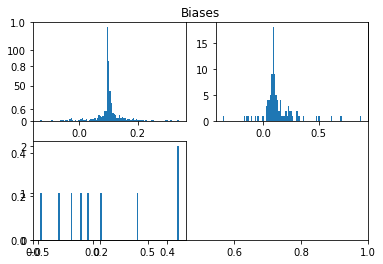

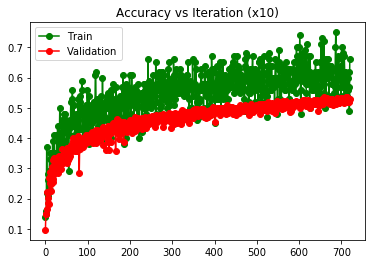

[8 6 4 6 3 0 8 1 4 4 6 3 9 4 8 3 6 4 8 4 5 5 3 8 0 4 3 3 9 1 3 1 7 1 6 8 6
 2 8 1 6 8 9 4 4 5 3 7 3 6 0 6 9 7 4 0 3 1 6 4 0 0 9 7 9 7 1 9 9 8 4 5 7 4
 6 3 7 1 6 8 2 6 1 1 3 3 6 5 6 9 3 5 8 8 9 6 0 3 0 1]
[ 8 11  2 15 13  6 16  7 12 10]
[6 8 7 ..., 5 6 4]
[453 524 310 545 414 470 749 388 617 530]
cost: 40.88468273820538, train accuracy: 0.63, validation accuracy: 0.5252
iterations finished: 7211 alpha: 0.00022876792454961005 reg. lambda: 0.0


[7 9 4 5 5 9 8 3 7 1 4 5 4 7 4 2 0 5 0 8 1 1 5 9 9 1 0 0 1 6 9 6 6 0 3 8 8
 6 0 1 0 8 0 0 6 1 5 1 0 0 7 6 8 6 1 5 6 3 1 5 8 5 7 6 6 3 1 8 4 8 8 2 1 4
 2 2 7 1 5 9 6 5 1 7 8 5 1 9 4 5 8 3 6 4 0 3 7 6 5 5]
[12 15  4  6  8 15 13  8 12  7]
[6 7 7 ..., 5 6 4]
[490 524 391 462 442 544 483 591 518 555]
cost: 40.100253956756816, train accuracy: 0.59, validation accuracy: 0.5302
iterations finished: 7221 alpha: 0.00022876792454961005 reg. lambda: 0.0


[5 8 3 5 8 1 3 4 8 6 0 6 0 7 9 4 4 9 4 6 0 1 9 3 8 6 9 0 4 7 4 5 8 4 7 6 2
 0 8 4 8 2 0 8 0 0 4 3 0 2 8 0

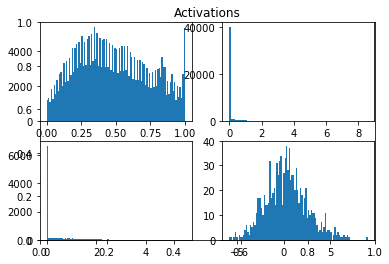

[2 5 0 3 3 8 3 7 1 7 1 1 0 4 9 7 8 8 6 8 1 9 2 2 1 6 3 4 1 1 0 6 0 8 3 0 5
 8 0 7 8 7 6 3 2 9 8 0 8 0 8 0 7 2 6 6 6 2 4 0 3 1 6 1 3 6 3 7 1 3 3 9 7 7
 4 8 8 5 8 6 7 7 5 8 4 5 6 2 9 9 0 4 3 3 3 9 1 6 6 0]
[12 11  7 14  6  5 13 11 14  7]
[6 8 7 ..., 5 6 4]
[545 501 480 485 461 271 761 450 558 488]
cost: 42.53692365379824, train accuracy: 0.69, validation accuracy: 0.534
iterations finished: 7301 alpha: 0.00022876792454961005 reg. lambda: 0.0


Weights 0 Mean -0.000571178281178 SD 0.025102658561
Weights 1 Mean -0.0024073469152 SD 0.0627698407168
Weights 2 Mean 0.000786497118276 SD 0.193272969493


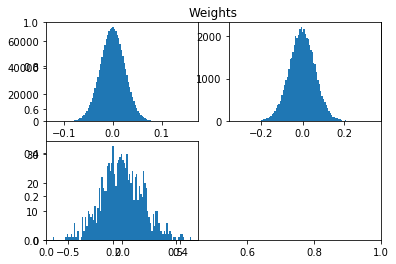

dW 0 Mean 0.011233885639 SD 0.186775833505
dW 1 Mean -0.0203303216221 SD 0.459953007777
dW 2 Mean -4.26325641456e-17 SD 1.73584151337


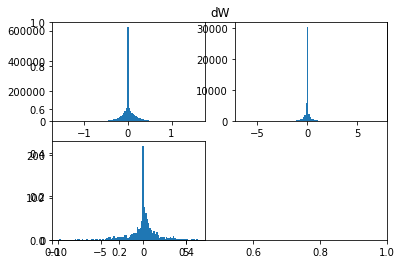

Biases 0 Mean 0.0988777662919 SD 0.0482767421235
Biases 1 Mean 0.128159126758 SD 0.159902619045
Biases 2 Mean 0.1 SD 0.408535008917


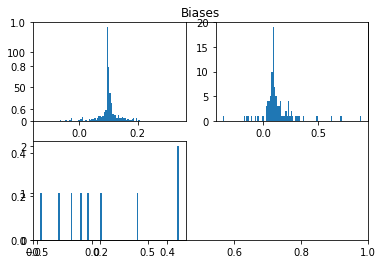

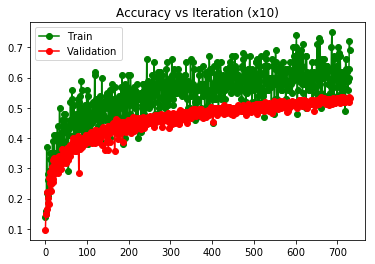

[4 2 2 3 0 1 0 8 5 2 5 8 7 8 4 3 1 7 0 2 7 7 6 0 7 0 1 8 9 8 5 9 1 3 9 7 6
 2 6 6 4 4 3 3 6 2 1 1 9 8 7 5 4 7 8 7 4 6 7 0 6 7 7 8 7 3 6 0 8 8 5 5 7 0
 0 0 1 3 4 2 7 3 6 1 3 0 4 6 0 9 4 0 3 0 2 7 7 7 8 0]
[15  8  8 10  9  6 10 18 11  5]
[6 8 7 ..., 5 5 4]
[498 511 392 484 575 517 441 710 484 388]
cost: 40.68934446381496, train accuracy: 0.65, validation accuracy: 0.5318
iterations finished: 7311 alpha: 0.00022876792454961005 reg. lambda: 0.0


[5 6 9 3 8 6 1 3 8 7 7 7 9 6 1 5 2 7 8 1 2 5 3 4 6 3 6 0 5 9 6 2 7 1 6 7 6
 1 4 2 4 7 8 9 1 3 1 4 9 6 8 6 0 2 8 5 9 4 7 6 7 7 1 1 0 4 3 7 5 6 8 6 0 0
 5 2 6 7 6 2 4 7 4 6 9 2 8 9 9 4 0 5 4 5 0 6 4 6 4 9]
[ 7  9  8  6 12  9 18 13  8 10]
[6 8 7 ..., 5 6 4]
[405 480 485 414 553 339 675 596 591 462]
cost: 39.25726810265892, train accuracy: 0.64, validation accuracy: 0.5324
iterations finished: 7321 alpha: 0.00022876792454961005 reg. lambda: 0.0


[7 4 3 6 4 4 5 9 8 1 5 6 8 2 0 9 5 5 3 8 3 6 6 3 4 3 5 0 4 0 2 9 9 8 9 2 2
 1 3 7 8 2 0 0 1 0 4 0 8 4 7 0 

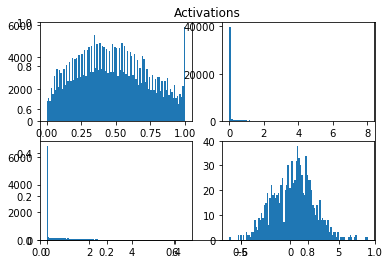

[3 1 8 9 8 8 3 4 9 1 0 5 9 2 8 2 0 9 7 3 5 6 2 4 3 1 0 7 6 6 3 1 0 3 8 1 8
 3 0 3 9 6 4 1 3 4 6 9 0 4 3 3 5 7 1 2 2 4 7 1 7 4 0 3 0 9 9 5 5 5 5 9 7 6
 9 0 1 0 6 5 9 8 2 4 5 9 7 9 5 5 3 8 4 2 5 2 4 3 2 2]
[10  9 10 14 10 12  7  7  8 13]
[6 8 7 ..., 5 3 4]
[319 533 500 501 399 525 461 654 614 494]
cost: 39.29334080103613, train accuracy: 0.53, validation accuracy: 0.5324
iterations finished: 7401 alpha: 0.00022876792454961005 reg. lambda: 0.0


Weights 0 Mean -0.00055167668093 SD 0.0251097550602
Weights 1 Mean -0.00239223774857 SD 0.0628082003131
Weights 2 Mean 0.000786497118276 SD 0.193786358236


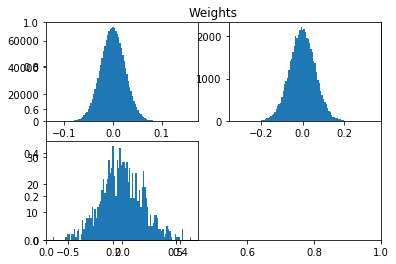

dW 0 Mean -0.0125787181572 SD 0.203578674409
dW 1 Mean 0.00116976450744 SD 0.528617705996
dW 2 Mean -1.42108547152e-17 SD 1.8796449059


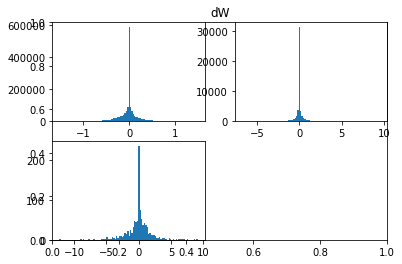

Biases 0 Mean 0.098911414662 SD 0.0484398450943
Biases 1 Mean 0.12843099712 SD 0.160191167036
Biases 2 Mean 0.1 SD 0.408058275332


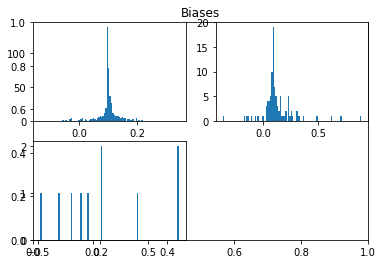

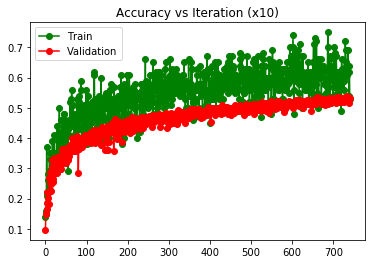

[8 1 4 8 5 4 8 8 1 6 1 0 0 2 4 1 9 0 2 7 7 9 8 8 0 2 6 1 6 7 0 7 7 8 6 9 6
 6 5 4 0 9 8 0 8 7 8 1 9 7 0 7 9 3 0 8 8 4 9 8 9 4 9 6 2 1 9 9 2 0 9 9 5 7
 3 0 1 9 4 9 9 3 9 6 9 2 6 4 4 5 1 6 3 6 8 3 6 4 8 6]
[11  9  6  5 10  4 13  9 15 18]
[6 8 7 ..., 5 6 4]
[457 551 349 328 490 352 574 661 538 700]
cost: 41.62217635330513, train accuracy: 0.65, validation accuracy: 0.5248
iterations finished: 7411 alpha: 0.00022876792454961005 reg. lambda: 0.0


[7 0 9 9 6 8 1 9 3 8 2 5 3 3 7 5 3 2 0 4 5 4 5 6 0 8 3 4 5 8 0 1 0 5 8 0 5
 9 9 2 3 0 6 1 2 0 2 2 1 3 4 3 9 3 9 1 3 8 7 8 7 7 8 5 7 9 5 5 0 0 3 9 6 0
 7 9 8 7 8 3 0 0 8 1 5 1 3 8 8 7 9 3 8 6 6 3 7 3 4 6]
[13  7  6 16  5 11  7 10 14 11]
[6 8 7 ..., 5 3 4]
[457 427 425 567 426 404 556 555 538 645]
cost: 40.61231494581731, train accuracy: 0.58, validation accuracy: 0.5332
iterations finished: 7421 alpha: 0.00022876792454961005 reg. lambda: 0.0


[0 3 5 1 1 2 8 1 4 1 1 5 5 4 3 6 1 1 9 9 1 1 1 7 9 1 4 6 5 9 8 5 3 2 5 5 5
 5 7 6 1 5 6 6 9 3 1 6 8 4 0 0 

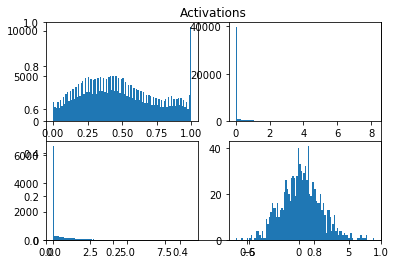

[2 2 1 0 4 8 7 1 3 0 0 0 8 2 0 1 6 0 3 3 1 3 9 7 5 4 4 6 6 4 9 5 2 1 0 4 3
 3 1 3 0 6 3 0 6 1 4 1 7 4 9 5 7 8 4 6 0 6 1 8 2 2 1 8 8 2 3 1 7 3 4 3 2 6
 1 9 0 0 8 8 3 3 6 1 4 3 6 5 5 5 9 2 8 6 7 8 0 0 8 1]
[14 14  9 14 10  6 11  6 11  5]
[6 8 7 ..., 2 3 4]
[537 527 556 488 446 319 508 627 538 454]
cost: 38.43467040672456, train accuracy: 0.63, validation accuracy: 0.5344
iterations finished: 7501 alpha: 0.00020589113209464906 reg. lambda: 0.0


Weights 0 Mean -0.000564446591701 SD 0.0251164220001
Weights 1 Mean -0.00238567691749 SD 0.0628479473471
Weights 2 Mean 0.000786497118276 SD 0.194334314679


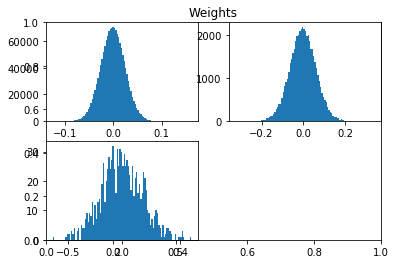

dW 0 Mean 0.024163948716 SD 0.261807024401
dW 1 Mean -0.00263598894467 SD 0.568968507948
dW 2 Mean 0.0 SD 1.84680492131


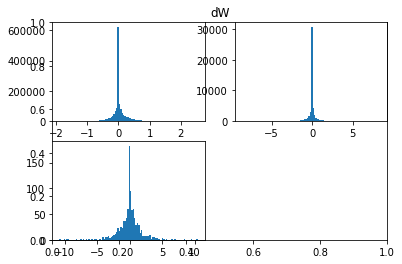

Biases 0 Mean 0.0988920202046 SD 0.0485972815222
Biases 1 Mean 0.128639850113 SD 0.160638006289
Biases 2 Mean 0.1 SD 0.40875439927


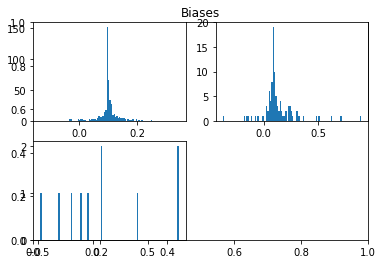

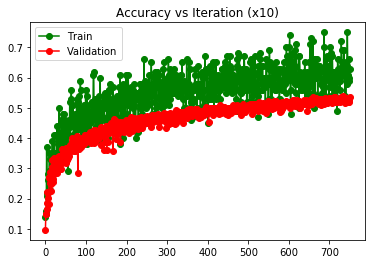

[5 3 8 9 7 8 2 4 9 8 2 4 7 3 2 9 5 2 7 0 1 9 5 9 5 2 0 9 2 6 2 4 2 8 8 8 6
 9 1 7 0 0 5 5 8 7 0 8 7 7 5 9 2 6 5 3 9 8 7 4 5 9 0 8 7 4 4 1 9 1 1 1 8 2
 8 6 1 8 1 9 1 9 9 6 5 6 6 9 2 8 9 5 9 6 8 9 9 1 4 1]
[ 6 11 11  3  7 11  8  9 15 19]
[6 8 7 ..., 5 5 4]
[384 483 453 256 378 569 695 522 639 621]
cost: 39.51414351377719, train accuracy: 0.67, validation accuracy: 0.5278
iterations finished: 7511 alpha: 0.00020589113209464906 reg. lambda: 0.0


[8 8 2 6 6 8 3 2 1 3 3 6 0 1 0 7 3 7 7 6 9 2 2 0 6 9 7 7 2 9 2 1 7 5 6 9 5
 0 6 7 6 0 9 3 3 4 7 5 9 3 3 0 9 5 4 3 0 5 7 1 6 7 0 6 6 0 8 7 5 2 0 4 3 6
 8 3 4 4 2 6 5 6 4 2 8 7 3 2 6 6 7 8 8 6 2 9 4 1 7 3]
[10  5 11 13  7  7 17 14  8  8]
[6 8 7 ..., 5 0 4]
[605 413 363 413 480 339 834 539 580 434]
cost: 41.850589269377004, train accuracy: 0.64, validation accuracy: 0.5268
iterations finished: 7521 alpha: 0.00020589113209464906 reg. lambda: 0.0


[0 4 3 4 8 6 8 4 0 0 7 6 6 8 0 9 2 9 6 1 0 6 1 2 5 4 4 3 4 1 8 1 0 1 1 1 4
 1 4 0 6 6 1 3 0 7 7 7 5 4 7 0

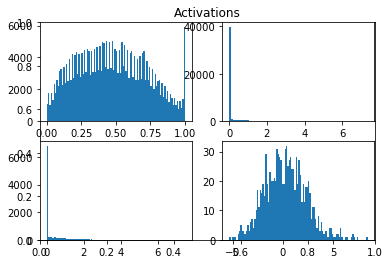

[0 6 7 4 6 0 3 7 3 6 9 5 0 3 0 5 3 1 7 6 4 4 2 4 9 9 6 9 5 6 2 3 6 1 2 1 0
 5 7 1 9 5 5 5 7 8 9 0 0 2 3 6 0 3 0 2 9 2 3 6 0 2 7 6 8 9 4 6 2 5 8 9 4 9
 4 5 6 6 6 3 6 6 8 1 0 1 7 9 1 4 9 2 0 0 7 0 7 6 5 5]
[14  7  9  9  8 11 17  9  4 12]
[6 1 7 ..., 5 6 4]
[607 540 507 341 430 429 643 520 447 536]
cost: 39.3116275174409, train accuracy: 0.66, validation accuracy: 0.534
iterations finished: 7601 alpha: 0.00020589113209464906 reg. lambda: 0.0


Weights 0 Mean -0.00056063463253 SD 0.0251226256184
Weights 1 Mean -0.0023958702802 SD 0.062887529525
Weights 2 Mean 0.000786497118276 SD 0.194915163756


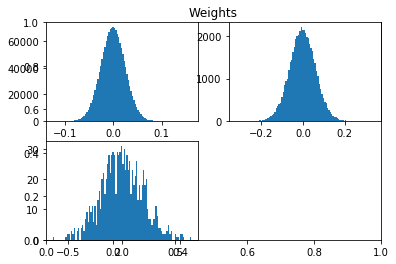

dW 0 Mean -0.00734386338494 SD 0.223286105525
dW 1 Mean 0.000523420735113 SD 0.553765212401
dW 2 Mean -5.68434188608e-17 SD 1.95195905845


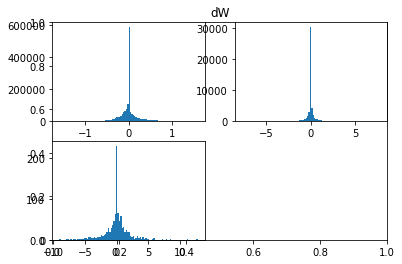

Biases 0 Mean 0.0989080817657 SD 0.0487458440064
Biases 1 Mean 0.128758775106 SD 0.161159228862
Biases 2 Mean 0.1 SD 0.40872669604


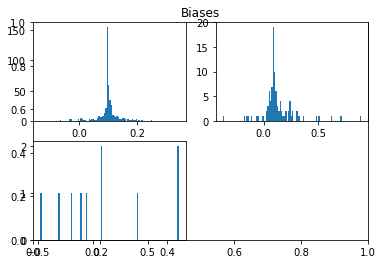

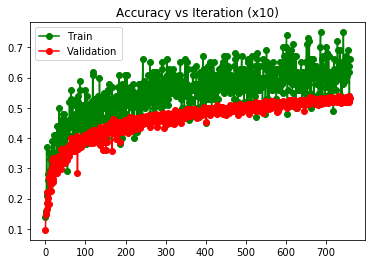

[6 6 6 4 0 3 0 1 0 3 6 9 4 1 0 8 6 7 1 2 3 6 7 7 7 2 5 5 6 9 6 7 9 2 4 4 0
 1 4 5 0 4 4 8 4 2 8 0 6 9 2 9 5 6 9 0 7 3 0 0 6 9 1 1 6 6 8 0 7 8 3 1 9 4
 0 3 4 6 1 1 9 9 9 4 4 9 9 0 8 6 7 3 4 6 6 4 4 4 0 4]
[14  9  5  7 17  4 17  8  6 13]
[6 8 7 ..., 5 6 4]
[619 462 346 324 624 387 837 464 482 455]
cost: 40.58645379677481, train accuracy: 0.61, validation accuracy: 0.5246
iterations finished: 7611 alpha: 0.00020589113209464906 reg. lambda: 0.0


[5 7 5 3 9 7 4 6 1 5 1 0 8 9 9 3 2 7 0 9 8 0 1 6 6 6 9 4 4 6 3 4 8 0 3 3 3
 7 1 3 5 0 1 9 7 9 7 2 1 9 6 3 4 9 9 4 4 9 4 8 3 8 1 2 7 2 6 7 0 9 2 6 5 4
 0 3 7 9 5 6 5 4 0 5 4 3 7 4 5 2 7 2 7 3 2 2 1 6 1 5]
[ 8  9  9 12 12 10 10 12  5 13]
[6 8 7 ..., 5 5 4]
[430 455 453 448 413 539 606 419 596 641]
cost: 38.976334420568236, train accuracy: 0.62, validation accuracy: 0.5278
iterations finished: 7621 alpha: 0.00020589113209464906 reg. lambda: 0.0


[6 0 8 4 3 1 6 3 1 2 6 3 0 3 6 9 2 8 0 8 7 1 9 2 7 2 7 0 2 3 6 6 9 0 3 9 7
 6 9 6 3 6 9 2 2 9 7 4 4 8 1 8

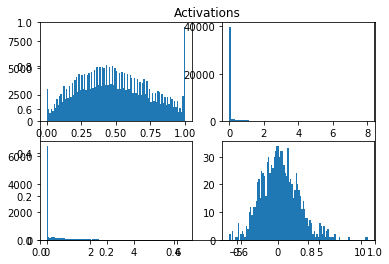

[8 1 6 9 0 2 0 1 5 9 4 2 6 8 5 2 1 4 9 0 8 7 2 9 0 4 3 0 3 2 2 3 9 2 8 8 6
 4 2 0 0 9 9 6 0 4 8 9 0 4 4 3 3 0 5 2 0 0 1 1 3 6 0 9 3 1 5 5 6 0 0 6 6 4
 7 7 1 9 7 3 1 6 7 4 9 0 8 0 7 1 6 6 5 9 9 9 7 5 2 0]
[18  9 10  8  9  7 11  7  7 14]
[6 8 7 ..., 5 6 4]
[603 470 538 255 404 375 748 428 457 722]
cost: 43.45955130127389, train accuracy: 0.74, validation accuracy: 0.5204
iterations finished: 7701 alpha: 0.00020589113209464906 reg. lambda: 0.0


Weights 0 Mean -0.000552247768642 SD 0.0251291259722
Weights 1 Mean -0.0023982219664 SD 0.0629279352769
Weights 2 Mean 0.000786497118276 SD 0.195498860165


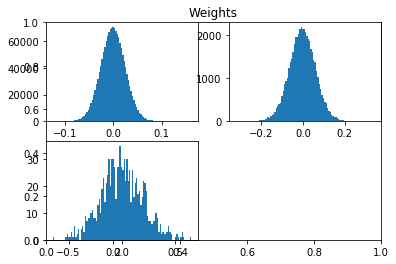

dW 0 Mean -0.000904681911051 SD 0.241098809526
dW 1 Mean -0.0180697225314 SD 0.555258554152
dW 2 Mean -1.42108547152e-17 SD 2.10108969936


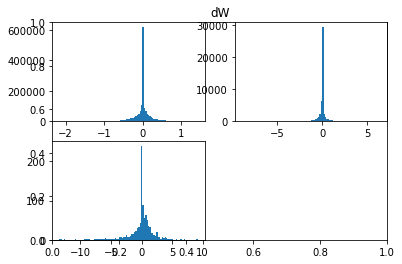

Biases 0 Mean 0.0989129221041 SD 0.0488773975318
Biases 1 Mean 0.128855928822 SD 0.161720642825
Biases 2 Mean 0.1 SD 0.409925087826


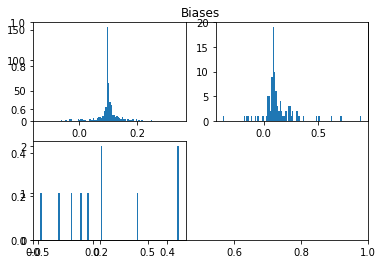

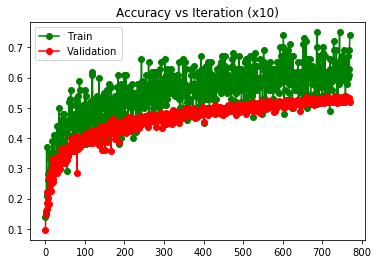

[0 2 9 2 4 5 1 9 2 6 9 2 2 4 6 7 1 5 6 9 2 5 1 3 5 9 2 6 5 2 5 1 7 5 3 9 9
 4 9 2 9 1 6 9 2 5 6 0 7 5 4 1 3 6 6 6 4 2 0 6 8 2 8 2 5 9 9 0 4 4 7 2 6 2
 6 6 9 6 7 6 0 6 4 7 2 5 7 6 1 1 7 5 7 2 0 9 1 3 0 2]
[ 7  9 18  4  8 12 17  9  2 14]
[6 8 7 ..., 5 6 4]
[488 438 640 328 443 458 658 568 432 547]
cost: 42.17162182138151, train accuracy: 0.67, validation accuracy: 0.5304
iterations finished: 7711 alpha: 0.00020589113209464906 reg. lambda: 0.0


[8 1 0 2 7 1 6 0 5 5 0 5 2 0 0 0 0 9 8 2 0 4 6 4 2 3 3 6 1 6 6 8 5 7 4 1 9
 7 8 6 0 1 0 8 8 7 4 7 3 1 4 6 4 8 5 1 2 5 1 7 7 8 0 8 5 2 8 4 0 1 2 7 2 5
 7 9 6 1 8 3 8 0 7 4 1 1 5 9 0 0 1 4 6 0 1 9 0 1 4 1]
[17 16  8  4 10  9  9 10 12  5]
[6 8 7 ..., 5 6 4]
[594 701 456 363 543 357 615 423 513 435]
cost: 43.71262981974075, train accuracy: 0.5, validation accuracy: 0.5322
iterations finished: 7721 alpha: 0.00020589113209464906 reg. lambda: 0.0


[7 6 0 6 6 1 8 6 2 8 4 8 0 4 9 6 1 9 4 2 6 6 1 2 4 1 1 0 8 1 0 3 8 1 8 6 3
 6 5 7 7 5 4 9 2 3 3 6 7 9 3 8 3

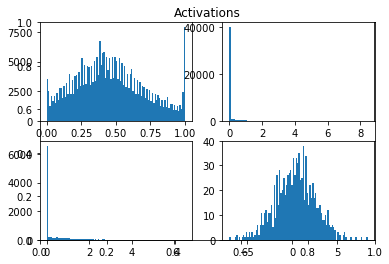

[1 1 3 4 0 7 6 4 1 6 2 8 2 7 4 3 9 3 5 1 2 4 3 6 0 7 7 9 7 8 3 8 1 1 9 0 3
 4 3 0 5 7 1 4 6 8 6 3 4 9 9 3 1 8 7 4 3 7 9 5 1 0 9 0 7 4 1 3 3 7 4 2 1 9
 4 3 3 6 1 7 1 1 6 9 8 1 9 4 0 1 5 1 3 1 9 0 0 8 2 1]
[ 9 19  5 15 12  4  7 11  7 11]
[6 1 7 ..., 5 6 4]
[497 750 245 414 521 291 918 462 467 435]
cost: 40.2534224272384, train accuracy: 0.66, validation accuracy: 0.5198
iterations finished: 7801 alpha: 0.00020589113209464906 reg. lambda: 0.0


Weights 0 Mean -0.000558857676723 SD 0.02513509207
Weights 1 Mean -0.00240172617244 SD 0.0629653336435
Weights 2 Mean 0.000786497118276 SD 0.196033450088


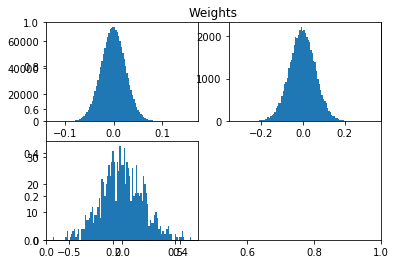

dW 0 Mean -0.0102583313383 SD 0.308284422623
dW 1 Mean 0.0155596524094 SD 0.748201755992
dW 2 Mean 5.68434188608e-17 SD 2.64506024347


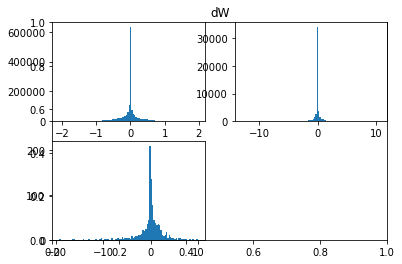

Biases 0 Mean 0.0989294107412 SD 0.0489580525935
Biases 1 Mean 0.128964267447 SD 0.16226956704
Biases 2 Mean 0.1 SD 0.410684181548


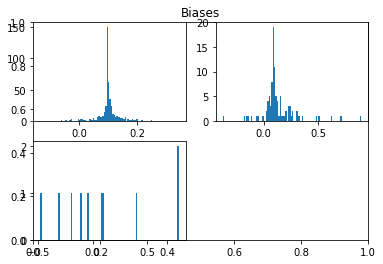

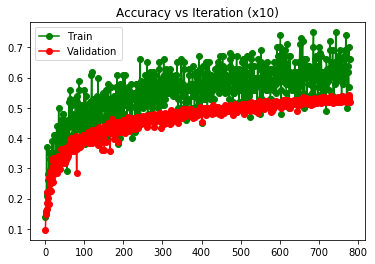

[5 8 8 6 0 1 8 7 5 1 6 8 1 0 0 5 3 0 0 6 9 2 7 8 0 1 3 5 1 7 8 1 8 0 7 5 1
 6 0 6 3 4 1 2 1 8 7 3 2 8 8 0 6 2 6 3 6 0 1 4 7 2 7 5 9 8 2 8 2 1 6 5 0 4
 0 3 6 7 6 6 8 8 5 4 4 1 1 7 4 4 8 7 0 1 6 5 5 6 4 7]
[13 14  7  6  8 10 14 11 15  2]
[6 8 7 ..., 5 6 4]
[566 535 326 396 508 390 759 476 596 448]
cost: 41.47518627564239, train accuracy: 0.64, validation accuracy: 0.5368
iterations finished: 7811 alpha: 0.00020589113209464906 reg. lambda: 0.0


[1 1 2 2 9 7 2 4 3 7 9 1 6 3 2 7 5 5 9 9 2 8 9 8 3 1 4 3 1 2 1 7 7 5 9 0 4
 7 9 5 9 1 0 9 8 0 5 5 6 0 8 8 9 2 3 2 2 2 2 2 0 0 3 5 0 9 9 9 9 1 5 6 4 0
 3 3 7 9 5 3 7 6 9 7 7 5 9 3 1 1 0 0 2 3 7 3 2 7 7 3]
[10 10 14 13  4 10  4 13  5 17]
[6 8 7 ..., 5 5 4]
[468 454 526 482 399 514 491 573 438 655]
cost: 41.38456395762588, train accuracy: 0.64, validation accuracy: 0.5316
iterations finished: 7821 alpha: 0.00020589113209464906 reg. lambda: 0.0


[8 5 1 6 8 1 8 7 6 7 3 9 7 0 5 9 3 7 6 7 1 0 9 8 7 0 9 5 7 5 5 1 6 2 1 1 1
 2 6 1 5 3 7 9 6 1 4 6 9 4 2 4 

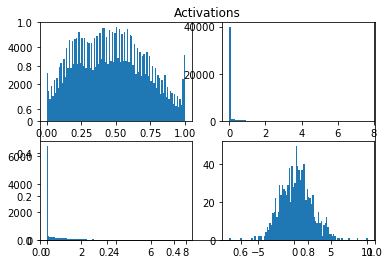

[6 8 4 6 0 9 3 6 0 8 0 8 3 2 0 1 4 0 6 1 5 4 6 6 6 9 8 3 8 0 9 0 0 0 9 4 0
 1 4 2 7 1 4 9 7 8 9 8 0 7 9 4 9 8 0 6 3 2 1 8 1 9 8 6 9 9 3 1 4 9 8 5 8 5
 3 9 2 6 0 0 0 8 1 0 1 1 8 2 3 1 8 1 3 7 9 6 6 6 0 7]
[17 12  5  8  8  3 13  5 15 14]
[6 8 7 ..., 5 6 4]
[670 598 395 401 371 240 693 453 551 628]
cost: 39.10837797544407, train accuracy: 0.68, validation accuracy: 0.529
iterations finished: 7901 alpha: 0.00020589113209464906 reg. lambda: 0.0


Weights 0 Mean -0.000557142925416 SD 0.0251410944361
Weights 1 Mean -0.00241290147078 SD 0.0629986436287
Weights 2 Mean 0.000786497118276 SD 0.196490023221


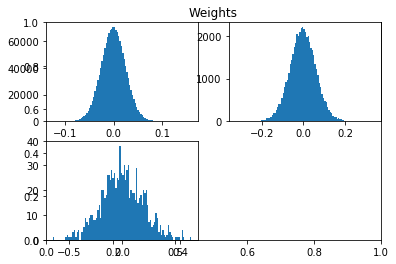

dW 0 Mean -0.0239764554295 SD 0.253588395131
dW 1 Mean -0.0207461396341 SD 0.630366021561
dW 2 Mean -8.52651282912e-17 SD 1.88202410406


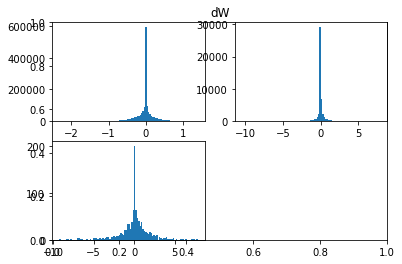

Biases 0 Mean 0.0989535235009 SD 0.0490444361247
Biases 1 Mean 0.129028368405 SD 0.162691321666
Biases 2 Mean 0.1 SD 0.411023828979


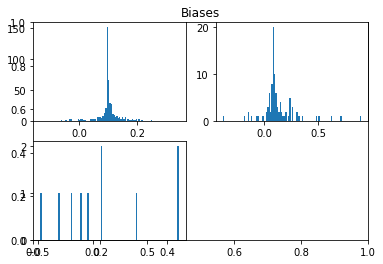

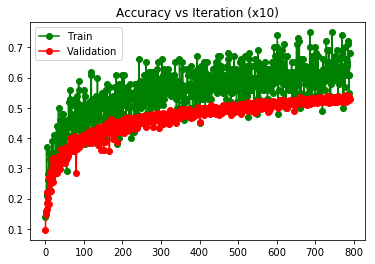

[1 2 5 1 2 9 4 5 3 8 9 3 6 7 1 7 9 1 9 0 3 3 0 0 1 7 3 8 1 2 2 9 0 0 3 5 6
 0 0 7 4 0 1 2 9 7 3 6 8 3 8 5 5 7 3 2 0 4 7 9 6 3 3 7 9 7 9 0 4 4 0 2 2 9
 3 8 6 8 3 8 1 3 2 0 4 3 1 4 4 0 6 5 4 6 7 6 2 7 2 6]
[13  9 11 15  9  6  9 11  7 10]
[6 8 7 ..., 5 6 4]
[568 417 503 419 481 322 692 559 394 645]
cost: 38.204669350689755, train accuracy: 0.58, validation accuracy: 0.533
iterations finished: 7911 alpha: 0.00020589113209464906 reg. lambda: 0.0


[2 1 7 1 2 0 1 7 7 2 9 9 2 6 4 7 9 0 0 6 2 6 5 5 1 1 8 3 9 4 6 3 3 8 8 7 1
 2 0 8 8 1 3 6 5 8 6 7 8 3 7 0 7 6 4 8 1 0 5 2 2 9 2 5 7 0 6 5 2 0 0 6 9 6
 1 1 8 0 1 2 1 3 9 9 5 1 3 9 1 5 1 6 2 6 7 8 7 2 6 8]
[10 15 13  7  3  8 13 11 11  9]
[6 8 7 ..., 5 6 4]
[542 662 439 432 347 419 718 480 486 475]
cost: 41.90899330588978, train accuracy: 0.67, validation accuracy: 0.5338
iterations finished: 7921 alpha: 0.00020589113209464906 reg. lambda: 0.0


[0 3 4 7 3 6 6 2 3 8 6 4 6 9 6 3 6 1 1 0 5 5 0 2 7 7 6 9 2 2 8 8 9 1 9 7 2
 4 8 1 2 8 2 5 9 3 7 6 9 3 1 7 

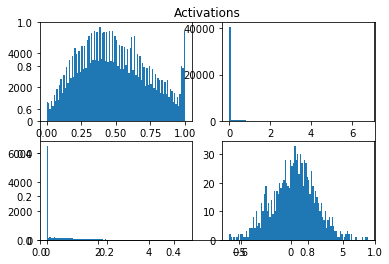

[3 7 9 9 7 7 9 3 0 6 4 8 3 9 3 4 6 5 3 7 2 8 1 4 5 1 4 1 3 9 5 9 0 9 2 2 7
 6 4 4 7 2 6 3 5 9 2 9 4 3 7 2 0 4 7 9 3 9 9 9 4 4 7 5 7 4 9 4 0 7 4 2 6 4
 8 5 4 3 6 3 4 4 9 0 5 4 2 9 8 4 7 1 7 3 2 2 4 7 9 8]
[ 5  4 10 12 20  7  6 14  5 17]
[6 8 7 ..., 5 6 4]
[391 315 623 425 622 457 490 533 455 689]
cost: 38.915729926400516, train accuracy: 0.56, validation accuracy: 0.5226
iterations finished: 8001 alpha: 0.00018530201888518417 reg. lambda: 0.0


Weights 0 Mean -0.00057021651534 SD 0.0251468419292
Weights 1 Mean -0.00240264400161 SD 0.063035791995
Weights 2 Mean 0.000786497118276 SD 0.197020985566


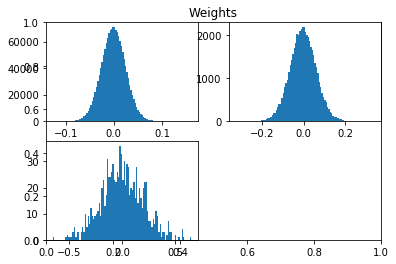

dW 0 Mean 0.000185963925835 SD 0.245128761999
dW 1 Mean 0.00630583682958 SD 0.569542636611
dW 2 Mean 0.0 SD 2.02476513072


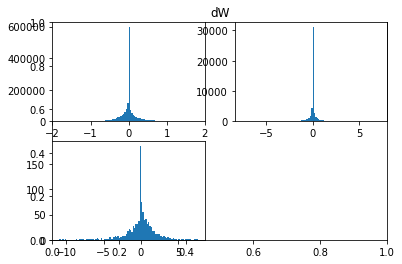

Biases 0 Mean 0.0989286322762 SD 0.0492760632581
Biases 1 Mean 0.129208115602 SD 0.163249234163
Biases 2 Mean 0.1 SD 0.412402467448


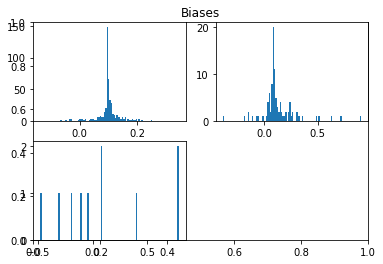

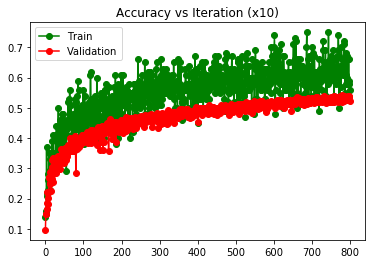

[8 5 5 8 9 0 0 1 8 1 1 6 9 9 4 6 7 9 3 9 1 1 1 2 3 0 9 5 3 6 4 6 1 9 1 4 4
 1 6 4 6 3 8 1 4 8 5 1 8 7 7 1 1 1 6 4 6 1 1 1 6 8 1 6 4 1 7 9 0 0 4 7 1 7
 7 0 0 0 0 0 6 9 9 3 9 9 8 8 6 7 4 3 7 4 7 8 1 8 7 0]
[11 21  1  6 11  4 12 11 11 12]
[6 8 7 ..., 5 6 4]
[480 559 281 469 474 289 809 657 545 437]
cost: 43.240016840108474, train accuracy: 0.65, validation accuracy: 0.5386
iterations finished: 8011 alpha: 0.00018530201888518417 reg. lambda: 0.0


[1 4 0 7 7 1 7 0 2 3 8 8 4 4 8 4 6 9 6 1 8 6 2 0 0 1 7 4 4 6 4 1 5 7 7 4 5
 1 7 7 4 9 4 1 5 9 0 1 1 4 5 8 2 9 8 9 0 6 4 3 4 7 8 6 7 5 1 0 0 4 6 2 5 4
 9 4 6 6 1 8 0 8 0 4 0 9 3 3 9 1 3 1 4 9 3 1 6 0 4 4]
[12 14  4  6 20  6 10 10  9  9]
[6 8 7 ..., 5 3 4]
[422 540 345 466 584 521 566 479 566 511]
cost: 41.19697904149332, train accuracy: 0.59, validation accuracy: 0.5342
iterations finished: 8021 alpha: 0.00018530201888518417 reg. lambda: 0.0


[6 6 6 2 8 2 5 7 7 3 9 6 1 0 9 6 7 8 2 6 6 5 9 6 1 3 3 8 2 3 8 9 6 4 4 9 7
 3 9 0 1 4 6 7 4 9 7 0 4 3 9 4

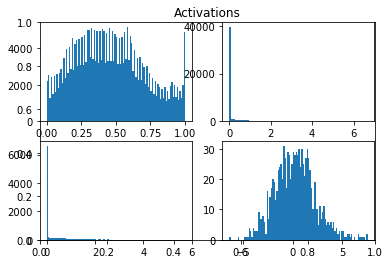

[8 2 6 1 7 0 9 5 4 1 7 1 5 6 9 2 0 4 8 0 0 8 0 9 6 9 4 9 1 9 7 0 9 5 7 8 0
 4 2 1 6 6 9 2 3 7 6 8 2 2 7 7 5 3 8 0 4 7 9 8 7 8 3 8 4 7 4 2 0 4 6 0 8 5
 9 9 4 7 2 8 4 6 5 5 9 6 7 1 1 1 7 8 8 0 7 3 7 3 2 8]
[11  8  9  5 10  7  9 15 14 12]
[6 8 7 ..., 5 6 4]
[448 522 320 396 373 423 704 561 684 569]
cost: 40.4834976140021, train accuracy: 0.64, validation accuracy: 0.5344
iterations finished: 8101 alpha: 0.00018530201888518417 reg. lambda: 0.0


Weights 0 Mean -0.000556951796557 SD 0.0251524418406
Weights 1 Mean -0.00238934354839 SD 0.0630724925561
Weights 2 Mean 0.000786497118276 SD 0.197552207488


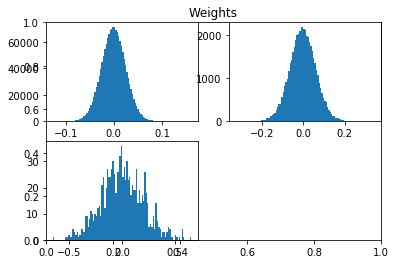

dW 0 Mean -0.00388826691155 SD 0.212393446962
dW 1 Mean -0.0209914777038 SD 0.541290525308
dW 2 Mean 0.0 SD 1.97852362055


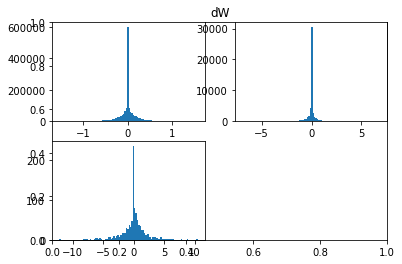

Biases 0 Mean 0.0989604072366 SD 0.0493530781461
Biases 1 Mean 0.129403977159 SD 0.163606346727
Biases 2 Mean 0.1 SD 0.413350376461


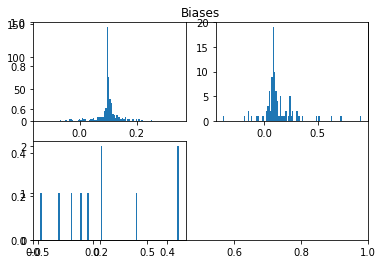

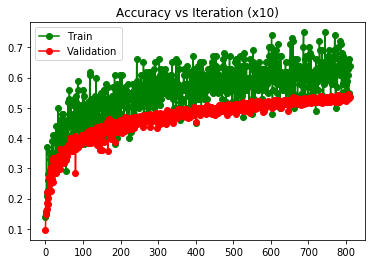

[8 1 0 1 0 1 1 8 6 8 2 7 8 7 2 4 3 8 4 9 7 8 2 0 7 8 3 6 3 0 7 1 7 9 6 2 7
 6 7 9 1 6 6 9 2 0 0 0 5 4 9 4 3 3 0 2 9 6 8 6 0 0 2 2 7 3 8 4 6 4 7 9 2 0
 2 5 3 6 0 0 9 6 2 9 8 1 3 2 8 2 7 7 9 8 2 8 7 3 0 0]
[15  7 14  9  6  2 11 13 13 10]
[6 8 7 ..., 5 6 4]
[545 452 684 422 327 417 535 505 618 495]
cost: 43.72392589038808, train accuracy: 0.68, validation accuracy: 0.5374
iterations finished: 8111 alpha: 0.00018530201888518417 reg. lambda: 0.0


[5 4 3 4 1 6 6 9 4 4 3 7 6 8 2 0 1 0 0 2 8 5 7 9 1 5 8 7 9 4 4 0 2 9 4 5 0
 8 9 3 3 4 6 7 3 1 1 1 3 2 9 3 3 9 8 6 0 8 8 5 9 6 2 3 4 6 3 0 3 0 3 2 5 9
 6 9 3 9 6 2 4 7 3 5 7 4 2 0 8 5 8 9 8 0 3 4 9 0 6 9]
[11  6  8 15 12  8 10  6 10 14]
[6 8 7 ..., 5 3 4]
[514 488 429 553 404 516 446 500 483 667]
cost: 40.861611293556884, train accuracy: 0.67, validation accuracy: 0.5318
iterations finished: 8121 alpha: 0.00018530201888518417 reg. lambda: 0.0


[4 8 4 6 9 7 5 2 4 9 7 6 2 7 3 3 8 0 9 2 9 6 1 7 2 7 2 1 4 0 7 2 3 2 6 5 4
 6 7 6 4 4 6 4 8 1 8 2 0 3 3 7

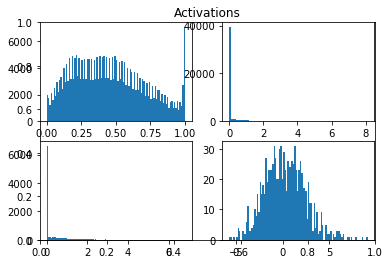

[7 9 9 1 9 9 3 4 4 4 6 1 2 5 6 3 9 0 5 6 8 8 5 6 9 1 5 0 8 0 5 5 3 1 7 1 6
 6 9 4 3 6 1 1 3 7 3 5 5 1 3 4 7 7 5 6 2 1 6 1 3 9 0 5 5 4 5 2 7 0 6 8 5 4
 9 1 3 1 9 1 8 6 3 7 5 3 7 4 7 7 7 5 4 1 7 9 8 1 5 9]
[ 5 15  3 11  9 16 11 12  6 12]
[6 8 7 ..., 5 3 4]
[492 572 382 442 393 467 660 616 509 467]
cost: 42.302309653474424, train accuracy: 0.68, validation accuracy: 0.5412
iterations finished: 8201 alpha: 0.00018530201888518417 reg. lambda: 0.0


Weights 0 Mean -0.00054926909245 SD 0.0251578178297
Weights 1 Mean -0.00237092956812 SD 0.0631061208998
Weights 2 Mean 0.000786497118276 SD 0.198046320431


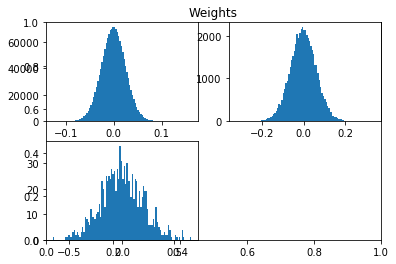

dW 0 Mean -0.0121709108911 SD 0.178048899023
dW 1 Mean -0.0295365515793 SD 0.477432987175
dW 2 Mean -3.5527136788e-17 SD 1.64420776299


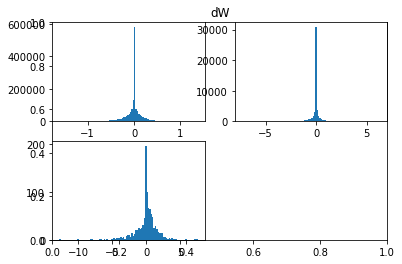

Biases 0 Mean 0.0989619993926 SD 0.049512746612
Biases 1 Mean 0.129604243032 SD 0.164250907942
Biases 2 Mean 0.1 SD 0.414318705793


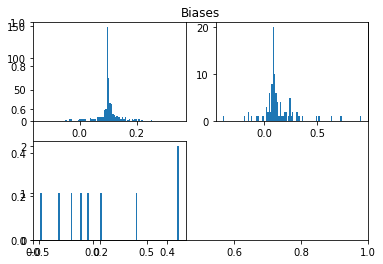

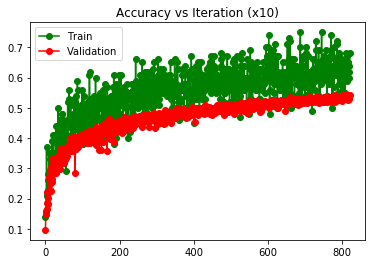

[0 0 7 3 6 6 2 3 0 7 5 9 7 5 9 9 2 2 3 8 1 6 5 7 9 8 6 2 7 1 8 9 1 7 2 6 3
 1 7 1 8 6 6 0 6 7 9 6 8 0 7 1 3 8 7 7 6 9 6 3 4 6 1 8 1 3 0 6 5 5 0 7 7 1
 1 8 1 3 4 5 8 6 8 7 1 5 4 7 2 7 6 0 5 5 5 5 2 5 9 7]
[ 8 12  7  8  3 12 15 17 10  8]
[6 8 7 ..., 5 3 4]
[418 485 304 504 327 564 691 659 486 562]
cost: 44.147815903451374, train accuracy: 0.69, validation accuracy: 0.529
iterations finished: 8211 alpha: 0.00018530201888518417 reg. lambda: 0.0


[8 9 9 0 3 6 1 1 1 6 5 7 5 9 8 5 9 6 9 3 2 6 7 1 2 1 9 6 4 0 9 6 3 3 4 1 5
 3 1 1 0 3 8 7 1 0 4 8 9 4 1 7 3 7 2 9 6 1 7 9 4 3 5 1 1 4 2 3 1 3 4 8 9 4
 4 0 5 1 0 1 5 9 7 3 1 9 1 3 0 5 4 7 3 6 1 9 2 2 8 3]
[ 7 19  6 14 10  8  8  8  6 14]
[6 8 7 ..., 5 3 4]
[396 706 315 374 539 384 591 639 531 525]
cost: 41.215118233400624, train accuracy: 0.64, validation accuracy: 0.531
iterations finished: 8221 alpha: 0.00018530201888518417 reg. lambda: 0.0


[2 0 1 3 5 6 0 3 0 7 6 0 6 9 3 4 9 6 8 0 5 5 0 6 8 8 3 0 4 9 1 4 8 9 9 5 2
 4 2 5 1 1 1 5 3 1 1 0 3 1 5 1 

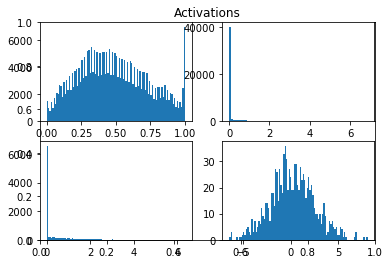

[0 8 0 2 8 0 1 7 5 9 0 6 4 2 0 1 7 1 8 1 7 4 2 2 1 5 0 1 8 3 6 0 9 9 9 8 7
 6 0 5 3 1 0 1 5 9 2 3 7 6 3 7 2 5 6 5 6 9 3 1 1 6 4 9 3 5 1 7 6 7 7 2 5 2
 9 1 5 0 2 6 5 8 1 2 8 1 4 1 1 5 8 3 3 1 1 9 9 8 4 1]
[10 19 10  8  5 11  9  9  9 10]
[6 8 7 ..., 5 6 4]
[491 587 392 432 409 414 641 571 573 490]
cost: 42.315200339016336, train accuracy: 0.55, validation accuracy: 0.539
iterations finished: 8301 alpha: 0.00018530201888518417 reg. lambda: 0.0


Weights 0 Mean -0.000562716765401 SD 0.0251626286589
Weights 1 Mean -0.00238388975279 SD 0.0631358194213
Weights 2 Mean 0.000786497118276 SD 0.19845196362


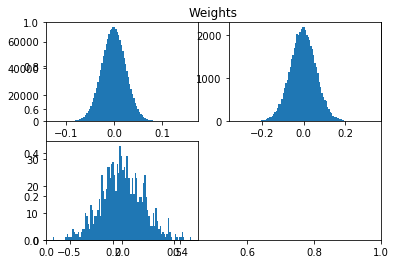

dW 0 Mean 2.29740718444e-05 SD 0.212915916723
dW 1 Mean -0.00604537696375 SD 0.529819504689
dW 2 Mean -5.68434188608e-17 SD 1.73650821597


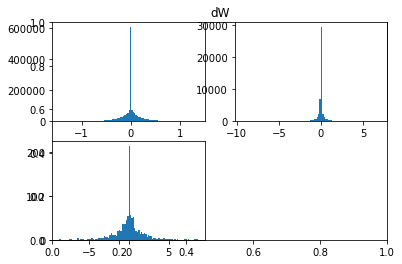

Biases 0 Mean 0.0989502734673 SD 0.049591363086
Biases 1 Mean 0.129706963231 SD 0.164480573058
Biases 2 Mean 0.1 SD 0.414141080965


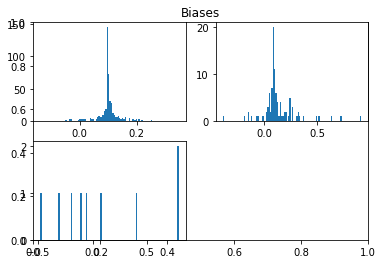

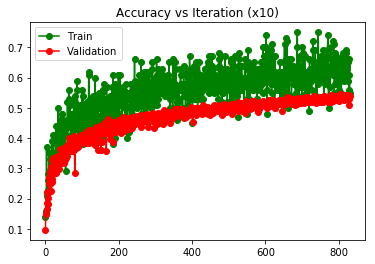

[3 0 1 8 1 4 1 8 1 6 7 2 4 3 6 5 6 4 6 3 2 9 8 9 0 6 6 8 0 1 3 2 2 3 0 7 0
 0 0 8 4 5 0 2 3 6 8 4 6 3 6 7 0 0 7 5 6 2 3 6 5 7 0 3 5 1 9 3 6 7 0 3 0 6
 6 4 4 6 5 9 1 7 5 9 9 7 2 9 7 6 3 6 1 7 5 7 7 9 4 2]
[13  8  8 12  8  8 17 12  6  8]
[6 8 7 ..., 5 6 4]
[595 476 358 453 516 377 622 607 522 474]
cost: 39.60795966119768, train accuracy: 0.56, validation accuracy: 0.537
iterations finished: 8311 alpha: 0.00018530201888518417 reg. lambda: 0.0


[8 9 4 2 5 0 0 3 1 1 2 5 5 9 8 0 8 1 7 1 8 5 0 5 3 6 7 7 6 9 4 5 8 1 7 2 4
 1 3 0 5 5 2 0 5 3 1 5 1 7 0 8 5 0 8 8 1 7 8 7 1 8 7 3 6 5 1 8 5 8 9 4 2 3
 8 8 5 0 5 4 5 7 9 4 9 8 5 1 6 2 3 8 6 1 3 1 6 7 9 5]
[ 9 14  6  8  6 18  6 10 16  7]
[6 8 7 ..., 5 5 4]
[430 640 336 438 426 643 475 584 639 389]
cost: 39.696454114843284, train accuracy: 0.64, validation accuracy: 0.5306
iterations finished: 8321 alpha: 0.00018530201888518417 reg. lambda: 0.0


[9 7 6 6 6 5 4 3 6 0 4 8 3 9 8 2 4 8 1 8 7 4 8 6 6 8 4 8 4 8 5 4 6 8 3 7 9
 2 5 3 0 6 9 8 1 3 7 3 7 9 4 7 

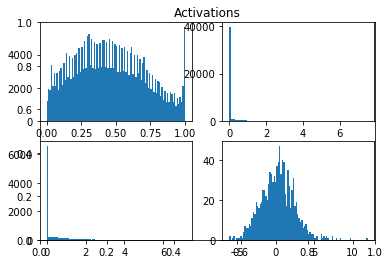

[1 8 2 4 9 8 2 1 8 7 2 9 2 3 3 2 4 3 7 7 3 0 4 3 5 6 9 3 5 3 2 1 9 3 1 3 3
 5 7 6 4 2 5 8 8 2 7 9 9 6 4 0 1 8 6 1 0 6 8 6 1 0 2 9 4 0 0 6 8 3 4 0 3 3
 8 3 1 8 5 7 9 3 9 3 8 6 6 6 5 6 9 8 1 0 3 4 6 6 0 3]
[ 9  9  9 18  8  6 13  6 12 10]
[6 8 7 ..., 5 3 4]
[441 479 448 596 527 373 592 508 512 524]
cost: 40.683442038049115, train accuracy: 0.61, validation accuracy: 0.536
iterations finished: 8401 alpha: 0.00018530201888518417 reg. lambda: 0.0


Weights 0 Mean -0.000555296643866 SD 0.0251675684437
Weights 1 Mean -0.00239107843988 SD 0.0631636522714
Weights 2 Mean 0.000786497118276 SD 0.198842790468


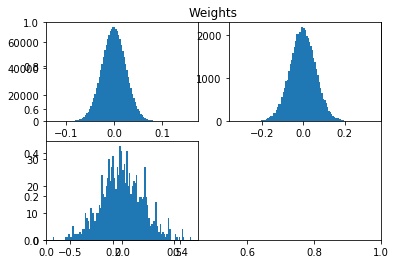

dW 0 Mean -0.00477182639579 SD 0.210206437051
dW 1 Mean 0.00167737329112 SD 0.518396312075
dW 2 Mean 7.1054273576e-17 SD 1.74385568265


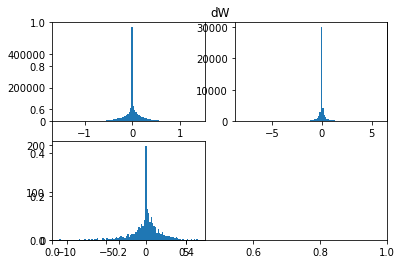

Biases 0 Mean 0.0989740446285 SD 0.0497627030724
Biases 1 Mean 0.129771859505 SD 0.164927575605
Biases 2 Mean 0.1 SD 0.414546985049


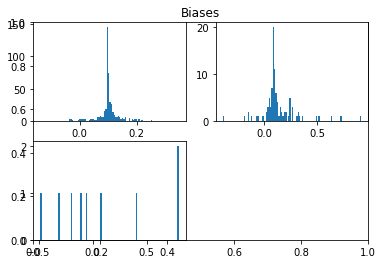

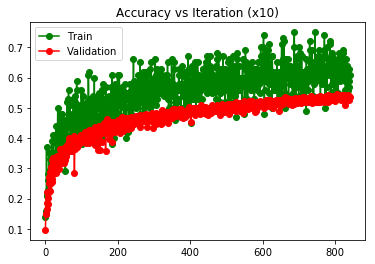

[6 5 0 0 6 0 6 0 3 8 5 0 0 5 6 4 8 0 0 4 6 2 8 9 4 0 8 4 9 1 5 3 9 5 0 9 0
 6 2 9 2 4 0 4 1 2 6 9 0 6 6 9 9 3 9 9 3 6 8 5 6 5 9 7 9 6 5 9 1 5 6 9 6 7
 8 7 6 4 9 3 8 7 5 2 8 5 5 6 2 6 1 3 1 5 9 4 5 3 7 6]
[13  5  6  7  8 14 18  5  8 16]
[6 8 7 ..., 5 6 4]
[489 499 459 415 305 486 760 499 446 642]
cost: 42.29058495732933, train accuracy: 0.63, validation accuracy: 0.531
iterations finished: 8411 alpha: 0.00018530201888518417 reg. lambda: 0.0


[1 1 4 9 1 9 5 9 5 5 7 8 3 1 4 1 1 7 4 0 8 7 1 3 4 3 3 7 1 8 0 3 8 1 8 0 1
 8 8 3 4 1 4 3 4 6 0 3 0 2 4 5 2 4 4 9 1 4 0 6 1 9 7 5 1 3 9 0 7 0 0 9 4 4
 1 4 5 3 7 8 1 9 8 8 1 8 7 1 2 7 3 4 5 8 2 3 5 4 9 2]
[ 9 18  5 12 16  8  2  9 12  9]
[6 1 7 ..., 5 3 4]
[480 788 307 382 580 360 549 568 531 455]
cost: 40.05072331898898, train accuracy: 0.64, validation accuracy: 0.5316
iterations finished: 8421 alpha: 0.00018530201888518417 reg. lambda: 0.0


[3 7 1 4 2 5 8 5 9 9 1 0 9 4 4 2 8 1 2 9 9 4 0 0 6 0 0 3 6 2 9 1 9 1 7 1 7
 1 8 7 6 4 9 1 2 3 0 0 5 1 4 1 0

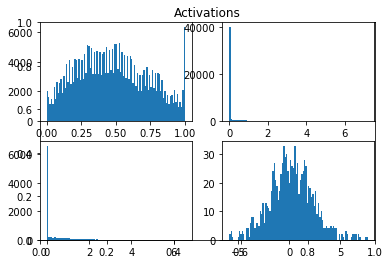

[9 7 0 7 0 6 2 5 7 9 0 8 1 2 8 9 9 6 9 8 0 8 8 3 9 1 6 1 1 9 2 4 5 9 6 7 7
 8 1 3 8 2 7 2 4 0 0 6 7 6 2 0 7 1 9 8 4 6 5 8 6 0 0 5 0 4 0 8 0 3 0 8 3 0
 6 2 0 3 6 0 1 4 0 3 4 0 6 8 0 2 9 9 5 4 8 6 2 3 9 8]
[19  7  9  7  7  5 12  8 14 12]
[6 8 7 ..., 5 3 4]
[417 581 537 470 506 311 659 477 574 468]
cost: 41.02007567595611, train accuracy: 0.56, validation accuracy: 0.5408
iterations finished: 8501 alpha: 0.00016677181699666576 reg. lambda: 0.0


Weights 0 Mean -0.000569938821909 SD 0.025172631432
Weights 1 Mean -0.00237022828848 SD 0.0631957296185
Weights 2 Mean 0.000786497118276 SD 0.199290986714


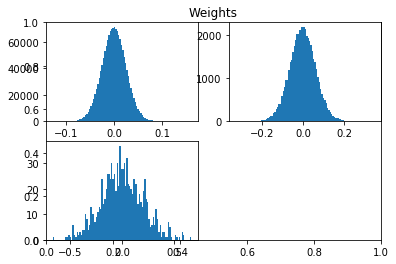

dW 0 Mean 0.00287238638808 SD 0.2668134955
dW 1 Mean 0.0240596902376 SD 0.692709840147
dW 2 Mean -2.84217094304e-17 SD 2.03979604731


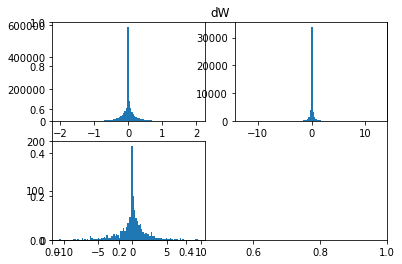

Biases 0 Mean 0.0989411773681 SD 0.0499013663751
Biases 1 Mean 0.129984966688 SD 0.165431807026
Biases 2 Mean 0.1 SD 0.415210841268


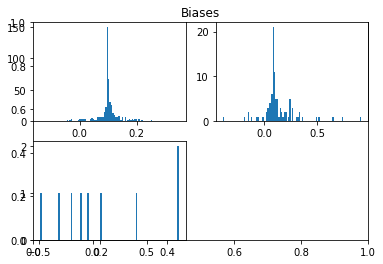

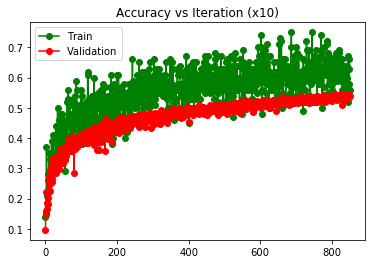

[9 3 0 8 5 1 4 4 6 6 7 7 1 5 7 8 3 7 7 1 8 2 9 8 4 6 4 8 9 4 1 9 8 7 8 3 1
 2 4 7 4 1 4 8 4 6 8 0 0 6 6 3 1 4 3 8 1 6 1 8 8 9 6 6 0 9 9 5 4 4 4 7 7 6
 8 5 5 9 9 3 3 3 1 8 5 0 3 9 3 8 1 0 3 1 3 8 6 6 6 0]
[ 7 12  2 12 13  6 13  9 16 10]
[6 8 7 ..., 5 3 4]
[437 588 268 584 480 355 639 554 638 457]
cost: 41.110577921739186, train accuracy: 0.64, validation accuracy: 0.5374
iterations finished: 8511 alpha: 0.00016677181699666576 reg. lambda: 0.0


[7 5 6 5 1 5 5 0 3 6 0 2 2 3 0 6 5 5 5 9 5 8 7 8 7 7 3 5 3 7 1 4 6 3 2 7 6
 3 4 9 8 6 3 0 6 9 1 5 6 3 4 7 3 3 1 3 8 0 8 0 1 0 8 8 3 4 6 0 1 6 5 3 9 3
 7 4 4 0 6 3 2 2 0 8 0 6 2 9 5 5 7 7 1 6 1 8 6 5 1 9]
[11  9  6 15  6 14 14 10  9  6]
[6 8 7 ..., 5 3 4]
[503 439 429 445 411 462 670 613 519 509]
cost: 39.07363359797619, train accuracy: 0.6, validation accuracy: 0.5404
iterations finished: 8521 alpha: 0.00016677181699666576 reg. lambda: 0.0


[9 0 2 6 1 5 0 1 9 0 3 6 4 4 9 6 7 4 5 3 1 4 5 6 3 5 1 0 8 4 8 7 8 8 0 8 8
 4 1 1 8 7 6 5 4 4 4 4 6 0 1 4 

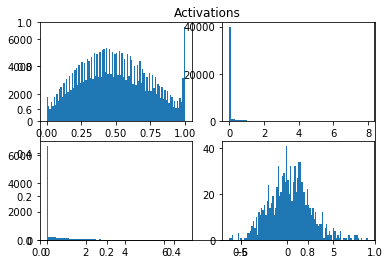

[3 1 0 7 0 6 3 9 9 5 9 7 8 2 0 6 7 0 3 1 9 7 4 4 5 8 0 1 8 4 7 9 0 5 5 1 7
 5 3 1 5 0 0 9 7 4 5 2 5 7 9 7 8 8 3 8 9 1 3 6 6 6 3 6 7 3 3 0 6 7 9 5 4 8
 3 2 9 3 1 9 4 9 4 8 8 0 0 0 2 0 9 6 9 7 4 8 2 2 1 0]
[14  8  6 11  8  9  8 12 10 14]
[6 8 7 ..., 5 3 4]
[453 537 385 436 455 479 541 508 541 665]
cost: 42.313507614145784, train accuracy: 0.62, validation accuracy: 0.5426
iterations finished: 8601 alpha: 0.00016677181699666576 reg. lambda: 0.0


Weights 0 Mean -0.000550267739027 SD 0.0251779357969
Weights 1 Mean -0.00238202404278 SD 0.0632301668591
Weights 2 Mean 0.000786497118276 SD 0.199793187716


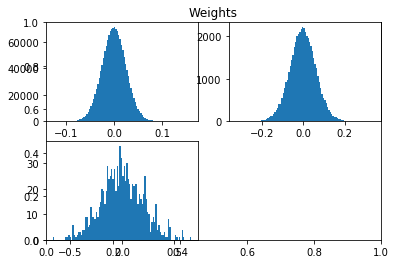

dW 0 Mean -0.0131683184483 SD 0.21776475307
dW 1 Mean -0.0025030161072 SD 0.523355942663
dW 2 Mean 5.68434188608e-17 SD 1.92620566227


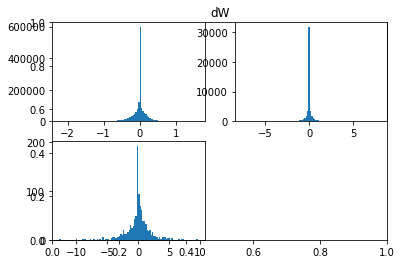

Biases 0 Mean 0.0989844697593 SD 0.0499973782639
Biases 1 Mean 0.13005486648 SD 0.165705172208
Biases 2 Mean 0.1 SD 0.415930920617


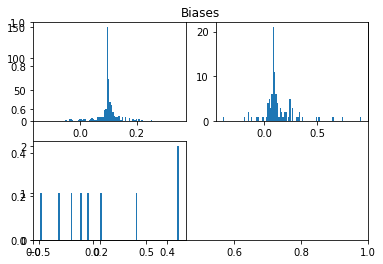

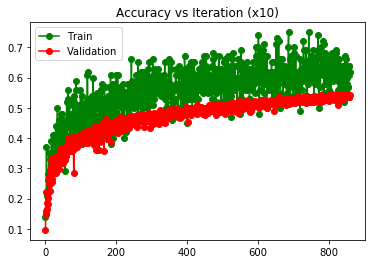

[7 8 3 2 9 6 7 7 5 8 7 9 2 0 1 6 1 4 0 4 8 0 7 3 8 8 9 0 3 8 6 7 7 2 1 0 4
 7 7 6 6 5 4 7 8 4 7 6 9 1 7 3 2 6 9 7 1 5 9 3 6 4 5 3 9 7 9 7 6 5 2 2 3 1
 5 6 5 9 5 2 2 3 1 7 3 4 5 2 0 5 3 3 4 0 3 9 9 7 0 5]
[ 8  7  9 12  8 11 10 17  7 11]
[6 8 7 ..., 5 3 4]
[462 513 366 483 468 495 565 636 424 588]
cost: 41.66716478272361, train accuracy: 0.69, validation accuracy: 0.538
iterations finished: 8611 alpha: 0.00016677181699666576 reg. lambda: 0.0


[2 1 8 6 3 5 6 7 1 5 3 1 3 3 1 4 1 2 9 5 0 2 8 3 7 6 2 9 5 9 5 4 4 7 9 1 6
 4 5 5 8 4 8 9 4 2 3 9 4 9 4 6 9 1 6 1 3 7 4 2 5 4 2 1 1 2 1 1 9 9 7 0 9 4
 4 5 9 8 7 0 8 7 1 4 3 9 4 1 2 5 1 0 8 1 6 7 8 0 8 8]
[ 5 16  9  8 14 10  7  8 10 13]
[6 8 7 ..., 5 5 4]
[417 481 536 347 507 519 534 504 693 462]
cost: 41.32353959405258, train accuracy: 0.6, validation accuracy: 0.5366
iterations finished: 8621 alpha: 0.00016677181699666576 reg. lambda: 0.0


[9 2 2 7 9 7 1 0 2 5 1 7 4 6 8 1 2 2 4 7 8 0 3 7 9 0 7 6 3 8 8 9 9 1 9 8 2
 9 4 4 1 2 9 9 7 0 1 0 1 1 8 7 6 

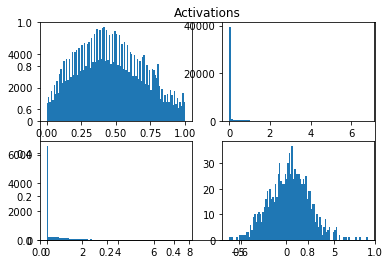

[5 2 2 0 9 7 8 7 2 2 9 9 4 9 4 1 2 1 2 2 4 4 5 2 8 9 3 2 5 2 5 8 2 2 7 3 1
 0 3 6 6 0 0 6 3 0 0 7 4 7 9 3 0 3 6 6 7 2 5 8 6 5 3 9 2 5 6 3 3 2 1 1 6 6
 0 0 2 2 1 3 5 7 1 1 7 9 3 6 9 8 6 7 4 4 5 0 5 2 2 1]
[10  9 19 11  7 10 11  9  5  9]
[6 8 7 ..., 5 3 4]
[397 559 702 447 360 546 443 497 576 473]
cost: 39.47487638495246, train accuracy: 0.54, validation accuracy: 0.5416
iterations finished: 8701 alpha: 0.00016677181699666576 reg. lambda: 0.0


Weights 0 Mean -0.00055383540292 SD 0.0251824678185
Weights 1 Mean -0.0023821401042 SD 0.0632605198687
Weights 2 Mean 0.000786497118276 SD 0.200243207869


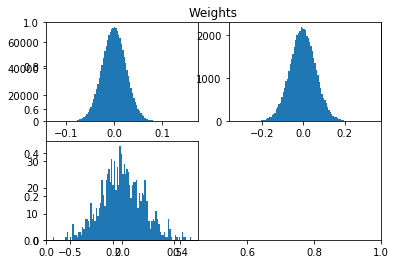

dW 0 Mean 0.0146169576998 SD 0.233106735895
dW 1 Mean -0.00910546424313 SD 0.59025978357
dW 2 Mean 2.84217094304e-17 SD 2.08348999126


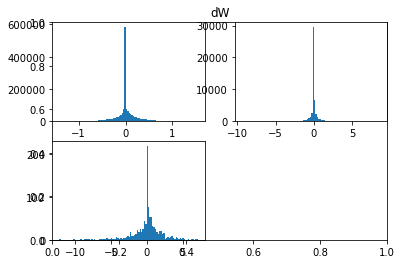

Biases 0 Mean 0.0989836461489 SD 0.0501440451482
Biases 1 Mean 0.130218733316 SD 0.166183613806
Biases 2 Mean 0.1 SD 0.415869850814


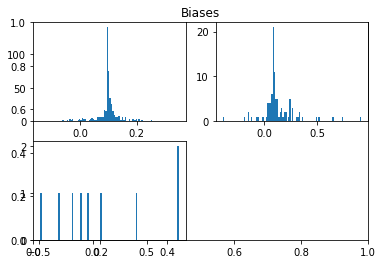

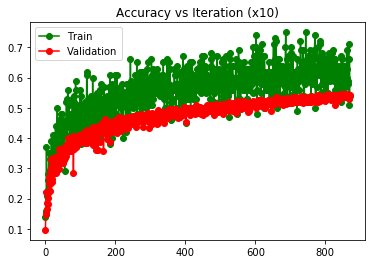

[7 4 0 6 7 4 8 9 3 5 4 6 3 9 5 5 2 6 4 3 6 9 4 4 8 4 1 2 8 1 2 6 0 5 7 7 1
 6 5 5 5 4 6 0 3 6 7 4 4 8 2 0 2 5 0 4 4 9 6 5 5 3 2 6 9 5 4 5 7 4 6 2 6 0
 9 6 3 5 6 9 9 5 0 4 0 8 4 4 1 2 9 3 9 8 3 9 5 8 4 3]
[ 8  4  8  9 18 15 14  6  7 11]
[6 7 7 ..., 5 5 4]
[348 518 379 406 696 469 606 612 392 574]
cost: 39.40381191495825, train accuracy: 0.55, validation accuracy: 0.5256
iterations finished: 8711 alpha: 0.00016677181699666576 reg. lambda: 0.0


[6 3 4 6 4 7 4 5 6 1 9 4 6 9 9 5 0 8 4 6 1 6 5 2 8 4 8 4 5 3 6 7 0 2 4 8 7
 0 5 0 4 1 9 4 8 7 8 7 7 5 3 3 5 1 9 8 9 4 5 0 0 3 3 0 4 6 7 8 9 8 6 9 5 7
 3 5 1 8 0 4 8 9 2 6 3 8 8 7 0 1 2 7 9 8 8 4 6 8 7 0]
[10  6  4  8 14 10 11 11 16 10]
[6 8 7 ..., 5 3 4]
[393 472 366 421 631 544 528 468 647 530]
cost: 39.53790481617387, train accuracy: 0.62, validation accuracy: 0.541
iterations finished: 8721 alpha: 0.00016677181699666576 reg. lambda: 0.0


[6 5 2 8 3 8 2 6 5 7 4 8 1 3 9 9 7 6 3 4 7 1 4 6 1 4 2 2 2 2 8 5 0 0 5 2 8
 9 0 1 3 3 4 1 5 9 6 3 4 8 8 0 9

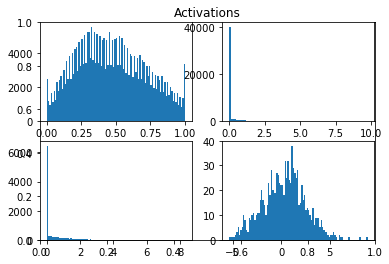

[2 2 5 1 7 9 3 9 9 5 7 9 9 9 7 0 6 9 0 1 6 0 7 0 6 5 8 3 5 5 3 9 6 1 1 3 4
 3 7 2 0 7 3 6 1 0 8 0 4 6 9 9 5 6 6 6 9 3 7 5 6 3 3 9 1 0 2 0 4 6 1 8 8 9
 5 0 9 3 4 0 3 1 7 1 5 6 0 6 5 9 9 5 8 3 4 5 5 9 2 6]
[12  9  5 12  5 13 14  8  5 17]
[6 8 7 ..., 5 6 4]
[461 443 373 403 442 560 686 503 531 598]
cost: 40.366540727137696, train accuracy: 0.56, validation accuracy: 0.543
iterations finished: 8801 alpha: 0.00016677181699666576 reg. lambda: 0.0


Weights 0 Mean -0.000553030933962 SD 0.0251875465156
Weights 1 Mean -0.00236783333078 SD 0.0632964871
Weights 2 Mean 0.000786497118276 SD 0.2007610158


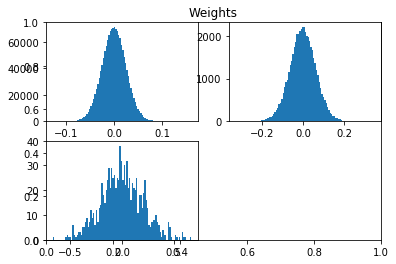

dW 0 Mean -0.0186563137952 SD 0.226214755451
dW 1 Mean 0.011077215948 SD 0.577827429055
dW 2 Mean -5.68434188608e-17 SD 2.09114187145


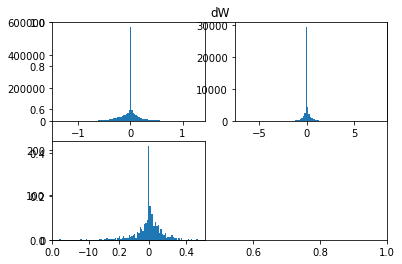

Biases 0 Mean 0.098999728485 SD 0.0502480868687
Biases 1 Mean 0.130382304176 SD 0.166536761924
Biases 2 Mean 0.1 SD 0.416519880994


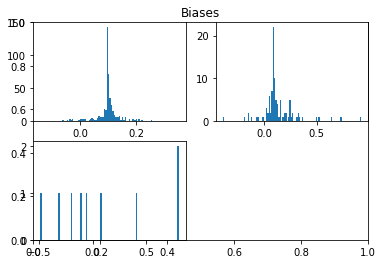

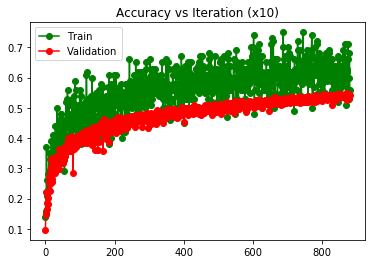

[6 5 2 1 6 0 7 8 0 6 1 4 7 2 1 2 5 2 9 4 3 3 7 9 3 9 6 7 3 1 7 8 2 5 3 3 8
 4 3 0 2 6 5 5 8 6 4 6 8 1 7 5 0 9 1 9 3 6 1 1 3 0 2 4 4 4 0 9 4 5 9 0 4 3
 3 5 8 2 6 5 0 8 0 5 7 5 2 1 4 1 7 0 2 4 2 5 0 0 6 2]
[12 10 12 11 11 12 10  8  7  7]
[6 8 7 ..., 5 3 4]
[553 465 522 361 573 392 561 524 522 527]
cost: 39.71165000419019, train accuracy: 0.64, validation accuracy: 0.545
iterations finished: 8811 alpha: 0.00016677181699666576 reg. lambda: 0.0


[4 0 8 1 5 1 0 4 9 8 2 4 4 9 7 9 2 4 4 6 9 0 5 3 4 6 9 5 9 8 1 9 0 3 7 6 5
 8 4 0 9 1 9 9 4 8 2 8 4 5 9 0 3 3 1 6 7 5 4 0 6 6 6 6 8 8 4 7 3 5 2 2 3 0
 3 1 1 2 3 5 4 4 6 7 3 8 5 6 5 6 9 8 7 0 1 9 4 5 7 6]
[ 9  8  6  9 15 11 12  7 10 13]
[6 8 7 ..., 5 6 4]
[479 514 365 327 589 413 724 400 666 523]
cost: 41.65493909636238, train accuracy: 0.58, validation accuracy: 0.5358
iterations finished: 8821 alpha: 0.00016677181699666576 reg. lambda: 0.0


[9 6 6 7 6 0 4 6 8 0 2 0 8 0 0 1 7 9 1 8 7 7 6 3 6 3 0 9 1 8 8 7 0 7 5 2 2
 4 4 6 0 6 2 0 0 0 7 5 5 8 8 2 5

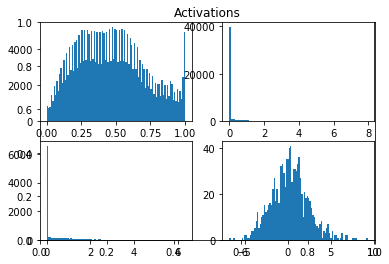

[0 4 2 7 4 1 7 8 1 2 3 1 3 7 6 2 5 2 6 9 1 9 9 2 0 7 2 9 2 2 9 7 9 0 9 9 9
 6 0 8 0 7 0 8 8 0 0 7 0 9 6 6 4 2 6 5 3 9 5 9 2 9 7 4 9 9 2 2 6 7 6 7 2 8
 4 1 0 8 2 6 5 1 6 7 5 0 5 4 3 1 5 4 4 3 9 6 9 5 4 6]
[11  7 14  5  9  8 12 11  6 17]
[6 8 7 ..., 5 6 4]
[412 444 506 346 524 519 594 522 546 587]
cost: 41.029370181860784, train accuracy: 0.63, validation accuracy: 0.5432
iterations finished: 8901 alpha: 0.00016677181699666576 reg. lambda: 0.0


Weights 0 Mean -0.000557251812184 SD 0.0251920677476
Weights 1 Mean -0.00235888412714 SD 0.0633271413799
Weights 2 Mean 0.000786497118276 SD 0.201196523969


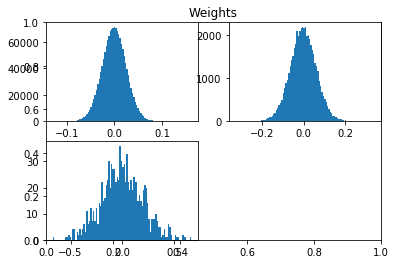

dW 0 Mean 0.0127742998445 SD 0.206733175843
dW 1 Mean -0.0150986661994 SD 0.540974517297
dW 2 Mean 0.0 SD 2.01521577026


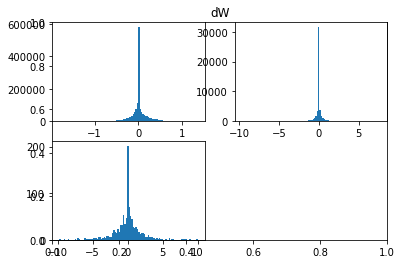

Biases 0 Mean 0.098989895093 SD 0.0503845065839
Biases 1 Mean 0.130501807303 SD 0.16688636584
Biases 2 Mean 0.1 SD 0.416593870327


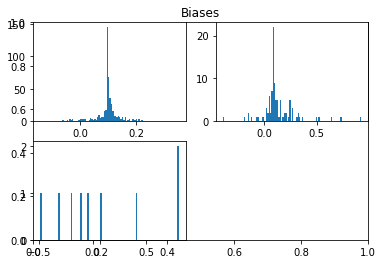

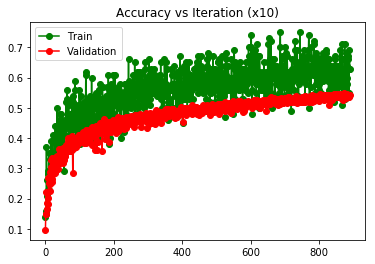

[6 8 8 6 6 6 6 0 5 6 9 3 9 6 3 9 2 1 0 1 8 4 2 8 8 3 9 1 2 1 0 0 8 8 6 9 5
 0 4 6 7 9 1 5 8 2 9 6 9 8 3 8 1 6 0 2 9 6 8 1 7 9 3 1 6 9 0 9 0 2 2 9 0 2
 1 6 1 2 9 1 2 4 8 8 6 6 6 0 6 2 5 8 9 9 0 2 0 4 7 0]
[13 11 12  5  4  4 18  3 14 16]
[6 8 7 ..., 2 0 4]
[527 552 531 406 497 301 601 434 632 519]
cost: 41.77963444974395, train accuracy: 0.65, validation accuracy: 0.5434
iterations finished: 8911 alpha: 0.00016677181699666576 reg. lambda: 0.0


[4 6 2 5 0 2 4 8 1 2 2 3 5 9 7 4 2 8 4 3 4 5 3 1 4 0 3 7 2 4 0 7 0 1 8 9 0
 1 9 9 2 9 2 2 9 1 2 0 3 9 9 8 0 4 8 0 0 8 6 3 2 8 3 5 1 6 8 9 8 6 2 2 2 2
 1 8 1 7 7 0 4 9 9 0 3 6 7 2 1 3 1 8 7 0 6 5 3 6 0 4]
[13 10 16 10 10  5  7  7 11 11]
[6 8 7 ..., 2 3 4]
[438 475 783 529 372 311 417 514 591 570]
cost: 41.856692290361444, train accuracy: 0.62, validation accuracy: 0.5392
iterations finished: 8921 alpha: 0.00016677181699666576 reg. lambda: 0.0


[5 2 6 0 2 8 5 3 3 3 3 2 4 9 0 0 2 0 3 8 3 1 2 2 5 5 0 8 6 1 2 9 5 8 2 5 8
 3 8 5 4 2 8 1 3 5 9 4 5 5 1 2

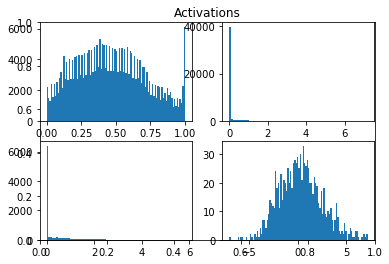

[4 5 1 3 7 5 2 2 7 6 3 3 9 7 6 2 7 8 6 5 4 7 0 2 2 8 6 7 9 9 5 9 1 3 8 8 3
 3 7 3 9 8 9 5 3 1 7 2 5 5 5 8 2 1 4 9 7 7 6 8 7 5 4 7 5 8 9 8 8 9 1 1 8 5
 7 7 9 4 2 4 5 1 3 7 9 8 4 3 0 8 0 8 8 9 6 0 1 8 3 9]
[ 4  8  8 11  7 12  6 15 16 13]
[6 8 7 ..., 5 3 4]
[346 398 494 432 331 635 531 618 559 656]
cost: 42.09278990870631, train accuracy: 0.68, validation accuracy: 0.5346
iterations finished: 9001 alpha: 0.0001500946352969992 reg. lambda: 0.0


Weights 0 Mean -0.000558091226848 SD 0.0251972632107
Weights 1 Mean -0.00234720994549 SD 0.0633643529245
Weights 2 Mean 0.000786497118276 SD 0.201736971537


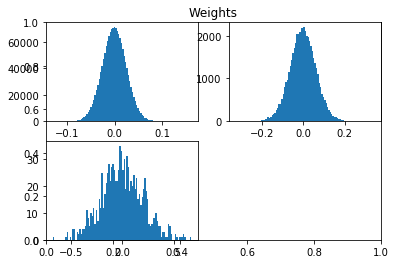

dW 0 Mean -0.0114421903079 SD 0.219962353813
dW 1 Mean -0.00945266179864 SD 0.54111513771
dW 2 Mean 2.84217094304e-17 SD 1.83589872642


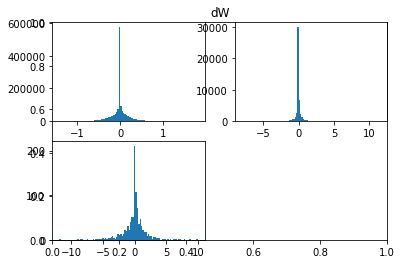

Biases 0 Mean 0.0989916044032 SD 0.0504899664293
Biases 1 Mean 0.130670415137 SD 0.167268771746
Biases 2 Mean 0.1 SD 0.417304404593


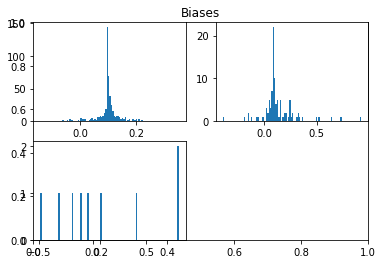

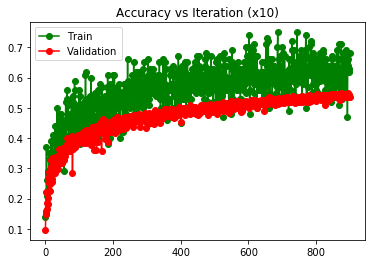

[0 6 2 0 8 9 2 3 6 2 3 1 8 2 8 6 7 0 7 7 2 9 1 6 0 8 7 8 2 5 2 7 7 2 8 6 0
 4 7 7 2 6 2 1 2 9 1 5 0 2 9 2 6 3 6 9 9 2 4 5 0 2 5 5 6 2 9 6 6 0 7 6 6 0
 8 0 5 9 4 5 9 3 1 6 9 8 0 6 3 7 6 3 6 6 1 2 0 1 9 5]
[12  7 17  6  3  8 18 10  8 11]
[6 8 7 ..., 5 6 2]
[411 417 617 375 337 403 794 577 518 551]
cost: 42.34180692318923, train accuracy: 0.64, validation accuracy: 0.5416
iterations finished: 9011 alpha: 0.0001500946352969992 reg. lambda: 0.0


[0 8 8 1 4 3 5 8 0 9 3 9 2 7 2 1 9 7 7 2 3 6 1 0 1 6 3 8 1 6 7 9 3 1 0 4 7
 2 0 8 6 2 7 5 8 2 5 4 7 3 1 9 3 5 5 3 3 7 7 1 6 9 3 3 9 1 0 3 9 6 5 4 3 8
 8 4 1 5 5 7 9 2 4 9 8 6 5 0 1 9 3 4 6 4 4 0 4 2 3 6]
[ 8 11  8 15 10  9  9 10  9 11]
[6 8 7 ..., 5 3 4]
[508 488 453 552 431 370 653 509 591 445]
cost: 40.105496448311655, train accuracy: 0.49, validation accuracy: 0.5434
iterations finished: 9021 alpha: 0.0001500946352969992 reg. lambda: 0.0


[2 9 1 3 9 1 9 0 6 1 7 3 0 8 3 3 1 6 3 2 8 0 1 3 3 6 9 0 3 9 0 7 8 0 3 1 9
 3 4 0 1 3 3 8 4 7 9 4 0 2 1 7 3

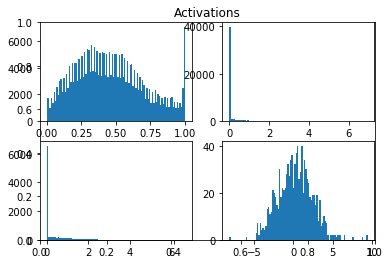

[2 9 6 6 8 7 0 6 1 2 6 7 8 3 6 7 3 5 7 3 7 6 0 9 2 4 5 7 5 2 3 9 9 7 0 2 5
 9 8 8 3 2 9 7 9 8 6 1 0 9 2 9 0 5 7 7 5 8 0 6 1 3 5 8 9 3 4 5 8 7 1 2 6 2
 5 5 3 7 0 4 4 3 7 6 2 9 9 4 6 0 5 6 5 1 9 2 0 7 7 0]
[10  5 11  9  5 12 12 15  8 13]
[6 8 7 ..., 5 6 4]
[451 425 521 357 343 630 624 530 520 599]
cost: 40.9987521987919, train accuracy: 0.59, validation accuracy: 0.5396
iterations finished: 9101 alpha: 0.0001500946352969992 reg. lambda: 0.0


Weights 0 Mean -0.000560668292544 SD 0.0252011244458
Weights 1 Mean -0.0023526467563 SD 0.0633894778887
Weights 2 Mean 0.000786497118276 SD 0.202109549315


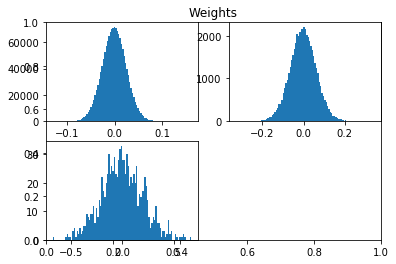

dW 0 Mean -0.00505321338675 SD 0.206808202184
dW 1 Mean 0.00543814861938 SD 0.490799956614
dW 2 Mean 0.0 SD 1.69783070708


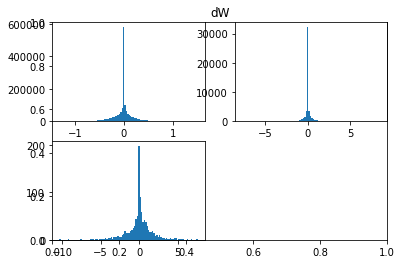

Biases 0 Mean 0.0989914736183 SD 0.0505716565144
Biases 1 Mean 0.130751371417 SD 0.167711083548
Biases 2 Mean 0.1 SD 0.417566886968


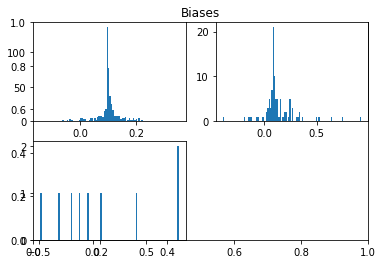

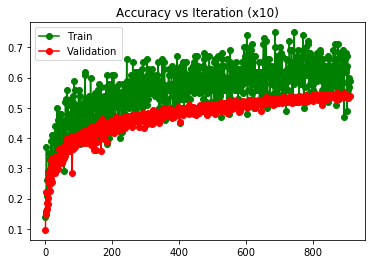

[6 7 4 8 6 8 2 6 6 9 1 0 8 1 5 2 6 8 9 9 5 4 4 5 0 4 1 2 6 8 5 5 6 4 6 5 6
 5 8 2 6 1 3 2 3 5 0 7 4 6 7 2 8 5 4 0 9 1 3 0 4 6 6 5 1 8 0 5 6 6 3 0 1 8
 6 2 9 4 6 7 8 4 8 6 3 3 6 6 4 4 0 2 2 9 5 3 6 7 9 2]
[ 8  7 10  7 12 12 21  5 11  7]
[6 8 7 ..., 5 6 4]
[413 395 572 405 396 453 818 425 560 563]
cost: 40.539805323912695, train accuracy: 0.63, validation accuracy: 0.5328
iterations finished: 9111 alpha: 0.0001500946352969992 reg. lambda: 0.0


[0 2 5 0 0 7 2 9 9 7 2 5 5 6 6 3 9 3 1 0 7 1 8 0 1 8 9 5 8 6 2 5 2 8 1 2 1
 7 2 0 9 1 7 8 3 9 9 7 3 5 5 4 7 6 5 2 8 8 3 5 5 2 5 5 7 1 3 9 7 5 5 3 5 4
 8 8 4 5 3 3 4 5 5 7 8 9 1 2 9 1 7 9 7 9 8 7 1 5 6 3]
[ 6 10 10 10  4 19  5 13 11 12]
[6 8 7 ..., 5 5 2]
[388 432 486 387 316 756 442 697 539 557]
cost: 40.33292480022792, train accuracy: 0.69, validation accuracy: 0.5306
iterations finished: 9121 alpha: 0.0001500946352969992 reg. lambda: 0.0


[6 2 0 5 7 1 1 2 9 6 0 0 0 4 8 1 7 1 1 7 8 8 2 2 8 4 9 0 3 5 3 2 3 3 7 1 4
 6 1 1 9 3 8 3 7 6 0 3 9 7 5 3 2

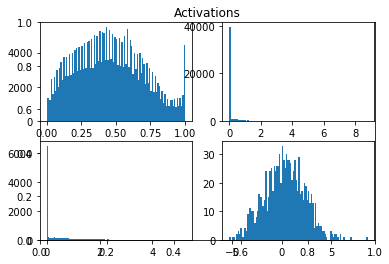

[4 0 0 3 6 1 0 9 4 3 8 9 9 6 2 5 7 7 4 1 1 1 5 1 0 6 6 4 5 2 3 7 6 3 4 5 9
 9 0 8 9 9 7 4 9 8 3 4 2 1 3 7 6 5 4 1 3 7 6 6 9 9 7 3 3 4 2 3 0 5 7 9 6 9
 6 3 8 4 4 6 0 5 4 6 7 6 6 8 0 8 4 6 1 7 3 7 3 7 8 6]
[ 8  8  4 13 13  7 16 12  7 12]
[6 8 7 ..., 5 6 4]
[418 587 330 486 452 257 781 629 500 560]
cost: 39.15789293546422, train accuracy: 0.6, validation accuracy: 0.5366
iterations finished: 9201 alpha: 0.0001500946352969992 reg. lambda: 0.0


Weights 0 Mean -0.000550455021371 SD 0.0252052848327
Weights 1 Mean -0.00237834046515 SD 0.0634143916928
Weights 2 Mean 0.000786497118276 SD 0.202471291348


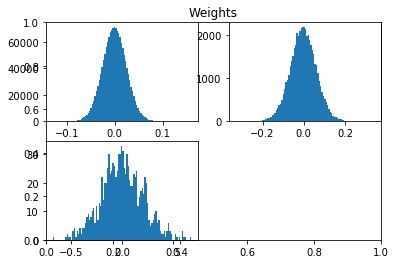

dW 0 Mean 0.00318299560971 SD 0.26240856075
dW 1 Mean 0.00314072341245 SD 0.542472098351
dW 2 Mean 2.84217094304e-17 SD 1.59811334019


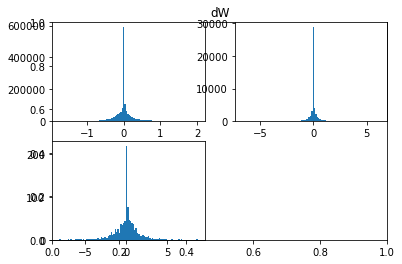

Biases 0 Mean 0.0990240004688 SD 0.0506630388565
Biases 1 Mean 0.130710893044 SD 0.168004683039
Biases 2 Mean 0.1 SD 0.418333159319


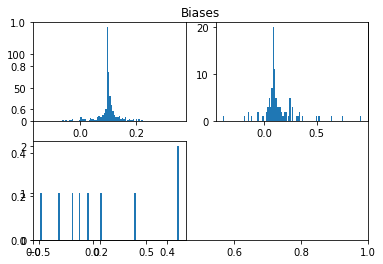

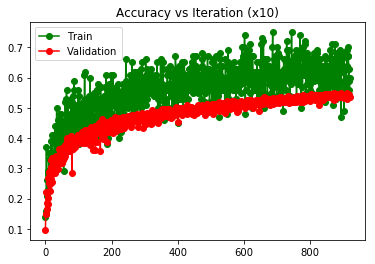

[0 3 9 7 2 5 2 6 1 1 5 0 4 5 3 6 3 3 4 0 1 7 5 4 2 2 4 5 5 0 6 3 8 5 5 1 7
 8 5 5 6 2 2 9 7 6 1 1 3 9 9 1 8 2 9 6 3 5 6 0 3 8 2 0 5 6 3 2 3 1 2 1 1 1
 3 4 7 6 2 4 5 1 6 2 3 5 9 0 0 1 4 1 3 2 6 7 4 3 6 3]
[ 8 14 13 15  8 14 12  6  4  6]
[6 8 7 ..., 5 6 4]
[557 513 432 537 551 422 664 401 516 407]
cost: 40.31073503327182, train accuracy: 0.57, validation accuracy: 0.5394
iterations finished: 9211 alpha: 0.0001500946352969992 reg. lambda: 0.0


[9 8 8 0 4 8 2 7 4 8 7 9 1 6 6 1 1 8 9 6 8 9 1 8 1 0 2 0 0 1 0 4 5 5 1 9 5
 8 3 7 9 9 2 9 5 7 8 7 7 8 2 0 1 5 6 1 9 2 7 9 9 0 3 9 7 2 3 9 0 8 0 8 0 1
 2 1 1 9 5 4 7 9 3 6 7 7 2 8 1 7 2 6 6 1 2 5 2 6 5 7]
[10 14 11  4  4  8  8 13 13 15]
[6 8 7 ..., 5 5 4]
[387 509 547 444 361 497 460 675 539 581]
cost: 42.311665154470376, train accuracy: 0.61, validation accuracy: 0.5428
iterations finished: 9221 alpha: 0.0001500946352969992 reg. lambda: 0.0


[0 2 7 2 7 7 9 3 3 5 9 6 2 1 4 2 8 9 2 6 0 7 4 9 9 8 8 6 2 5 5 8 9 4 6 5 3
 2 4 5 7 2 8 9 7 9 6 7 1 7 5 2 2

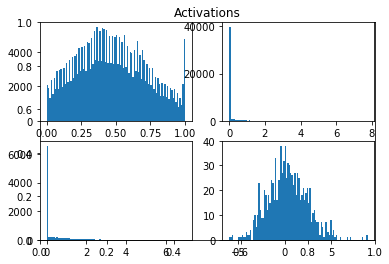

[4 8 4 4 9 7 3 1 2 4 3 6 5 8 5 4 1 7 2 9 4 6 9 4 4 9 2 6 5 6 3 0 8 3 7 3 0
 3 1 3 3 4 9 2 7 3 4 9 7 6 0 5 8 8 7 7 6 8 2 8 1 2 8 2 2 1 7 9 8 1 3 1 8 6
 3 4 1 6 4 4 6 0 8 8 7 0 6 5 9 5 1 2 7 1 8 1 5 5 1 1]
[ 5 13  9 11 13  8 10 10 13  8]
[6 8 7 ..., 5 6 4]
[509 567 461 458 562 334 585 532 606 386]
cost: 40.48170935872055, train accuracy: 0.61, validation accuracy: 0.5476
iterations finished: 9301 alpha: 0.0001500946352969992 reg. lambda: 0.0


Weights 0 Mean -0.000551835536119 SD 0.0252095139306
Weights 1 Mean -0.00236157789437 SD 0.0634448189504
Weights 2 Mean 0.000786497118276 SD 0.202902996761


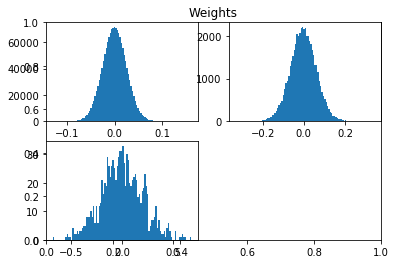

dW 0 Mean 0.00341294344549 SD 0.240004757831
dW 1 Mean 0.00644301752788 SD 0.630501886383
dW 2 Mean 9.94759830064e-17 SD 2.08617265512


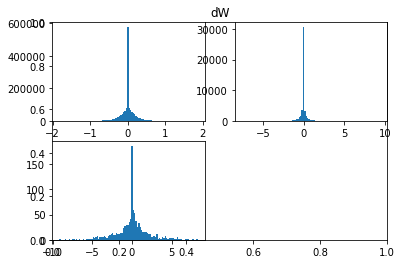

Biases 0 Mean 0.0990330985093 SD 0.0507461489563
Biases 1 Mean 0.130913905716 SD 0.168219805488
Biases 2 Mean 0.1 SD 0.4185017254


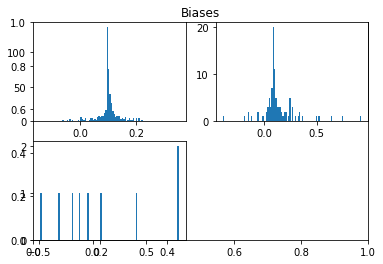

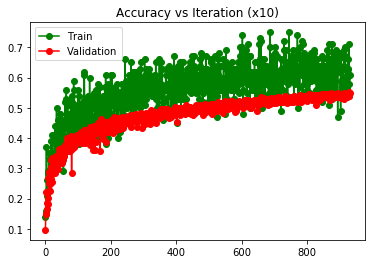

[3 0 7 7 5 7 5 1 1 0 9 8 0 3 7 4 7 7 7 7 7 7 3 5 2 9 9 2 2 6 7 5 7 3 5 4 4
 7 3 2 7 8 0 6 6 4 7 9 0 4 3 0 9 7 6 3 0 3 8 4 7 0 7 2 0 7 8 0 3 2 0 1 2 5
 9 4 2 9 4 3 2 3 9 4 0 3 9 6 9 0 2 8 6 4 6 1 2 2 2 8]
[13  4 13 12 10  6  7 19  6 10]
[6 7 7 ..., 5 6 4]
[520 449 469 444 719 300 523 609 468 499]
cost: 42.19196071735883, train accuracy: 0.59, validation accuracy: 0.5434
iterations finished: 9311 alpha: 0.0001500946352969992 reg. lambda: 0.0


[2 2 6 5 1 8 9 2 7 6 4 2 2 5 2 6 1 1 2 0 0 2 6 3 5 0 1 0 9 1 9 1 9 2 9 2 2
 9 3 3 9 4 5 9 6 6 8 7 2 5 3 9 6 9 0 5 7 2 8 0 5 2 2 0 7 5 6 3 2 1 6 6 8 6
 9 7 2 3 0 9 4 9 8 3 0 3 6 3 8 2 0 4 3 2 7 7 0 5 8 8]
[11  7 19 10  4  9 12  7  8 13]
[6 8 7 ..., 5 6 4]
[392 464 692 599 472 321 569 506 467 518]
cost: 42.02869105217411, train accuracy: 0.68, validation accuracy: 0.5442
iterations finished: 9321 alpha: 0.0001500946352969992 reg. lambda: 0.0


[5 5 1 5 8 8 8 2 8 6 4 5 8 9 8 5 3 3 9 6 7 4 3 1 0 5 7 4 6 0 8 6 9 0 9 6 9
 4 2 7 1 0 4 1 5 5 1 3 1 6 8 3 7 

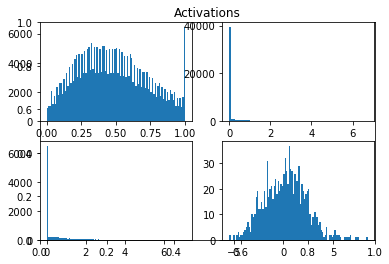

[9 5 4 7 6 4 6 8 0 0 9 1 6 7 5 9 6 6 9 0 9 6 2 9 2 6 5 3 8 1 8 8 7 5 5 9 7
 3 4 9 8 8 7 5 7 7 5 9 4 5 5 7 8 4 7 5 5 9 4 9 1 4 3 1 8 3 6 5 2 5 9 5 4 1
 2 3 8 8 0 7 3 4 4 3 1 7 2 0 9 9 3 7 6 4 7 1 2 8 5 5]
[ 5  7  6  8 11 16  9 13 11 14]
[6 8 7 ..., 5 3 4]
[351 514 339 402 510 524 659 595 690 416]
cost: 40.04247597944279, train accuracy: 0.62, validation accuracy: 0.5384
iterations finished: 9401 alpha: 0.0001500946352969992 reg. lambda: 0.0


Weights 0 Mean -0.000551790624574 SD 0.0252139762321
Weights 1 Mean -0.00234346629367 SD 0.063477529584
Weights 2 Mean 0.000786497118276 SD 0.203380677302


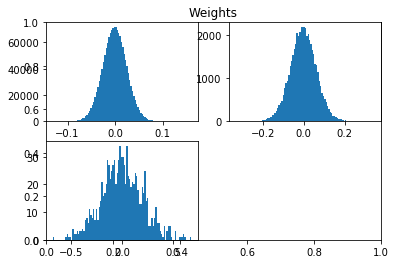

dW 0 Mean 0.0258673366628 SD 0.239860602573
dW 1 Mean 0.00547751724006 SD 0.552466099234
dW 2 Mean -1.42108547152e-17 SD 1.80642271206


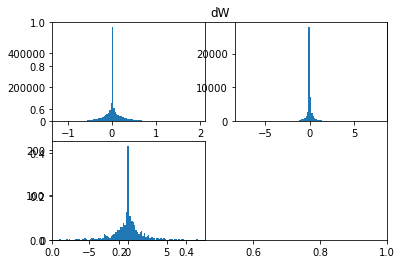

Biases 0 Mean 0.0990442208979 SD 0.0508118065666
Biases 1 Mean 0.131101629384 SD 0.168604595849
Biases 2 Mean 0.1 SD 0.418271654349


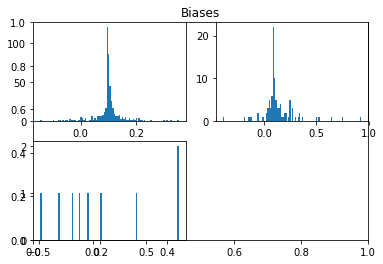

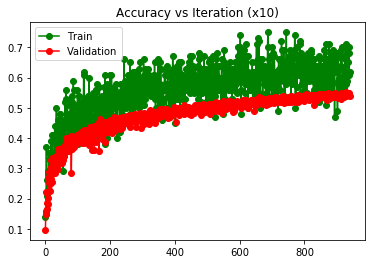

[7 2 7 6 4 1 6 8 0 3 5 9 6 6 0 4 5 6 4 6 6 7 4 5 9 2 7 0 1 5 3 2 5 2 9 0 7
 9 4 1 3 1 1 8 1 6 0 9 6 7 8 3 4 9 7 8 2 9 2 1 8 3 5 2 9 6 9 6 9 4 4 2 6 6
 8 3 1 0 3 4 4 7 7 3 3 4 5 5 3 2 0 1 6 3 2 9 1 1 5 2]
[ 7 11 11 11 11  9 14  9  6 11]
[6 8 7 ..., 5 6 4]
[497 414 493 335 459 400 857 477 473 595]
cost: 41.46625414775889, train accuracy: 0.57, validation accuracy: 0.5362
iterations finished: 9411 alpha: 0.0001500946352969992 reg. lambda: 0.0


[7 6 5 9 9 8 5 5 5 5 4 0 7 9 9 1 6 6 8 5 3 5 1 3 5 9 0 4 3 4 6 1 6 1 0 1 8
 5 7 6 1 4 1 8 3 3 5 3 7 6 6 6 9 1 6 7 6 6 8 6 1 6 9 6 9 0 3 0 3 2 7 8 6 1
 5 5 9 9 6 4 3 9 5 8 5 0 4 5 7 0 0 1 2 5 5 3 8 3 2 2]
[ 8 11  4 11  6 17 17  7  8 11]
[6 8 7 ..., 5 6 4]
[440 662 351 309 476 503 770 381 670 438]
cost: 41.17366303145318, train accuracy: 0.67, validation accuracy: 0.5322
iterations finished: 9421 alpha: 0.0001500946352969992 reg. lambda: 0.0


[3 8 1 7 7 9 7 0 3 4 9 7 2 0 2 7 1 2 9 0 4 7 1 7 5 8 0 8 0 6 9 9 3 9 2 0 3
 4 6 5 5 5 7 1 9 6 3 8 4 7 0 4 6 

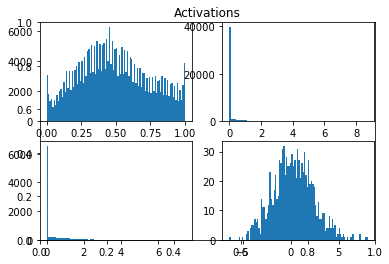

[0 0 3 9 3 4 6 9 2 3 8 0 8 6 8 3 6 8 1 0 1 1 5 5 3 8 6 8 0 1 7 0 8 6 4 5 0
 2 6 2 1 0 5 0 4 4 6 9 0 0 6 6 1 0 0 3 3 6 8 3 4 7 1 7 9 9 1 8 2 9 6 0 1 8
 0 0 0 6 2 0 5 4 9 5 0 0 5 2 4 7 5 0 3 1 4 5 3 4 7 7]
[21 10  6 10  9  9 12  6 10  7]
[6 8 7 ..., 5 6 4]
[570 662 438 395 395 340 746 477 485 492]
cost: 40.72042206748404, train accuracy: 0.61, validation accuracy: 0.5398
iterations finished: 9501 alpha: 0.0001350851717672993 reg. lambda: 0.0


Weights 0 Mean -0.000547890408937 SD 0.0252184969305
Weights 1 Mean -0.00234362979686 SD 0.0635089415869
Weights 2 Mean 0.000786497118276 SD 0.203858032513


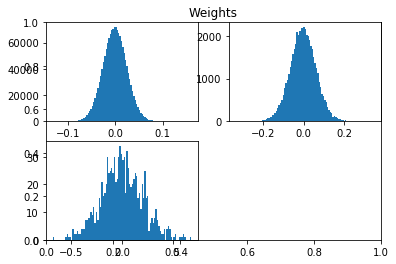

dW 0 Mean -0.00707102310775 SD 0.224639606427
dW 1 Mean -0.0123384588745 SD 0.517781703535
dW 2 Mean 5.68434188608e-17 SD 1.91630361195


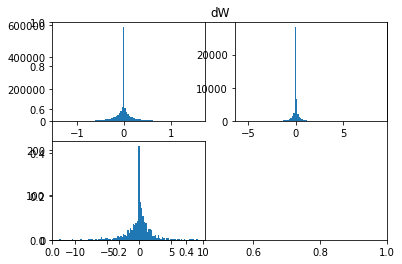

Biases 0 Mean 0.0990391658863 SD 0.0509650672336
Biases 1 Mean 0.131210194038 SD 0.169147564935
Biases 2 Mean 0.1 SD 0.41890646875


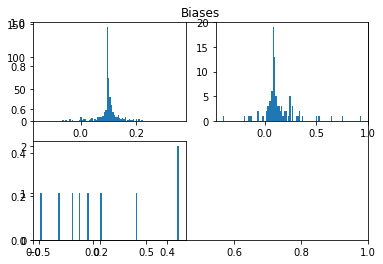

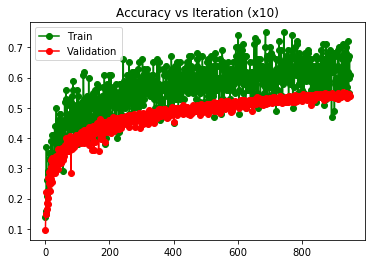

[1 6 2 8 3 4 8 4 6 5 0 7 8 4 6 9 4 7 3 0 1 6 2 6 9 3 1 9 1 6 4 7 8 1 3 3 9
 9 6 8 9 3 5 9 9 7 6 4 9 6 4 0 1 6 2 7 0 2 7 2 3 6 3 0 8 0 6 9 3 6 0 1 4 2
 7 7 9 3 9 8 3 1 4 9 7 7 7 8 8 7 9 9 1 3 2 4 8 1 4 9]
[ 7 10  7 12 11  2 13 12 10 16]
[6 8 7 ..., 5 3 4]
[448 509 401 495 441 385 640 524 591 566]
cost: 42.16083177541011, train accuracy: 0.6, validation accuracy: 0.546
iterations finished: 9511 alpha: 0.0001350851717672993 reg. lambda: 0.0


[7 8 4 5 8 3 2 1 9 0 0 7 6 9 1 1 8 3 3 8 7 0 0 9 2 3 9 6 0 8 6 4 5 5 2 3 9
 4 1 9 4 0 3 0 2 2 0 1 9 0 5 8 1 5 5 9 1 8 6 2 9 1 3 5 0 3 9 6 0 5 1 0 1 6
 6 0 7 0 9 7 6 5 1 9 7 8 8 0 9 4 4 4 3 9 1 4 3 3 0 2]
[16 12  7 11  8  9  8  6  9 14]
[6 8 7 ..., 5 3 4]
[630 472 406 345 543 557 482 519 517 529]
cost: 43.47723882669659, train accuracy: 0.58, validation accuracy: 0.5496
iterations finished: 9521 alpha: 0.0001350851717672993 reg. lambda: 0.0


[9 6 8 7 1 9 7 9 2 4 9 8 0 6 0 6 4 6 8 6 7 6 3 3 8 1 8 1 8 6 6 9 9 5 0 7 1
 1 5 3 9 0 4 1 9 1 9 5 7 6 8 6 3 2 

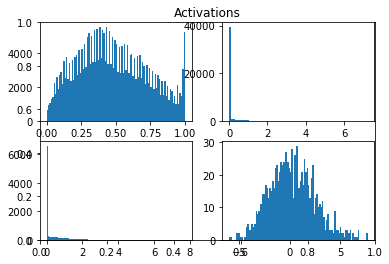

[0 9 7 9 2 1 4 9 0 8 2 2 7 3 9 8 0 4 1 2 1 2 5 3 1 9 0 0 0 6 5 2 1 1 3 6 8
 6 6 6 6 7 9 0 4 0 7 4 5 4 0 1 9 6 4 5 6 7 9 8 5 8 9 0 5 1 5 6 8 3 8 0 3 9
 8 4 1 6 5 8 0 7 5 4 8 7 8 6 3 1 7 9 9 5 1 4 7 9 8 3]
[12 11  6  7  9 10 11  9 12 13]
[6 8 7 ..., 5 3 4]
[581 549 458 438 438 412 494 594 490 546]
cost: 42.11447596309361, train accuracy: 0.62, validation accuracy: 0.5472
iterations finished: 9601 alpha: 0.0001350851717672993 reg. lambda: 0.0


Weights 0 Mean -0.000544964237342 SD 0.0252222749929
Weights 1 Mean -0.00233602444839 SD 0.06353668945
Weights 2 Mean 0.000786497118276 SD 0.204253877094


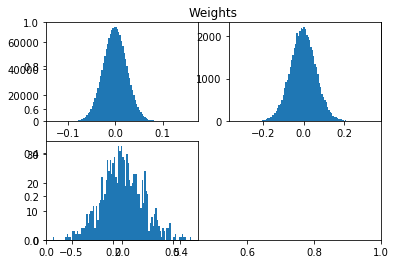

dW 0 Mean -0.00428910028431 SD 0.223523565185
dW 1 Mean 0.00923468821314 SD 0.513828159642
dW 2 Mean 2.84217094304e-17 SD 1.91346971585


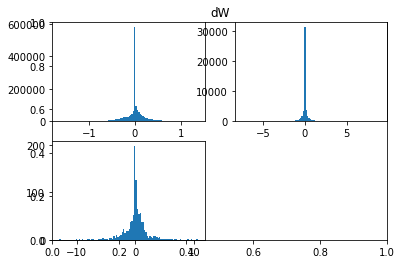

Biases 0 Mean 0.0990496305645 SD 0.0510465478524
Biases 1 Mean 0.131316156941 SD 0.16933260171
Biases 2 Mean 0.1 SD 0.418856647162


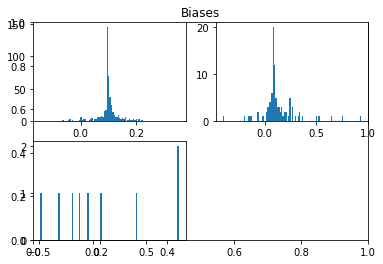

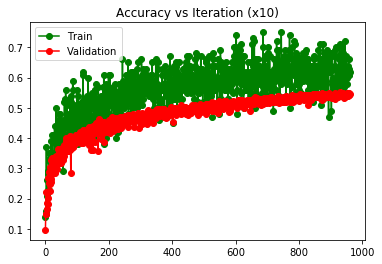

[2 5 7 1 2 9 2 9 7 1 8 9 6 2 7 5 9 5 5 1 3 5 7 9 8 6 1 1 9 5 8 4 8 0 8 5 7
 7 2 7 7 7 1 8 6 7 7 0 5 8 1 1 0 8 6 9 1 9 7 5 7 8 1 4 4 7 0 6 5 5 7 2 7 2
 4 8 9 4 4 9 8 1 8 9 1 5 5 6 8 3 3 8 3 7 6 0 7 7 7 0]
[ 6 12  7  4  6 13  7 20 14 11]
[6 8 7 ..., 5 5 4]
[409 488 409 394 333 644 519 723 586 495]
cost: 40.87292514075218, train accuracy: 0.62, validation accuracy: 0.5408
iterations finished: 9611 alpha: 0.0001350851717672993 reg. lambda: 0.0


[9 0 3 5 4 8 3 0 0 6 6 8 2 7 7 6 7 1 9 1 4 9 2 6 9 9 1 8 2 8 1 0 3 2 4 8 2
 2 6 9 1 6 8 6 8 0 3 6 2 5 8 4 9 6 7 8 3 7 0 2 8 7 5 5 7 7 1 8 9 6 8 5 9 0
 9 9 6 2 5 8 8 4 5 4 7 1 5 0 5 8 6 1 5 7 3 1 7 3 4 8]
[ 8  9  9  7  7 10 12 11 16 11]
[6 8 7 ..., 5 6 4]
[398 508 401 282 456 577 741 492 614 531]
cost: 42.866437823707685, train accuracy: 0.67, validation accuracy: 0.54
iterations finished: 9621 alpha: 0.0001350851717672993 reg. lambda: 0.0


[1 3 0 4 0 0 9 0 6 2 0 4 7 4 7 2 1 6 3 9 1 9 4 7 3 8 7 1 6 3 1 4 9 5 6 7 9
 7 9 9 1 0 7 6 4 0 1 8 3 1 6 9 1 8

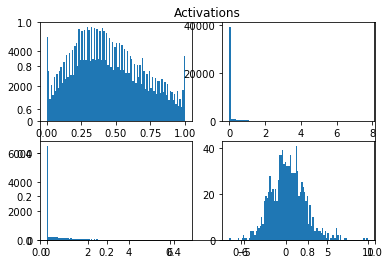

[3 7 9 0 3 0 6 8 0 2 6 3 0 9 1 4 0 1 9 6 4 9 9 5 3 5 6 6 6 2 2 0 8 4 7 5 6
 6 7 5 6 8 2 7 5 1 9 3 4 8 1 7 1 3 3 9 9 2 9 3 4 3 9 2 7 8 7 4 1 6 5 6 9 7
 9 9 3 3 6 1 9 7 8 2 9 4 9 6 6 4 7 9 3 2 5 5 6 7 7 6]
[ 6  7  8 12  8  8 16 12  6 17]
[6 8 7 ..., 5 6 4]
[418 387 420 505 430 452 770 454 442 722]
cost: 39.999208657515105, train accuracy: 0.64, validation accuracy: 0.531
iterations finished: 9701 alpha: 0.0001350851717672993 reg. lambda: 0.0


Weights 0 Mean -0.000546359444951 SD 0.025225825173
Weights 1 Mean -0.00235152096636 SD 0.0635604892573
Weights 2 Mean 0.000786497118276 SD 0.204598182806


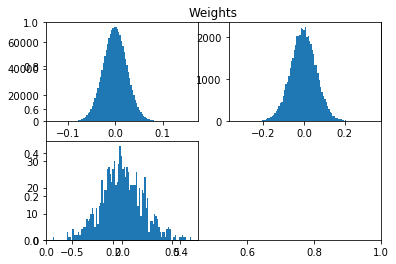

dW 0 Mean -0.00621058805702 SD 0.208727541145
dW 1 Mean -0.00122242668546 SD 0.495092712189
dW 2 Mean 5.68434188608e-17 SD 1.87749836096


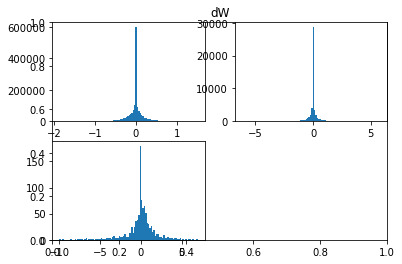

Biases 0 Mean 0.0990500210373 SD 0.0511820888863
Biases 1 Mean 0.131341466768 SD 0.169571500025
Biases 2 Mean 0.1 SD 0.419665576497


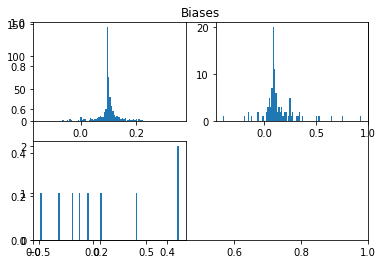

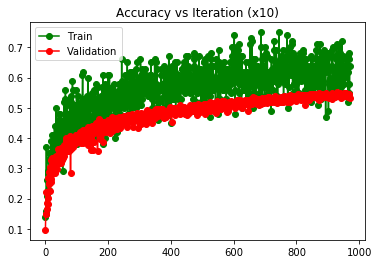

[5 4 1 6 0 5 6 9 9 0 4 6 5 3 9 8 8 3 5 4 3 1 4 8 5 7 3 1 5 4 4 5 9 1 7 4 3
 4 8 6 9 3 8 2 3 3 9 7 7 3 0 5 6 6 5 1 3 5 8 4 2 7 7 3 5 4 5 3 9 0 9 6 5 9
 9 2 4 7 5 8 5 1 8 8 0 3 1 8 7 9 5 6 0 1 5 5 1 2 8 1]
[ 6 10  4 13 11 18  8  8 11 11]
[6 8 7 ..., 5 3 4]
[434 557 397 474 449 575 552 431 601 530]
cost: 39.81850087493904, train accuracy: 0.61, validation accuracy: 0.542
iterations finished: 9711 alpha: 0.0001350851717672993 reg. lambda: 0.0


[4 1 6 5 9 6 5 1 9 7 9 6 2 9 6 1 6 5 1 1 5 1 4 6 3 0 1 0 0 0 3 1 6 9 5 0 8
 6 0 6 1 6 2 6 1 5 7 4 2 9 4 3 6 9 8 3 1 1 0 1 0 4 0 1 4 3 2 9 9 1 1 4 3 5
 1 9 1 1 1 6 8 9 8 5 4 5 8 2 0 8 4 8 5 8 1 8 0 6 1 7]
[11 22  5  6  9 10 14  3  9 11]
[6 8 7 ..., 5 6 4]
[478 731 467 401 548 402 660 392 532 389]
cost: 42.5182699899623, train accuracy: 0.66, validation accuracy: 0.5414
iterations finished: 9721 alpha: 0.0001350851717672993 reg. lambda: 0.0


[9 9 1 8 0 6 4 4 2 9 1 2 4 6 0 6 9 8 5 7 9 9 8 7 2 3 0 4 6 5 5 5 6 0 4 4 2
 3 2 6 0 9 0 2 9 9 9 2 9 2 2 7 5 3 

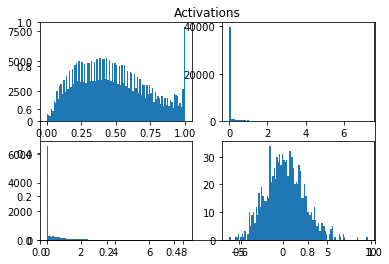

[9 9 8 6 2 5 6 7 6 3 0 3 7 1 6 8 2 7 9 6 1 1 3 5 1 0 6 0 9 8 2 8 1 2 5 3 2
 6 8 4 3 9 1 8 3 0 3 8 5 0 1 2 4 8 4 3 0 0 8 2 4 0 6 6 5 5 5 8 2 6 4 6 5 5
 6 3 0 8 8 9 4 9 0 2 4 1 7 1 9 0 5 4 9 6 8 0 7 3 4 3]
[12  9  9 11  9 10 13  5 13  9]
[6 8 7 ..., 5 3 4]
[567 446 517 496 470 345 582 531 553 493]
cost: 40.897015001904016, train accuracy: 0.62, validation accuracy: 0.5502
iterations finished: 9801 alpha: 0.0001350851717672993 reg. lambda: 0.0


Weights 0 Mean -0.00055343587802 SD 0.0252291520262
Weights 1 Mean -0.00235893983973 SD 0.0635845617048
Weights 2 Mean 0.000786497118276 SD 0.204956067941


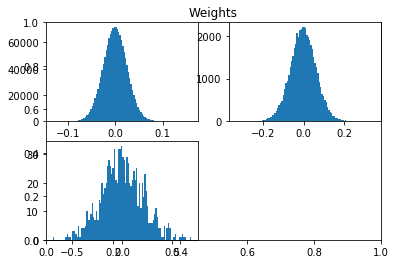

dW 0 Mean -0.00796831431448 SD 0.177793392538
dW 1 Mean -0.00949894859823 SD 0.4428006021
dW 2 Mean 0.0 SD 1.37348333737


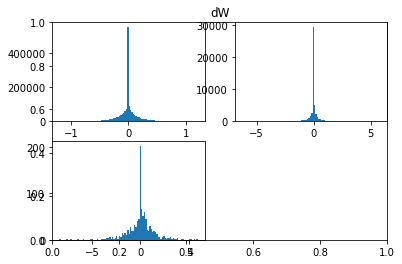

Biases 0 Mean 0.0990275204578 SD 0.0512879963249
Biases 1 Mean 0.131387494978 SD 0.169917270618
Biases 2 Mean 0.1 SD 0.419921982634


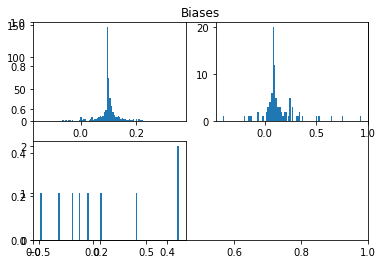

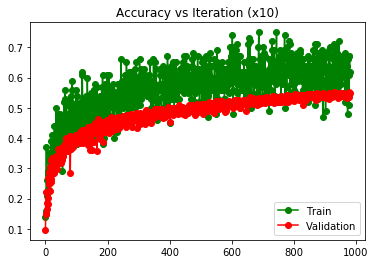

[6 1 9 7 2 9 9 4 6 5 0 1 2 8 4 3 3 5 7 9 8 7 2 3 2 6 9 7 1 4 2 9 5 8 3 2 8
 6 7 5 3 2 9 4 8 5 3 7 8 6 5 2 7 4 0 1 1 4 2 9 6 4 3 5 9 8 9 4 2 8 6 9 9 0
 3 3 1 1 0 4 5 5 4 0 2 2 3 0 7 5 8 8 6 1 6 5 8 4 1 3]
[ 6  9 12 11 11 11  9  8 11 12]
[6 8 7 ..., 5 5 4]
[363 528 748 369 342 558 446 543 595 508]
cost: 40.53951696682268, train accuracy: 0.66, validation accuracy: 0.541
iterations finished: 9811 alpha: 0.0001350851717672993 reg. lambda: 0.0


[1 7 3 7 4 8 6 7 5 5 2 5 2 6 8 9 1 8 1 4 8 5 7 2 4 5 4 1 6 0 9 0 2 6 8 0 7
 1 0 1 8 3 9 1 8 5 3 8 6 2 8 9 4 1 1 4 7 0 9 5 8 1 7 8 8 0 1 4 2 1 8 5 8 2
 6 5 1 7 8 1 7 1 6 5 3 4 5 0 8 7 6 9 3 1 1 8 8 9 4 7]
[ 7 17  7  5  9 11  8 11 18  7]
[6 8 7 ..., 5 6 4]
[405 569 473 340 565 358 741 509 565 475]
cost: 41.040840406524225, train accuracy: 0.61, validation accuracy: 0.5476
iterations finished: 9821 alpha: 0.0001350851717672993 reg. lambda: 0.0


[3 7 0 0 1 9 8 3 2 7 7 6 1 4 9 5 1 1 6 2 7 9 9 2 4 3 9 9 5 1 4 4 8 1 4 0 5
 7 6 6 4 2 9 6 6 1 4 5 6 2 9 1 8 

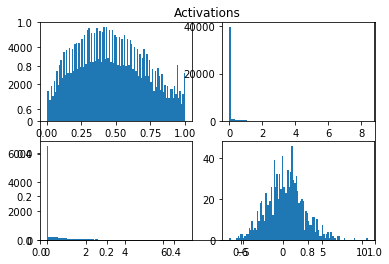

[6 6 5 4 2 7 3 8 0 9 1 4 1 4 3 3 1 5 4 8 7 0 0 7 9 6 8 0 8 9 6 9 4 1 0 5 7
 4 4 2 0 4 3 2 8 4 6 7 0 1 9 1 9 3 6 7 5 0 0 8 8 4 5 7 4 1 9 6 0 8 7 5 4 3
 5 5 7 6 4 0 6 8 4 5 1 7 3 7 0 3 8 9 5 1 0 6 7 1 6 9]
[13 10  3  8 14 10 11 12 10  9]
[6 8 7 ..., 5 6 4]
[491 558 374 441 531 498 595 611 443 458]
cost: 43.37519600565696, train accuracy: 0.64, validation accuracy: 0.5454
iterations finished: 9901 alpha: 0.0001350851717672993 reg. lambda: 0.0


Weights 0 Mean -0.000540258535733 SD 0.0252330634121
Weights 1 Mean -0.00234379275543 SD 0.0636127417198
Weights 2 Mean 0.000786497118276 SD 0.205374542015


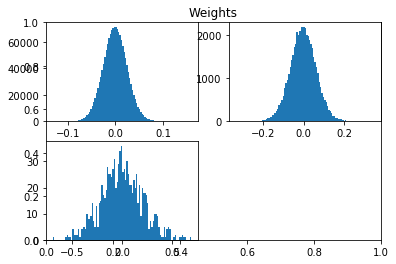

dW 0 Mean -0.0150699112336 SD 0.207699855603
dW 1 Mean 0.00336917494144 SD 0.525516699287
dW 2 Mean -2.84217094304e-17 SD 2.03764423233


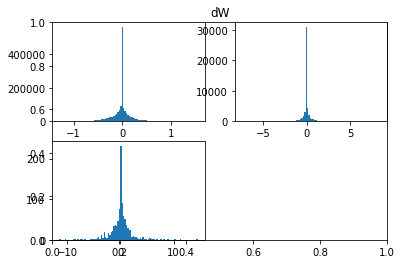

Biases 0 Mean 0.0990622885 SD 0.0514081898254
Biases 1 Mean 0.131557247933 SD 0.170314815281
Biases 2 Mean 0.1 SD 0.420606252812


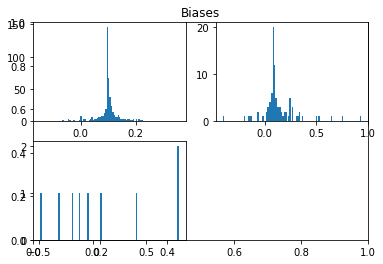

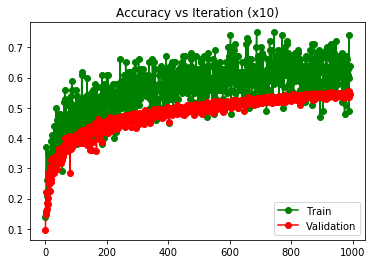

[7 5 7 5 3 8 6 3 5 8 8 9 7 6 5 4 8 5 3 9 9 3 1 4 9 6 0 9 9 2 7 8 1 9 2 8 8
 9 1 6 9 7 9 3 6 3 9 1 8 2 0 4 1 7 3 0 8 7 4 1 1 4 5 2 9 6 3 0 6 7 0 7 8 6
 0 7 4 9 5 0 6 4 6 8 8 7 3 4 9 6 4 4 0 0 6 6 3 5 2 4]
[ 9  7  5 10 11  8 13 11 12 14]
[6 8 7 ..., 5 6 4]
[420 425 498 499 439 388 690 505 573 563]
cost: 41.66696764854994, train accuracy: 0.63, validation accuracy: 0.5462
iterations finished: 9911 alpha: 0.0001350851717672993 reg. lambda: 0.0


[9 4 6 6 7 8 7 4 4 1 2 2 3 0 6 0 9 2 1 0 2 3 2 5 1 0 9 3 3 7 9 6 8 4 6 0 3
 1 1 4 8 7 8 9 5 2 6 9 9 6 0 5 2 5 4 6 4 4 9 9 5 6 0 7 0 2 8 9 3 4 4 3 7 2
 2 9 5 2 0 7 8 3 8 5 5 0 8 6 9 1 9 0 7 8 4 2 0 4 1 8]
[12  7 12  8 12  8 10  8 10 13]
[6 8 7 ..., 5 6 4]
[450 557 516 454 475 385 622 454 540 547]
cost: 41.92674316783401, train accuracy: 0.59, validation accuracy: 0.5478
iterations finished: 9921 alpha: 0.0001350851717672993 reg. lambda: 0.0


[6 9 6 7 1 6 7 6 8 1 8 1 3 1 4 0 3 0 1 7 6 2 3 4 4 6 9 1 2 1 3 9 8 9 3 7 9
 7 3 2 4 1 6 1 0 7 9 2 6 9 4 4 6 

In [39]:
np.random.seed(123456)
layer_dimensions = [X_train.shape[0], 500, 100, 10]  # including the input and output layers 
NN = NeuralNetwork(layer_dimensions, weight_init='glorot', K_iters_alpha_drop=500, gamma=.90, do_reflection=True, standard_scaling=False)
NN.train(X_train, y_train, iters=10000, alpha=0.001, batch_size=100, print_every=10)
#**Could train longer since accuracy still improving decently at 10K iterations when stopped...

In [40]:
y_predicted = NN.predict(X_test)
save_predictions('ans1-uni', y_predicted)

[8 8 8 ..., 2 6 7]
[ 893  930 1212  746  656  952 1207 1265 1066 1073]


In [41]:
# test if your numpy file has been saved correctly
loaded_y = np.load('ans1-uni.npy')
print(loaded_y.shape)
loaded_y[:10]

(10000,)


array([8, 8, 8, 4, 5, 0, 8, 2, 8, 1], dtype=int64)

## Part 2: Regularizing the neural network
#### Add dropout and L2 regularization

In [ ]:
y_predicted2 = NN2.predict(X_test)
save_predictions('ans2-uni',y_predicted)

In [ ]:
np.random.seed(123456)
layer_dimensions = [X_train.shape[0], 500, 100, 10]  # including the input and output layers
NN2 = NeuralNetwork(layer_dimensions, weight_init='msra', drop_prob=.5, reg_lambda_L2=10., \
                    reg_lambda_L1=.001, K_iters_alpha_drop=500, gamma=.90, do_reflection=True, standard_scaling=False)
NN2.train(X_train, y_train, iters=5000, alpha=0.0001, batch_size=100, print_every=10)#alpha=0.00001


# In addition to L2 regularization, dropout, have tried:
# - weight initializations: Xavier-Glorot; MSRA
# - learning rate decay: exponential stepwise
# - L1 norm regularization
# - data augmentation: left-right reflection
# - standard scaling [on INPUT directly]: 0 mean, unit SD or variance
# - for numerical stability: softmax multiply by 1 trick
#
# Have NOT done:
# - batchnorm layers
# - other Lp norm regularization
# - image pyramids on input
# - PCA/SVD on input
# - at test time, use running average of last K iterations (~model bagging)
